In [1]:
import os
import copy
import time
import glob
import math
import shutil
import argparse
import datetime
from copy import deepcopy

# data
import numpy as np
from PIL import Image
from imageio import imread
from imageio import imsave

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# torchvision
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# call torch version
from torch.utils.tensorboard import SummaryWriter

# vis
from tqdm import tqdm
from graphviz import Digraph

# replace utils.inception_score.py and fid_score.py
#!pip install pytorch_gan_metrics
from pytorch_gan_metrics import get_inception_score_from_directory, get_fid_from_directory

# used when running using colab
#from google.colab import drive
#drive.mount('/content/drive')

# Prepare CIFAR-10 dataset

In [2]:
# Author's Imagedataset, for cifar-10 and STL-10
class ImageDataset(object):
    def __init__(self, args):
        if args.dataset.lower() == 'cifar10':
            Dt = datasets.CIFAR10
            transform = transforms.Compose([
                transforms.Resize(args.img_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
            args.n_classes = 10
        elif args.dataset.lower() == 'stl10':
            Dt = datasets.STL10
            transform = transforms.Compose([
                transforms.Resize(args.img_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError('Unknown dataset: {}'.format(args.dataset))

        if args.dataset.lower() == 'stl10':
            self.train = torch.utils.data.DataLoader(
                Dt(root=args.data_path, split='train+unlabeled', transform=transform, download=True),
                batch_size=args.dis_bs, shuffle=True,
                num_workers=args.num_workers, pin_memory=True)

            self.valid = torch.utils.data.DataLoader(
                Dt(root=args.data_path, split='test', transform=transform),
                batch_size=args.dis_bs, shuffle=False,
                num_workers=args.num_workers, pin_memory=True)

            self.test = self.valid
        else:
            self.train = torch.utils.data.DataLoader(
                Dt(root=args.data_path, train=True, transform=transform, download=True),
                batch_size=args.dis_bs, shuffle=True,
                num_workers=args.num_workers, pin_memory=True)

            self.valid = torch.utils.data.DataLoader(
                Dt(root=args.data_path, train=False, transform=transform),
                batch_size=args.dis_bs, shuffle=False,
                num_workers=args.num_workers, pin_memory=True)

            self.test = self.valid

# Hyperparameters & Utilities

In [3]:
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

# base arguments
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--random_seed', type=int, default=12345)
    parser.add_argument('--dataset', type=str, default='cifar10', help='dataset type')
    parser.add_argument('--img_size', type=int, default=32, help='image size, 32 for cifar10, 48 for stl10')
    parser.add_argument('--bottom_width', type=int, default=4, help='init resolution, 4 for cifar10, 6 for stl10')
    parser.add_argument('--channels', type=int, default=3, help='image channels')
    parser.add_argument('--data_path', type=str, default='./data', help='dataset path')
    
    parser.add_argument('--exp_name', type=str, help='experiment name')
    parser.add_argument('--gpu_ids', type=str, default="0", help='visible GPU ids')
    parser.add_argument('--num_workers', type=int, default=16, help='number of cpu threads to use during batch generation')
    parser.add_argument('--checkpoint', type=str, help='checkpoint path')
    
    # train
    parser.add_argument('--arch', type=str, default='arch_cifar10', help='architecture name')
    # parser.add_argument('--arch_D', type=str, help='architecture name of D')
    parser.add_argument('--genotypes_exp', type=str, help='ues genotypes of the experiment')
    parser.add_argument('--genotype_name', type=str, default='latest', help='genotype name')
    parser.add_argument('--max_epoch_G', type=int, default=200, help='max number of epoch for training G')
    parser.add_argument('--max_iter_G', type=int, default=None, help='max number of iteration for training G')
    parser.add_argument('--max_iter_D', type=int, default=None, help='max number of iteration for training D')
    parser.add_argument('--n_critic', type=int, default=1, help='number of training steps for discriminator per iter')
    parser.add_argument('--gen_bs', type=int, default=64, help='batch size of G')
    parser.add_argument('--dis_bs', type=int, default=64, help='batch size of D')
    parser.add_argument('--gf_dim', type=int, default=256, help='base channel-dim of G')
    parser.add_argument('--df_dim', type=int, default=128, help='base channel-dim of D')
    parser.add_argument('--g_lr', type=float, default=0.0002, help='learning rate for G')
    parser.add_argument('--d_lr', type=float, default=0.0002, help='learning rate for D')
    parser.add_argument('--lr_decay', action='store_true', help='learning rate decay or not')
    parser.add_argument('--beta1', type=float, default=0.0, help='decay of first order momentum of gradient')
    parser.add_argument('--beta2', type=float, default=0.9, help='decay of first order momentum of gradient')
    parser.add_argument('--init_type', type=str, default='normal',
                        choices=['normal', 'orth', 'xavier_uniform', 'false'],
                        help='init type')
    parser.add_argument('--d_spectral_norm', type=str2bool, default=True,
                        help='add spectral_norm on discriminator or not')
    parser.add_argument('--g_spectral_norm', type=str2bool, default=False,
                        help='add spectral_norm on generator or not')
    parser.add_argument('--latent_dim', type=int, default=128, help='dimensionality of the latent space') # this should be 120 else raise RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x40 and 42x4096)
    
    # val
    parser.add_argument('--print_freq', type=int, default=50, help='frequency of verbose')
    parser.add_argument('--val_freq', type=int, default=20, help='frequency of validation')
    parser.add_argument('--num_eval_imgs', type=int, default=50000)
    parser.add_argument('--eval_batch_size', type=int, default=100)

    # search
    parser.add_argument('--gumbel_softmax', type=str2bool, default=False, help='use gumbel softmax or not')
    parser.add_argument('--derive_freq', type=int, default=1, help='frequency (epoch) of deriving arch')
    parser.add_argument('--derive_per_epoch', type=int, default=0, help='number of deriving per epoch')
    parser.add_argument('--tau_max', type=float, default=5, help='max tau for gumbel softmax')
    parser.add_argument('--tau_min', type=float, default=0.1, help='min tau for gumbel softmax')
    parser.add_argument('--amending_coefficient', type=float, default=0, help='coeff of Amended Gradient Estimation trick')
    parser.add_argument('--draw_arch', type=str2bool, default=True, help='visualize the searched architecture or not')
    parser.add_argument('--early_stop', type=str2bool, default=False, help='use early stop strategy or not')

    # parser.add_argument('--derived_start_epoch', type=int, default=0, help='')
    # parser.add_argument('--derived_max_epoch', type=int, default=None, help='')
    # parser.add_argument('--derived_epoch_interval', type=int, default=None, help='')

    opt = parser.parse_args(args=[])

    return opt

args = parse_args()

In [4]:
def _concat(xs):
    return torch.cat([x.view(-1) for x in xs])

def count_parameters_in_MB(model):
  #return np.sum(np.prod(v.size()) for name, v in model.named_parameters() if "auxiliary" not in name)/1e6
  return sum(np.prod(v.size()) for name, v in model.named_parameters() if "auxiliary" not in name)/1e6

# weight init
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        if args.init_type == 'normal':
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif args.init_type == 'orth':
            nn.init.orthogonal_(m.weight.data)
        elif args.init_type == 'xavier_uniform':
            nn.init.xavier_uniform(m.weight.data, 1.)
        else:
            raise NotImplementedError('{} unknown inital type'.format(args.init_type))
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

# modified because in colab we will not use logger
def print_FLOPs(model, shape, logger=None):
  
    model = copy.deepcopy(model)

    model = add_flops_counting_methods(model)
    model = model.cuda()
    model.eval()

    cache_inputs = torch.zeros(*shape).cuda()
    # print_log('In the calculating function : cache input size : {:}'.format(cache_inputs.size()), log)
    _ = model(cache_inputs)
    FLOPs = compute_average_flops_cost(model) / 1e6

    try:
        logger.info('FLOPs : {:} MB'.format(FLOPs))
    except:
        print('FLOPs : {:} MB'.format(FLOPs))
    torch.cuda.empty_cache()


# ---- Public functions
def add_flops_counting_methods(model):
    model.__batch_counter__ = 0
    add_batch_counter_hook_function(model)
    model.apply(add_flops_counter_variable_or_reset)
    model.apply(add_flops_counter_hook_function)
    return model


def compute_average_flops_cost(model):
    """
    A method that will be available after add_flops_counting_methods() is called on a desired net object.
    Returns current mean flops consumption per image.
    """
    batches_count = model.__batch_counter__
    flops_sum = 0
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            flops_sum += module.__flops__
    return flops_sum / batches_count


# ---- Internal functions
def pool_flops_counter_hook(pool_module, inputs, output):
    batch_size = inputs[0].size(0)
    kernel_size = pool_module.kernel_size
    out_C, output_height, output_width = output.shape[1:]
    assert out_C == inputs[0].size(1), '{:} vs. {:}'.format(out_C, inputs[0].size())

    overall_flops = batch_size * out_C * output_height * output_width * kernel_size * kernel_size
    pool_module.__flops__ += overall_flops


def fc_flops_counter_hook(fc_module, inputs, output):
    batch_size = inputs[0].size(0)
    xin, xout = fc_module.in_features, fc_module.out_features
    assert xin == inputs[0].size(1) and xout == output.size(1), 'IO=({:}, {:})'.format(xin, xout)
    overall_flops = batch_size * xin * xout
    if fc_module.bias is not None:
        overall_flops += batch_size * xout
    fc_module.__flops__ += overall_flops


def conv_flops_counter_hook(conv_module, inputs, output):
    batch_size = inputs[0].size(0)
    output_height, output_width = output.shape[2:]

    kernel_height, kernel_width = conv_module.kernel_size
    in_channels = conv_module.in_channels
    out_channels = conv_module.out_channels
    groups = conv_module.groups
    conv_per_position_flops = kernel_height * kernel_width * in_channels * out_channels / groups

    active_elements_count = batch_size * output_height * output_width
    overall_flops = conv_per_position_flops * active_elements_count

    if conv_module.bias is not None:
        overall_flops += out_channels * active_elements_count
    conv_module.__flops__ += overall_flops


def batch_counter_hook(module, inputs, output):
    # Can have multiple inputs, getting the first one
    inputs = inputs[0]
    batch_size = inputs.shape[0]
    module.__batch_counter__ += batch_size


def add_batch_counter_hook_function(module):
    if not hasattr(module, '__batch_counter_handle__'):
        handle = module.register_forward_hook(batch_counter_hook)
        module.__batch_counter_handle__ = handle


def add_flops_counter_variable_or_reset(module):
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) \
    or isinstance(module, torch.nn.AvgPool2d) or isinstance(module, torch.nn.MaxPool2d):
        module.__flops__ = 0


def add_flops_counter_hook_function(module):
    if isinstance(module, torch.nn.Conv2d):
        if not hasattr(module, '__flops_handle__'):
            handle = module.register_forward_hook(conv_flops_counter_hook)
            module.__flops_handle__ = handle
    elif isinstance(module, torch.nn.Linear):
        if not hasattr(module, '__flops_handle__'):
            handle = module.register_forward_hook(fc_flops_counter_hook)
            module.__flops_handle__ = handle
    elif isinstance(module, torch.nn.AvgPool2d) or isinstance(module, torch.nn.MaxPool2d):
        if not hasattr(module, '__flops_handle__'):
            handle = module.register_forward_hook(pool_flops_counter_hook)
            module.__flops_handle__ = handle

# Search Space
- Network Design
  - Generator with 3 Up-Cells
  - Discriminator with 4 Down-Cells

In [5]:
class Generator(nn.Module):
    def __init__(self, args):
        super(Generator, self).__init__()
        self.args = args
        self.ch = args.gf_dim
        self.bottom_width = args.bottom_width
        self.l1 = nn.Linear(args.latent_dim // 3, (self.bottom_width ** 2) * args.gf_dim)
        self.l2 = nn.Linear(args.latent_dim // 3, ((self.bottom_width * 2) ** 2) * args.gf_dim)
        self.l3 = nn.Linear(args.latent_dim // 3, ((self.bottom_width * 4) ** 2) * args.gf_dim)
        self.cell1 = Cell(args.gf_dim, args.gf_dim, 'nearest', num_skip_in=0)
        self.cell2 = Cell(args.gf_dim, args.gf_dim, 'bilinear', num_skip_in=1)
        self.cell3 = Cell(args.gf_dim, args.gf_dim, 'nearest', num_skip_in=2)
        self.to_rgb = nn.Sequential(
            nn.BatchNorm2d(args.gf_dim),
            nn.ReLU(),
            nn.Conv2d(args.gf_dim, 3, 3, 1, 1),
            nn.Tanh()
        )

        self.initialize_alphas()

    def initialize_alphas(self):
        num_cell = 3
        num_edge_normal = 5
        num_ops = 7
        num_edge_up = 2
        num_up = 3
        self.alphas_normal = nn.Parameter(1e-3 * torch.randn(num_cell, num_edge_normal, num_ops))
        self.alphas_up = nn.Parameter(1e-3 * torch.randn(num_cell, num_edge_up, num_up))
        self._arch_parameters = [self.alphas_normal, self.alphas_up]

    def arch_parameters(self):
        return self._arch_parameters

    def set_tau(self, tau):
        self.tau = tau

    def forward(self, z):
        h = self.l1(z[:, :40]).view(-1, self.ch, self.bottom_width, self.bottom_width)
        n1 = self.l2(z[:, 40:80]).view(-1, self.ch, self.bottom_width * 2, self.bottom_width * 2)
        n2 = self.l3(z[:, 80:]).view(-1, self.ch, self.bottom_width * 4, self.bottom_width * 4)

        if self.args.gumbel_softmax:
            alphas_normal_pi = F.softmax(self.alphas_normal, dim=-1)
            weights_normal = F.gumbel_softmax(alphas_normal_pi, tau=self.tau, hard=False, dim=-1)
            alphas_up_pi = F.softmax(self.alphas_up, dim=-1)
            weights_up = F.gumbel_softmax(alphas_up_pi, tau=self.tau, hard=False, dim=-1)
        else:
            weights_normal = F.softmax(self.alphas_normal, dim=-1)
            weights_up = F.softmax(self.alphas_up, dim=-1)

        h1_skip_out, h1 = self.cell1(h, weights_normal[0], weights_up[0])
        h2_skip_out, h2 = self.cell2(h1 + n1, weights_normal[1], weights_up[1], (h1_skip_out,))
        _, h3 = self.cell3(h2 + n2, weights_normal[2], weights_up[2], (h1_skip_out, h2_skip_out))
        output = self.to_rgb(h3)

        return output


class Discriminator(nn.Module):
    def __init__(self, args, activation=nn.ReLU()):
        super(Discriminator, self).__init__()
        self.args = args
        self.ch = args.df_dim
        self.activation = activation
        self.block1 = OptimizedDisBlock(args, 3, self.ch, activation=activation, downsample=True)
        self.block2 = DisBlock(args, self.ch, self.ch, activation=activation, downsample=True)
        self.block3 = DisBlock(args, self.ch, self.ch, activation=activation, downsample=True)
        self.block4 = DisBlock(args, self.ch, self.ch, activation=activation, downsample=True)
        self.l5 = nn.Linear(self.ch, 1, bias=False)
        if args.d_spectral_norm:
            self.l5 = nn.utils.spectral_norm(self.l5)

        self.initialize_alphas()

    def initialize_alphas(self):
        num_cell = 4
        num_edge_normal = 5
        num_ops = 7
        num_edge_down = 2
        num_down = 6
        self.alphas_normal = nn.Parameter(1e-3 * torch.randn(num_cell, num_edge_normal, num_ops))
        self.alphas_down = nn.Parameter(1e-3 * torch.randn(num_cell, num_edge_down, num_down))
        self._arch_parameters = [self.alphas_normal, self.alphas_down]

    def arch_parameters(self):
        return self._arch_parameters

    def set_tau(self, tau):
        self.tau = tau

    def forward(self, x):
        h = x

        if self.args.gumbel_softmax:
            alphas_normal_pi = F.softmax(self.alphas_normal, dim=-1)
            weights_normal = F.gumbel_softmax(alphas_normal_pi, tau=self.tau, hard=False, dim=-1)
            alphas_down_pi = F.softmax(self.alphas_down, dim=-1)
            weights_down = F.gumbel_softmax(alphas_down_pi, tau=self.tau, hard=False, dim=-1)
        else:
            weights_normal = F.softmax(self.alphas_normal, dim=-1)
            weights_down = F.softmax(self.alphas_down, dim=-1)

        h = self.block1(h, weights_normal=weights_normal[0], weights_down=weights_down[0])
        h = self.block2(h, weights_normal=weights_normal[1], weights_down=weights_down[1])
        h = self.block3(h, weights_normal=weights_normal[2], weights_down=weights_down[2])
        h = self.block4(h, weights_normal=weights_normal[3], weights_down=weights_down[3])

        h = self.activation(h)
        h = h.sum(2).sum(2)
        output = self.l5(h)

        return output

- Cell design: Common
  - 5 normal edges (does not change data dimension)
  - 2 up/down edges (change data dimension)

- Generator: class Cell
  - 2 up edges + 5 normal edges

- Discriminator: class OptimizedDisBlock, class DisBlock
  - 5 normal edges + 2 down edges

In [6]:
class Cell(nn.Module):
    def __init__(self, in_channels, out_channels, up_mode, num_skip_in=0, norm=None):
        super(Cell, self).__init__()

        self.up0 = MixedUp(in_channels, out_channels)
        self.up1 = MixedUp(in_channels, out_channels)

        self.c0 = MixedOp(out_channels, out_channels, 1, False, True)
        self.c1 = MixedOp(out_channels, out_channels, 1, False, True)
        self.c2 = MixedOp(out_channels, out_channels, 1, False, True)
        self.c3 = MixedOp(out_channels, out_channels, 1, False, True)
        self.c4 = MixedOp(out_channels, out_channels, 1, False, True)

        self.up_mode = up_mode
        self.norm = norm

        # no norm
        if norm:
            assert norm in NORMS
            if norm == 'bn':
                self.n1 = nn.BatchNorm2d(in_channels)
                self.n2 = nn.BatchNorm2d(out_channels)
            elif norm == 'in':
                self.n1 = nn.InstanceNorm2d(in_channels)
                self.n2 = nn.InstanceNorm2d(out_channels)
            else:
                raise NotImplementedError(norm)

        # cross scale skip
        self.skip_in_ops = None
        if num_skip_in:
            self.skip_in_ops = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=1) for _ in range(num_skip_in)])

    def forward(self, x, weights_normal, weights_up, skip_ft=None):

        node0 = self.up0(x, weights_up[0])
        node1 = self.up1(x, weights_up[1])
        _, _, ht, wt = node0.size()

        node2 = self.c0(node0, weights_normal[0]) + self.c1(node1, weights_normal[1])

        h_skip_out = node2

        # second conv
        if self.skip_in_ops:
            assert len(self.skip_in_ops) == len(skip_ft)
            for ft, skip_in_op in zip(skip_ft, self.skip_in_ops):
                node2 += skip_in_op(F.interpolate(ft, size=(ht, wt), mode=self.up_mode))

        node3 = self.c2(node0, weights_normal[2]) + self.c3(node1, weights_normal[3]) + self.c4(node2, weights_normal[4])

        return h_skip_out, node3


def _downsample(x):
    # Downsample (Mean Avg Pooling with 2x2 kernel)
    return nn.AvgPool2d(kernel_size=2)(x)


class OptimizedDisBlock(nn.Module):
    def __init__(self, args, in_channels, out_channels, activation=nn.ReLU(), downsample=False):
        super(OptimizedDisBlock, self).__init__()
        self.activation = activation
        self.downsample = downsample

        self.c0 = MixedOp_sn_wo_act(in_channels, out_channels, 1, True, False)
        self.c1 = MixedOp_sn_wo_act(in_channels, out_channels, 1, True, False)
        self.c2 = MixedOp_sn_wo_act(in_channels, out_channels, 1, True, False)
        self.c3 = MixedOp(out_channels, out_channels, 1, True, True)
        self.c4 = MixedOp(out_channels, out_channels, 1, True, True)

        if self.downsample:
            self.down0 = MixedDown(out_channels, out_channels, 2, True, True)
            self.down1 = MixedDown(out_channels, out_channels, 2, True, True)
        else:
            self.c5 = MixedOp(in_channels, out_channels, 1, True, True)
            self.c6 = MixedOp(in_channels, out_channels, 1, True, True)

    def forward(self, x, weights_normal=None, weights_down=None):
        node0 = self.c0(x, weights_normal[0])
        node1 = self.c1(x, weights_normal[1]) + self.c3(node0, weights_normal[3])
        node2 = self.c2(x, weights_normal[2]) + self.c4(node0, weights_normal[4])

        if self.downsample:
            node3 = self.down0(node1, weights_down[0]) + self.down1(node2, weights_down[1])
        else:
            return

        return node3


class DisBlock(nn.Module):
    def __init__(self, args, in_channels, out_channels, activation=nn.ReLU(), downsample=False):
        super(DisBlock, self).__init__()
        self.activation = activation
        self.downsample = downsample

        self.c0 = MixedOp(in_channels, out_channels, 1, True, True)
        self.c1 = MixedOp(in_channels, out_channels, 1, True, True)
        self.c2 = MixedOp(in_channels, out_channels, 1, True, True)
        self.c3 = MixedOp(out_channels, out_channels, 1, True, True)
        self.c4 = MixedOp(out_channels, out_channels, 1, True, True)

        if self.downsample:
            self.down0 = MixedDown(out_channels, out_channels, 2, True, True)
            self.down1 = MixedDown(out_channels, out_channels, 2, True, True)
        else:
            self.c5 = MixedOp(in_channels, out_channels, 1, True, True)
            self.c6 = MixedOp(in_channels, out_channels, 1, True, True)

    def forward(self, x, weights_normal=None, weights_down=None):

        node0 = self.c0(x, weights_normal[0])
        node1 = self.c1(x, weights_normal[1]) + self.c3(node0, weights_normal[3])
        node2 = self.c2(x, weights_normal[2]) + self.c4(node0, weights_normal[4])

        if self.downsample:
            node3 = self.down0(node1, weights_down[0]) + self.down1(node2, weights_down[1])
        else:
            return

        return node3

- Edge Design
  - Primitives: list of operations to use
  - Operations: dictionary,
    - key: Primitive
    - value: lambda function that load ann.layer objects according to the key

  - Operation classes:
    - return operations, with some modifications if required

  - Mixed Operation classes
    - return weighted sum of Operations using Operation classes


In [7]:
UP_MODES = ['nearest', 'bilinear']
NORMS = ['in', 'bn']

# 7
PRIMITIVES = [
    'none',
    'skip_connect',
    'conv_1x1',
    'conv_3x3',
    'conv_5x5',
    'dil_conv_3x3',
    'dil_conv_5x5'
]

# 5
PRIMITIVES_wo_act = [
  'conv_1x1',
  'conv_3x3',
  'conv_5x5',
  'dil_conv_3x3',
  'dil_conv_5x5'
]

# 3
PRIMITIVES_up = [
    'nearest',
    'bilinear',
    'ConvTranspose'
]

# 6
PRIMITIVES_down = [
    'avg_pool',
    'max_pool',
    'conv_3x3',
    'conv_5x5',
    'dil_conv_3x3',
    'dil_conv_5x5'
]


OPS = {
    'none': lambda in_ch, out_ch, stride, sn, act: Zero(),
    'skip_connect': lambda in_ch, out_ch, stride, sn, act: Identity(),
    'conv_1x1': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 1, stride, 0, sn, act),
    'conv_3x3': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 3, stride, 1, sn, act),
    'conv_5x5': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 5, stride, 2, sn, act),
    'dil_conv_3x3': lambda in_ch, out_ch, stride, sn, act: DilConv(in_ch, out_ch, 3, stride, 2, 2, sn, act),
    'dil_conv_5x5': lambda in_ch, out_ch, stride, sn, act: DilConv(in_ch, out_ch, 5, stride, 4, 2, sn, act)
}

OPS_down = {
    'avg_pool': lambda in_ch, out_ch, stride, sn, act: Pool(in_ch, out_ch, mode='Avg'),
    'max_pool': lambda in_ch, out_ch, stride, sn, act: Pool(in_ch, out_ch, mode='Max'),
    'conv_3x3': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 3, stride, 1, sn, act),
    'conv_5x5': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 5, stride, 2, sn, act),
    'dil_conv_3x3': lambda in_ch, out_ch, stride, sn, act: DilConv(in_ch, out_ch, 3, stride, 2, 2, sn, act),
    'dil_conv_5x5': lambda in_ch, out_ch, stride, sn, act: DilConv(in_ch, out_ch, 5, stride, 4, 2, sn, act)
}

UPS = {
    'nearest': lambda in_ch, out_ch: Up(in_ch, out_ch, mode='nearest'),
    'bilinear': lambda in_ch, out_ch: Up(in_ch, out_ch, mode='bilinear'),
    'ConvTranspose': lambda in_ch, out_ch: Up(in_ch, out_ch, mode='convT')
}


class Conv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, sn, act):
        super(Conv, self).__init__()
        if sn:
            self.conv = nn.utils.spectral_norm(nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding))
        else:
            self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding)
        if act:
            self.op = nn.Sequential(nn.ReLU(), self.conv)
        else:
            self.op = nn.Sequential(self.conv)

    def forward(self, x):
        return self.op(x)


class DilConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, dilation, sn, act):
        super(DilConv, self).__init__()
        if sn:
            self.dilconv = nn.utils.spectral_norm(
              nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation))
        else:
            self.dilconv = \
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        if act:
            self.op = nn.Sequential(nn.ReLU(), self.dilconv)
        else:
            self.op = nn.Sequential(self.dilconv)

    def forward(self, x):
        return self.op(x)


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Zero(nn.Module):
    def __init__(self):
        super(Zero, self).__init__()

    def forward(self, x):
        return x.mul(0.)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, mode=None):
        super(Up, self).__init__()
        self.up_mode = mode
        if self.up_mode == 'convT':
            self.convT = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(in_ch, in_ch, kernel_size=3, stride=2, padding=1, output_padding=1, groups=in_ch,
                                   bias=False),
                nn.Conv2d(in_ch, out_ch, kernel_size=1, padding=0, bias=False)
            )
        else:
            self.c = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(in_ch, out_ch, kernel_size=1)
            )

    def forward(self, x):
        if self.up_mode == 'convT':
            return self.convT(x)
        else:
            return self.c(F.interpolate(x, scale_factor=2, mode=self.up_mode))


class Pool(nn.Module):
    def __init__(self, in_ch, out_ch, mode=None):
        super(Pool, self).__init__()
        self.pool_mode = mode

        if self.pool_mode == 'Avg':
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        elif self.pool_mode == 'Max':
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)

    def forward(self, x):
        return self.pool(x)


class MixedOp(nn.Module):
    def __init__(self, in_ch, out_ch, stride, sn, act):
        super(MixedOp, self).__init__()
        self.ops = nn.ModuleList()
        for primitive in PRIMITIVES:
            op = OPS[primitive](in_ch, out_ch, stride, sn, act)
            self.ops.append(op)

    def forward(self, x, weights):
        return sum(w * op(x) for w, op in zip(weights, self.ops))


class MixedOp_sn_wo_act(nn.Module):
    def __init__(self, in_ch, out_ch, stride, sn, act):
        super(MixedOp_sn_wo_act, self).__init__()
        self.ops = nn.ModuleList()
        for primitive in PRIMITIVES_wo_act:
            op = OPS[primitive](in_ch, out_ch, stride, sn, act)
            self.ops.append(op)

    def forward(self, x, weights):
        return sum(w * op(x) for w, op in zip(weights, self.ops))


class MixedDown(nn.Module):
    def __init__(self, in_ch, out_ch, stride, sn, act):
        super(MixedDown, self).__init__()
        self.ops = nn.ModuleList()
        for primitive in PRIMITIVES_down:
            op = OPS_down[primitive](in_ch, out_ch, stride, sn, act)
            self.ops.append(op)

    def forward(self, x, weights):
        return sum(w * op(x) for w, op in zip(weights, self.ops))


class MixedUp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(MixedUp, self).__init__()
        self.ups = nn.ModuleList()
        for primitive in PRIMITIVES_up:
            up = UPS[primitive](in_ch, out_ch)
            self.ups.append(up)

    def forward(self, x, weights):
        return sum(w * up(x) for w, up in zip(weights, self.ups))

# Search Strategy

- Architecture parameters for weighted sum of operations in a edge

In [8]:
class Architect_gen(object):
    def __init__(self, model, args):
        self.args = args
        if isinstance(model, torch.nn.DataParallel):
            self.model = model.module
        else:
            self.model = model
        self.optimizer = torch.optim.Adam(self.model.arch_parameters(), lr=0.0003, betas=(0.5, 0.999), weight_decay=0.0001)

    def step(self, search_z, gen_net, dis_net, train_z=None, eta=None):
        self.optimizer.zero_grad()
        if self.args.amending_coefficient:
            self._backward_step_amending(search_z, gen_net, dis_net, train_z, eta)
        else:
            self._backward_step(search_z, gen_net, dis_net)
        self.optimizer.step()

    def _backward_step(self, search_z, gen_net, dis_net):
        gen_imgs = gen_net(search_z)
        fake_validity = dis_net(gen_imgs)
        # cal loss
        g_loss = -torch.mean(fake_validity)
        g_loss.backward()

    def _backward_step_amending(self, search_z, gen_net, dis_net, train_z, eta):
        gen_imgs = gen_net(search_z)
        fake_validity = dis_net(gen_imgs)
        # cal loss
        g_loss = -torch.mean(fake_validity)
        g_loss.backward()

        vector = [v.grad.data for v in self.model.parameters()]
        implicit_grads = self._hessian_vector_product_2(
            self._hessian_vector_product_1(vector, train_z, gen_net, dis_net), train_z, gen_net, dis_net)

        for g, ig in zip(self.model.arch_parameters(), implicit_grads):
            g.grad.data.sub_(eta, ig.data)

    # Compute Hessian matrix product (codes from https://openreview.net/forum?id=BJlgt2EYwr)
    def _hessian_vector_product_2(self, vector, train_z, gen_net, dis_net, r=1e-2):
        R = r / _concat(vector).norm()
        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)
        # cal loss
        gen_imgs = gen_net(train_z)
        fake_validity = dis_net(gen_imgs)
        g_loss = -torch.mean(fake_validity)
        grads_p = torch.autograd.grad(g_loss, self.model.arch_parameters())

        for p, v in zip(self.model.parameters(), vector):
            p.data.sub_(2 * R, v)
        # cal loss
        gen_imgs = gen_net(train_z)
        fake_validity = dis_net(gen_imgs)
        g_loss = -torch.mean(fake_validity)
        grads_n = torch.autograd.grad(g_loss, self.model.arch_parameters())

        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)

        return [(x - y).div_(2 * R) for x, y in zip(grads_p, grads_n)]

    # Compute Hessian matrix product
    def _hessian_vector_product_1(self, vector, train_z, gen_net, dis_net, r=1e-2):
        R = r / _concat(vector).norm()
        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)
        # cal loss
        gen_imgs = gen_net(train_z)
        fake_validity = dis_net(gen_imgs)
        g_loss = -torch.mean(fake_validity)

        grads_p = torch.autograd.grad(g_loss, self.model.parameters())

        for p, v in zip(self.model.parameters(), vector):
            p.data.sub_(2 * R, v)
        # cal loss
        gen_imgs = gen_net(train_z)
        fake_validity = dis_net(gen_imgs)
        g_loss = -torch.mean(fake_validity)
        grads_n = torch.autograd.grad(g_loss, self.model.parameters())

        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)

        return [(x - y).div_(2 * R) for x, y in zip(grads_p, grads_n)]

# --------------------------------------------------------------------------------------- #

class Architect_dis(object):
    def __init__(self, model, args):
        self.args = args
        if isinstance(model, torch.nn.DataParallel):
            self.model = model.module
        else:
            self.model = model
        self.optimizer = torch.optim.Adam(self.model.arch_parameters(), lr=0.0003, betas=(0.5, 0.999), weight_decay=0.0001)

    def step(self, dis_net, real_imgs, gen_net, search_z, real_imgs_train=None, train_z=None, eta=None):
        self.optimizer.zero_grad()
        if self.args.amending_coefficient:
            self._backward_step_amending(dis_net, real_imgs, gen_net, search_z, real_imgs_train, train_z, eta)
        else:
            self._backward_step(dis_net, real_imgs, gen_net, search_z)
        self.optimizer.step()

    def _backward_step(self, dis_net, real_imgs, gen_net, search_z):
        real_validity = dis_net(real_imgs)
        fake_imgs = gen_net(search_z).detach()
        fake_validity = dis_net(fake_imgs)
        # cal loss
        d_loss = torch.mean(torch.nn.ReLU(inplace=True)(1.0 - real_validity)) + \
                 torch.mean(torch.nn.ReLU(inplace=True)(1 + fake_validity))
        d_loss.backward()

    def _backward_step_amending(self, dis_net, real_imgs, gen_net, search_z, real_imgs_train, train_z, eta):
        real_validity = dis_net(real_imgs)
        fake_imgs = gen_net(search_z).detach()
        fake_validity = dis_net(fake_imgs)
        # cal loss
        d_loss = torch.mean(torch.nn.ReLU(inplace=True)(1.0 - real_validity)) + \
                 torch.mean(torch.nn.ReLU(inplace=True)(1 + fake_validity))
        d_loss.backward()

        vector = [v.grad.data for v in self.model.parameters()]
        implicit_grads = self._hessian_vector_product_2(
            self._hessian_vector_product_1(vector, real_imgs_train, train_z, gen_net, dis_net), real_imgs_train,
            train_z, gen_net, dis_net)

        for g, ig in zip(self.model.arch_parameters(), implicit_grads):
            g.grad.data.sub_(eta, ig.data)

    # Compute Hessian matrix product (codes from https://openreview.net/forum?id=BJlgt2EYwr)
    def _hessian_vector_product_2(self, vector, real_imgs_train, train_z, gen_net, dis_net, r=1e-2):
        R = r / _concat(vector).norm()
        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)
        # cal loss
        real_validity = dis_net(real_imgs_train)
        fake_imgs = gen_net(train_z).detach()
        fake_validity = dis_net(fake_imgs)
        d_loss = torch.mean(torch.nn.ReLU(inplace=True)(1.0 - real_validity)) + \
                 torch.mean(torch.nn.ReLU(inplace=True)(1 + fake_validity))

        grads_p = torch.autograd.grad(d_loss, self.model.arch_parameters())

        for p, v in zip(self.model.parameters(), vector):
            p.data.sub_(2 * R, v)
        # cal loss
        real_validity = dis_net(real_imgs_train)
        fake_imgs = gen_net(train_z).detach()
        fake_validity = dis_net(fake_imgs)
        d_loss = torch.mean(torch.nn.ReLU(inplace=True)(1.0 - real_validity)) + \
                 torch.mean(torch.nn.ReLU(inplace=True)(1 + fake_validity))

        grads_n = torch.autograd.grad(d_loss, self.model.arch_parameters())

        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)

        return [(x - y).div_(2 * R) for x, y in zip(grads_p, grads_n)]

    # Compute Hessian matrix product
    def _hessian_vector_product_1(self, vector, real_imgs_train, train_z, gen_net, dis_net, r=1e-2):
        R = r / _concat(vector).norm()
        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)
        # cal loss
        real_validity = dis_net(real_imgs_train)
        fake_imgs = gen_net(train_z).detach()
        fake_validity = dis_net(fake_imgs)
        d_loss = torch.mean(torch.nn.ReLU(inplace=True)(1.0 - real_validity)) + \
                 torch.mean(torch.nn.ReLU(inplace=True)(1 + fake_validity))

        grads_p = torch.autograd.grad(d_loss, self.model.parameters())

        for p, v in zip(self.model.parameters(), vector):
            p.data.sub_(2 * R, v)
        # cal loss
        real_validity = dis_net(real_imgs_train)
        fake_imgs = gen_net(train_z).detach()
        fake_validity = dis_net(fake_imgs)
        d_loss = torch.mean(torch.nn.ReLU(inplace=True)(1.0 - real_validity)) + \
                 torch.mean(torch.nn.ReLU(inplace=True)(1 + fake_validity))

        grads_n = torch.autograd.grad(d_loss, self.model.parameters())

        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)

        return [(x - y).div_(2 * R) for x, y in zip(grads_p, grads_n)]
        

In [9]:
def alpha2genotype(alpha_normal, alpha_up, save=False, file_path=None):
    num_cell = alpha_up.shape[0]
    offset = alpha_up.shape[1]

    genotype = np.ones((alpha_up.shape[0], alpha_up.shape[1]+alpha_normal.shape[1]), dtype=np.uint8) * 100
    alpha_up = F.softmax(alpha_up, dim=-1).cpu().detach().numpy()
    alpha_normal = F.softmax(alpha_normal, dim=-1).cpu().detach().numpy()

    for cell_i in range(num_cell):
        for edge_i in range(alpha_up.shape[1]):
            genotype[cell_i][edge_i] = np.argmax(alpha_up[cell_i][edge_i])

        for edge_j in range(alpha_normal.shape[1]):
            genotype[cell_i][offset+edge_j] = np.argmax(alpha_normal[cell_i][edge_j])

    # hard rules
    for cell_i in range(num_cell):
        # node3 of all cell must has a input feature
        if genotype[cell_i][2] + genotype[cell_i][3] == 0:
            edge_j = np.argmin([alpha_normal[cell_i][2 - offset][0], alpha_normal[cell_i][3 - offset][0]])
            genotype[cell_i][offset + edge_j] = np.argmax(np.delete(alpha_normal[cell_i][edge_j], 0)) + 1

        # node4 of all cells must has a input feature
        if genotype[cell_i][4] + genotype[cell_i][5] + genotype[cell_i][6] == 0:
            edge_j = np.argmin([100, 100, alpha_normal[cell_i][2][0], alpha_normal[cell_i][3][0], alpha_normal[cell_i][4][0]])
            genotype[cell_i][offset+edge_j] = np.argmax(np.delete(alpha_normal[cell_i][edge_j], 0)) + 1

    if save:
        np.save(file_path, genotype)

    return genotype


def beta2genotype(beta_normal, beta_down, save=False, file_path=None):
    num_cell = beta_normal.shape[0]
    offset = beta_normal.shape[1]

    genotype = np.ones((beta_normal.shape[0], beta_normal.shape[1]+beta_down.shape[1]), dtype=np.uint8) * 100
    beta_normal = F.softmax(beta_normal, dim=1).cpu().detach().numpy()
    beta_down = F.softmax(beta_down, dim=-1).cpu().detach().numpy()

    for cell_i in range(num_cell):
        for edge_i in range(beta_normal.shape[1]):
            if (cell_i == 0) and (edge_i in [0, 1, 2]):
                genotype[cell_i][edge_i] = np.argmax(np.delete(beta_normal[cell_i][edge_i], [5, 6]))
            else:
                genotype[cell_i][edge_i] = np.argmax(beta_normal[cell_i][edge_i])

        for edge_j in range(beta_down.shape[1]):
            genotype[cell_i][offset+edge_j] = np.argmax(beta_down[cell_i][edge_j])

    # hard rules
    for cell_i in range(1, num_cell):
        # node2 of all cells must have a input feature
        if genotype[cell_i][1] + genotype[cell_i][3] == 0:
            edge_i = np.argmin([100, beta_normal[cell_i][1][0], 100, beta_normal[cell_i][3][0]])
            genotype[cell_i][edge_i] = np.argmax(np.delete(beta_normal[cell_i][edge_i], 0)) + 1

        # node3 of all cells must have a input feature
        if genotype[cell_i][2] + genotype[cell_i][4] == 0:
            edge_i = np.argmin([100, 100, beta_normal[cell_i][2][0], 100, beta_normal[cell_i][4][0]])
            genotype[cell_i][edge_i] = np.argmax(np.delete(beta_normal[cell_i][edge_i], 0)) + 1

        # need node1
        if (genotype[cell_i][3] + genotype[cell_i][4] > 0) and (genotype[cell_i][0] == 0):
            genotype[cell_i][0] = np.argmax(np.delete(beta_normal[cell_i][0], 0)) + 1

    if save:
        np.save(file_path, genotype)

    return genotype




# Visualization tool

In [10]:
def draw_graph_G(genotype, save=False, file_path=None):
    num_cell, num_edge = genotype.shape[0], genotype.shape[1]
    
    g = Digraph(
        format='pdf',
        edge_attr=dict(fontsize='20', fontname="times"),
        node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5',
                       penwidth='2', fontname="times"),
        engine='dot')
    g.body.extend(['rankdir=LR'])
    g.node('0', fillcolor='darkseagreen2')

    for i in range(1, 12):
        g.node(str(i), fillcolor='lightblue')
    g.node('12', fillcolor='palegoldenrod')

    for cell_i in range(num_cell):
        ops = []
        for edge_i in range(num_edge):
            if edge_i < 2:
                ops.append(PRIMITIVES_up[genotype[cell_i][edge_i]])
            else:
                ops.append(PRIMITIVES[genotype[cell_i][edge_i]])

        g.edge(str(0+4*cell_i), str(1+4*cell_i), label=ops[0], fillcolor='gray')
        g.edge(str(0+4*cell_i), str(2+4*cell_i), label=ops[1], fillcolor='gray')
        g.edge(str(1+4*cell_i), str(3+4*cell_i), label=ops[2], fillcolor='gray')
        g.edge(str(2+4*cell_i), str(3+4*cell_i), label=ops[3], fillcolor='gray')
        g.edge(str(1+4*cell_i), str(4+4*cell_i), label=ops[4], fillcolor='gray')
        g.edge(str(2+4*cell_i), str(4+4*cell_i), label=ops[5], fillcolor='gray')
        g.edge(str(3+4*cell_i), str(4+4*cell_i), label=ops[6], fillcolor='gray')

    g.edge(str(3), str(7), label='bilinear', fillcolor='gray')
    g.edge(str(3), str(11), label='nearest', fillcolor='gray')
    g.edge(str(7), str(11), label='nearest', fillcolor='gray')

    if save:
        g.render(file_path, view=False)


def draw_graph_D(genotype, save=False, file_path=None):
    num_cell, num_edge = genotype.shape[0], genotype.shape[1]
    from graphviz import Digraph
    g = Digraph(
        format='pdf',
        edge_attr=dict(fontsize='20', fontname="times"),
        node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5',
                       penwidth='2', fontname="times"),
        engine='dot')
    g.body.extend(['rankdir=LR'])
    g.node('0', fillcolor='darkseagreen2')

    for i in range(1, 16):
        g.node(str(i), fillcolor='lightblue')
    g.node('16', fillcolor='palegoldenrod')

    for cell_i in range(num_cell):
        ops = []
        for edge_i in range(num_edge):
            if (cell_i == 0) and (edge_i in [0, 1, 2]):
                ops.append(PRIMITIVES_wo_act[genotype[cell_i][edge_i]])
            elif edge_i < 5:
                ops.append(PRIMITIVES[genotype[cell_i][edge_i]])
            else:
                ops.append(PRIMITIVES_down[genotype[cell_i][edge_i]])

        g.edge(str(0+4*cell_i), str(1+4*cell_i), label=ops[0], fillcolor='gray')
        g.edge(str(0+4*cell_i), str(2+4*cell_i), label=ops[1], fillcolor='gray')
        g.edge(str(0+4*cell_i), str(3+4*cell_i), label=ops[2], fillcolor='gray')
        g.edge(str(1+4*cell_i), str(2+4*cell_i), label=ops[3], fillcolor='gray')
        g.edge(str(1+4*cell_i), str(3+4*cell_i), label=ops[4], fillcolor='gray')
        g.edge(str(2+4*cell_i), str(4+4*cell_i), label=ops[5], fillcolor='gray')
        g.edge(str(3+4*cell_i), str(4+4*cell_i), label=ops[6], fillcolor='gray')

    if save:
        g.render(file_path, view=False)

# Architecture Search
- training functions

In [11]:
# tensorboard logging & file saving functions are all commented, for running in colab notebook. (by Taegun)
def train(args, gen_net: nn.Module, dis_net: nn.Module, gen_optimizer, dis_optimizer, gen_avg_param, train_loader, epoch,
          writer_dict, lr_schedulers, architect_gen=None, architect_dis=None):
    
    # writer = writer_dict['writer']
    gen_step = 0

    # train mode
    gen_net = gen_net.train()
    dis_net = dis_net.train()

    for iter_idx, (imgs, _) in enumerate(tqdm(train_loader, position=0, leave=True)):
        global_steps = writer_dict['train_global_steps']

        real_imgs = imgs.type(torch.cuda.FloatTensor)
        real_imgs_w = real_imgs[:imgs.shape[0] // 2]
        real_imgs_arch = real_imgs[imgs.shape[0] // 2:]

        # sample noise
        z = torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0] // 2, args.latent_dim)))

        # search arch of D
        if architect_dis:
            # sample noise
            search_z = torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0] // 2, args.latent_dim)))
            if args.amending_coefficient:
                architect_dis.step(dis_net, real_imgs_arch, gen_net, search_z, real_imgs_train=real_imgs_w, train_z=z, eta=args.amending_coefficient)
            else:
                architect_dis.step(dis_net, real_imgs_arch, gen_net, search_z)

        # train weights of D
        dis_optimizer.zero_grad()
        real_validity = dis_net(real_imgs_w)
        fake_imgs = gen_net(z).detach()
        assert fake_imgs.size() == real_imgs_w.size()
        fake_validity = dis_net(fake_imgs)
        # Hinge loss
        d_loss = torch.mean(nn.ReLU(inplace=True)(1.0 - real_validity)) + \
                 torch.mean(nn.ReLU(inplace=True)(1 + fake_validity))
        d_loss.backward()
        dis_optimizer.step()

        # writer.add_scalar('d_loss', d_loss.item(), global_steps)

        # sample noise
        gen_z = torch.cuda.FloatTensor(np.random.normal(0, 1, (args.gen_bs, args.latent_dim)))
        # search arch of G
        if architect_gen:
            if global_steps % args.n_critic == 0:
                # sample noise
                search_z = torch.cuda.FloatTensor(np.random.normal(0, 1, (args.gen_bs, args.latent_dim)))
                if args.amending_coefficient:
                    architect_gen.step(search_z, gen_net, dis_net, train_z=gen_z, eta=args.amending_coefficient)
                else:
                    architect_gen.step(search_z, gen_net, dis_net)

        # train weights of G
        if global_steps % args.n_critic == 0:
            gen_optimizer.zero_grad()
            gen_imgs = gen_net(gen_z)
            fake_validity = dis_net(gen_imgs)
            # Hinge loss
            g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            gen_optimizer.step()

            # learning rate
            if lr_schedulers:
                gen_scheduler, dis_scheduler = lr_schedulers
                g_lr = gen_scheduler.step(global_steps)
                d_lr = dis_scheduler.step(global_steps)
                #writer.add_scalar('LR/g_lr', g_lr, global_steps)
                #writer.add_scalar('LR/d_lr', d_lr, global_steps)

            # moving average weight
            for p, avg_p in zip(gen_net.parameters(), gen_avg_param):
                avg_p.mul_(0.999).add_(0.001, p.data)

            #writer.add_scalar('g_loss', g_loss.item(), global_steps)
            gen_step += 1

        # verbose
        if gen_step and iter_idx % args.print_freq == 0:
            tqdm.write(
                '[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]' %
                (epoch, args.max_epoch_D, iter_idx % len(train_loader), len(train_loader), d_loss.item(), g_loss.item()))
        
        
        writer_dict['train_global_steps'] = global_steps + 1
        '''
        if architect_gen:
            # deriving arch of G/D during searching
            derive_freq_iter = math.floor((args.max_iter_D / args.max_epoch_D) / args.derive_per_epoch)
            if (args.derive_per_epoch > 0) and (iter_idx % derive_freq_iter == 0):
                genotype_G = alpha2genotype(gen_net.module.alphas_normal, gen_net.module.alphas_up, save=True,
                                            file_path=os.path.join(args.path_helper['genotypes_path'], str(epoch)+'_'+str(iter_idx)+'_G.npy'))
                genotype_D = beta2genotype(dis_net.module.alphas_normal, dis_net.module.alphas_down, save=True,
                                           file_path=os.path.join(args.path_helper['genotypes_path'], str(epoch)+'_'+str(iter_idx)+'_D.npy'))
                if args.draw_arch:
                    draw_graph_G(genotype_G, save=True,
                                 file_path=os.path.join(args.path_helper['graph_vis_path'], str(epoch)+'_'+str(iter_idx)+'_G'))
                    draw_graph_D(genotype_D, save=True,
                                 file_path=os.path.join(args.path_helper['graph_vis_path'], str(epoch)+'_'+str(iter_idx)+'_D'))
        '''


def validate(args, fixed_z, fid_stat, gen_net: nn.Module, writer_dict):
    # writer = writer_dict['writer']
    global_steps = writer_dict['valid_global_steps']

    # eval mode
    gen_net = gen_net.eval()

    # generate images
    sample_imgs = gen_net(fixed_z)
    # img_grid = make_grid(sample_imgs, nrow=10, normalize=True, scale_each=True)

    # get fid and inception score
    #fid_buffer_dir = os.path.join(args.path_helper['sample_path'], 'fid_buffer') 
    # modified to './data'
    fid_buffer_dir = os.path.join('./data', 'fid_buffer')
    os.makedirs(fid_buffer_dir, exist_ok=True)

    eval_iter = args.num_eval_imgs // args.eval_batch_size
    img_list = list()
    # modified tqdm to inplace
    for iter_idx in tqdm(range(eval_iter), desc='sample images', position=0, leave=True):
        z = torch.cuda.FloatTensor(np.random.normal(0, 1, (args.eval_batch_size, args.latent_dim)))

        # generate a batch of images
        gen_imgs = gen_net(z).mul_(127.5).add_(127.5).clamp_(0.0, 255.0).permute(0, 2, 3, 1).to('cpu', torch.uint8).numpy()
        for img_idx, img in enumerate(gen_imgs):
            file_name = os.path.join(fid_buffer_dir, f'iter{iter_idx}_b{img_idx}.png')
            imsave(file_name, img)
        img_list.extend(list(gen_imgs))

    # get inception score
    #logger.info('=> calculate inception score')
    #mean, std = get_inception_score(img_list)
    mean, std = get_inception_score_from_directory(fid_buffer_dir)

    # get fid score
    #logger.info('=> calculate fid score')
    #fid_score = calculate_fid_given_paths([fid_buffer_dir, fid_stat], inception_path=None)
    fid_score = get_fid_from_directory(fid_buffer_dir, fid_stat)
    
    # del buffer
    os.system('rm -r {}'.format(fid_buffer_dir))
    
    #writer.add_image('sampled_images', img_grid, global_steps)
    #writer.add_scalar('Inception_score/mean', mean, global_steps)
    #writer.add_scalar('Inception_score/std', std, global_steps)
    #writer.add_scalar('FID_score', fid_score, global_steps)

    writer_dict['valid_global_steps'] = global_steps + 1

    return mean, std, fid_score


class LinearLrDecay(object):
    def __init__(self, optimizer, start_lr, end_lr, decay_start_step, decay_end_step):

        assert start_lr > end_lr
        self.optimizer = optimizer
        self.delta = (start_lr - end_lr) / (decay_end_step - decay_start_step)
        self.decay_start_step = decay_start_step
        self.decay_end_step = decay_end_step
        self.start_lr = start_lr
        self.end_lr = end_lr

    def step(self, current_step):
        if current_step <= self.decay_start_step:
            lr = self.start_lr
        elif current_step >= self.decay_end_step:
            lr = self.end_lr
        else:
            lr = self.start_lr - self.delta * (current_step - self.decay_start_step)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        return lr


def load_params(model, new_param):
    for p, new_p in zip(model.parameters(), new_param):
        p.data.copy_(new_p)


def copy_params(model):
    flatten = deepcopy(list(p.data for p in model.parameters()))
    return flatten

# Run!

In [12]:
args = parse_args()
# hyperparameters from search_arch_cifar10.sh
args.gpu_ids = '2'
# modified batch size
args.gen_bs = 120
args.dis_bs = 120
args.dataset = 'cifar10'
args.bottom_width = 4
args.img_size = 32
args.max_epoch_G = 5
args.arch  = 'search_both_cifar10'
args.latent_dim = 120
args.gf_dim = 160
args.df_dim = 80
args.g_spectral_norm = False
args.d_spectral_norm = True
args.g_lr = 0.0002
args.d_lr = 0.0002
args.beta1 = 0.0
args.beta2 = 0.9
args.init_type = 'xavier_uniform'
args.n_critic = 15
args.val_freq = 10
args.derive_freq = 1
args.derive_per_epoch = 16
args.draw_arch = False
args.exp_name = 'search/bs120-dim160'
args.num_workers = 16 #40
args.gumbel_softmax = True

torch.cuda.manual_seed(args.random_seed)

# set visible GPU ids
if len(args.gpu_ids) > 0:
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_ids

# set TensorFlow environment for evaluation (calculate IS and FID)
#_init_inception()
#inception_path = check_or_download_inception('./tmp/imagenet/')
#create_inception_graph(inception_path)

str_ids = args.gpu_ids.split(',')
args.gpu_ids = []
for _id in range(len(str_ids)):
    if _id >= 0:
        args.gpu_ids.append(_id)
if len(args.gpu_ids) > 1:
    args.gpu_ids = args.gpu_ids[1:]
else:
    args.gpu_ids = args.gpu_ids

# import network
basemodel_gen = Generator(args) # eval('archs.' + args.arch + '.Generator')(args=args)
try:
    gen_net = torch.nn.DataParallel(basemodel_gen, device_ids=args.gpu_ids).cuda(args.gpu_ids[0])
except:
    gen_net = basemodel_gen

basemodel_dis = Discriminator(args) # eval('archs.' + args.arch + '.Discriminator')(args=args)
try:
    dis_net = torch.nn.DataParallel(basemodel_dis, device_ids=args.gpu_ids).cuda(args.gpu_ids[0])
except:
    dis_net = basemodel_dis

architect_gen = Architect_gen(gen_net, args)
architect_dis = Architect_dis(dis_net, args)

# weight init
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        if args.init_type == 'normal':
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif args.init_type == 'orth':
            nn.init.orthogonal_(m.weight.data)
        elif args.init_type == 'xavier_uniform':
            nn.init.xavier_uniform(m.weight.data, 1.)
        else:
            raise NotImplementedError('{} unknown inital type'.format(args.init_type))
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

gen_net.apply(weights_init)
dis_net.apply(weights_init)

# set optimizer
arch_params_gen = gen_net.module.arch_parameters()
arch_params_gen_ids = list(map(id, arch_params_gen))
weight_params_gen = filter(lambda p: id(p) not in arch_params_gen_ids, gen_net.parameters())
gen_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, weight_params_gen),
                                  args.g_lr, (args.beta1, args.beta2))

arch_params_dis = dis_net.module.arch_parameters()
arch_params_dis_ids = list(map(id, arch_params_dis))
weight_params_dis = filter(lambda p: id(p) not in arch_params_dis_ids, dis_net.parameters())
dis_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, weight_params_dis),
                                  args.d_lr, (args.beta1, args.beta2))

# set up data_loader
dataset = ImageDataset(args)
train_loader = dataset.train

# epoch number for dis_net
args.max_epoch_D = args.max_epoch_G * args.n_critic
if args.max_iter_G:
    args.max_epoch_D = np.ceil(args.max_iter_G * args.n_critic / len(train_loader))
args.max_iter_D = args.max_epoch_D * len(train_loader)

gen_scheduler = LinearLrDecay(gen_optimizer, args.g_lr, 0.0, 0, args.max_iter_D)
dis_scheduler = LinearLrDecay(dis_optimizer, args.d_lr, 0.0, 0, args.max_iter_D)

# fid stat

if args.dataset.lower() == 'cifar10':
    #fid_stat = 'fid_stat/fid_stats_cifar10_train.npz'
    fid_stat = '/content/drive/MyDrive/Colab Notebooks/fid_stats_cifar10_train.npz'
    fid_stat = 'fid_stats_cifar10_train.npz'
elif args.dataset.lower() == 'stl10':
    fid_stat = 'fid_stat/stl10_train_unlabeled_fid_stats_48.npz'
else:
    raise NotImplementedError(f'no fid stat for {args.dataset.lower()}')
assert os.path.exists(fid_stat)


# initial
fixed_z = torch.cuda.FloatTensor(np.random.normal(0, 1, (25, args.latent_dim)))
gen_avg_param = copy_params(gen_net)
start_epoch = 0
# best_fid = 1e4

# set writer
'''
if args.checkpoint:
    # resuming
    print(f'=> resuming from {args.checkpoint}')
    assert os.path.exists(os.path.join('exps', args.checkpoint))
    checkpoint_file = os.path.join('exps', args.checkpoint, 'Model', 'checkpoint_best.pth')
    assert os.path.exists(checkpoint_file)
    checkpoint = torch.load(checkpoint_file)
    start_epoch = checkpoint['epoch']
    gen_net.load_state_dict(checkpoint['gen_state_dict'])
    dis_net.load_state_dict(checkpoint['dis_state_dict'])
    gen_optimizer.load_state_dict(checkpoint['gen_optimizer'])
    dis_optimizer.load_state_dict(checkpoint['dis_optimizer'])
    avg_gen_net = deepcopy(gen_net)
    avg_gen_net.load_state_dict(checkpoint['avg_gen_state_dict'])
    gen_avg_param = copy_params(avg_gen_net)
    del avg_gen_net

    args.path_helper = checkpoint['path_helper']
    logger = create_logger(args.path_helper['log_path'])
    logger.info(f'=> loaded checkpoint {checkpoint_file} (epoch {start_epoch})')
else:
    # create new log dir
    assert args.exp_name
    args.path_helper = set_log_dir('exps', args.exp_name)
    logger = create_logger(args.path_helper['log_path'])

logger.info(args)
'''
writer_dict = {
    #'writer': SummaryWriter(args.path_helper['log_path']),
    'train_global_steps': start_epoch * len(train_loader),
    'valid_global_steps': start_epoch // args.val_freq,
}


#logger.info("param size of G = %fMB", count_parameters_in_MB(gen_net))
#logger.info("param size of D = %fMB", count_parameters_in_MB(dis_net))
print("param size of G = %fMB", count_parameters_in_MB(gen_net))
print("param size of D = %fMB", count_parameters_in_MB(dis_net))

# search loop
ISs, FIDs = [], []
for epoch in tqdm(range(int(start_epoch), int(args.max_epoch_D)), desc='total progress', position=0, leave=True):
    lr_schedulers = (gen_scheduler, dis_scheduler) if args.lr_decay else None
    tau_decay = np.log(args.tau_max / args.tau_min) / args.max_epoch_D if args.gumbel_softmax else None
    tau = max(0.1, args.tau_max * np.exp(-tau_decay * epoch)) if args.gumbel_softmax else None
    if tau:
        gen_net.module.set_tau(tau)
        dis_net.module.set_tau(tau)

    # search arch and train weights
    if epoch > 0:
        train(args, gen_net, dis_net, gen_optimizer, dis_optimizer, gen_avg_param, train_loader, epoch, writer_dict,
              lr_schedulers, architect_gen=architect_gen, architect_dis=architect_dis)
        
    # save and visualise current searched arch
    '''
    if epoch == 0 or epoch % args.derive_freq == 0 or epoch == int(args.max_epoch_D) - 1:
        genotype_G = alpha2genotype(gen_net.module.alphas_normal, gen_net.module.alphas_up, save=True,
                                    file_path=os.path.join(args.path_helper['genotypes_path'], str(epoch) + '_G.npy'))
        genotype_D = beta2genotype(dis_net.module.alphas_normal, dis_net.module.alphas_down, save=True,
                                    file_path=os.path.join(args.path_helper['genotypes_path'], str(epoch) + '_D.npy'))
        if args.draw_arch:
            draw_graph_G(genotype_G, save=True, file_path=os.path.join(args.path_helper['graph_vis_path'], str(epoch) + '_G'))
            draw_graph_D(genotype_D, save=True, file_path=os.path.join(args.path_helper['graph_vis_path'], str(epoch) + '_D'))
    '''

    # validate current searched arch
    if epoch == 0 or epoch % args.val_freq == 0 or epoch == int(args.max_epoch_D) - 1:
        backup_param = copy_params(gen_net)
        load_params(gen_net, gen_avg_param)

        inception_score, std, fid_score = validate(args, fixed_z, fid_stat, gen_net, writer_dict)
        print('[{} / {}]Inception score mean: {}, Inception score std: {}, FID score: {}'\
              .format(epoch, args.max_epoch_D, inception_score, std, fid_score)
             )
        ISs.append(inception_score)
        FIDs.append(fid_score)
        
        genotype_G = alpha2genotype(gen_net.module.alphas_normal, gen_net.module.alphas_up)
        genotype_D = beta2genotype(dis_net.module.alphas_normal, dis_net.module.alphas_down)
        
        print(genotype_G)
        print(genotype_D)
        
        draw_graph_G(genotype_G)
        draw_graph_D(genotype_D)
        
        '''
        logger.info(f'Inception score mean: {inception_score}, Inception score std: {std}, '
                    f'FID score: {fid_score} || @ epoch {epoch}.')
        '''

    avg_gen_net = deepcopy(gen_net)
    load_params(avg_gen_net, gen_avg_param)
    '''
    save_checkpoint({
        'epoch': epoch + 1,
        'model': args.arch,
        'gen_state_dict': gen_net.state_dict(),
        'dis_state_dict': dis_net.state_dict(),
        'avg_gen_state_dict': avg_gen_net.state_dict(),
        'gen_optimizer': gen_optimizer.state_dict(),
        'dis_optimizer': dis_optimizer.state_dict(),
        'path_helper': args.path_helper
    }, False, args.path_helper['ckpt_path'])
    '''
    del avg_gen_net
    
# align_corners warning is due to old version of pytorch

/tmp/ipykernel_2558907/1252370006.py:77: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data, 1.)


Files already downloaded and verified
param size of G = %fMB 29.265566
param size of D = %fMB 11.049308


total progress:   0%|                                                                            | 0/75 [00:00<?, ?it/s]/home/taegun/research/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
total progress:   1%|▊                                                                | 1/75 [03:55<4:50:56, 235.89s/it]

[0 / 75]Inception score mean: 1.078588727226276, Inception score std: 0.0005613645996539999, FID score: 455.7436373665043
[[1 1 4 3 6 0 5]
 [1 1 1 3 2 0 0]
 [0 2 4 5 4 0 2]]
[[1 4 3 5 0 3 2]
 [1 0 2 4 6 4 0]
 [2 2 3 5 0 4 2]
 [1 4 2 5 1 2 3]]


  0%|                                                                                           | 0/417 [00:00<?, ?it/s]/tmp/ipykernel_2558907/590784233.py:77: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1025.)
  avg_p.mul_(0.999).add_(0.001, p.data)
  0%|▏                                                                                  | 1/417 [00:03<23:46,  3.43s/it]

[Epoch 1/75] [Batch 0/417] [D loss: 1.995589] [G loss: 0.026863]


 12%|██████████                                                                        | 51/417 [00:42<04:38,  1.31it/s]

[Epoch 1/75] [Batch 50/417] [D loss: 2.773862] [G loss: 2.033171]


 24%|███████████████████▌                                                             | 101/417 [01:21<03:44,  1.41it/s]

[Epoch 1/75] [Batch 100/417] [D loss: 1.723758] [G loss: 0.778064]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<04:57,  1.12s/it]

[Epoch 1/75] [Batch 150/417] [D loss: 0.028297] [G loss: 1.685406]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:45,  1.30it/s]

[Epoch 1/75] [Batch 200/417] [D loss: 0.010347] [G loss: 2.888788]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<01:57,  1.42it/s]

[Epoch 1/75] [Batch 250/417] [D loss: 0.241241] [G loss: 0.818346]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:09,  1.12s/it]

[Epoch 1/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.080592]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:50,  1.31it/s]

[Epoch 1/75] [Batch 350/417] [D loss: 0.007639] [G loss: 1.209343]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.41it/s]

[Epoch 1/75] [Batch 400/417] [D loss: 0.125455] [G loss: 0.748914]


 12%|██████████                                                                        | 51/417 [00:41<05:29,  1.11it/s]

[Epoch 2/75] [Batch 50/417] [D loss: 0.272989] [G loss: 1.452153]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:49,  1.38it/s]

[Epoch 2/75] [Batch 100/417] [D loss: 0.031846] [G loss: 1.319141]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:05,  1.43it/s]

[Epoch 2/75] [Batch 150/417] [D loss: 0.000000] [G loss: 1.042878]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<03:14,  1.11it/s]

[Epoch 2/75] [Batch 200/417] [D loss: 0.036144] [G loss: 1.136622]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:01,  1.37it/s]

[Epoch 2/75] [Batch 250/417] [D loss: 0.000000] [G loss: 0.265293]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:21,  1.42it/s]

[Epoch 2/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.344842]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:59,  1.11it/s]

[Epoch 2/75] [Batch 350/417] [D loss: 0.042350] [G loss: 1.202972]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.38it/s]

[Epoch 2/75] [Batch 400/417] [D loss: 0.000000] [G loss: 1.233946]


 12%|██████████                                                                        | 51/417 [00:40<04:17,  1.42it/s]

[Epoch 3/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.385929]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:10,  1.26it/s]

[Epoch 3/75] [Batch 100/417] [D loss: 0.205153] [G loss: 1.303062]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:11,  1.39it/s]

[Epoch 3/75] [Batch 150/417] [D loss: 0.049540] [G loss: 1.193916]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:29,  1.45it/s]

[Epoch 3/75] [Batch 200/417] [D loss: 0.000000] [G loss: 1.123030]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:12,  1.26it/s]

[Epoch 3/75] [Batch 250/417] [D loss: 0.000000] [G loss: 0.803139]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:22,  1.40it/s]

[Epoch 3/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.279344]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:45,  1.44it/s]

[Epoch 3/75] [Batch 350/417] [D loss: 0.000000] [G loss: 1.491691]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:12,  1.26it/s]

[Epoch 3/75] [Batch 400/417] [D loss: 0.111257] [G loss: 1.421545]


 12%|██████████                                                                        | 51/417 [00:40<04:17,  1.42it/s]

[Epoch 4/75] [Batch 50/417] [D loss: 0.069466] [G loss: 1.166186]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:12,  1.01it/s]

[Epoch 4/75] [Batch 100/417] [D loss: 0.298562] [G loss: 1.282098]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:19,  1.34it/s]

[Epoch 4/75] [Batch 150/417] [D loss: 0.000000] [G loss: 1.047609]


 48%|███████████████████████████████████████                                          | 201/417 [02:49<03:55,  1.09s/it]

[Epoch 4/75] [Batch 200/417] [D loss: 0.043361] [G loss: 1.137166]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:43<03:32,  1.28s/it]

[Epoch 4/75] [Batch 250/417] [D loss: 0.511140] [G loss: 1.258934]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:23<01:26,  1.34it/s]

[Epoch 4/75] [Batch 300/417] [D loss: 0.025348] [G loss: 0.707436]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [05:02<00:46,  1.42it/s]

[Epoch 4/75] [Batch 350/417] [D loss: 0.053020] [G loss: 1.221411]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:42<00:15,  1.01it/s]

[Epoch 4/75] [Batch 400/417] [D loss: 0.149471] [G loss: 1.243901]


 12%|██████████                                                                        | 51/417 [00:40<04:21,  1.40it/s]

[Epoch 5/75] [Batch 50/417] [D loss: 1.031749] [G loss: 1.249277]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:39,  1.44it/s]

[Epoch 5/75] [Batch 100/417] [D loss: 0.030787] [G loss: 1.259045]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:44,  1.19it/s]

[Epoch 5/75] [Batch 150/417] [D loss: 0.024349] [G loss: 1.075040]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:34,  1.39it/s]

[Epoch 5/75] [Batch 200/417] [D loss: 0.013997] [G loss: 1.191180]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:16<01:55,  1.43it/s]

[Epoch 5/75] [Batch 250/417] [D loss: 0.000000] [G loss: 1.210034]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:36,  1.20it/s]

[Epoch 5/75] [Batch 300/417] [D loss: 0.085833] [G loss: 1.214376]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.39it/s]

[Epoch 5/75] [Batch 350/417] [D loss: 0.011831] [G loss: 1.185488]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:15<00:11,  1.43it/s]

[Epoch 5/75] [Batch 400/417] [D loss: 0.004367] [G loss: 1.225157]


  0%|▏                                                                                  | 1/417 [00:02<19:59,  2.88s/it]

[Epoch 6/75] [Batch 0/417] [D loss: 0.073326] [G loss: 1.138966]


 12%|██████████                                                                        | 51/417 [00:41<04:39,  1.31it/s]

[Epoch 6/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.282859]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:43,  1.41it/s]

[Epoch 6/75] [Batch 100/417] [D loss: 0.027657] [G loss: 1.314782]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<04:57,  1.12s/it]

[Epoch 6/75] [Batch 150/417] [D loss: 0.159247] [G loss: 1.051111]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:45,  1.31it/s]

[Epoch 6/75] [Batch 200/417] [D loss: 0.188583] [G loss: 1.244697]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:56,  1.42it/s]

[Epoch 6/75] [Batch 250/417] [D loss: 0.159778] [G loss: 0.995733]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<02:09,  1.12s/it]

[Epoch 6/75] [Batch 300/417] [D loss: 0.001208] [G loss: 1.052038]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:50,  1.30it/s]

[Epoch 6/75] [Batch 350/417] [D loss: 0.038367] [G loss: 1.046685]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.42it/s]

[Epoch 6/75] [Batch 400/417] [D loss: 0.091522] [G loss: 1.073459]


 12%|██████████                                                                        | 51/417 [00:41<05:29,  1.11it/s]

[Epoch 7/75] [Batch 50/417] [D loss: 0.108547] [G loss: 1.296405]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:49,  1.37it/s]

[Epoch 7/75] [Batch 100/417] [D loss: 0.033155] [G loss: 1.048526]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:05,  1.44it/s]

[Epoch 7/75] [Batch 150/417] [D loss: 0.028787] [G loss: 1.170084]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<03:14,  1.11it/s]

[Epoch 7/75] [Batch 200/417] [D loss: 0.000000] [G loss: 1.127345]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:00,  1.38it/s]

[Epoch 7/75] [Batch 250/417] [D loss: 0.000000] [G loss: 1.144737]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:20,  1.44it/s]

[Epoch 7/75] [Batch 300/417] [D loss: 0.013423] [G loss: 1.076424]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:59,  1.10it/s]

[Epoch 7/75] [Batch 350/417] [D loss: 0.127841] [G loss: 0.936333]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.37it/s]

[Epoch 7/75] [Batch 400/417] [D loss: 0.324617] [G loss: 1.191247]


 12%|██████████                                                                        | 51/417 [00:40<04:17,  1.42it/s]

[Epoch 8/75] [Batch 50/417] [D loss: 0.138874] [G loss: 1.055724]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:10,  1.26it/s]

[Epoch 8/75] [Batch 100/417] [D loss: 0.397910] [G loss: 1.060572]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:08,  1.41it/s]

[Epoch 8/75] [Batch 150/417] [D loss: 0.043200] [G loss: 1.147703]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:29,  1.45it/s]

[Epoch 8/75] [Batch 200/417] [D loss: 0.012714] [G loss: 1.202603]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:12,  1.25it/s]

[Epoch 8/75] [Batch 250/417] [D loss: 0.089919] [G loss: 1.128591]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:00<02:02,  1.06s/it]

[Epoch 8/75] [Batch 300/417] [D loss: 0.361380] [G loss: 1.200138]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:53<01:02,  1.06it/s]

[Epoch 8/75] [Batch 350/417] [D loss: 0.025680] [G loss: 0.975826]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:41<00:12,  1.26it/s]

[Epoch 8/75] [Batch 400/417] [D loss: 0.071440] [G loss: 1.170863]


 12%|██████████                                                                        | 51/417 [00:40<04:18,  1.42it/s]

[Epoch 9/75] [Batch 50/417] [D loss: 0.045689] [G loss: 1.125529]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:13,  1.01it/s]

[Epoch 9/75] [Batch 100/417] [D loss: 0.012138] [G loss: 1.239225]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:18,  1.34it/s]

[Epoch 9/75] [Batch 150/417] [D loss: 0.004718] [G loss: 1.253642]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.42it/s]

[Epoch 9/75] [Batch 200/417] [D loss: 0.160404] [G loss: 1.190448]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:45,  1.00it/s]

[Epoch 9/75] [Batch 250/417] [D loss: 0.107313] [G loss: 1.162403]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:27,  1.32it/s]

[Epoch 9/75] [Batch 300/417] [D loss: 0.257630] [G loss: 0.317632]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.43it/s]

[Epoch 9/75] [Batch 350/417] [D loss: 0.132049] [G loss: 1.144760]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:15,  1.01it/s]

[Epoch 9/75] [Batch 400/417] [D loss: 0.565564] [G loss: 1.278004]


 12%|██████████                                                                        | 51/417 [00:40<04:22,  1.40it/s]

[Epoch 10/75] [Batch 50/417] [D loss: 0.119467] [G loss: 1.254856]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:40,  1.43it/s]

[Epoch 10/75] [Batch 100/417] [D loss: 0.248610] [G loss: 1.125442]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:43,  1.19it/s]

[Epoch 10/75] [Batch 150/417] [D loss: 0.034208] [G loss: 0.951397]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:34,  1.40it/s]

[Epoch 10/75] [Batch 200/417] [D loss: 0.081401] [G loss: 1.093977]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:55,  1.44it/s]

[Epoch 10/75] [Batch 250/417] [D loss: 0.259947] [G loss: 1.254259]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:37,  1.19it/s]

[Epoch 10/75] [Batch 300/417] [D loss: 0.174930] [G loss: 0.842289]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.39it/s]

[Epoch 10/75] [Batch 350/417] [D loss: 0.105432] [G loss: 0.604344]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:15<00:11,  1.43it/s]

[Epoch 10/75] [Batch 400/417] [D loss: 0.056727] [G loss: 1.116647]


total progress:  15%|█████████                                                     | 11/75 [1:03:32<7:11:54, 404.92s/it]

[10 / 75]Inception score mean: 1.0019260078733776, Inception score std: 2.4052551618196724e-05, FID score: 491.61156985967057
[[1 2 2 0 2 0 0]
 [1 0 0 3 2 0 0]
 [1 1 3 4 4 3 2]]
[[1 2 1 5 6 1 1]
 [5 6 4 0 0 5 0]
 [5 6 4 6 2 5 0]
 [6 6 2 2 1 4 4]]


  0%|▏                                                                                  | 1/417 [00:02<19:58,  2.88s/it]

[Epoch 11/75] [Batch 0/417] [D loss: 0.081254] [G loss: 0.869826]


 12%|██████████                                                                        | 51/417 [00:41<04:38,  1.31it/s]

[Epoch 11/75] [Batch 50/417] [D loss: 0.023889] [G loss: 1.192909]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:42,  1.42it/s]

[Epoch 11/75] [Batch 100/417] [D loss: 0.000000] [G loss: 1.186172]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<04:56,  1.11s/it]

[Epoch 11/75] [Batch 150/417] [D loss: 0.003928] [G loss: 1.266236]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:44,  1.31it/s]

[Epoch 11/75] [Batch 200/417] [D loss: 0.099752] [G loss: 1.116532]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:57,  1.42it/s]

[Epoch 11/75] [Batch 250/417] [D loss: 0.000000] [G loss: 1.101476]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<02:09,  1.11s/it]

[Epoch 11/75] [Batch 300/417] [D loss: 0.036252] [G loss: 1.250877]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:50,  1.31it/s]

[Epoch 11/75] [Batch 350/417] [D loss: 0.000000] [G loss: 1.211968]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.42it/s]

[Epoch 11/75] [Batch 400/417] [D loss: 0.109414] [G loss: 1.080828]


 12%|██████████                                                                        | 51/417 [00:43<06:17,  1.03s/it]

[Epoch 12/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.067792]


 24%|███████████████████▌                                                             | 101/417 [01:22<03:50,  1.37it/s]

[Epoch 12/75] [Batch 100/417] [D loss: 0.000000] [G loss: 1.185553]


 36%|█████████████████████████████▎                                                   | 151/417 [02:02<04:09,  1.06it/s]

[Epoch 12/75] [Batch 150/417] [D loss: 0.038004] [G loss: 1.137513]


 48%|███████████████████████████████████████                                          | 201/417 [02:58<04:13,  1.18s/it]

[Epoch 12/75] [Batch 200/417] [D loss: 0.000000] [G loss: 1.353477]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:46<02:00,  1.38it/s]

[Epoch 12/75] [Batch 250/417] [D loss: 0.141611] [G loss: 0.963174]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:24<01:21,  1.43it/s]

[Epoch 12/75] [Batch 300/417] [D loss: 0.000053] [G loss: 1.057118]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [05:05<00:59,  1.11it/s]

[Epoch 12/75] [Batch 350/417] [D loss: 0.000000] [G loss: 1.184641]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:44<00:11,  1.37it/s]

[Epoch 12/75] [Batch 400/417] [D loss: 0.000000] [G loss: 0.937705]


 12%|██████████                                                                        | 51/417 [00:40<04:14,  1.44it/s]

[Epoch 13/75] [Batch 50/417] [D loss: 0.032989] [G loss: 1.086268]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:13,  1.25it/s]

[Epoch 13/75] [Batch 100/417] [D loss: 0.032053] [G loss: 1.141412]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:08,  1.41it/s]

[Epoch 13/75] [Batch 150/417] [D loss: 0.008994] [G loss: 1.337728]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:30,  1.44it/s]

[Epoch 13/75] [Batch 200/417] [D loss: 0.000000] [G loss: 1.204545]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:12,  1.25it/s]

[Epoch 13/75] [Batch 250/417] [D loss: 0.068383] [G loss: 0.970837]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:22,  1.40it/s]

[Epoch 13/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.152625]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:45,  1.44it/s]

[Epoch 13/75] [Batch 350/417] [D loss: 0.000956] [G loss: 0.997724]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:12,  1.26it/s]

[Epoch 13/75] [Batch 400/417] [D loss: 0.031352] [G loss: 1.061822]


 12%|██████████                                                                        | 51/417 [00:40<04:15,  1.43it/s]

[Epoch 14/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.076930]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:13,  1.01it/s]

[Epoch 14/75] [Batch 100/417] [D loss: 0.000000] [G loss: 1.161193]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:18,  1.34it/s]

[Epoch 14/75] [Batch 150/417] [D loss: 0.155922] [G loss: 1.131688]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:32,  1.42it/s]

[Epoch 14/75] [Batch 200/417] [D loss: 0.071832] [G loss: 1.073858]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:44,  1.01it/s]

[Epoch 14/75] [Batch 250/417] [D loss: 0.016249] [G loss: 1.219289]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:25,  1.35it/s]

[Epoch 14/75] [Batch 300/417] [D loss: 0.038939] [G loss: 1.261305]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.43it/s]

[Epoch 14/75] [Batch 350/417] [D loss: 0.100596] [G loss: 1.261322]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:15,  1.01it/s]

[Epoch 14/75] [Batch 400/417] [D loss: 0.024108] [G loss: 1.204979]


 12%|██████████                                                                        | 51/417 [00:40<04:23,  1.39it/s]

[Epoch 15/75] [Batch 50/417] [D loss: 0.026349] [G loss: 1.248068]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:43,  1.42it/s]

[Epoch 15/75] [Batch 100/417] [D loss: 0.011675] [G loss: 1.230010]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:43,  1.19it/s]

[Epoch 15/75] [Batch 150/417] [D loss: 0.002727] [G loss: 0.763212]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:35,  1.39it/s]

[Epoch 15/75] [Batch 200/417] [D loss: 0.087111] [G loss: 1.041110]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:57,  1.42it/s]

[Epoch 15/75] [Batch 250/417] [D loss: 0.074234] [G loss: 1.190320]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:37,  1.19it/s]

[Epoch 15/75] [Batch 300/417] [D loss: 0.004976] [G loss: 1.085207]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.39it/s]

[Epoch 15/75] [Batch 350/417] [D loss: 0.252216] [G loss: 1.246035]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:15<00:11,  1.43it/s]

[Epoch 15/75] [Batch 400/417] [D loss: 0.087386] [G loss: 1.102127]


  0%|▏                                                                                  | 1/417 [00:02<19:49,  2.86s/it]

[Epoch 16/75] [Batch 0/417] [D loss: 0.029198] [G loss: 0.960656]


 12%|██████████                                                                        | 51/417 [00:41<04:39,  1.31it/s]

[Epoch 16/75] [Batch 50/417] [D loss: 0.105991] [G loss: 1.225645]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:42,  1.42it/s]

[Epoch 16/75] [Batch 100/417] [D loss: 0.151942] [G loss: 1.114535]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<04:57,  1.12s/it]

[Epoch 16/75] [Batch 150/417] [D loss: 0.000000] [G loss: 1.125380]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:45,  1.31it/s]

[Epoch 16/75] [Batch 200/417] [D loss: 0.137966] [G loss: 1.192934]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<01:58,  1.41it/s]

[Epoch 16/75] [Batch 250/417] [D loss: 0.111969] [G loss: 1.176942]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:10<03:02,  1.58s/it]

[Epoch 16/75] [Batch 300/417] [D loss: 0.968481] [G loss: 1.177010]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [05:02<01:00,  1.09it/s]

[Epoch 16/75] [Batch 350/417] [D loss: 0.462076] [G loss: 1.086952]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:45<00:11,  1.43it/s]

[Epoch 16/75] [Batch 400/417] [D loss: 0.129306] [G loss: 1.056446]


 12%|██████████                                                                        | 51/417 [00:41<05:29,  1.11it/s]

[Epoch 17/75] [Batch 50/417] [D loss: 0.129086] [G loss: 1.090246]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:49,  1.38it/s]

[Epoch 17/75] [Batch 100/417] [D loss: 0.047304] [G loss: 0.930789]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:06,  1.43it/s]

[Epoch 17/75] [Batch 150/417] [D loss: 1.235423] [G loss: 1.076682]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<03:14,  1.11it/s]

[Epoch 17/75] [Batch 200/417] [D loss: 0.068645] [G loss: 1.138830]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:00,  1.38it/s]

[Epoch 17/75] [Batch 250/417] [D loss: 0.407936] [G loss: 1.056683]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:21,  1.42it/s]

[Epoch 17/75] [Batch 300/417] [D loss: 0.113773] [G loss: 1.047122]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:59,  1.10it/s]

[Epoch 17/75] [Batch 350/417] [D loss: 0.151443] [G loss: 1.244148]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.37it/s]

[Epoch 17/75] [Batch 400/417] [D loss: 0.165591] [G loss: 1.050771]


 12%|██████████                                                                        | 51/417 [00:40<04:15,  1.43it/s]

[Epoch 18/75] [Batch 50/417] [D loss: 0.290266] [G loss: 1.059502]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:12,  1.25it/s]

[Epoch 18/75] [Batch 100/417] [D loss: 0.040506] [G loss: 1.196867]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:10,  1.40it/s]

[Epoch 18/75] [Batch 150/417] [D loss: 0.033279] [G loss: 1.171124]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:34,  1.40it/s]

[Epoch 18/75] [Batch 200/417] [D loss: 0.022197] [G loss: 0.884815]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:13,  1.25it/s]

[Epoch 18/75] [Batch 250/417] [D loss: 0.032085] [G loss: 1.153074]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:23,  1.40it/s]

[Epoch 18/75] [Batch 300/417] [D loss: 0.025571] [G loss: 0.953174]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:46,  1.43it/s]

[Epoch 18/75] [Batch 350/417] [D loss: 0.181616] [G loss: 1.085917]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:12,  1.26it/s]

[Epoch 18/75] [Batch 400/417] [D loss: 2.122798] [G loss: 1.065333]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 19/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.124235]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:13,  1.01it/s]

[Epoch 19/75] [Batch 100/417] [D loss: 0.014067] [G loss: 1.117254]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:17,  1.35it/s]

[Epoch 19/75] [Batch 150/417] [D loss: 0.006818] [G loss: 1.228915]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.42it/s]

[Epoch 19/75] [Batch 200/417] [D loss: 0.278160] [G loss: 1.168324]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:44,  1.01it/s]

[Epoch 19/75] [Batch 250/417] [D loss: 0.540287] [G loss: -0.049573]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:26,  1.35it/s]

[Epoch 19/75] [Batch 300/417] [D loss: 0.016803] [G loss: 1.197912]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.42it/s]

[Epoch 19/75] [Batch 350/417] [D loss: 0.398119] [G loss: 1.092061]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:15,  1.01it/s]

[Epoch 19/75] [Batch 400/417] [D loss: 1.577222] [G loss: 0.667701]


 12%|██████████                                                                        | 51/417 [00:40<04:21,  1.40it/s]

[Epoch 20/75] [Batch 50/417] [D loss: 0.050149] [G loss: 1.123986]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:39,  1.44it/s]

[Epoch 20/75] [Batch 100/417] [D loss: 0.422370] [G loss: 1.210877]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:43,  1.19it/s]

[Epoch 20/75] [Batch 150/417] [D loss: 1.387727] [G loss: 1.164530]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:35,  1.39it/s]

[Epoch 20/75] [Batch 200/417] [D loss: 0.433231] [G loss: 0.414968]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:55,  1.44it/s]

[Epoch 20/75] [Batch 250/417] [D loss: 0.049059] [G loss: 1.094879]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:37,  1.20it/s]

[Epoch 20/75] [Batch 300/417] [D loss: 0.249254] [G loss: 1.335634]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.38it/s]

[Epoch 20/75] [Batch 350/417] [D loss: 0.198689] [G loss: 1.158502]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:14,  1.08it/s]

[Epoch 20/75] [Batch 400/417] [D loss: 0.185417] [G loss: 1.288876]


total progress:  28%|█████████████████▎                                            | 21/75 [2:03:44<6:11:22, 412.65s/it]

[20 / 75]Inception score mean: 1.4515695848208723, Inception score std: 0.006067806530664101, FID score: 357.9626769196416
[[2 2 2 0 1 0 0]
 [1 1 0 3 3 4 3]
 [1 1 4 4 3 4 2]]
[[1 2 1 5 5 1 3]
 [3 4 2 0 5 3 1]
 [5 3 6 3 3 5 5]
 [3 3 2 1 1 5 5]]


  0%|▏                                                                                  | 1/417 [00:02<19:47,  2.85s/it]

[Epoch 21/75] [Batch 0/417] [D loss: 0.364385] [G loss: 1.093194]


 12%|██████████                                                                        | 51/417 [00:41<04:38,  1.31it/s]

[Epoch 21/75] [Batch 50/417] [D loss: 0.033535] [G loss: 0.941035]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:42,  1.42it/s]

[Epoch 21/75] [Batch 100/417] [D loss: 0.000000] [G loss: 1.404133]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<04:57,  1.12s/it]

[Epoch 21/75] [Batch 150/417] [D loss: 0.025624] [G loss: 1.105292]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:47,  1.29it/s]

[Epoch 21/75] [Batch 200/417] [D loss: 0.006848] [G loss: 1.247332]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:56,  1.42it/s]

[Epoch 21/75] [Batch 250/417] [D loss: 0.000000] [G loss: 1.300676]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:09,  1.12s/it]

[Epoch 21/75] [Batch 300/417] [D loss: 0.042692] [G loss: 1.339394]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:50,  1.31it/s]

[Epoch 21/75] [Batch 350/417] [D loss: 0.000000] [G loss: 1.195386]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.42it/s]

[Epoch 21/75] [Batch 400/417] [D loss: 0.040387] [G loss: 1.239333]


 12%|██████████                                                                        | 51/417 [00:41<05:30,  1.11it/s]

[Epoch 22/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.307088]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:51,  1.36it/s]

[Epoch 22/75] [Batch 100/417] [D loss: 0.000000] [G loss: 1.301179]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:05,  1.43it/s]

[Epoch 22/75] [Batch 150/417] [D loss: 0.000000] [G loss: 1.152459]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<03:15,  1.11it/s]

[Epoch 22/75] [Batch 200/417] [D loss: 0.000000] [G loss: 1.494016]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:01,  1.36it/s]

[Epoch 22/75] [Batch 250/417] [D loss: 0.000000] [G loss: 1.321741]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:21,  1.43it/s]

[Epoch 22/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.168345]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:59,  1.11it/s]

[Epoch 22/75] [Batch 350/417] [D loss: 0.000000] [G loss: 1.512623]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.38it/s]

[Epoch 22/75] [Batch 400/417] [D loss: 0.000130] [G loss: 1.397849]


 12%|██████████                                                                        | 51/417 [00:40<04:14,  1.44it/s]

[Epoch 23/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.317072]


 24%|███████████████████▌                                                             | 101/417 [01:23<04:12,  1.25it/s]

[Epoch 23/75] [Batch 100/417] [D loss: 0.000000] [G loss: 1.222366]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<03:08,  1.41it/s]

[Epoch 23/75] [Batch 150/417] [D loss: 0.000000] [G loss: 1.287986]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:30,  1.43it/s]

[Epoch 23/75] [Batch 200/417] [D loss: 0.000292] [G loss: 1.280913]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:21<02:12,  1.26it/s]

[Epoch 23/75] [Batch 250/417] [D loss: 0.038152] [G loss: 1.112973]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:00<01:23,  1.39it/s]

[Epoch 23/75] [Batch 300/417] [D loss: 0.027035] [G loss: 1.427553]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:45,  1.44it/s]

[Epoch 23/75] [Batch 350/417] [D loss: 0.031164] [G loss: 1.315363]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:19<00:12,  1.26it/s]

[Epoch 23/75] [Batch 400/417] [D loss: 0.000000] [G loss: 1.036877]


 12%|██████████                                                                        | 51/417 [00:40<04:17,  1.42it/s]

[Epoch 24/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.385128]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:13,  1.01it/s]

[Epoch 24/75] [Batch 100/417] [D loss: 2.264793] [G loss: 1.195066]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:17,  1.35it/s]

[Epoch 24/75] [Batch 150/417] [D loss: 0.031383] [G loss: 1.389408]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.43it/s]

[Epoch 24/75] [Batch 200/417] [D loss: 0.034009] [G loss: 1.200428]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:20<03:25,  1.24s/it]

[Epoch 24/75] [Batch 250/417] [D loss: 0.463852] [G loss: 1.184044]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:14<02:01,  1.05s/it]

[Epoch 24/75] [Batch 300/417] [D loss: 0.579193] [G loss: 1.125090]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [05:02<00:46,  1.42it/s]

[Epoch 24/75] [Batch 350/417] [D loss: 0.113348] [G loss: 0.190312]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:42<00:15,  1.01it/s]

[Epoch 24/75] [Batch 400/417] [D loss: 0.206353] [G loss: 1.513078]


 12%|██████████                                                                        | 51/417 [00:40<04:24,  1.38it/s]

[Epoch 25/75] [Batch 50/417] [D loss: 0.000000] [G loss: 0.395894]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:44,  1.41it/s]

[Epoch 25/75] [Batch 100/417] [D loss: 0.001403] [G loss: 1.233299]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<03:43,  1.19it/s]

[Epoch 25/75] [Batch 150/417] [D loss: 0.915842] [G loss: 1.165674]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:36,  1.38it/s]

[Epoch 25/75] [Batch 200/417] [D loss: 0.024285] [G loss: 1.536527]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:57,  1.41it/s]

[Epoch 25/75] [Batch 250/417] [D loss: 0.000000] [G loss: 1.084486]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:38,  1.18it/s]

[Epoch 25/75] [Batch 300/417] [D loss: 0.042596] [G loss: 1.522348]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:47,  1.39it/s]

[Epoch 25/75] [Batch 350/417] [D loss: 0.000000] [G loss: 1.486557]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.43it/s]

[Epoch 25/75] [Batch 400/417] [D loss: 0.516800] [G loss: 1.224900]


  0%|▏                                                                                  | 1/417 [00:02<19:57,  2.88s/it]

[Epoch 26/75] [Batch 0/417] [D loss: 0.069296] [G loss: 0.920166]


 12%|██████████                                                                        | 51/417 [00:41<04:41,  1.30it/s]

[Epoch 26/75] [Batch 50/417] [D loss: 1.442928] [G loss: 1.270394]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:44,  1.41it/s]

[Epoch 26/75] [Batch 100/417] [D loss: 0.027268] [G loss: 1.020652]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<04:57,  1.12s/it]

[Epoch 26/75] [Batch 150/417] [D loss: 0.893130] [G loss: 1.236823]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:45,  1.30it/s]

[Epoch 26/75] [Batch 200/417] [D loss: 0.393300] [G loss: 1.182487]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<01:56,  1.42it/s]

[Epoch 26/75] [Batch 250/417] [D loss: 0.137164] [G loss: 0.406989]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:10,  1.12s/it]

[Epoch 26/75] [Batch 300/417] [D loss: 0.030152] [G loss: 1.218701]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:50,  1.30it/s]

[Epoch 26/75] [Batch 350/417] [D loss: 0.183136] [G loss: 1.101711]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.41it/s]

[Epoch 26/75] [Batch 400/417] [D loss: 0.174328] [G loss: -0.034044]


 12%|██████████                                                                        | 51/417 [00:41<05:29,  1.11it/s]

[Epoch 27/75] [Batch 50/417] [D loss: 0.381704] [G loss: 1.131379]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:52,  1.36it/s]

[Epoch 27/75] [Batch 100/417] [D loss: 0.013706] [G loss: -0.129731]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:07,  1.42it/s]

[Epoch 27/75] [Batch 150/417] [D loss: 0.166441] [G loss: 1.239127]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<03:15,  1.11it/s]

[Epoch 27/75] [Batch 200/417] [D loss: 0.239604] [G loss: 0.549441]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:00,  1.38it/s]

[Epoch 27/75] [Batch 250/417] [D loss: 0.073952] [G loss: 0.770612]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:21,  1.42it/s]

[Epoch 27/75] [Batch 300/417] [D loss: 0.182187] [G loss: 1.088378]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:59,  1.11it/s]

[Epoch 27/75] [Batch 350/417] [D loss: 1.497427] [G loss: 1.368488]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.38it/s]

[Epoch 27/75] [Batch 400/417] [D loss: 0.028950] [G loss: 1.047624]


 12%|██████████                                                                        | 51/417 [00:40<04:15,  1.43it/s]

[Epoch 28/75] [Batch 50/417] [D loss: 0.996757] [G loss: 1.221258]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:12,  1.25it/s]

[Epoch 28/75] [Batch 100/417] [D loss: 0.649225] [G loss: 0.777715]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:10,  1.40it/s]

[Epoch 28/75] [Batch 150/417] [D loss: 1.076416] [G loss: 0.817595]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.43it/s]

[Epoch 28/75] [Batch 200/417] [D loss: 0.308643] [G loss: 1.326919]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:12,  1.25it/s]

[Epoch 28/75] [Batch 250/417] [D loss: 0.177874] [G loss: -0.728586]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:23,  1.39it/s]

[Epoch 28/75] [Batch 300/417] [D loss: 0.088318] [G loss: -0.917607]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:46,  1.42it/s]

[Epoch 28/75] [Batch 350/417] [D loss: 0.908969] [G loss: 0.874231]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:27<00:16,  1.05s/it]

[Epoch 28/75] [Batch 400/417] [D loss: 0.335227] [G loss: 1.074225]


 12%|██████████                                                                        | 51/417 [00:50<04:16,  1.43it/s]

[Epoch 29/75] [Batch 50/417] [D loss: 0.895143] [G loss: 1.245469]


 24%|███████████████████▌                                                             | 101/417 [01:31<05:14,  1.00it/s]

[Epoch 29/75] [Batch 100/417] [D loss: 1.704212] [G loss: 0.660640]


 36%|█████████████████████████████▎                                                   | 151/417 [02:10<03:20,  1.33it/s]

[Epoch 29/75] [Batch 150/417] [D loss: 1.063535] [G loss: 1.277302]


 48%|███████████████████████████████████████                                          | 201/417 [02:49<02:31,  1.42it/s]

[Epoch 29/75] [Batch 200/417] [D loss: 0.249526] [G loss: 1.031317]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:29<02:45,  1.00it/s]

[Epoch 29/75] [Batch 250/417] [D loss: 2.066330] [G loss: 1.055520]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:08<01:26,  1.35it/s]

[Epoch 29/75] [Batch 300/417] [D loss: 2.440227] [G loss: 0.957064]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:47<00:46,  1.43it/s]

[Epoch 29/75] [Batch 350/417] [D loss: 0.332202] [G loss: 1.008939]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:27<00:15,  1.01it/s]

[Epoch 29/75] [Batch 400/417] [D loss: 0.387454] [G loss: 1.325737]


 12%|██████████                                                                        | 51/417 [00:40<04:23,  1.39it/s]

[Epoch 30/75] [Batch 50/417] [D loss: 1.158299] [G loss: 0.140764]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:41,  1.43it/s]

[Epoch 30/75] [Batch 100/417] [D loss: 0.341774] [G loss: 1.213665]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:43,  1.19it/s]

[Epoch 30/75] [Batch 150/417] [D loss: 0.189082] [G loss: -0.175168]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:36,  1.38it/s]

[Epoch 30/75] [Batch 200/417] [D loss: 0.090866] [G loss: 0.134630]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:55,  1.44it/s]

[Epoch 30/75] [Batch 250/417] [D loss: 1.467818] [G loss: 0.243669]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:37,  1.19it/s]

[Epoch 30/75] [Batch 300/417] [D loss: 1.045861] [G loss: 1.001297]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.39it/s]

[Epoch 30/75] [Batch 350/417] [D loss: 0.924882] [G loss: 0.550665]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:15<00:11,  1.43it/s]

[Epoch 30/75] [Batch 400/417] [D loss: 0.175489] [G loss: 1.087317]


total progress:  41%|█████████████████████████▋                                    | 31/75 [3:03:31<4:59:42, 408.69s/it]

[30 / 75]Inception score mean: 1.239447657967773, Inception score std: 0.003608842208919193, FID score: 347.9074834850849
[[1 1 3 0 1 0 0]
 [1 0 0 3 3 4 4]
 [1 1 4 4 3 3 2]]
[[1 2 1 5 5 3 3]
 [3 1 3 0 6 3 3]
 [5 3 6 5 1 5 5]
 [3 5 5 0 1 4 5]]


  0%|▏                                                                                  | 1/417 [00:02<20:03,  2.89s/it]

[Epoch 31/75] [Batch 0/417] [D loss: 0.565400] [G loss: 0.674353]


 12%|██████████                                                                        | 51/417 [00:41<04:41,  1.30it/s]

[Epoch 31/75] [Batch 50/417] [D loss: 0.250950] [G loss: 0.674268]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:43,  1.41it/s]

[Epoch 31/75] [Batch 100/417] [D loss: 0.391219] [G loss: 1.218923]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<04:57,  1.12s/it]

[Epoch 31/75] [Batch 150/417] [D loss: 0.006316] [G loss: 1.548401]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:45,  1.31it/s]

[Epoch 31/75] [Batch 200/417] [D loss: 0.024123] [G loss: 1.283585]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:58,  1.40it/s]

[Epoch 31/75] [Batch 250/417] [D loss: 0.073734] [G loss: 1.295664]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:09,  1.11s/it]

[Epoch 31/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.936130]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:50,  1.30it/s]

[Epoch 31/75] [Batch 350/417] [D loss: 0.003694] [G loss: 1.400941]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.41it/s]

[Epoch 31/75] [Batch 400/417] [D loss: 1.778123] [G loss: 1.171359]


 12%|██████████                                                                        | 51/417 [00:41<05:30,  1.11it/s]

[Epoch 32/75] [Batch 50/417] [D loss: 0.005719] [G loss: 1.258787]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:51,  1.37it/s]

[Epoch 32/75] [Batch 100/417] [D loss: 0.110297] [G loss: 1.283599]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:06,  1.43it/s]

[Epoch 32/75] [Batch 150/417] [D loss: 0.240871] [G loss: 1.235136]


 48%|███████████████████████████████████████                                          | 201/417 [02:44<04:48,  1.33s/it]

[Epoch 32/75] [Batch 200/417] [D loss: 0.050696] [G loss: 1.093423]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:38<02:57,  1.07s/it]

[Epoch 32/75] [Batch 250/417] [D loss: 0.300934] [G loss: 1.688881]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:24<01:21,  1.43it/s]

[Epoch 32/75] [Batch 300/417] [D loss: 0.050627] [G loss: 1.383306]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [05:04<00:59,  1.10it/s]

[Epoch 32/75] [Batch 350/417] [D loss: 0.062988] [G loss: 1.247947]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:43<00:11,  1.38it/s]

[Epoch 32/75] [Batch 400/417] [D loss: 0.043616] [G loss: 0.546643]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 33/75] [Batch 50/417] [D loss: 0.371386] [G loss: 1.866287]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:10,  1.26it/s]

[Epoch 33/75] [Batch 100/417] [D loss: 0.065269] [G loss: 1.059747]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:08,  1.41it/s]

[Epoch 33/75] [Batch 150/417] [D loss: 0.000658] [G loss: 1.515324]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.43it/s]

[Epoch 33/75] [Batch 200/417] [D loss: 0.004022] [G loss: 0.650284]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:13,  1.25it/s]

[Epoch 33/75] [Batch 250/417] [D loss: 0.003289] [G loss: 1.273565]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:22,  1.41it/s]

[Epoch 33/75] [Batch 300/417] [D loss: 0.486376] [G loss: 1.890766]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:45,  1.44it/s]

[Epoch 33/75] [Batch 350/417] [D loss: 0.385679] [G loss: 1.280202]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:12,  1.25it/s]

[Epoch 33/75] [Batch 400/417] [D loss: 0.007742] [G loss: 1.263385]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 34/75] [Batch 50/417] [D loss: 0.200061] [G loss: 1.219486]


 24%|███████████████████▌                                                             | 101/417 [01:22<05:15,  1.00it/s]

[Epoch 34/75] [Batch 100/417] [D loss: 0.015577] [G loss: 0.936347]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<03:17,  1.34it/s]

[Epoch 34/75] [Batch 150/417] [D loss: 0.000000] [G loss: 1.281629]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:31,  1.43it/s]

[Epoch 34/75] [Batch 200/417] [D loss: 0.011716] [G loss: 1.523891]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:20<02:44,  1.01it/s]

[Epoch 34/75] [Batch 250/417] [D loss: 0.136278] [G loss: 1.366465]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<01:26,  1.34it/s]

[Epoch 34/75] [Batch 300/417] [D loss: 0.131057] [G loss: 1.960486]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:46,  1.41it/s]

[Epoch 34/75] [Batch 350/417] [D loss: 0.000000] [G loss: 1.366834]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:18<00:15,  1.01it/s]

[Epoch 34/75] [Batch 400/417] [D loss: 0.583762] [G loss: 1.203097]


 12%|██████████                                                                        | 51/417 [00:40<04:23,  1.39it/s]

[Epoch 35/75] [Batch 50/417] [D loss: 0.086333] [G loss: 1.348374]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:40,  1.43it/s]

[Epoch 35/75] [Batch 100/417] [D loss: 0.271578] [G loss: 1.281417]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:46,  1.18it/s]

[Epoch 35/75] [Batch 150/417] [D loss: 0.039007] [G loss: 1.284570]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:36,  1.38it/s]

[Epoch 35/75] [Batch 200/417] [D loss: 0.125334] [G loss: 1.378428]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:55,  1.43it/s]

[Epoch 35/75] [Batch 250/417] [D loss: 0.862218] [G loss: 1.233455]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:37,  1.19it/s]

[Epoch 35/75] [Batch 300/417] [D loss: 0.034910] [G loss: 1.015664]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.38it/s]

[Epoch 35/75] [Batch 350/417] [D loss: 0.745653] [G loss: 1.273623]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:15<00:11,  1.43it/s]

[Epoch 35/75] [Batch 400/417] [D loss: 0.001741] [G loss: 1.087513]


  0%|▏                                                                                  | 1/417 [00:02<19:38,  2.83s/it]

[Epoch 36/75] [Batch 0/417] [D loss: 0.594155] [G loss: 1.284682]


 12%|██████████                                                                        | 51/417 [00:41<04:41,  1.30it/s]

[Epoch 36/75] [Batch 50/417] [D loss: 0.393314] [G loss: -0.285563]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:43,  1.42it/s]

[Epoch 36/75] [Batch 100/417] [D loss: 0.002056] [G loss: 1.258456]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<04:57,  1.12s/it]

[Epoch 36/75] [Batch 150/417] [D loss: 0.237155] [G loss: 1.128699]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:46,  1.30it/s]

[Epoch 36/75] [Batch 200/417] [D loss: 0.138431] [G loss: 1.114998]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<01:57,  1.41it/s]

[Epoch 36/75] [Batch 250/417] [D loss: 0.072991] [G loss: 1.240404]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:10,  1.12s/it]

[Epoch 36/75] [Batch 300/417] [D loss: 0.294237] [G loss: 0.573483]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:41<01:03,  1.04it/s]

[Epoch 36/75] [Batch 350/417] [D loss: 0.507021] [G loss: 1.151856]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:35<00:17,  1.07s/it]

[Epoch 36/75] [Batch 400/417] [D loss: 0.116659] [G loss: 1.171481]


 12%|██████████                                                                        | 51/417 [00:45<05:28,  1.11it/s]

[Epoch 37/75] [Batch 50/417] [D loss: 0.120921] [G loss: 1.231718]


 24%|███████████████████▌                                                             | 101/417 [01:23<03:51,  1.36it/s]

[Epoch 37/75] [Batch 100/417] [D loss: 0.736718] [G loss: 1.233775]


 36%|█████████████████████████████▎                                                   | 151/417 [02:03<03:08,  1.41it/s]

[Epoch 37/75] [Batch 150/417] [D loss: 0.763653] [G loss: 1.130329]


 48%|███████████████████████████████████████                                          | 201/417 [02:43<03:14,  1.11it/s]

[Epoch 37/75] [Batch 200/417] [D loss: 0.415840] [G loss: 1.220355]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:22<02:01,  1.37it/s]

[Epoch 37/75] [Batch 250/417] [D loss: 0.409449] [G loss: 0.315280]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:01<01:21,  1.43it/s]

[Epoch 37/75] [Batch 300/417] [D loss: 0.599821] [G loss: 1.212171]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:41<00:59,  1.11it/s]

[Epoch 37/75] [Batch 350/417] [D loss: 0.384852] [G loss: 1.471513]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:20<00:11,  1.37it/s]

[Epoch 37/75] [Batch 400/417] [D loss: 0.124084] [G loss: 1.024891]


 12%|██████████                                                                        | 51/417 [00:40<04:17,  1.42it/s]

[Epoch 38/75] [Batch 50/417] [D loss: 1.872582] [G loss: 1.669352]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:11,  1.25it/s]

[Epoch 38/75] [Batch 100/417] [D loss: 1.394221] [G loss: 0.504392]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:10,  1.39it/s]

[Epoch 38/75] [Batch 150/417] [D loss: 0.037432] [G loss: 1.535363]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:29,  1.44it/s]

[Epoch 38/75] [Batch 200/417] [D loss: 1.032228] [G loss: 0.401127]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:11,  1.26it/s]

[Epoch 38/75] [Batch 250/417] [D loss: 0.608698] [G loss: 1.190814]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:23,  1.40it/s]

[Epoch 38/75] [Batch 300/417] [D loss: 0.006644] [G loss: 0.409243]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.43it/s]

[Epoch 38/75] [Batch 350/417] [D loss: 0.164756] [G loss: 0.260328]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:12,  1.26it/s]

[Epoch 38/75] [Batch 400/417] [D loss: 0.199586] [G loss: 0.465187]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 39/75] [Batch 50/417] [D loss: 2.419394] [G loss: 0.404030]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:11,  1.01it/s]

[Epoch 39/75] [Batch 100/417] [D loss: 0.408535] [G loss: 1.274716]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:19,  1.33it/s]

[Epoch 39/75] [Batch 150/417] [D loss: 0.504581] [G loss: -0.252211]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.43it/s]

[Epoch 39/75] [Batch 200/417] [D loss: 1.873265] [G loss: 0.927383]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:45,  1.00it/s]

[Epoch 39/75] [Batch 250/417] [D loss: 1.271904] [G loss: 0.590412]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:27,  1.32it/s]

[Epoch 39/75] [Batch 300/417] [D loss: 0.689494] [G loss: 1.859740]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.43it/s]

[Epoch 39/75] [Batch 350/417] [D loss: 0.937173] [G loss: -0.066967]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:16,  1.00s/it]

[Epoch 39/75] [Batch 400/417] [D loss: 2.499224] [G loss: -0.113454]


 12%|██████████                                                                        | 51/417 [00:40<04:24,  1.38it/s]

[Epoch 40/75] [Batch 50/417] [D loss: 0.145550] [G loss: -0.614441]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:41,  1.42it/s]

[Epoch 40/75] [Batch 100/417] [D loss: 1.000173] [G loss: -1.183305]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:43,  1.19it/s]

[Epoch 40/75] [Batch 150/417] [D loss: 0.004775] [G loss: 1.205697]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:36,  1.38it/s]

[Epoch 40/75] [Batch 200/417] [D loss: 1.470756] [G loss: 1.265428]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:55,  1.44it/s]

[Epoch 40/75] [Batch 250/417] [D loss: 1.158953] [G loss: 0.755611]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:37,  1.19it/s]

[Epoch 40/75] [Batch 300/417] [D loss: 0.883699] [G loss: 5.974306]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.38it/s]

[Epoch 40/75] [Batch 350/417] [D loss: 0.812700] [G loss: 1.675202]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:15<00:11,  1.44it/s]

[Epoch 40/75] [Batch 400/417] [D loss: 2.508833] [G loss: 1.360354]


total progress:  55%|█████████████████████████████████▉                            | 41/75 [4:03:32<3:52:11, 409.74s/it]

[40 / 75]Inception score mean: 1.6057846538229341, Inception score std: 0.008889635903677431, FID score: 281.33906566057874
[[1 1 3 0 6 0 0]
 [1 2 0 3 3 4 4]
 [1 1 4 4 4 3 2]]
[[1 2 1 6 5 3 3]
 [3 2 6 0 6 3 3]
 [2 3 6 5 1 5 5]
 [3 3 4 1 1 5 5]]


  0%|▏                                                                                  | 1/417 [00:02<19:31,  2.82s/it]

[Epoch 41/75] [Batch 0/417] [D loss: 0.883657] [G loss: 0.699677]


 12%|██████████                                                                        | 51/417 [00:41<04:39,  1.31it/s]

[Epoch 41/75] [Batch 50/417] [D loss: 0.447071] [G loss: 0.991912]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:44,  1.41it/s]

[Epoch 41/75] [Batch 100/417] [D loss: 0.055054] [G loss: 1.319381]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<04:56,  1.11s/it]

[Epoch 41/75] [Batch 150/417] [D loss: 0.010088] [G loss: 1.412869]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:46,  1.30it/s]

[Epoch 41/75] [Batch 200/417] [D loss: 0.321922] [G loss: 3.274248]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:57,  1.41it/s]

[Epoch 41/75] [Batch 250/417] [D loss: 0.029108] [G loss: 1.036639]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:09,  1.12s/it]

[Epoch 41/75] [Batch 300/417] [D loss: 0.088366] [G loss: 1.351140]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:50,  1.30it/s]

[Epoch 41/75] [Batch 350/417] [D loss: 0.154064] [G loss: 1.250536]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.42it/s]

[Epoch 41/75] [Batch 400/417] [D loss: 0.548636] [G loss: 1.360959]


 12%|██████████                                                                        | 51/417 [00:41<05:29,  1.11it/s]

[Epoch 42/75] [Batch 50/417] [D loss: 0.234888] [G loss: 0.893295]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:51,  1.37it/s]

[Epoch 42/75] [Batch 100/417] [D loss: 0.159555] [G loss: 1.508007]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:05,  1.44it/s]

[Epoch 42/75] [Batch 150/417] [D loss: 0.000000] [G loss: 1.534055]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<03:14,  1.11it/s]

[Epoch 42/75] [Batch 200/417] [D loss: 1.592929] [G loss: 2.129551]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:01,  1.37it/s]

[Epoch 42/75] [Batch 250/417] [D loss: 0.032237] [G loss: 1.459691]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:21,  1.43it/s]

[Epoch 42/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.915571]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:59,  1.11it/s]

[Epoch 42/75] [Batch 350/417] [D loss: 0.003831] [G loss: 1.290099]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.37it/s]

[Epoch 42/75] [Batch 400/417] [D loss: 0.188423] [G loss: 1.571905]


 12%|██████████                                                                        | 51/417 [00:40<04:14,  1.44it/s]

[Epoch 43/75] [Batch 50/417] [D loss: 0.301142] [G loss: 0.866109]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:12,  1.25it/s]

[Epoch 43/75] [Batch 100/417] [D loss: 0.029865] [G loss: 1.473586]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:09,  1.40it/s]

[Epoch 43/75] [Batch 150/417] [D loss: 0.001051] [G loss: 1.963222]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:32,  1.41it/s]

[Epoch 43/75] [Batch 200/417] [D loss: 0.076171] [G loss: 1.568604]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:11,  1.26it/s]

[Epoch 43/75] [Batch 250/417] [D loss: 0.024606] [G loss: 1.247159]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:22,  1.41it/s]

[Epoch 43/75] [Batch 300/417] [D loss: 0.237347] [G loss: 1.192793]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:35<00:46,  1.43it/s]

[Epoch 43/75] [Batch 350/417] [D loss: 0.102004] [G loss: 1.518528]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:12,  1.27it/s]

[Epoch 43/75] [Batch 400/417] [D loss: 0.002467] [G loss: 2.070930]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 44/75] [Batch 50/417] [D loss: 0.000000] [G loss: 2.150634]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:11,  1.01it/s]

[Epoch 44/75] [Batch 100/417] [D loss: 1.099350] [G loss: 0.945494]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:18,  1.34it/s]

[Epoch 44/75] [Batch 150/417] [D loss: 0.370092] [G loss: 1.884184]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:32,  1.42it/s]

[Epoch 44/75] [Batch 200/417] [D loss: 0.345322] [G loss: 1.402467]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:44,  1.01it/s]

[Epoch 44/75] [Batch 250/417] [D loss: 0.057196] [G loss: 0.996269]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:27,  1.33it/s]

[Epoch 44/75] [Batch 300/417] [D loss: 0.013801] [G loss: 0.588480]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:51<01:04,  1.02it/s]

[Epoch 44/75] [Batch 350/417] [D loss: 0.038023] [G loss: 1.230302]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:45<00:16,  1.00s/it]

[Epoch 44/75] [Batch 400/417] [D loss: 0.588538] [G loss: 1.799788]


 12%|██████████                                                                        | 51/417 [00:40<04:23,  1.39it/s]

[Epoch 45/75] [Batch 50/417] [D loss: 0.034859] [G loss: 0.188256]


 24%|███████████████████▌                                                             | 101/417 [01:19<04:39,  1.13it/s]

[Epoch 45/75] [Batch 100/417] [D loss: 0.000000] [G loss: 1.061399]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<03:42,  1.20it/s]

[Epoch 45/75] [Batch 150/417] [D loss: 0.038126] [G loss: 1.183217]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:35,  1.39it/s]

[Epoch 45/75] [Batch 200/417] [D loss: 0.791901] [G loss: 1.926961]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:55,  1.43it/s]

[Epoch 45/75] [Batch 250/417] [D loss: 1.871798] [G loss: 1.001333]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<01:37,  1.19it/s]

[Epoch 45/75] [Batch 300/417] [D loss: 0.108494] [G loss: 1.593415]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:47,  1.39it/s]

[Epoch 45/75] [Batch 350/417] [D loss: 1.169719] [G loss: 0.720015]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.43it/s]

[Epoch 45/75] [Batch 400/417] [D loss: 0.251688] [G loss: 1.459066]


  0%|▏                                                                                  | 1/417 [00:02<19:38,  2.83s/it]

[Epoch 46/75] [Batch 0/417] [D loss: 0.000000] [G loss: 1.465711]


 12%|██████████                                                                        | 51/417 [00:41<04:40,  1.30it/s]

[Epoch 46/75] [Batch 50/417] [D loss: 1.641449] [G loss: 1.639293]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:43,  1.41it/s]

[Epoch 46/75] [Batch 100/417] [D loss: 0.197243] [G loss: 1.076538]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<04:57,  1.12s/it]

[Epoch 46/75] [Batch 150/417] [D loss: 0.075495] [G loss: 1.387885]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:45,  1.30it/s]

[Epoch 46/75] [Batch 200/417] [D loss: 2.016207] [G loss: -1.868584]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<01:58,  1.40it/s]

[Epoch 46/75] [Batch 250/417] [D loss: 0.240891] [G loss: 1.016762]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:09,  1.12s/it]

[Epoch 46/75] [Batch 300/417] [D loss: 0.228611] [G loss: 1.157714]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:50,  1.31it/s]

[Epoch 46/75] [Batch 350/417] [D loss: 0.611919] [G loss: 1.357457]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.42it/s]

[Epoch 46/75] [Batch 400/417] [D loss: 0.996515] [G loss: 1.360982]


 12%|██████████                                                                        | 51/417 [00:41<05:28,  1.11it/s]

[Epoch 47/75] [Batch 50/417] [D loss: 0.508358] [G loss: 0.690826]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:51,  1.37it/s]

[Epoch 47/75] [Batch 100/417] [D loss: 1.116605] [G loss: 1.938504]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:08,  1.41it/s]

[Epoch 47/75] [Batch 150/417] [D loss: 0.880040] [G loss: 1.770355]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<03:13,  1.11it/s]

[Epoch 47/75] [Batch 200/417] [D loss: 2.830261] [G loss: 1.077414]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:01,  1.37it/s]

[Epoch 47/75] [Batch 250/417] [D loss: 0.160533] [G loss: 1.092602]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:21,  1.42it/s]

[Epoch 47/75] [Batch 300/417] [D loss: 0.038687] [G loss: 1.555511]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:59,  1.11it/s]

[Epoch 47/75] [Batch 350/417] [D loss: 0.038691] [G loss: -0.038371]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.37it/s]

[Epoch 47/75] [Batch 400/417] [D loss: 1.111184] [G loss: 1.197441]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 48/75] [Batch 50/417] [D loss: 0.000000] [G loss: 0.195449]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:11,  1.26it/s]

[Epoch 48/75] [Batch 100/417] [D loss: 0.227577] [G loss: 1.321658]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:11,  1.39it/s]

[Epoch 48/75] [Batch 150/417] [D loss: 0.121427] [G loss: 1.194116]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.43it/s]

[Epoch 48/75] [Batch 200/417] [D loss: 0.565651] [G loss: -1.052255]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:13,  1.25it/s]

[Epoch 48/75] [Batch 250/417] [D loss: 0.446756] [G loss: 1.338882]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:22,  1.41it/s]

[Epoch 48/75] [Batch 300/417] [D loss: 0.689127] [G loss: -0.851567]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:45,  1.44it/s]

[Epoch 48/75] [Batch 350/417] [D loss: 1.888195] [G loss: 1.936579]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:12,  1.26it/s]

[Epoch 48/75] [Batch 400/417] [D loss: 1.492928] [G loss: 2.031660]


 12%|██████████                                                                        | 51/417 [00:43<05:28,  1.11it/s]

[Epoch 49/75] [Batch 50/417] [D loss: 2.589045] [G loss: 0.868480]


 24%|███████████████████▌                                                             | 101/417 [01:38<06:30,  1.24s/it]

[Epoch 49/75] [Batch 100/417] [D loss: 0.209899] [G loss: -0.893168]


 36%|█████████████████████████████▎                                                   | 151/417 [02:25<03:18,  1.34it/s]

[Epoch 49/75] [Batch 150/417] [D loss: 0.399911] [G loss: 1.515162]


 48%|███████████████████████████████████████                                          | 201/417 [03:04<02:31,  1.43it/s]

[Epoch 49/75] [Batch 200/417] [D loss: 0.403347] [G loss: 1.218375]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:44<02:44,  1.01it/s]

[Epoch 49/75] [Batch 250/417] [D loss: 0.110520] [G loss: 1.198131]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:23<01:26,  1.35it/s]

[Epoch 49/75] [Batch 300/417] [D loss: 0.899481] [G loss: 1.037449]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [05:02<00:47,  1.40it/s]

[Epoch 49/75] [Batch 350/417] [D loss: 0.537026] [G loss: 1.722483]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:42<00:15,  1.01it/s]

[Epoch 49/75] [Batch 400/417] [D loss: 0.302339] [G loss: 0.881061]


 12%|██████████                                                                        | 51/417 [00:40<04:25,  1.38it/s]

[Epoch 50/75] [Batch 50/417] [D loss: 1.522609] [G loss: 1.844110]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:39,  1.44it/s]

[Epoch 50/75] [Batch 100/417] [D loss: 0.023070] [G loss: 1.428504]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:47,  1.17it/s]

[Epoch 50/75] [Batch 150/417] [D loss: 0.015630] [G loss: 1.137413]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:35,  1.39it/s]

[Epoch 50/75] [Batch 200/417] [D loss: 0.141188] [G loss: 0.388747]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:56,  1.42it/s]

[Epoch 50/75] [Batch 250/417] [D loss: 0.697214] [G loss: 0.428332]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:38,  1.18it/s]

[Epoch 50/75] [Batch 300/417] [D loss: 2.106264] [G loss: 1.022792]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.39it/s]

[Epoch 50/75] [Batch 350/417] [D loss: 0.044620] [G loss: -0.886248]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.43it/s]

[Epoch 50/75] [Batch 400/417] [D loss: 0.009199] [G loss: 0.025971]


total progress:  68%|██████████████████████████████████████████▏                   | 51/75 [5:03:20<2:43:56, 409.85s/it]

[50 / 75]Inception score mean: 1.3726207637374013, Inception score std: 0.005383665689787031, FID score: 310.23376817703047
[[1 1 2 0 6 0 0]
 [1 2 0 3 4 4 4]
 [1 1 4 4 4 3 3]]
[[2 2 1 6 5 3 3]
 [3 2 6 0 6 3 3]
 [5 3 6 5 1 5 5]
 [3 5 4 1 1 5 5]]


  0%|▏                                                                                  | 1/417 [00:02<19:43,  2.85s/it]

[Epoch 51/75] [Batch 0/417] [D loss: 0.060751] [G loss: 1.564770]


 12%|██████████                                                                        | 51/417 [00:41<04:41,  1.30it/s]

[Epoch 51/75] [Batch 50/417] [D loss: 0.172291] [G loss: 2.928885]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:43,  1.41it/s]

[Epoch 51/75] [Batch 100/417] [D loss: 0.050441] [G loss: 1.439048]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<04:56,  1.12s/it]

[Epoch 51/75] [Batch 150/417] [D loss: 1.419052] [G loss: 1.055929]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:48,  1.28it/s]

[Epoch 51/75] [Batch 200/417] [D loss: 0.153901] [G loss: 2.321007]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<01:57,  1.41it/s]

[Epoch 51/75] [Batch 250/417] [D loss: 1.580306] [G loss: 0.895402]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:09,  1.12s/it]

[Epoch 51/75] [Batch 300/417] [D loss: 0.000000] [G loss: 3.178392]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:50,  1.31it/s]

[Epoch 51/75] [Batch 350/417] [D loss: 0.443011] [G loss: 1.503630]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.42it/s]

[Epoch 51/75] [Batch 400/417] [D loss: 0.703292] [G loss: 1.557649]


 12%|██████████                                                                        | 51/417 [00:41<05:29,  1.11it/s]

[Epoch 52/75] [Batch 50/417] [D loss: 0.019904] [G loss: 1.743571]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:49,  1.38it/s]

[Epoch 52/75] [Batch 100/417] [D loss: 0.020051] [G loss: 1.073379]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:06,  1.43it/s]

[Epoch 52/75] [Batch 150/417] [D loss: 0.000458] [G loss: 1.553643]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<03:14,  1.11it/s]

[Epoch 52/75] [Batch 200/417] [D loss: 0.089026] [G loss: 1.510524]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:00,  1.38it/s]

[Epoch 52/75] [Batch 250/417] [D loss: 0.000000] [G loss: 1.128841]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:04<02:00,  1.04s/it]

[Epoch 52/75] [Batch 300/417] [D loss: 0.481263] [G loss: 1.338922]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:59<01:21,  1.23s/it]

[Epoch 52/75] [Batch 350/417] [D loss: 0.177715] [G loss: 1.957253]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:44<00:11,  1.38it/s]

[Epoch 52/75] [Batch 400/417] [D loss: 0.194950] [G loss: 1.595114]


 12%|██████████                                                                        | 51/417 [00:40<04:15,  1.43it/s]

[Epoch 53/75] [Batch 50/417] [D loss: 0.000000] [G loss: 1.657908]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:11,  1.26it/s]

[Epoch 53/75] [Batch 100/417] [D loss: 0.000000] [G loss: 2.443486]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:09,  1.40it/s]

[Epoch 53/75] [Batch 150/417] [D loss: 0.038383] [G loss: 2.400235]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:29,  1.44it/s]

[Epoch 53/75] [Batch 200/417] [D loss: 0.117456] [G loss: 1.699928]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:12,  1.26it/s]

[Epoch 53/75] [Batch 250/417] [D loss: 0.072549] [G loss: 1.137336]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:22,  1.40it/s]

[Epoch 53/75] [Batch 300/417] [D loss: 0.007455] [G loss: -0.506038]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:45,  1.44it/s]

[Epoch 53/75] [Batch 350/417] [D loss: 1.206931] [G loss: 1.679833]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:12,  1.26it/s]

[Epoch 53/75] [Batch 400/417] [D loss: 0.044363] [G loss: 0.229651]


 12%|██████████                                                                        | 51/417 [00:40<04:17,  1.42it/s]

[Epoch 54/75] [Batch 50/417] [D loss: 2.011118] [G loss: 1.240007]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:13,  1.01it/s]

[Epoch 54/75] [Batch 100/417] [D loss: 0.000000] [G loss: 1.508187]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:19,  1.33it/s]

[Epoch 54/75] [Batch 150/417] [D loss: 0.109924] [G loss: -1.110833]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:30,  1.43it/s]

[Epoch 54/75] [Batch 200/417] [D loss: 0.008047] [G loss: 1.172228]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:43,  1.01it/s]

[Epoch 54/75] [Batch 250/417] [D loss: 0.014500] [G loss: 1.546704]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:25,  1.35it/s]

[Epoch 54/75] [Batch 300/417] [D loss: 0.178815] [G loss: -0.075362]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.42it/s]

[Epoch 54/75] [Batch 350/417] [D loss: 0.042278] [G loss: 1.054239]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:15,  1.01it/s]

[Epoch 54/75] [Batch 400/417] [D loss: 0.028217] [G loss: 1.480421]


 12%|██████████                                                                        | 51/417 [00:40<04:23,  1.39it/s]

[Epoch 55/75] [Batch 50/417] [D loss: 2.352866] [G loss: 1.050570]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:41,  1.43it/s]

[Epoch 55/75] [Batch 100/417] [D loss: 0.005187] [G loss: 0.264050]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:43,  1.19it/s]

[Epoch 55/75] [Batch 150/417] [D loss: 2.353640] [G loss: 1.502089]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:36,  1.38it/s]

[Epoch 55/75] [Batch 200/417] [D loss: 0.001705] [G loss: 1.264578]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:56,  1.43it/s]

[Epoch 55/75] [Batch 250/417] [D loss: 0.133776] [G loss: 0.655461]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:37,  1.19it/s]

[Epoch 55/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.629234]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.40it/s]

[Epoch 55/75] [Batch 350/417] [D loss: 2.275515] [G loss: 1.519600]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:15<00:11,  1.43it/s]

[Epoch 55/75] [Batch 400/417] [D loss: 0.364978] [G loss: 1.272016]


  0%|▏                                                                                  | 1/417 [00:02<19:35,  2.83s/it]

[Epoch 56/75] [Batch 0/417] [D loss: 0.313535] [G loss: 3.920784]


 12%|██████████                                                                        | 51/417 [00:41<04:40,  1.31it/s]

[Epoch 56/75] [Batch 50/417] [D loss: 1.058358] [G loss: 1.721064]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:43,  1.42it/s]

[Epoch 56/75] [Batch 100/417] [D loss: 0.128597] [G loss: 0.707993]


 36%|█████████████████████████████▎                                                   | 151/417 [02:02<04:57,  1.12s/it]

[Epoch 56/75] [Batch 150/417] [D loss: 0.258688] [G loss: -2.605990]


 48%|███████████████████████████████████████                                          | 201/417 [02:41<02:46,  1.30it/s]

[Epoch 56/75] [Batch 200/417] [D loss: 0.949290] [G loss: 1.333808]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:20<01:56,  1.42it/s]

[Epoch 56/75] [Batch 250/417] [D loss: 0.439624] [G loss: 1.342630]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:00<02:09,  1.11s/it]

[Epoch 56/75] [Batch 300/417] [D loss: 0.729633] [G loss: 0.156522]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:39<00:50,  1.30it/s]

[Epoch 56/75] [Batch 350/417] [D loss: 0.981529] [G loss: 1.363331]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:18<00:11,  1.41it/s]

[Epoch 56/75] [Batch 400/417] [D loss: 0.040624] [G loss: 1.526818]


 12%|██████████                                                                        | 51/417 [00:52<07:04,  1.16s/it]

[Epoch 57/75] [Batch 50/417] [D loss: 0.284412] [G loss: 1.220276]


 24%|███████████████████▌                                                             | 101/417 [01:47<05:51,  1.11s/it]

[Epoch 57/75] [Batch 100/417] [D loss: 0.273080] [G loss: 2.080601]


 36%|█████████████████████████████▎                                                   | 151/417 [02:27<03:06,  1.43it/s]

[Epoch 57/75] [Batch 150/417] [D loss: 0.885745] [G loss: 1.322616]


 48%|███████████████████████████████████████                                          | 201/417 [03:08<03:14,  1.11it/s]

[Epoch 57/75] [Batch 200/417] [D loss: 0.013997] [G loss: 1.433617]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:46<02:01,  1.36it/s]

[Epoch 57/75] [Batch 250/417] [D loss: 0.875887] [G loss: -0.626647]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:25<01:21,  1.43it/s]

[Epoch 57/75] [Batch 300/417] [D loss: 0.000000] [G loss: 1.166227]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [05:06<00:59,  1.11it/s]

[Epoch 57/75] [Batch 350/417] [D loss: 1.124323] [G loss: 1.097785]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:45<00:11,  1.37it/s]

[Epoch 57/75] [Batch 400/417] [D loss: 0.499248] [G loss: 0.685134]


 12%|██████████                                                                        | 51/417 [00:40<04:14,  1.44it/s]

[Epoch 58/75] [Batch 50/417] [D loss: 2.118903] [G loss: 1.020483]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:11,  1.26it/s]

[Epoch 58/75] [Batch 100/417] [D loss: 1.454304] [G loss: 1.134554]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:09,  1.41it/s]

[Epoch 58/75] [Batch 150/417] [D loss: 1.808025] [G loss: 1.534707]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.43it/s]

[Epoch 58/75] [Batch 200/417] [D loss: 0.225796] [G loss: 1.344885]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:12,  1.25it/s]

[Epoch 58/75] [Batch 250/417] [D loss: 1.670044] [G loss: 1.555854]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:22,  1.41it/s]

[Epoch 58/75] [Batch 300/417] [D loss: 1.096865] [G loss: 0.519417]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:45,  1.44it/s]

[Epoch 58/75] [Batch 350/417] [D loss: 0.397132] [G loss: 0.249907]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:12,  1.27it/s]

[Epoch 58/75] [Batch 400/417] [D loss: 2.669613] [G loss: 1.477255]


 12%|██████████                                                                        | 51/417 [00:40<04:15,  1.43it/s]

[Epoch 59/75] [Batch 50/417] [D loss: 0.524943] [G loss: 1.015049]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:11,  1.01it/s]

[Epoch 59/75] [Batch 100/417] [D loss: 0.510076] [G loss: 2.105584]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:17,  1.35it/s]

[Epoch 59/75] [Batch 150/417] [D loss: 0.942492] [G loss: 1.127497]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:32,  1.42it/s]

[Epoch 59/75] [Batch 200/417] [D loss: 1.933737] [G loss: 0.070951]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:45,  1.01it/s]

[Epoch 59/75] [Batch 250/417] [D loss: 0.154044] [G loss: 1.266041]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:26,  1.34it/s]

[Epoch 59/75] [Batch 300/417] [D loss: 2.062704] [G loss: -0.673791]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.42it/s]

[Epoch 59/75] [Batch 350/417] [D loss: 1.730405] [G loss: 1.565475]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:15,  1.02it/s]

[Epoch 59/75] [Batch 400/417] [D loss: 0.270966] [G loss: 0.586871]


 12%|██████████                                                                        | 51/417 [00:40<04:25,  1.38it/s]

[Epoch 60/75] [Batch 50/417] [D loss: 0.070579] [G loss: 0.891115]


 24%|███████████████████▌                                                             | 101/417 [01:23<03:43,  1.41it/s]

[Epoch 60/75] [Batch 100/417] [D loss: 0.228107] [G loss: 0.936346]


 36%|█████████████████████████████▎                                                   | 151/417 [02:03<03:42,  1.19it/s]

[Epoch 60/75] [Batch 150/417] [D loss: 0.062169] [G loss: -0.165638]


 48%|███████████████████████████████████████                                          | 201/417 [02:42<02:34,  1.39it/s]

[Epoch 60/75] [Batch 200/417] [D loss: 0.794655] [G loss: 0.568656]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:21<01:55,  1.44it/s]

[Epoch 60/75] [Batch 250/417] [D loss: 0.654757] [G loss: 1.423146]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:01<01:37,  1.18it/s]

[Epoch 60/75] [Batch 300/417] [D loss: 2.018831] [G loss: 0.754885]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:40<00:47,  1.39it/s]

[Epoch 60/75] [Batch 350/417] [D loss: 1.313540] [G loss: 1.254751]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:19<00:11,  1.43it/s]

[Epoch 60/75] [Batch 400/417] [D loss: 2.291401] [G loss: 1.117651]


total progress:  81%|██████████████████████████████████████████████████▍           | 61/75 [6:03:33<1:36:30, 413.61s/it]

[60 / 75]Inception score mean: 1.2206461405421192, Inception score std: 0.002953029282048271, FID score: 358.1340352600025
[[1 1 3 0 5 2 0]
 [1 2 0 3 4 4 4]
 [1 1 4 4 4 3 3]]
[[2 2 1 6 5 3 3]
 [3 4 6 0 0 3 3]
 [5 3 6 5 1 5 5]
 [3 5 5 1 0 5 5]]


  0%|▏                                                                                  | 1/417 [00:02<20:18,  2.93s/it]

[Epoch 61/75] [Batch 0/417] [D loss: 0.150942] [G loss: 1.103178]


 12%|██████████                                                                        | 51/417 [00:41<04:38,  1.31it/s]

[Epoch 61/75] [Batch 50/417] [D loss: 0.091854] [G loss: 0.446309]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:42,  1.42it/s]

[Epoch 61/75] [Batch 100/417] [D loss: 1.774914] [G loss: -0.955912]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<05:06,  1.15s/it]

[Epoch 61/75] [Batch 150/417] [D loss: 0.943730] [G loss: 1.394122]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:46,  1.30it/s]

[Epoch 61/75] [Batch 200/417] [D loss: 0.258692] [G loss: 0.992366]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:57,  1.41it/s]

[Epoch 61/75] [Batch 250/417] [D loss: 0.923338] [G loss: 1.486117]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<02:09,  1.12s/it]

[Epoch 61/75] [Batch 300/417] [D loss: 0.315503] [G loss: 1.522677]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:50,  1.31it/s]

[Epoch 61/75] [Batch 350/417] [D loss: 3.572330] [G loss: 1.319110]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.41it/s]

[Epoch 61/75] [Batch 400/417] [D loss: 0.050606] [G loss: 1.486478]


 12%|██████████                                                                        | 51/417 [00:41<05:29,  1.11it/s]

[Epoch 62/75] [Batch 50/417] [D loss: 0.000918] [G loss: 1.396275]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:50,  1.37it/s]

[Epoch 62/75] [Batch 100/417] [D loss: 0.345018] [G loss: -1.023811]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:05,  1.43it/s]

[Epoch 62/75] [Batch 150/417] [D loss: 0.886671] [G loss: 1.108455]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<03:16,  1.10it/s]

[Epoch 62/75] [Batch 200/417] [D loss: 1.246902] [G loss: 1.355062]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:01,  1.36it/s]

[Epoch 62/75] [Batch 250/417] [D loss: 0.053794] [G loss: 1.521476]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:21,  1.43it/s]

[Epoch 62/75] [Batch 300/417] [D loss: 0.004105] [G loss: 1.201364]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:59,  1.11it/s]

[Epoch 62/75] [Batch 350/417] [D loss: 0.131610] [G loss: 1.149021]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.38it/s]

[Epoch 62/75] [Batch 400/417] [D loss: 0.469531] [G loss: 1.265206]


 12%|██████████                                                                        | 51/417 [00:40<04:13,  1.44it/s]

[Epoch 63/75] [Batch 50/417] [D loss: 0.840872] [G loss: 1.346541]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:12,  1.25it/s]

[Epoch 63/75] [Batch 100/417] [D loss: 1.822798] [G loss: 1.852482]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:10,  1.40it/s]

[Epoch 63/75] [Batch 150/417] [D loss: 0.438354] [G loss: 0.383654]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:30,  1.44it/s]

[Epoch 63/75] [Batch 200/417] [D loss: 0.000000] [G loss: 1.397503]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:11,  1.26it/s]

[Epoch 63/75] [Batch 250/417] [D loss: 0.232589] [G loss: 1.506648]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:22,  1.40it/s]

[Epoch 63/75] [Batch 300/417] [D loss: 0.226382] [G loss: 1.027946]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.42it/s]

[Epoch 63/75] [Batch 350/417] [D loss: 0.741840] [G loss: 1.396435]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:12,  1.27it/s]

[Epoch 63/75] [Batch 400/417] [D loss: 0.797222] [G loss: 0.777152]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 64/75] [Batch 50/417] [D loss: 0.776450] [G loss: 0.207389]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:12,  1.01it/s]

[Epoch 64/75] [Batch 100/417] [D loss: 0.121517] [G loss: 1.383552]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:17,  1.34it/s]

[Epoch 64/75] [Batch 150/417] [D loss: 0.000679] [G loss: 1.073786]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:32,  1.41it/s]

[Epoch 64/75] [Batch 200/417] [D loss: 0.095728] [G loss: 1.252393]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:44,  1.01it/s]

[Epoch 64/75] [Batch 250/417] [D loss: 0.001850] [G loss: 1.209452]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:26,  1.35it/s]

[Epoch 64/75] [Batch 300/417] [D loss: 0.015255] [G loss: 1.355873]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.43it/s]

[Epoch 64/75] [Batch 350/417] [D loss: 0.795128] [G loss: 4.031918]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:25<00:20,  1.28s/it]

[Epoch 64/75] [Batch 400/417] [D loss: 2.918002] [G loss: 1.636616]


 12%|██████████                                                                        | 51/417 [00:54<04:33,  1.34it/s]

[Epoch 65/75] [Batch 50/417] [D loss: 0.975096] [G loss: 0.744653]


 24%|███████████████████▌                                                             | 101/417 [01:32<03:39,  1.44it/s]

[Epoch 65/75] [Batch 100/417] [D loss: 0.051371] [G loss: 1.593221]


 36%|█████████████████████████████▎                                                   | 151/417 [02:13<03:43,  1.19it/s]

[Epoch 65/75] [Batch 150/417] [D loss: 0.221787] [G loss: -0.663882]


 48%|███████████████████████████████████████                                          | 201/417 [02:52<02:35,  1.39it/s]

[Epoch 65/75] [Batch 200/417] [D loss: 1.056391] [G loss: 1.818138]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:31<01:57,  1.42it/s]

[Epoch 65/75] [Batch 250/417] [D loss: 0.527617] [G loss: 0.244946]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:12<01:37,  1.19it/s]

[Epoch 65/75] [Batch 300/417] [D loss: 1.624961] [G loss: 1.253831]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:51<00:47,  1.39it/s]

[Epoch 65/75] [Batch 350/417] [D loss: 0.744508] [G loss: 1.606271]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:30<00:11,  1.43it/s]

[Epoch 65/75] [Batch 400/417] [D loss: 0.029140] [G loss: 1.493973]


  0%|▏                                                                                  | 1/417 [00:02<19:55,  2.87s/it]

[Epoch 66/75] [Batch 0/417] [D loss: 1.931587] [G loss: 0.816559]


 12%|██████████                                                                        | 51/417 [00:41<04:41,  1.30it/s]

[Epoch 66/75] [Batch 50/417] [D loss: 0.250452] [G loss: 0.652868]


 24%|███████████████████▌                                                             | 101/417 [01:21<03:43,  1.41it/s]

[Epoch 66/75] [Batch 100/417] [D loss: 0.077238] [G loss: 1.458638]


 36%|█████████████████████████████▎                                                   | 151/417 [02:01<04:57,  1.12s/it]

[Epoch 66/75] [Batch 150/417] [D loss: 1.317100] [G loss: 3.882721]


 48%|███████████████████████████████████████                                          | 201/417 [02:40<02:45,  1.31it/s]

[Epoch 66/75] [Batch 200/417] [D loss: 1.024236] [G loss: 3.265879]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<01:57,  1.42it/s]

[Epoch 66/75] [Batch 250/417] [D loss: 0.037365] [G loss: 1.570757]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:10,  1.13s/it]

[Epoch 66/75] [Batch 300/417] [D loss: 0.010340] [G loss: 1.107985]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:38<00:50,  1.31it/s]

[Epoch 66/75] [Batch 350/417] [D loss: 1.335242] [G loss: 0.767557]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:11,  1.40it/s]

[Epoch 66/75] [Batch 400/417] [D loss: 0.281703] [G loss: 1.351589]


 12%|██████████                                                                        | 51/417 [00:41<05:31,  1.10it/s]

[Epoch 67/75] [Batch 50/417] [D loss: 0.685577] [G loss: 1.033034]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:49,  1.38it/s]

[Epoch 67/75] [Batch 100/417] [D loss: 0.771841] [G loss: 1.894043]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<04:09,  1.07it/s]

[Epoch 67/75] [Batch 150/417] [D loss: 0.087679] [G loss: -0.011145]


 48%|███████████████████████████████████████                                          | 201/417 [02:41<03:15,  1.11it/s]

[Epoch 67/75] [Batch 200/417] [D loss: 0.549758] [G loss: 1.758412]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:20<02:01,  1.37it/s]

[Epoch 67/75] [Batch 250/417] [D loss: 0.627079] [G loss: 1.321146]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<01:21,  1.42it/s]

[Epoch 67/75] [Batch 300/417] [D loss: 1.878363] [G loss: 1.242865]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:40<00:59,  1.11it/s]

[Epoch 67/75] [Batch 350/417] [D loss: 1.501878] [G loss: 1.468410]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:19<00:11,  1.38it/s]

[Epoch 67/75] [Batch 400/417] [D loss: 0.172396] [G loss: 1.147222]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 68/75] [Batch 50/417] [D loss: 0.758822] [G loss: -0.060418]


 24%|███████████████████▌                                                             | 101/417 [01:20<04:11,  1.26it/s]

[Epoch 68/75] [Batch 100/417] [D loss: 0.688433] [G loss: 0.656718]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:08,  1.41it/s]

[Epoch 68/75] [Batch 150/417] [D loss: 0.399363] [G loss: 0.922110]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:29,  1.44it/s]

[Epoch 68/75] [Batch 200/417] [D loss: 3.780875] [G loss: 2.380635]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:19<02:13,  1.24it/s]

[Epoch 68/75] [Batch 250/417] [D loss: 4.676103] [G loss: -0.226766]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:58<01:22,  1.40it/s]

[Epoch 68/75] [Batch 300/417] [D loss: 0.810229] [G loss: 0.831437]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:46,  1.43it/s]

[Epoch 68/75] [Batch 350/417] [D loss: 0.057414] [G loss: 0.434454]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:12,  1.26it/s]

[Epoch 68/75] [Batch 400/417] [D loss: 1.048406] [G loss: 0.797453]


 12%|██████████                                                                        | 51/417 [00:40<04:18,  1.42it/s]

[Epoch 69/75] [Batch 50/417] [D loss: 2.505481] [G loss: 0.806261]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:14,  1.01it/s]

[Epoch 69/75] [Batch 100/417] [D loss: 2.002416] [G loss: 1.040734]


 36%|█████████████████████████████▎                                                   | 151/417 [02:13<04:30,  1.02s/it]

[Epoch 69/75] [Batch 150/417] [D loss: 0.006167] [G loss: 0.500598]


 48%|███████████████████████████████████████                                          | 201/417 [03:06<02:35,  1.39it/s]

[Epoch 69/75] [Batch 200/417] [D loss: 2.200189] [G loss: -0.734580]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:46<02:44,  1.01it/s]

[Epoch 69/75] [Batch 250/417] [D loss: 0.265025] [G loss: -1.152871]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:25<01:27,  1.33it/s]

[Epoch 69/75] [Batch 300/417] [D loss: 2.022509] [G loss: 0.595733]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [05:04<00:46,  1.41it/s]

[Epoch 69/75] [Batch 350/417] [D loss: 0.693445] [G loss: 1.355781]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:45<00:15,  1.01it/s]

[Epoch 69/75] [Batch 400/417] [D loss: 0.218551] [G loss: 0.979135]


 12%|██████████                                                                        | 51/417 [00:40<04:22,  1.40it/s]

[Epoch 70/75] [Batch 50/417] [D loss: 0.008806] [G loss: 0.116600]


 24%|███████████████████▌                                                             | 101/417 [01:19<03:40,  1.43it/s]

[Epoch 70/75] [Batch 100/417] [D loss: 0.413576] [G loss: -0.208665]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:42,  1.19it/s]

[Epoch 70/75] [Batch 150/417] [D loss: 0.284459] [G loss: 1.196136]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:35,  1.38it/s]

[Epoch 70/75] [Batch 200/417] [D loss: 3.002814] [G loss: 1.739533]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:17<01:55,  1.44it/s]

[Epoch 70/75] [Batch 250/417] [D loss: 0.177297] [G loss: 2.111903]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:37,  1.19it/s]

[Epoch 70/75] [Batch 300/417] [D loss: 1.253056] [G loss: 0.836106]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:47,  1.38it/s]

[Epoch 70/75] [Batch 350/417] [D loss: 0.557013] [G loss: 0.240407]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:15<00:11,  1.43it/s]

[Epoch 70/75] [Batch 400/417] [D loss: 1.673169] [G loss: 1.322117]


total progress:  95%|████████████████████████████████████████████████████████████▌   | 71/75 [7:03:25<27:24, 411.17s/it]

[70 / 75]Inception score mean: 1.3943528685007147, Inception score std: 0.005957178056961977, FID score: 338.95094078732393
[[1 1 6 0 5 3 0]
 [1 2 0 3 4 4 4]
 [1 1 4 4 4 4 4]]
[[2 2 1 6 5 3 3]
 [3 2 6 0 0 3 3]
 [5 3 6 1 1 5 5]
 [4 5 4 1 1 5 5]]


  0%|▏                                                                                  | 1/417 [00:02<20:00,  2.89s/it]

[Epoch 71/75] [Batch 0/417] [D loss: 0.316900] [G loss: -0.108038]


 12%|██████████                                                                        | 51/417 [00:41<04:38,  1.31it/s]

[Epoch 71/75] [Batch 50/417] [D loss: 1.080655] [G loss: 1.418409]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:43,  1.42it/s]

[Epoch 71/75] [Batch 100/417] [D loss: 0.172163] [G loss: -0.250572]


 36%|█████████████████████████████▎                                                   | 151/417 [02:00<04:57,  1.12s/it]

[Epoch 71/75] [Batch 150/417] [D loss: 1.257090] [G loss: 1.129531]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<02:45,  1.30it/s]

[Epoch 71/75] [Batch 200/417] [D loss: 0.000807] [G loss: 0.073282]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<01:58,  1.41it/s]

[Epoch 71/75] [Batch 250/417] [D loss: 0.775140] [G loss: 0.625304]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:59<02:09,  1.12s/it]

[Epoch 71/75] [Batch 300/417] [D loss: 0.356579] [G loss: 1.621180]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:37<00:50,  1.31it/s]

[Epoch 71/75] [Batch 350/417] [D loss: 1.227377] [G loss: -0.577392]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:16<00:11,  1.42it/s]

[Epoch 71/75] [Batch 400/417] [D loss: 0.041142] [G loss: 2.135880]


 12%|██████████                                                                        | 51/417 [00:41<05:28,  1.11it/s]

[Epoch 72/75] [Batch 50/417] [D loss: 0.161247] [G loss: 0.954951]


 24%|███████████████████▌                                                             | 101/417 [01:20<03:51,  1.37it/s]

[Epoch 72/75] [Batch 100/417] [D loss: 0.100675] [G loss: 2.023640]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:06,  1.43it/s]

[Epoch 72/75] [Batch 150/417] [D loss: 0.227135] [G loss: -0.885619]


 48%|███████████████████████████████████████                                          | 201/417 [02:39<03:14,  1.11it/s]

[Epoch 72/75] [Batch 200/417] [D loss: 0.420386] [G loss: 1.302743]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:00,  1.38it/s]

[Epoch 72/75] [Batch 250/417] [D loss: 0.161002] [G loss: 1.427528]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:21,  1.43it/s]

[Epoch 72/75] [Batch 300/417] [D loss: 1.470957] [G loss: 0.422764]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:40<01:15,  1.14s/it]

[Epoch 72/75] [Batch 350/417] [D loss: 0.452428] [G loss: 1.039533]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:31<00:14,  1.09it/s]

[Epoch 72/75] [Batch 400/417] [D loss: 0.160722] [G loss: -0.839558]


 12%|██████████                                                                        | 51/417 [00:46<04:16,  1.43it/s]

[Epoch 73/75] [Batch 50/417] [D loss: 0.017983] [G loss: -0.470640]


 24%|███████████████████▌                                                             | 101/417 [01:27<04:11,  1.26it/s]

[Epoch 73/75] [Batch 100/417] [D loss: 0.526521] [G loss: 1.973050]


 36%|█████████████████████████████▎                                                   | 151/417 [02:05<03:09,  1.40it/s]

[Epoch 73/75] [Batch 150/417] [D loss: 0.300486] [G loss: 1.600283]


 48%|███████████████████████████████████████                                          | 201/417 [02:45<02:31,  1.42it/s]

[Epoch 73/75] [Batch 200/417] [D loss: 0.001730] [G loss: -0.923031]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:25<02:11,  1.26it/s]

[Epoch 73/75] [Batch 250/417] [D loss: 2.347252] [G loss: 9.953905]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [04:04<01:22,  1.40it/s]

[Epoch 73/75] [Batch 300/417] [D loss: 0.214906] [G loss: -1.423714]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:43<00:45,  1.44it/s]

[Epoch 73/75] [Batch 350/417] [D loss: 0.026779] [G loss: 0.167797]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:23<00:12,  1.26it/s]

[Epoch 73/75] [Batch 400/417] [D loss: 0.254263] [G loss: 1.612506]


 12%|██████████                                                                        | 51/417 [00:40<04:16,  1.43it/s]

[Epoch 74/75] [Batch 50/417] [D loss: 3.222997] [G loss: 0.110524]


 24%|███████████████████▌                                                             | 101/417 [01:20<05:12,  1.01it/s]

[Epoch 74/75] [Batch 100/417] [D loss: 0.002232] [G loss: 0.797050]


 36%|█████████████████████████████▎                                                   | 151/417 [01:59<03:18,  1.34it/s]

[Epoch 74/75] [Batch 150/417] [D loss: 1.783429] [G loss: 2.830442]


 48%|███████████████████████████████████████                                          | 201/417 [02:38<02:31,  1.42it/s]

[Epoch 74/75] [Batch 200/417] [D loss: 0.000990] [G loss: 1.062990]


 60%|████████████████████████████████████████████████▊                                | 251/417 [03:18<02:44,  1.01it/s]

[Epoch 74/75] [Batch 250/417] [D loss: 0.034049] [G loss: 1.326009]


 72%|██████████████████████████████████████████████████████████▍                      | 301/417 [03:57<01:26,  1.34it/s]

[Epoch 74/75] [Batch 300/417] [D loss: 1.776551] [G loss: 0.493849]


 84%|████████████████████████████████████████████████████████████████████▏            | 351/417 [04:36<00:46,  1.42it/s]

[Epoch 74/75] [Batch 350/417] [D loss: 0.626235] [G loss: 1.453526]


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 401/417 [05:17<00:15,  1.01it/s]

[Epoch 74/75] [Batch 400/417] [D loss: 2.474396] [G loss: 1.718088]


total progress: 100%|████████████████████████████████████████████████████████████████| 75/75 [7:29:44<00:00, 359.79s/it]

[74 / 75]Inception score mean: 2.137204038826714, Inception score std: 0.013434312861147386, FID score: 240.23157348872047
[[1 1 6 6 5 3 0]
 [1 2 0 3 4 4 4]
 [1 1 4 4 4 4 4]]
[[2 2 1 6 5 3 3]
 [3 4 6 0 0 3 3]
 [5 3 6 1 1 5 5]
 [4 5 4 1 1 5 5]]


# Print searched model

# Train searched Architecture
- Some changes in Cell/Block and network design
- Primitives & Operations are same



In [13]:
# 7
PRIMITIVES = [
  'none',
  'skip_connect',
  'conv_1x1',
  'conv_3x3',
  'conv_5x5',
  'dil_conv_3x3',
  'dil_conv_5x5'
]

# 3
PRIMITIVES_up = [
  'nearest',
  'bilinear',
  'ConvTranspose'
]

# 6
PRIMITIVES_down = [
  'avg_pool',
  'max_pool',
  'conv_3x3',
  'conv_5x5',
  'dil_conv_3x3',
  'dil_conv_5x5'
]


# ------------------------------------------------------------------------------------------------------------------- #

OPS = {
    'none': lambda in_ch, out_ch, stride, sn, act: Zero(),
    'skip_connect': lambda in_ch, out_ch, stride, sn, act: Identity(),
    'conv_1x1': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 1, stride, 0, sn, act),
    'conv_3x3': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 3, stride, 1, sn, act),
    'conv_5x5': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 5, stride, 2, sn, act),
    'dil_conv_3x3': lambda in_ch, out_ch, stride, sn, act: DilConv(in_ch, out_ch, 3, stride, 2, 2, sn, act),
    'dil_conv_5x5': lambda in_ch, out_ch, stride, sn, act: DilConv(in_ch, out_ch, 5, stride, 4, 2, sn, act)
}

OPS_down = {
    'avg_pool': lambda in_ch, out_ch, stride, sn, act: Pool(in_ch, out_ch, mode='Avg'),
    'max_pool': lambda in_ch, out_ch, stride, sn, act: Pool(in_ch, out_ch, mode='Max'),
    'conv_3x3': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 3, stride, 1, sn, act),
    'conv_5x5': lambda in_ch, out_ch, stride, sn, act: Conv(in_ch, out_ch, 5, stride, 2, sn, act),
    'dil_conv_3x3': lambda in_ch, out_ch, stride, sn, act: DilConv(in_ch, out_ch, 3, stride, 2, 2, sn, act),
    'dil_conv_5x5': lambda in_ch, out_ch, stride, sn, act: DilConv(in_ch, out_ch, 5, stride, 4, 2, sn, act)
}

UPS = {
    'nearest': lambda in_ch, out_ch: Up(in_ch, out_ch, mode='nearest'),
    'bilinear': lambda in_ch, out_ch: Up(in_ch, out_ch, mode='bilinear'),
    'ConvTranspose': lambda in_ch, out_ch: Up(in_ch, out_ch, mode='convT')
}

# ------------------------------------------------------------------------------------------------------------------- #

class Conv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, sn, act):
        super(Conv, self).__init__()
        if sn:
            self.conv = nn.utils.spectral_norm(nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding))
        else:
            self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding)
        if act:
            self.op = nn.Sequential(nn.ReLU(), self.conv)
        else:
            self.op = nn.Sequential(self.conv)
            
    def forward(self, x):
        return self.op(x)


class DilConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, dilation, sn, act):
        super(DilConv, self).__init__()
        if sn:
            self.dilconv = nn.utils.spectral_norm(
              nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation))
        else:
            self.dilconv = \
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        if act:
            self.op = nn.Sequential(nn.ReLU(), self.dilconv)
        else:
            self.op = nn.Sequential(self.dilconv)

    def forward(self, x):
        return self.op(x)


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
  
    def forward(self, x):
        return x


class Zero(nn.Module):
    def __init__(self):
        super(Zero, self).__init__()
  
    def forward(self, x):
        return x.mul(0.)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, mode=None):
        super(Up, self).__init__()
        self.up_mode = mode
        if self.up_mode == 'convT':
            self.convT = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(
                    in_ch, in_ch, kernel_size=3, stride=2, padding=1, output_padding=1, groups=in_ch, bias=False),
                nn.Conv2d(in_ch, out_ch, kernel_size=1, padding=0, bias=False)
            )
        else:
            self.c = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(in_ch, out_ch, kernel_size=1)
            )
      
    def forward(self, x):
        if self.up_mode == 'convT':
            return self.convT(x)
        else:
            return self.c(F.interpolate(x, scale_factor=2, mode=self.up_mode))


class Pool(nn.Module):
    def __init__(self, in_ch, out_ch, mode=None):
        super(Pool, self).__init__()
        if mode == 'Avg':
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        elif mode == 'Max':
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1)
    
    def forward(self, x):
        return self.pool(x)


class MixedOp(nn.Module):
    def __init__(self, in_ch, out_ch, stride, sn, act, primitives):
        super(MixedOp, self).__init__()
        self.ops = nn.ModuleList()
        for primitive in primitives:
            op = OPS[primitive](in_ch, out_ch, stride, sn, act)
            self.ops.append(op)
  
    def forward(self, x):
        return sum(op(x) for op in self.ops)


class MixedUp(nn.Module):
    def __init__(self, in_ch, out_ch, primitives):
        super(MixedUp, self).__init__()
        self.ups = nn.ModuleList()
        for primitive in primitives:
            up = UPS[primitive](in_ch, out_ch)
            self.ups.append(up)
    
    def forward(self, x):
        return sum(up(x) for up in self.ups)
    

class MixedDown(nn.Module):
    def __init__(self, in_ch, out_ch, stride, sn, act, primitives):
        super(MixedDown, self).__init__()
        self.ops = nn.ModuleList()
        for primitive in primitives:
            op = OPS_down[primitive](in_ch, out_ch, stride, sn, act)
            self.ops.append(op)
    
    def forward(self, x):
        return sum(op(x) for op in self.ops)


- In Cell/Block design,
  - Weighted sum is no more required -- removed
  - instead, choose one operations according to given genotype

In [14]:
class Cell(nn.Module):
    def __init__(self, in_channels, out_channels, up_mode, genotype, num_skip_in=0, norm=None):
        super(Cell, self).__init__()
    
        self.up0 = MixedUp(in_channels, out_channels, [PRIMITIVES_up[genotype[0]]])
        self.up1 = MixedUp(in_channels, out_channels, [PRIMITIVES_up[genotype[1]]])
        if genotype[2] > 0:
            self.c0 = MixedOp(out_channels, out_channels, 1, False, True, [PRIMITIVES[genotype[2]]])
        if genotype[3] > 0:
            self.c1 = MixedOp(out_channels, out_channels, 1, False, True, [PRIMITIVES[genotype[3]]])
        if genotype[4] > 0:
            self.c2 = MixedOp(out_channels, out_channels, 1, False, True, [PRIMITIVES[genotype[4]]])
        if genotype[5] > 0:
            self.c3 = MixedOp(out_channels, out_channels, 1, False, True, [PRIMITIVES[genotype[5]]])
        if genotype[6] > 0:
            self.c4 = MixedOp(out_channels, out_channels, 1, False, True, [PRIMITIVES[genotype[6]]])
    
        self.up_mode = up_mode
        self.norm = norm
        
        # no norm
        if norm:
            if norm == 'bn':
                self.n1 = nn.BatchNorm2d(in_channels)
                self.n2 = nn.BatchNorm2d(out_channels)
            elif norm == 'in':
                self.n1 = nn.InstanceNorm2d(in_channels)
                self.n2 = nn.InstanceNorm2d(out_channels)
            else:
                raise NotImplementedError(norm)
    
        # cross scale skip
        self.skip_in_ops = None
        if num_skip_in:
            self.skip_in_ops = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=1) for _ in range(num_skip_in)]
            )

    def forward(self, x, skip_ft=None):
  
        node0 = self.up0(x)
        node1 = self.up1(x)
        _, _, ht, wt = node0.size()

        # for different topologies
        if hasattr(self, 'c0'):
            node2 = self.c0(node0)
            if hasattr(self, 'c1'):
                node2 = node2 + self.c1(node1)
        else:
            node2 = self.c1(node1)
        
        # skip out feat
        h_skip_out = node2
        
        # skip in feat
        if self.skip_in_ops:
            assert len(self.skip_in_ops) == len(skip_ft)
            for ft, skip_in_op in zip(skip_ft, self.skip_in_ops):
                node2 += skip_in_op(F.interpolate(ft, size=(ht, wt), mode=self.up_mode))
        
        # for different topologies
        if hasattr(self, 'c2'):
            node3 = self.c2(node0)
            if hasattr(self, 'c3'):
                node3 = node3 + self.c3(node1)
                if hasattr(self, 'c4'):
                    node3 = node3 + self.c4(node2)
            else:
                if hasattr(self, 'c4'):
                    node3 = node3 + self.c4(node2)
        else:
              if hasattr(self, 'c3'):
                  node3 = self.c3(node1)
                  if hasattr(self, 'c4'):
                    node3 = node3 + self.c4(node2)
              else:
                  node3 = self.c4(node2)
        
        # if hasattr(self, 'c3'):
        #     node3 = self.c2(node0) + self.c3(node1) + self.c4(node2)
        # else:
        #     node3 = self.c2(node0) + self.c4(node2)

        return h_skip_out, node3


def _downsample(x):
    # Downsample (Mean Avg Pooling with 2x2 kernel)
    return nn.AvgPool2d(kernel_size=2)(x)


class OptimizedDisBlock(nn.Module):
    def __init__(self, args, in_channels, out_channels, ksize=3, pad=1, activation=nn.ReLU()):
        super(OptimizedDisBlock, self).__init__()
        self.activation = activation
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size=ksize, padding=pad)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size=ksize, padding=pad)
        self.c_sc = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        if args.d_spectral_norm:
            self.c1 = nn.utils.spectral_norm(self.c1)
            self.c2 = nn.utils.spectral_norm(self.c2)
            self.c_sc = nn.utils.spectral_norm(self.c_sc)
  
    def residual(self, x):
        h = x
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        h = _downsample(h)
        return h
    
    def shortcut(self, x):
        return self.c_sc(_downsample(x))
    
    def forward(self, x):
        return self.residual(x) + self.shortcut(x)


class DisBlock(nn.Module):
    def __init__(self, args, in_channels, out_channels, hidden_channels=None, activation=nn.ReLU(), downsample=False):
        super(DisBlock, self).__init__()
        self.ksize = 3
        self.pad = 1
        self.activation = activation
        self.downsample = downsample
        self.learnable_sc = (in_channels != out_channels) or downsample
        hidden_channels = in_channels if hidden_channels is None else hidden_channels
        
        self.c1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=self.ksize, padding=self.pad)
        self.c2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=self.ksize, padding=self.pad)
        if args.d_spectral_norm:
            self.c1 = nn.utils.spectral_norm(self.c1)
            self.c2 = nn.utils.spectral_norm(self.c2)
        
        if self.learnable_sc:
            self.c_sc = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
            if args.d_spectral_norm:
                self.c_sc = nn.utils.spectral_norm(self.c_sc)
  
    def residual(self, x):
        h = x
        h = self.activation(h)
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        if self.downsample:
            h = _downsample(h)
        return h
  
    def shortcut(self, x):
        if self.learnable_sc:
            x = self.c_sc(x)
            if self.downsample:
                return _downsample(x)
            else:
                return x
        else:
            return x
    
    def forward(self, x):
        return self.residual(x) + self.shortcut(x)

- In network design,
  - architecture weights are now deprecated.

In [15]:
class Generator(nn.Module):
    def __init__(self, args, genotype):
        super(Generator, self).__init__()
        self.args = args
        self.ch = args.gf_dim
        self.bottom_width = args.bottom_width
        if args.dataset == 'cifar10':
            # for lower resolution (32 * 32) dataset CIFAR-10
            self.base_latent_dim = args.latent_dim // 3
        else:
            # for higher resolution (48 * 48) dataset STL-10
            self.base_latent_dim = args.latent_dim // 2
        self.l1 = nn.Linear(self.base_latent_dim, (self.bottom_width ** 2) * args.gf_dim)
        self.l2 = nn.Linear(self.base_latent_dim, ((self.bottom_width * 2) ** 2) * args.gf_dim)
        if args.dataset == 'cifar10':
            self.l3 = nn.Linear(self.base_latent_dim, ((self.bottom_width * 4) ** 2) * args.gf_dim)
        self.cell1 = Cell(args.gf_dim, args.gf_dim, 'nearest', genotype[0], num_skip_in=0)
        self.cell2 = Cell(args.gf_dim, args.gf_dim, 'bilinear', genotype[1], num_skip_in=1)
        self.cell3 = Cell(args.gf_dim, args.gf_dim, 'nearest', genotype[2], num_skip_in=2)
        self.to_rgb = nn.Sequential(
            nn.BatchNorm2d(args.gf_dim), nn.ReLU(), nn.Conv2d(args.gf_dim, 3, 3, 1, 1), nn.Tanh()
        )

    def forward(self, z):
        h = self.l1(z[:, :self.base_latent_dim])\
            .view(-1, self.ch, self.bottom_width, self.bottom_width)
        
        n1 = self.l2(z[:, self.base_latent_dim:self.base_latent_dim * 2])\
            .view(-1, self.ch, self.bottom_width * 2, self.bottom_width * 2)
        if self.args.dataset == 'cifar10':
            n2 = self.l3(z[:, self.base_latent_dim * 2:])\
                .view(-1, self.ch, self.bottom_width * 4, self.bottom_width * 4)
        
        h1_skip_out, h1 = self.cell1(h)
        h2_skip_out, h2 = self.cell2(h1+n1, (h1_skip_out, ))
        if self.args.dataset == 'cifar10':
            ___________, h3 = self.cell3(h2+n2, (h1_skip_out, h2_skip_out))
        else:
            ___________, h3 = self.cell3(h2, (h1_skip_out, h2_skip_out))
        output = self.to_rgb(h3)
  
        return output


# AutoGAN-D
class Discriminator(nn.Module):
    def __init__(self, args, activation=nn.ReLU()):
        super(Discriminator, self).__init__()
        self.ch = args.df_dim
        self.activation = activation
        self.block1 = OptimizedDisBlock(args, 3, self.ch)
        self.block2 = DisBlock(args, self.ch, self.ch, activation=activation, downsample=True)
        self.block3 = DisBlock(args, self.ch, self.ch, activation=activation, downsample=False)
        self.block4 = DisBlock(args, self.ch, self.ch, activation=activation, downsample=False)
        self.l5 = nn.Linear(self.ch, 1, bias=False)
        if args.d_spectral_norm:
            self.l5 = nn.utils.spectral_norm(self.l5)
    
    def forward(self, x):
        h = x
        layers = [self.block1, self.block2, self.block3]
        model = nn.Sequential(*layers)
        h = model(h)
        h = self.block4(h)
        h = self.activation(h)
        # Global average pooling
        h = h.sum(2).sum(2)
        output = self.l5(h)
      
        return output

# Run!

In [16]:
args = parse_args()
# from train_arch_cifar10.sh
args.gpu_ids  = '2'
args.num_workers  = 16
args.gen_bs = 80
args.dis_bs = 40
args.dataset = 'cifar10'
args.bottom_width = 4
args.img_size = 32
args.max_epoch_G = 120
args.n_critic = 5
args.arch = 'arch_cifar10'
args.draw_arch = False
args.genotypes_exp = 'arch_cifar10'
args.latent_dim = 120
args.gf_dim = 256
args.df_dim = 128
args.g_lr = 0.0002
args.d_lr = 0.0002
args.beta1 = 0.0
args.beta2 = 0.9
args.init_type = 'xavier_uniform'
args.val_freq = 5
args.num_eval_imgs = 50000
args.exp_name = 'arch_train_cifar10'

torch.cuda.manual_seed(args.random_seed)

# set visible GPU ids
if len(args.gpu_ids) > 0:
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_ids

# set TensorFlow environment for evaluation (calculate IS and FID)
#_init_inception()
#inception_path = check_or_download_inception('./tmp/imagenet/')
#create_inception_graph(inception_path)

# the first GPU in visible GPUs is dedicated for evaluation (running Inception model)
str_ids = args.gpu_ids.split(',')
args.gpu_ids = []
for id in range(len(str_ids)):
    if id >= 0:
        args.gpu_ids.append(id)
if len(args.gpu_ids) > 1:
    args.gpu_ids = args.gpu_ids[1:]
else:
    args.gpu_ids = args.gpu_ids

# genotype G
genotypes_root = os.path.join('exps', args.genotypes_exp, 'Genotypes')
#genotype_G = np.load(os.path.join(genotypes_root, 'latest_G.npy'))

# import network from genotype
basemodel_gen = Generator(args, genotype_G)# eval('archs.' + args.arch + '.Generator')(args, genotype_G)
gen_net = torch.nn.DataParallel(basemodel_gen, device_ids=args.gpu_ids).cuda(args.gpu_ids[0])
basemodel_dis = Discriminator(args)# eval('archs.' + args.arch + '.Discriminator')(args)
dis_net = torch.nn.DataParallel(basemodel_dis, device_ids=args.gpu_ids).cuda(args.gpu_ids[0])

# basemodel_gen = eval('archs.' + args.arch + '.Generator')(args=args)
# gen_net = torch.nn.DataParallel(basemodel_gen, device_ids=args.gpu_ids).cuda(args.gpu_ids[0])
# basemodel_dis = eval('archs.' + args.arch + '.Discriminator')(args=args)
# dis_net = torch.nn.DataParallel(basemodel_dis, device_ids=args.gpu_ids).cuda(args.gpu_ids[0])

# weight init
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        if args.init_type == 'normal':
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif args.init_type == 'orth':
            nn.init.orthogonal_(m.weight.data)
        elif args.init_type == 'xavier_uniform':
            nn.init.xavier_uniform(m.weight.data, 1.)
        else:
            raise NotImplementedError('{} unknown inital type'.format(args.init_type))
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
gen_net.apply(weights_init)
dis_net.apply(weights_init)

# set up data_loader
dataset = ImageDataset(args)
train_loader = dataset.train

# epoch number for dis_net
args.max_epoch_D = args.max_epoch_G * args.n_critic
if args.max_iter_G:
    args.max_epoch_D = np.ceil(args.max_iter_G * args.n_critic / len(train_loader))
max_iter_D = args.max_epoch_D * len(train_loader)

# set optimizer
gen_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, gen_net.parameters()),
                                  args.g_lr, (args.beta1, args.beta2))
dis_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, dis_net.parameters()),
                                  args.d_lr, (args.beta1, args.beta2))
gen_scheduler = LinearLrDecay(gen_optimizer, args.g_lr, 0.0, 0, max_iter_D)
dis_scheduler = LinearLrDecay(dis_optimizer, args.d_lr, 0.0, 0, max_iter_D)

# fid stat
'''
if args.dataset.lower() == 'cifar10':
    fid_stat = 'fid_stat/fid_stats_cifar10_train.npz'
elif args.dataset.lower() == 'stl10':
    fid_stat = 'fid_stat/stl10_train_unlabeled_fid_stats_48.npz'
else:
    raise NotImplementedError(f'no fid stat for {args.dataset.lower()}')
assert os.path.exists(fid_stat)
'''

# initial
gen_avg_param = copy_params(gen_net)
start_epoch = 0
best_fid = 1e4

'''
# set writer
if args.checkpoint:
    # resuming
    print(f'=> resuming from {args.checkpoint}')
    assert os.path.exists(os.path.join('exps', args.checkpoint))
    checkpoint_file = os.path.join('exps', args.checkpoint, 'Model', 'checkpoint_best.pth')
    assert os.path.exists(checkpoint_file)
    checkpoint = torch.load(checkpoint_file)
    start_epoch = checkpoint['epoch']
    best_fid = checkpoint['best_fid']
    gen_net.load_state_dict(checkpoint['gen_state_dict'])
    dis_net.load_state_dict(checkpoint['dis_state_dict'])
    gen_optimizer.load_state_dict(checkpoint['gen_optimizer'])
    dis_optimizer.load_state_dict(checkpoint['dis_optimizer'])
    avg_gen_net = deepcopy(gen_net)
    avg_gen_net.load_state_dict(checkpoint['avg_gen_state_dict'])
    gen_avg_param = copy_params(avg_gen_net)
    del avg_gen_net

    args.path_helper = checkpoint['path_helper']
    logger = create_logger(args.path_helper['log_path'])
    logger.info(f'=> loaded checkpoint {checkpoint_file} (epoch {start_epoch})')
else:
    # create new log dir
    assert args.exp_name
    args.path_helper = set_log_dir('exps', args.exp_name)
    logger = create_logger(args.path_helper['log_path'])

logger.info(args)
'''

writer_dict = {
    #'writer': SummaryWriter(args.path_helper['log_path']),
    'train_global_steps': start_epoch * len(train_loader),
    'valid_global_steps': start_epoch // args.val_freq,
}

# model size
print('Param size of G = %fMB', count_parameters_in_MB(gen_net))
print('Param size of D = %fMB', count_parameters_in_MB(dis_net))
print_FLOPs(basemodel_gen, (1, args.latent_dim), logger=None)
print_FLOPs(basemodel_dis, (1, 3, args.img_size, args.img_size), logger=None)

# for visualization
if args.draw_arch:
    #from utils.genotype import draw_graph_G
    draw_graph_G(genotype_G, save=True, file_path=os.path.join(args.path_helper['graph_vis_path'], 'latest_G'))
fixed_z = torch.cuda.FloatTensor(np.random.normal(0, 1, (100, args.latent_dim)))

# train loop
for epoch in tqdm(range(int(start_epoch), int(args.max_epoch_D)), desc='total progress'):
    lr_schedulers = (gen_scheduler, dis_scheduler) if args.lr_decay else None
    train(args, gen_net, dis_net, gen_optimizer, dis_optimizer,
          gen_avg_param, train_loader, epoch, writer_dict, lr_schedulers)

    if epoch % args.val_freq == 0 or epoch == int(args.max_epoch_D)-1:
        backup_param = copy_params(gen_net)
        load_params(gen_net, gen_avg_param)
        
        inception_score, std, fid_score = validate(args, fixed_z, fid_stat, gen_net, writer_dict)
        print('[{} / {}]Inception score mean: {}, Inception score std: {}, FID score: {}'\
              .format(epoch, args.max_epoch_D, inception_score, std, fid_score)
             )
        '''
        inception_score, std, fid_score = validate(args, fixed_z, fid_stat, gen_net, writer_dict)
        logger.info(f'Inception score mean: {inception_score}, Inception score std: {std}, '
                    f'FID score: {fid_score} || @ epoch {epoch}.')
        load_params(gen_net, backup_param)
        if fid_score < best_fid:
            best_fid = fid_score
            is_best = True
        else:
            is_best = False
        '''
    else:
        is_best = False
    
    # save model
    avg_gen_net = deepcopy(gen_net)
    load_params(avg_gen_net, gen_avg_param)
    '''
    save_checkpoint({
        'epoch': epoch + 1,
        'model': args.arch,
        'gen_state_dict': gen_net.state_dict(),
        'dis_state_dict': dis_net.state_dict(),
        'avg_gen_state_dict': avg_gen_net.state_dict(),
        'gen_optimizer': gen_optimizer.state_dict(),
        'dis_optimizer': dis_optimizer.state_dict(),
        'best_fid': best_fid,
        'path_helper': args.path_helper
    }, is_best, args.path_helper['ckpt_path'])
    '''
    del avg_gen_net


/tmp/ipykernel_2558907/4140124680.py:73: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data, 1.)


Files already downloaded and verified
Param size of G = %fMB 22.285059
Param size of D = %fMB 1.053824
FLOPs : 10423.72096 MB
FLOPs : 272.498816 MB


  0%|▎                                                                                 | 4/1250 [00:01<04:15,  4.87it/s]

[Epoch 0/600] [Batch 0/1250] [D loss: 4.073791] [G loss: -1.835527]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.31it/s]

[Epoch 0/600] [Batch 50/1250] [D loss: 2.146395] [G loss: -2.005149]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.34it/s]

[Epoch 0/600] [Batch 100/1250] [D loss: 0.624350] [G loss: 3.511169]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.23it/s]

[Epoch 0/600] [Batch 150/1250] [D loss: 0.898149] [G loss: 3.693621]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.34it/s]

[Epoch 0/600] [Batch 200/1250] [D loss: 0.000000] [G loss: 1.709597]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.38it/s]

[Epoch 0/600] [Batch 250/1250] [D loss: 0.082791] [G loss: 1.183990]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.42it/s]

[Epoch 0/600] [Batch 300/1250] [D loss: 0.504648] [G loss: 3.222249]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.45it/s]

[Epoch 0/600] [Batch 350/1250] [D loss: 0.013141] [G loss: 1.549874]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.45it/s]

[Epoch 0/600] [Batch 400/1250] [D loss: 0.959053] [G loss: 1.113100]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.42it/s]

[Epoch 0/600] [Batch 450/1250] [D loss: 0.185983] [G loss: 2.914885]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.43it/s]

[Epoch 0/600] [Batch 500/1250] [D loss: 1.016657] [G loss: 0.663044]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.34it/s]

[Epoch 0/600] [Batch 550/1250] [D loss: 0.330981] [G loss: 0.775716]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.38it/s]

[Epoch 0/600] [Batch 600/1250] [D loss: 0.567074] [G loss: 2.423858]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.41it/s]

[Epoch 0/600] [Batch 650/1250] [D loss: 0.022946] [G loss: 2.012607]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.42it/s]

[Epoch 0/600] [Batch 700/1250] [D loss: 1.002888] [G loss: 3.225296]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.44it/s]

[Epoch 0/600] [Batch 750/1250] [D loss: 0.454312] [G loss: 3.386269]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:30, 14.59it/s]

[Epoch 0/600] [Batch 800/1250] [D loss: 0.222115] [G loss: 1.311360]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.36it/s]

[Epoch 0/600] [Batch 850/1250] [D loss: 0.508084] [G loss: 0.588812]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.34it/s]

[Epoch 0/600] [Batch 900/1250] [D loss: 0.277889] [G loss: 1.211406]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.38it/s]

[Epoch 0/600] [Batch 950/1250] [D loss: 0.661914] [G loss: 1.846075]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.32it/s]

[Epoch 0/600] [Batch 1000/1250] [D loss: 0.984183] [G loss: 0.627419]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.37it/s]

[Epoch 0/600] [Batch 1050/1250] [D loss: 0.707753] [G loss: 1.472636]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.36it/s]

[Epoch 0/600] [Batch 1100/1250] [D loss: 0.175930] [G loss: 1.835336]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.34it/s]

[Epoch 0/600] [Batch 1150/1250] [D loss: 1.018192] [G loss: 2.863052]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 0/600] [Batch 1200/1250] [D loss: 0.626151] [G loss: 1.602922]


total progress:   0%|                                                               | 1/600 [04:58<49:36:46, 298.18s/it]

[0 / 600]Inception score mean: 1.00083576647515, Inception score std: 6.3316146378905104e-06, FID score: 405.1466777835979


  0%|▎                                                                                 | 4/1250 [00:01<04:08,  5.00it/s]

[Epoch 1/600] [Batch 0/1250] [D loss: 1.563208] [G loss: 4.778809]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.30it/s]

[Epoch 1/600] [Batch 50/1250] [D loss: 0.000000] [G loss: 2.360479]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.40it/s]

[Epoch 1/600] [Batch 100/1250] [D loss: 0.011350] [G loss: 2.522269]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.41it/s]

[Epoch 1/600] [Batch 150/1250] [D loss: 0.130795] [G loss: 1.332386]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.44it/s]

[Epoch 1/600] [Batch 200/1250] [D loss: 0.187566] [G loss: 1.197597]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.36it/s]

[Epoch 1/600] [Batch 250/1250] [D loss: 0.000000] [G loss: 2.513033]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.44it/s]

[Epoch 1/600] [Batch 300/1250] [D loss: 0.145040] [G loss: 1.235677]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.42it/s]

[Epoch 1/600] [Batch 350/1250] [D loss: 0.008804] [G loss: 1.109813]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.35it/s]

[Epoch 1/600] [Batch 400/1250] [D loss: 0.304217] [G loss: 2.888341]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.36it/s]

[Epoch 1/600] [Batch 450/1250] [D loss: 0.237689] [G loss: 1.471663]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.38it/s]

[Epoch 1/600] [Batch 500/1250] [D loss: 0.000000] [G loss: 1.815259]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.40it/s]

[Epoch 1/600] [Batch 550/1250] [D loss: 0.008182] [G loss: 2.808681]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.41it/s]

[Epoch 1/600] [Batch 600/1250] [D loss: 0.022862] [G loss: 0.707847]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.41it/s]

[Epoch 1/600] [Batch 650/1250] [D loss: 0.251938] [G loss: 1.656658]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 1/600] [Batch 700/1250] [D loss: 0.069042] [G loss: 2.478799]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.23it/s]

[Epoch 1/600] [Batch 750/1250] [D loss: 0.583824] [G loss: 1.694588]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.32it/s]

[Epoch 1/600] [Batch 800/1250] [D loss: 0.095887] [G loss: 2.297295]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.28it/s]

[Epoch 1/600] [Batch 850/1250] [D loss: 0.852911] [G loss: 3.219145]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.29it/s]

[Epoch 1/600] [Batch 900/1250] [D loss: 0.370912] [G loss: 2.372314]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.23it/s]

[Epoch 1/600] [Batch 950/1250] [D loss: 1.180765] [G loss: 1.704094]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 1/600] [Batch 1000/1250] [D loss: 0.735698] [G loss: 1.342380]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.36it/s]

[Epoch 1/600] [Batch 1050/1250] [D loss: 0.689899] [G loss: 1.087326]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.33it/s]

[Epoch 1/600] [Batch 1100/1250] [D loss: 0.664936] [G loss: 1.032746]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.29it/s]

[Epoch 1/600] [Batch 1150/1250] [D loss: 0.274241] [G loss: 0.057158]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.30it/s]

[Epoch 1/600] [Batch 1200/1250] [D loss: 0.582233] [G loss: 0.955841]


  0%|▎                                                                                 | 4/1250 [00:01<04:07,  5.04it/s]

[Epoch 2/600] [Batch 0/1250] [D loss: 1.096139] [G loss: 1.954773]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.33it/s]

[Epoch 2/600] [Batch 50/1250] [D loss: 0.266460] [G loss: 2.482849]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.37it/s]

[Epoch 2/600] [Batch 100/1250] [D loss: 0.303883] [G loss: 1.448469]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.27it/s]

[Epoch 2/600] [Batch 150/1250] [D loss: 0.270343] [G loss: 0.058678]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.33it/s]

[Epoch 2/600] [Batch 200/1250] [D loss: 1.105442] [G loss: 0.484830]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.27it/s]

[Epoch 2/600] [Batch 250/1250] [D loss: 0.732676] [G loss: 1.894894]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.34it/s]

[Epoch 2/600] [Batch 300/1250] [D loss: 0.302307] [G loss: 0.792650]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.33it/s]

[Epoch 2/600] [Batch 350/1250] [D loss: 0.867721] [G loss: 1.765630]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.34it/s]

[Epoch 2/600] [Batch 400/1250] [D loss: 0.989968] [G loss: 0.367724]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.27it/s]

[Epoch 2/600] [Batch 450/1250] [D loss: 0.801199] [G loss: 0.602248]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.23it/s]

[Epoch 2/600] [Batch 500/1250] [D loss: 0.577569] [G loss: 0.789727]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.31it/s]

[Epoch 2/600] [Batch 550/1250] [D loss: 1.227459] [G loss: 0.723340]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.30it/s]

[Epoch 2/600] [Batch 600/1250] [D loss: 0.143690] [G loss: 2.472035]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.33it/s]

[Epoch 2/600] [Batch 650/1250] [D loss: 0.486389] [G loss: 2.940466]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.30it/s]

[Epoch 2/600] [Batch 700/1250] [D loss: 0.658733] [G loss: 2.610101]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.05it/s]

[Epoch 2/600] [Batch 750/1250] [D loss: 0.084750] [G loss: 1.206797]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.32it/s]

[Epoch 2/600] [Batch 800/1250] [D loss: 1.123316] [G loss: -0.043775]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:26, 15.19it/s]

[Epoch 2/600] [Batch 850/1250] [D loss: 0.565148] [G loss: 2.726422]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.28it/s]

[Epoch 2/600] [Batch 900/1250] [D loss: 0.700993] [G loss: -0.019872]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.26it/s]

[Epoch 2/600] [Batch 950/1250] [D loss: 0.959459] [G loss: 1.222088]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.14it/s]

[Epoch 2/600] [Batch 1000/1250] [D loss: 2.011730] [G loss: 2.438316]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.30it/s]

[Epoch 2/600] [Batch 1050/1250] [D loss: 0.800867] [G loss: 1.988019]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:19<00:10, 13.77it/s]

[Epoch 2/600] [Batch 1100/1250] [D loss: 0.291038] [G loss: 3.081032]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1155/1250 [01:23<00:06, 15.03it/s]

[Epoch 2/600] [Batch 1150/1250] [D loss: 1.249953] [G loss: 5.677118]


 96%|████████████████████████████████████████████████████████████████████████████▏  | 1205/1250 [01:26<00:03, 13.88it/s]

[Epoch 2/600] [Batch 1200/1250] [D loss: 0.880783] [G loss: 0.320767]


  0%|▏                                                                                 | 3/1250 [00:01<10:29,  1.98it/s]

[Epoch 3/600] [Batch 0/1250] [D loss: 0.762259] [G loss: 3.384712]


  4%|███▍                                                                             | 54/1250 [00:05<01:25, 13.96it/s]

[Epoch 3/600] [Batch 50/1250] [D loss: 0.262276] [G loss: 0.935699]


  8%|██████▋                                                                         | 105/1250 [00:09<01:21, 14.11it/s]

[Epoch 3/600] [Batch 100/1250] [D loss: 0.767783] [G loss: 1.622956]


 12%|█████████▉                                                                      | 155/1250 [00:13<01:18, 13.99it/s]

[Epoch 3/600] [Batch 150/1250] [D loss: 1.081846] [G loss: 1.450611]


 16%|█████████████                                                                   | 205/1250 [00:17<01:15, 13.91it/s]

[Epoch 3/600] [Batch 200/1250] [D loss: 1.022591] [G loss: 1.807280]


 20%|████████████████▎                                                               | 255/1250 [00:21<01:13, 13.57it/s]

[Epoch 3/600] [Batch 250/1250] [D loss: 0.059042] [G loss: -1.310511]


 24%|███████████████████▍                                                            | 304/1250 [00:25<01:13, 12.91it/s]

[Epoch 3/600] [Batch 300/1250] [D loss: 0.880736] [G loss: 0.482343]


 28%|██████████████████████▋                                                         | 355/1250 [00:29<01:03, 14.12it/s]

[Epoch 3/600] [Batch 350/1250] [D loss: 0.569669] [G loss: -0.979286]


 32%|█████████████████████████▉                                                      | 405/1250 [00:32<00:57, 14.57it/s]

[Epoch 3/600] [Batch 400/1250] [D loss: 0.888130] [G loss: -0.092439]


 36%|█████████████████████████████                                                   | 454/1250 [00:36<00:55, 14.35it/s]

[Epoch 3/600] [Batch 450/1250] [D loss: 1.311183] [G loss: 1.069916]


 40%|████████████████████████████████▎                                               | 504/1250 [00:40<00:54, 13.60it/s]

[Epoch 3/600] [Batch 500/1250] [D loss: 0.927558] [G loss: 2.407281]


 44%|███████████████████████████████████▌                                            | 555/1250 [00:44<00:49, 14.08it/s]

[Epoch 3/600] [Batch 550/1250] [D loss: 0.987573] [G loss: 0.998236]


 48%|██████████████████████████████████████▋                                         | 605/1250 [00:48<00:43, 14.85it/s]

[Epoch 3/600] [Batch 600/1250] [D loss: 0.816212] [G loss: 1.165563]


 52%|█████████████████████████████████████████▉                                      | 655/1250 [00:51<00:41, 14.34it/s]

[Epoch 3/600] [Batch 650/1250] [D loss: 1.277140] [G loss: 0.094264]


 56%|█████████████████████████████████████████████                                   | 705/1250 [00:55<00:37, 14.37it/s]

[Epoch 3/600] [Batch 700/1250] [D loss: 1.285968] [G loss: 0.846764]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:59<00:33, 14.82it/s]

[Epoch 3/600] [Batch 750/1250] [D loss: 0.672141] [G loss: 0.314892]


 64%|███████████████████████████████████████████████████▌                            | 805/1250 [01:03<00:31, 13.91it/s]

[Epoch 3/600] [Batch 800/1250] [D loss: 0.532506] [G loss: -0.099245]


 68%|██████████████████████████████████████████████████████▋                         | 855/1250 [01:07<00:27, 14.27it/s]

[Epoch 3/600] [Batch 850/1250] [D loss: 1.392177] [G loss: 1.116955]


 72%|█████████████████████████████████████████████████████████▉                      | 905/1250 [01:11<00:22, 15.06it/s]

[Epoch 3/600] [Batch 900/1250] [D loss: 0.977804] [G loss: 0.614889]


 76%|█████████████████████████████████████████████████████████████                   | 955/1250 [01:14<00:20, 14.57it/s]

[Epoch 3/600] [Batch 950/1250] [D loss: 1.624141] [G loss: 1.135374]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:18<00:17, 13.98it/s]

[Epoch 3/600] [Batch 1000/1250] [D loss: 1.122267] [G loss: 1.705795]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:22<00:13, 14.32it/s]

[Epoch 3/600] [Batch 1050/1250] [D loss: 0.896364] [G loss: 0.847392]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:26<00:09, 15.36it/s]

[Epoch 3/600] [Batch 1100/1250] [D loss: 0.101099] [G loss: -0.704610]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:29<00:06, 15.31it/s]

[Epoch 3/600] [Batch 1150/1250] [D loss: 0.876619] [G loss: 0.214853]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:33<00:03, 15.26it/s]

[Epoch 3/600] [Batch 1200/1250] [D loss: 1.118296] [G loss: 0.034068]


  0%|▎                                                                                 | 4/1250 [00:01<04:18,  4.82it/s]

[Epoch 4/600] [Batch 0/1250] [D loss: 0.706852] [G loss: 0.834039]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.30it/s]

[Epoch 4/600] [Batch 50/1250] [D loss: 0.094405] [G loss: -0.047979]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 4/600] [Batch 100/1250] [D loss: 1.025249] [G loss: 1.069304]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.35it/s]

[Epoch 4/600] [Batch 150/1250] [D loss: 1.374041] [G loss: 0.571063]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.33it/s]

[Epoch 4/600] [Batch 200/1250] [D loss: 0.764125] [G loss: 0.568652]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.29it/s]

[Epoch 4/600] [Batch 250/1250] [D loss: 1.347919] [G loss: -0.758901]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.28it/s]

[Epoch 4/600] [Batch 300/1250] [D loss: 1.007680] [G loss: 0.692437]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.28it/s]

[Epoch 4/600] [Batch 350/1250] [D loss: 1.107431] [G loss: 0.039510]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.24it/s]

[Epoch 4/600] [Batch 400/1250] [D loss: 0.465340] [G loss: -1.427691]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.32it/s]

[Epoch 4/600] [Batch 450/1250] [D loss: 3.339627] [G loss: 0.332596]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.32it/s]

[Epoch 4/600] [Batch 500/1250] [D loss: 0.792552] [G loss: 0.048832]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.30it/s]

[Epoch 4/600] [Batch 550/1250] [D loss: 1.050122] [G loss: 1.164099]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.34it/s]

[Epoch 4/600] [Batch 600/1250] [D loss: 0.386644] [G loss: 2.852994]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:39, 15.19it/s]

[Epoch 4/600] [Batch 650/1250] [D loss: 0.911278] [G loss: 1.128449]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.26it/s]

[Epoch 4/600] [Batch 700/1250] [D loss: 1.699432] [G loss: -0.330710]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.32it/s]

[Epoch 4/600] [Batch 750/1250] [D loss: 2.009638] [G loss: 0.550478]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.29it/s]

[Epoch 4/600] [Batch 800/1250] [D loss: 2.341660] [G loss: 0.611479]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.31it/s]

[Epoch 4/600] [Batch 850/1250] [D loss: 1.330705] [G loss: -0.413322]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.31it/s]

[Epoch 4/600] [Batch 900/1250] [D loss: 1.272930] [G loss: 3.172415]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.35it/s]

[Epoch 4/600] [Batch 950/1250] [D loss: 1.687355] [G loss: 0.608012]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.31it/s]

[Epoch 4/600] [Batch 1000/1250] [D loss: 1.643061] [G loss: 0.521460]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.37it/s]

[Epoch 4/600] [Batch 1050/1250] [D loss: 1.639564] [G loss: 0.615235]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.26it/s]

[Epoch 4/600] [Batch 1100/1250] [D loss: 0.737074] [G loss: 0.195345]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.27it/s]

[Epoch 4/600] [Batch 1150/1250] [D loss: 1.258265] [G loss: 0.394797]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:26<00:02, 15.34it/s]

[Epoch 4/600] [Batch 1200/1250] [D loss: 0.949039] [G loss: -0.043749]


  0%|▎                                                                                 | 4/1250 [00:01<04:12,  4.94it/s]

[Epoch 5/600] [Batch 0/1250] [D loss: 0.850166] [G loss: 0.050884]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.28it/s]

[Epoch 5/600] [Batch 50/1250] [D loss: 2.156670] [G loss: 3.146176]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.33it/s]

[Epoch 5/600] [Batch 100/1250] [D loss: 0.480870] [G loss: 1.350086]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.30it/s]

[Epoch 5/600] [Batch 150/1250] [D loss: 0.926715] [G loss: 0.058001]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.26it/s]

[Epoch 5/600] [Batch 200/1250] [D loss: 0.663658] [G loss: -0.297099]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.31it/s]

[Epoch 5/600] [Batch 250/1250] [D loss: 2.088856] [G loss: 0.575556]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.30it/s]

[Epoch 5/600] [Batch 300/1250] [D loss: 1.433304] [G loss: 0.994819]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.36it/s]

[Epoch 5/600] [Batch 350/1250] [D loss: 0.668399] [G loss: -0.447359]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.34it/s]

[Epoch 5/600] [Batch 400/1250] [D loss: 1.630638] [G loss: 0.256281]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.34it/s]

[Epoch 5/600] [Batch 450/1250] [D loss: 0.434067] [G loss: 0.051848]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.29it/s]

[Epoch 5/600] [Batch 500/1250] [D loss: 1.348915] [G loss: 0.540914]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.26it/s]

[Epoch 5/600] [Batch 550/1250] [D loss: 0.464157] [G loss: 1.151193]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.32it/s]

[Epoch 5/600] [Batch 600/1250] [D loss: 1.135434] [G loss: 0.650919]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:39, 15.22it/s]

[Epoch 5/600] [Batch 650/1250] [D loss: 0.892872] [G loss: 0.651384]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.27it/s]

[Epoch 5/600] [Batch 700/1250] [D loss: 0.911465] [G loss: -0.802567]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.28it/s]

[Epoch 5/600] [Batch 750/1250] [D loss: 1.009619] [G loss: 1.374153]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.23it/s]

[Epoch 5/600] [Batch 800/1250] [D loss: 1.805224] [G loss: 1.440994]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.30it/s]

[Epoch 5/600] [Batch 850/1250] [D loss: 1.280606] [G loss: 0.017850]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.31it/s]

[Epoch 5/600] [Batch 900/1250] [D loss: 0.780718] [G loss: -0.609344]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.32it/s]

[Epoch 5/600] [Batch 950/1250] [D loss: 1.494084] [G loss: -0.237265]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.22it/s]

[Epoch 5/600] [Batch 1000/1250] [D loss: 1.387063] [G loss: -1.419109]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.31it/s]

[Epoch 5/600] [Batch 1050/1250] [D loss: 1.520908] [G loss: 1.388620]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.30it/s]

[Epoch 5/600] [Batch 1100/1250] [D loss: 1.611312] [G loss: 0.316582]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.35it/s]

[Epoch 5/600] [Batch 1150/1250] [D loss: 1.785318] [G loss: 0.947718]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:26<00:03, 15.25it/s]

[Epoch 5/600] [Batch 1200/1250] [D loss: 1.772575] [G loss: 0.412945]


total progress:   1%|▋                                                              | 6/600 [15:52<28:05:44, 170.28s/it]

[5 / 600]Inception score mean: 1.4958181147940737, Inception score std: 0.008718793507160906, FID score: 297.72106736323644


  0%|▎                                                                                 | 4/1250 [00:01<04:12,  4.94it/s]

[Epoch 6/600] [Batch 0/1250] [D loss: 1.172250] [G loss: 0.985322]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.28it/s]

[Epoch 6/600] [Batch 50/1250] [D loss: 0.012822] [G loss: 0.683478]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.38it/s]

[Epoch 6/600] [Batch 100/1250] [D loss: 0.697933] [G loss: 2.035448]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:12, 15.20it/s]

[Epoch 6/600] [Batch 150/1250] [D loss: 0.573927] [G loss: 1.707701]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.40it/s]

[Epoch 6/600] [Batch 200/1250] [D loss: 1.349968] [G loss: 0.879942]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.37it/s]

[Epoch 6/600] [Batch 250/1250] [D loss: 0.963835] [G loss: 0.436651]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.38it/s]

[Epoch 6/600] [Batch 300/1250] [D loss: 0.249540] [G loss: 2.386973]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.31it/s]

[Epoch 6/600] [Batch 350/1250] [D loss: 0.572569] [G loss: 1.540206]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.38it/s]

[Epoch 6/600] [Batch 400/1250] [D loss: 0.730283] [G loss: 0.395933]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.39it/s]

[Epoch 6/600] [Batch 450/1250] [D loss: 0.599585] [G loss: 3.143529]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.38it/s]

[Epoch 6/600] [Batch 500/1250] [D loss: 1.059878] [G loss: 0.567845]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.26it/s]

[Epoch 6/600] [Batch 550/1250] [D loss: 0.738402] [G loss: 1.290580]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.33it/s]

[Epoch 6/600] [Batch 600/1250] [D loss: 0.349908] [G loss: -0.922749]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.29it/s]

[Epoch 6/600] [Batch 650/1250] [D loss: 1.653454] [G loss: 0.671442]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.34it/s]

[Epoch 6/600] [Batch 700/1250] [D loss: 1.024861] [G loss: 0.094758]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.36it/s]

[Epoch 6/600] [Batch 750/1250] [D loss: 1.221467] [G loss: 0.604221]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.34it/s]

[Epoch 6/600] [Batch 800/1250] [D loss: 1.776432] [G loss: 0.493577]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.37it/s]

[Epoch 6/600] [Batch 850/1250] [D loss: 1.083696] [G loss: -0.019600]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.38it/s]

[Epoch 6/600] [Batch 900/1250] [D loss: 0.940263] [G loss: 1.425215]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.39it/s]

[Epoch 6/600] [Batch 950/1250] [D loss: 1.356374] [G loss: 0.102252]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.37it/s]

[Epoch 6/600] [Batch 1000/1250] [D loss: 0.800449] [G loss: 0.486192]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 6/600] [Batch 1050/1250] [D loss: 0.983653] [G loss: -1.054359]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.32it/s]

[Epoch 6/600] [Batch 1100/1250] [D loss: 1.154040] [G loss: 1.011432]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.34it/s]

[Epoch 6/600] [Batch 1150/1250] [D loss: 1.362550] [G loss: 1.218280]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.34it/s]

[Epoch 6/600] [Batch 1200/1250] [D loss: 0.905391] [G loss: 0.514812]


  0%|▎                                                                                 | 4/1250 [00:00<04:05,  5.07it/s]

[Epoch 7/600] [Batch 0/1250] [D loss: 0.851169] [G loss: 0.293191]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.23it/s]

[Epoch 7/600] [Batch 50/1250] [D loss: 0.604285] [G loss: 2.524480]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.31it/s]

[Epoch 7/600] [Batch 100/1250] [D loss: 2.028274] [G loss: 0.096664]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.33it/s]

[Epoch 7/600] [Batch 150/1250] [D loss: 0.657993] [G loss: -0.633659]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.28it/s]

[Epoch 7/600] [Batch 200/1250] [D loss: 0.551670] [G loss: 1.107619]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.29it/s]

[Epoch 7/600] [Batch 250/1250] [D loss: 1.118950] [G loss: 0.684832]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.35it/s]

[Epoch 7/600] [Batch 300/1250] [D loss: 1.294991] [G loss: 1.753598]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.35it/s]

[Epoch 7/600] [Batch 350/1250] [D loss: 0.672560] [G loss: 0.815074]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:56, 15.09it/s]

[Epoch 7/600] [Batch 400/1250] [D loss: 1.471980] [G loss: 1.177691]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.24it/s]

[Epoch 7/600] [Batch 450/1250] [D loss: 1.380639] [G loss: -0.253355]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.32it/s]

[Epoch 7/600] [Batch 500/1250] [D loss: 1.229944] [G loss: 0.242933]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.33it/s]

[Epoch 7/600] [Batch 550/1250] [D loss: 0.636545] [G loss: -0.380932]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.34it/s]

[Epoch 7/600] [Batch 600/1250] [D loss: 1.197231] [G loss: -0.824006]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:38, 15.33it/s]

[Epoch 7/600] [Batch 650/1250] [D loss: 1.981444] [G loss: -0.059984]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.33it/s]

[Epoch 7/600] [Batch 700/1250] [D loss: 1.363477] [G loss: 0.349720]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.39it/s]

[Epoch 7/600] [Batch 750/1250] [D loss: 1.297332] [G loss: 1.192062]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.30it/s]

[Epoch 7/600] [Batch 800/1250] [D loss: 1.223342] [G loss: 0.742090]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.34it/s]

[Epoch 7/600] [Batch 850/1250] [D loss: 1.555114] [G loss: 0.807807]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.32it/s]

[Epoch 7/600] [Batch 900/1250] [D loss: 0.936130] [G loss: 0.012542]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.27it/s]

[Epoch 7/600] [Batch 950/1250] [D loss: 0.918739] [G loss: -0.192372]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.34it/s]

[Epoch 7/600] [Batch 1000/1250] [D loss: 1.299616] [G loss: 1.589849]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.19it/s]

[Epoch 7/600] [Batch 1050/1250] [D loss: 1.302424] [G loss: 0.715240]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.29it/s]

[Epoch 7/600] [Batch 1100/1250] [D loss: 1.813776] [G loss: 0.613976]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.27it/s]

[Epoch 7/600] [Batch 1150/1250] [D loss: 1.374680] [G loss: 0.104508]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.28it/s]

[Epoch 7/600] [Batch 1200/1250] [D loss: 1.604927] [G loss: 1.279690]


  0%|▎                                                                                 | 4/1250 [00:01<04:07,  5.03it/s]

[Epoch 8/600] [Batch 0/1250] [D loss: 1.289253] [G loss: 0.744237]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.36it/s]

[Epoch 8/600] [Batch 50/1250] [D loss: 1.430165] [G loss: -0.606459]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.32it/s]

[Epoch 8/600] [Batch 100/1250] [D loss: 1.014535] [G loss: 0.353802]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.24it/s]

[Epoch 8/600] [Batch 150/1250] [D loss: 1.089557] [G loss: -0.172075]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.27it/s]

[Epoch 8/600] [Batch 200/1250] [D loss: 1.357395] [G loss: 0.872815]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.34it/s]

[Epoch 8/600] [Batch 250/1250] [D loss: 1.471718] [G loss: 0.296717]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 8/600] [Batch 300/1250] [D loss: 1.448207] [G loss: -0.217240]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.34it/s]

[Epoch 8/600] [Batch 350/1250] [D loss: 1.506060] [G loss: 0.740154]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.20it/s]

[Epoch 8/600] [Batch 400/1250] [D loss: 1.748756] [G loss: 0.388053]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.23it/s]

[Epoch 8/600] [Batch 450/1250] [D loss: 0.941845] [G loss: -0.807112]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.27it/s]

[Epoch 8/600] [Batch 500/1250] [D loss: 0.684956] [G loss: 1.059332]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.34it/s]

[Epoch 8/600] [Batch 550/1250] [D loss: 1.592763] [G loss: 0.314435]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.33it/s]

[Epoch 8/600] [Batch 600/1250] [D loss: 2.302979] [G loss: 0.911913]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:38, 15.35it/s]

[Epoch 8/600] [Batch 650/1250] [D loss: 1.962004] [G loss: 1.210094]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.34it/s]

[Epoch 8/600] [Batch 700/1250] [D loss: 1.399023] [G loss: 1.204870]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.30it/s]

[Epoch 8/600] [Batch 750/1250] [D loss: 1.817318] [G loss: 0.475764]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.30it/s]

[Epoch 8/600] [Batch 800/1250] [D loss: 1.525609] [G loss: 1.376967]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.32it/s]

[Epoch 8/600] [Batch 850/1250] [D loss: 1.220061] [G loss: 2.102021]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.34it/s]

[Epoch 8/600] [Batch 900/1250] [D loss: 0.689553] [G loss: -1.283931]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.30it/s]

[Epoch 8/600] [Batch 950/1250] [D loss: 0.570728] [G loss: -1.115516]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.33it/s]

[Epoch 8/600] [Batch 1000/1250] [D loss: 1.583863] [G loss: 0.354955]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.34it/s]

[Epoch 8/600] [Batch 1050/1250] [D loss: 1.085316] [G loss: 4.055027]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.32it/s]

[Epoch 8/600] [Batch 1100/1250] [D loss: 1.373861] [G loss: 1.302553]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.26it/s]

[Epoch 8/600] [Batch 1150/1250] [D loss: 0.675997] [G loss: -0.204065]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.29it/s]

[Epoch 8/600] [Batch 1200/1250] [D loss: 1.579430] [G loss: -0.033746]


  0%|▎                                                                                 | 4/1250 [00:00<04:06,  5.06it/s]

[Epoch 9/600] [Batch 0/1250] [D loss: 1.243532] [G loss: 0.226593]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.31it/s]

[Epoch 9/600] [Batch 50/1250] [D loss: 1.199120] [G loss: -0.032233]


  8%|██████▋                                                                         | 104/1250 [00:08<01:15, 15.22it/s]

[Epoch 9/600] [Batch 100/1250] [D loss: 1.697556] [G loss: 0.569348]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.25it/s]

[Epoch 9/600] [Batch 150/1250] [D loss: 1.642517] [G loss: 1.294342]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.30it/s]

[Epoch 9/600] [Batch 200/1250] [D loss: 1.969311] [G loss: 0.761192]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.28it/s]

[Epoch 9/600] [Batch 250/1250] [D loss: 1.289148] [G loss: 1.022115]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.29it/s]

[Epoch 9/600] [Batch 300/1250] [D loss: 2.404058] [G loss: 0.033861]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.30it/s]

[Epoch 9/600] [Batch 350/1250] [D loss: 1.587847] [G loss: 1.002380]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.22it/s]

[Epoch 9/600] [Batch 400/1250] [D loss: 1.388362] [G loss: 0.339496]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.26it/s]

[Epoch 9/600] [Batch 450/1250] [D loss: 1.618706] [G loss: -0.528073]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.29it/s]

[Epoch 9/600] [Batch 500/1250] [D loss: 1.323893] [G loss: 1.593879]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.31it/s]

[Epoch 9/600] [Batch 550/1250] [D loss: 1.493228] [G loss: 0.738934]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.33it/s]

[Epoch 9/600] [Batch 600/1250] [D loss: 0.300048] [G loss: -1.823592]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:38, 15.32it/s]

[Epoch 9/600] [Batch 650/1250] [D loss: 0.626931] [G loss: 0.743955]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.31it/s]

[Epoch 9/600] [Batch 700/1250] [D loss: 0.925888] [G loss: 0.562781]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.24it/s]

[Epoch 9/600] [Batch 750/1250] [D loss: 1.812980] [G loss: 0.067979]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.12it/s]

[Epoch 9/600] [Batch 800/1250] [D loss: 1.460397] [G loss: 0.070913]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.29it/s]

[Epoch 9/600] [Batch 850/1250] [D loss: 1.512751] [G loss: 1.257514]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.36it/s]

[Epoch 9/600] [Batch 900/1250] [D loss: 1.646471] [G loss: 0.122754]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.33it/s]

[Epoch 9/600] [Batch 950/1250] [D loss: 1.436736] [G loss: 0.689595]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.32it/s]

[Epoch 9/600] [Batch 1000/1250] [D loss: 2.390013] [G loss: 0.307404]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.28it/s]

[Epoch 9/600] [Batch 1050/1250] [D loss: 1.734175] [G loss: 0.508930]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.34it/s]

[Epoch 9/600] [Batch 1100/1250] [D loss: 1.083803] [G loss: 1.845429]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.20it/s]

[Epoch 9/600] [Batch 1150/1250] [D loss: 1.162371] [G loss: 0.537946]


 96%|████████████████████████████████████████████████████████████████████████████▏  | 1205/1250 [01:26<00:02, 15.53it/s]

[Epoch 9/600] [Batch 1200/1250] [D loss: 1.548635] [G loss: 0.462026]


  0%|▎                                                                                 | 4/1250 [00:01<04:09,  5.00it/s]

[Epoch 10/600] [Batch 0/1250] [D loss: 1.690786] [G loss: 0.105388]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.34it/s]

[Epoch 10/600] [Batch 50/1250] [D loss: 0.770460] [G loss: -0.951961]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 10/600] [Batch 100/1250] [D loss: 1.625210] [G loss: 0.256118]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.31it/s]

[Epoch 10/600] [Batch 150/1250] [D loss: 1.459137] [G loss: -0.047528]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.20it/s]

[Epoch 10/600] [Batch 200/1250] [D loss: 1.390578] [G loss: -0.246364]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.34it/s]

[Epoch 10/600] [Batch 250/1250] [D loss: 1.656492] [G loss: 0.510069]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 10/600] [Batch 300/1250] [D loss: 1.516300] [G loss: 0.841085]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.26it/s]

[Epoch 10/600] [Batch 350/1250] [D loss: 1.692485] [G loss: 0.549106]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.27it/s]

[Epoch 10/600] [Batch 400/1250] [D loss: 1.834157] [G loss: 0.471929]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.29it/s]

[Epoch 10/600] [Batch 450/1250] [D loss: 0.467698] [G loss: -2.150397]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.25it/s]

[Epoch 10/600] [Batch 500/1250] [D loss: 1.991367] [G loss: 0.209124]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.30it/s]

[Epoch 10/600] [Batch 550/1250] [D loss: 1.262651] [G loss: 0.105492]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.32it/s]

[Epoch 10/600] [Batch 600/1250] [D loss: 0.968168] [G loss: 0.237522]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:38, 15.35it/s]

[Epoch 10/600] [Batch 650/1250] [D loss: 0.596200] [G loss: -1.324431]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.36it/s]

[Epoch 10/600] [Batch 700/1250] [D loss: 1.683388] [G loss: 0.064477]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.35it/s]

[Epoch 10/600] [Batch 750/1250] [D loss: 0.965249] [G loss: -0.871625]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.31it/s]

[Epoch 10/600] [Batch 800/1250] [D loss: 0.869944] [G loss: -0.733967]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.33it/s]

[Epoch 10/600] [Batch 850/1250] [D loss: 1.609933] [G loss: -0.054231]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.22it/s]

[Epoch 10/600] [Batch 900/1250] [D loss: 1.715304] [G loss: -0.052028]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.27it/s]

[Epoch 10/600] [Batch 950/1250] [D loss: 1.898029] [G loss: -0.213053]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.24it/s]

[Epoch 10/600] [Batch 1000/1250] [D loss: 2.104373] [G loss: -0.341737]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.28it/s]

[Epoch 10/600] [Batch 1050/1250] [D loss: 0.645594] [G loss: -0.798132]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.32it/s]

[Epoch 10/600] [Batch 1100/1250] [D loss: 2.105799] [G loss: 0.077344]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.34it/s]

[Epoch 10/600] [Batch 1150/1250] [D loss: 1.575958] [G loss: 0.291211]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.30it/s]

[Epoch 10/600] [Batch 1200/1250] [D loss: 1.406005] [G loss: 0.399352]


total progress:   2%|█▏                                                            | 11/600 [26:36<26:30:29, 162.02s/it]

[10 / 600]Inception score mean: 2.4873199096699037, Inception score std: 0.019800368864169096, FID score: 206.47722625380865


  0%|▎                                                                                 | 4/1250 [00:01<04:12,  4.94it/s]

[Epoch 11/600] [Batch 0/1250] [D loss: 1.948302] [G loss: 0.310939]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.30it/s]

[Epoch 11/600] [Batch 50/1250] [D loss: 1.346346] [G loss: 0.863898]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.40it/s]

[Epoch 11/600] [Batch 100/1250] [D loss: 1.775444] [G loss: -0.028128]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.27it/s]

[Epoch 11/600] [Batch 150/1250] [D loss: 2.564721] [G loss: 0.548999]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.39it/s]

[Epoch 11/600] [Batch 200/1250] [D loss: 0.893589] [G loss: 0.633551]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.42it/s]

[Epoch 11/600] [Batch 250/1250] [D loss: 0.949369] [G loss: -0.748340]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.41it/s]

[Epoch 11/600] [Batch 300/1250] [D loss: 1.183780] [G loss: 0.750243]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.36it/s]

[Epoch 11/600] [Batch 350/1250] [D loss: 1.701990] [G loss: 0.646849]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.35it/s]

[Epoch 11/600] [Batch 400/1250] [D loss: 1.315836] [G loss: 0.436226]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.38it/s]

[Epoch 11/600] [Batch 450/1250] [D loss: 1.318673] [G loss: 0.087253]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.39it/s]

[Epoch 11/600] [Batch 500/1250] [D loss: 0.376087] [G loss: 1.265722]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.35it/s]

[Epoch 11/600] [Batch 550/1250] [D loss: 1.071039] [G loss: -0.930189]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.36it/s]

[Epoch 11/600] [Batch 600/1250] [D loss: 1.199801] [G loss: -0.976014]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.40it/s]

[Epoch 11/600] [Batch 650/1250] [D loss: 1.592080] [G loss: 0.004651]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.40it/s]

[Epoch 11/600] [Batch 700/1250] [D loss: 0.759571] [G loss: -1.698902]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.34it/s]

[Epoch 11/600] [Batch 750/1250] [D loss: 1.323013] [G loss: 0.074783]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.25it/s]

[Epoch 11/600] [Batch 800/1250] [D loss: 1.727062] [G loss: 0.356841]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.33it/s]

[Epoch 11/600] [Batch 850/1250] [D loss: 1.312266] [G loss: 0.561494]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.28it/s]

[Epoch 11/600] [Batch 900/1250] [D loss: 1.338735] [G loss: 0.953465]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.32it/s]

[Epoch 11/600] [Batch 950/1250] [D loss: 1.418797] [G loss: 0.293778]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.32it/s]

[Epoch 11/600] [Batch 1000/1250] [D loss: 1.239077] [G loss: -0.391870]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.23it/s]

[Epoch 11/600] [Batch 1050/1250] [D loss: 0.758599] [G loss: -0.017543]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.18it/s]

[Epoch 11/600] [Batch 1100/1250] [D loss: 1.323616] [G loss: -0.246772]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.31it/s]

[Epoch 11/600] [Batch 1150/1250] [D loss: 0.401271] [G loss: -0.671017]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.37it/s]

[Epoch 11/600] [Batch 1200/1250] [D loss: 1.339655] [G loss: 2.135032]


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.09it/s]

[Epoch 12/600] [Batch 0/1250] [D loss: 1.138613] [G loss: 0.076550]


  4%|███▍                                                                             | 54/1250 [00:04<01:20, 14.91it/s]

[Epoch 12/600] [Batch 50/1250] [D loss: 1.602579] [G loss: -0.040434]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.28it/s]

[Epoch 12/600] [Batch 100/1250] [D loss: 1.849548] [G loss: 0.273016]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.27it/s]

[Epoch 12/600] [Batch 150/1250] [D loss: 1.371189] [G loss: 0.709825]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.32it/s]

[Epoch 12/600] [Batch 200/1250] [D loss: 1.477485] [G loss: 1.322239]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.34it/s]

[Epoch 12/600] [Batch 250/1250] [D loss: 1.872170] [G loss: 0.527863]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.27it/s]

[Epoch 12/600] [Batch 300/1250] [D loss: 1.581651] [G loss: 0.226220]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:59, 15.15it/s]

[Epoch 12/600] [Batch 350/1250] [D loss: 1.288584] [G loss: 0.827064]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.18it/s]

[Epoch 12/600] [Batch 400/1250] [D loss: 1.033316] [G loss: -1.522414]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.32it/s]

[Epoch 12/600] [Batch 450/1250] [D loss: 0.345772] [G loss: -1.435049]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.30it/s]

[Epoch 12/600] [Batch 500/1250] [D loss: 1.376414] [G loss: 1.301607]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:40<00:45, 15.33it/s]

[Epoch 12/600] [Batch 550/1250] [D loss: 1.686125] [G loss: 0.844197]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.29it/s]

[Epoch 12/600] [Batch 600/1250] [D loss: 1.646355] [G loss: 0.028507]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:39, 15.28it/s]

[Epoch 12/600] [Batch 650/1250] [D loss: 1.735515] [G loss: 0.468432]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.28it/s]

[Epoch 12/600] [Batch 700/1250] [D loss: 1.894406] [G loss: 0.412584]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.27it/s]

[Epoch 12/600] [Batch 750/1250] [D loss: 1.016966] [G loss: -0.722134]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.29it/s]

[Epoch 12/600] [Batch 800/1250] [D loss: 2.162731] [G loss: -0.039008]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.30it/s]

[Epoch 12/600] [Batch 850/1250] [D loss: 1.418829] [G loss: 1.137221]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.29it/s]

[Epoch 12/600] [Batch 900/1250] [D loss: 1.630363] [G loss: 0.155263]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.27it/s]

[Epoch 12/600] [Batch 950/1250] [D loss: 1.344059] [G loss: 0.439683]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.28it/s]

[Epoch 12/600] [Batch 1000/1250] [D loss: 1.923021] [G loss: 0.139606]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 12/600] [Batch 1050/1250] [D loss: 1.392898] [G loss: -0.086131]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:19<00:09, 15.10it/s]

[Epoch 12/600] [Batch 1100/1250] [D loss: 0.438436] [G loss: -1.055630]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.11it/s]

[Epoch 12/600] [Batch 1150/1250] [D loss: 1.643924] [G loss: 0.155916]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:26<00:03, 15.20it/s]

[Epoch 12/600] [Batch 1200/1250] [D loss: 2.192161] [G loss: -0.478491]


  0%|▎                                                                                 | 4/1250 [00:00<04:06,  5.06it/s]

[Epoch 13/600] [Batch 0/1250] [D loss: 2.031096] [G loss: 0.087027]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.29it/s]

[Epoch 13/600] [Batch 50/1250] [D loss: 1.527234] [G loss: -0.130588]


  8%|██████▋                                                                         | 104/1250 [00:08<01:15, 15.20it/s]

[Epoch 13/600] [Batch 100/1250] [D loss: 1.660455] [G loss: 0.428362]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:12, 15.15it/s]

[Epoch 13/600] [Batch 150/1250] [D loss: 2.360121] [G loss: -0.224283]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.34it/s]

[Epoch 13/600] [Batch 200/1250] [D loss: 1.865049] [G loss: -0.417385]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.38it/s]

[Epoch 13/600] [Batch 250/1250] [D loss: 1.555430] [G loss: 0.212013]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 13/600] [Batch 300/1250] [D loss: 1.995566] [G loss: 0.199624]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.27it/s]

[Epoch 13/600] [Batch 350/1250] [D loss: 1.719887] [G loss: 0.048645]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.23it/s]

[Epoch 13/600] [Batch 400/1250] [D loss: 1.049559] [G loss: -0.156184]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.32it/s]

[Epoch 13/600] [Batch 450/1250] [D loss: 1.541738] [G loss: 0.480346]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.26it/s]

[Epoch 13/600] [Batch 500/1250] [D loss: 1.790823] [G loss: -0.113540]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.32it/s]

[Epoch 13/600] [Batch 550/1250] [D loss: 1.576997] [G loss: -0.268075]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.31it/s]

[Epoch 13/600] [Batch 600/1250] [D loss: 1.591210] [G loss: 0.599664]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:39, 15.25it/s]

[Epoch 13/600] [Batch 650/1250] [D loss: 1.991716] [G loss: -0.014673]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.28it/s]

[Epoch 13/600] [Batch 700/1250] [D loss: 1.640515] [G loss: 0.300462]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.20it/s]

[Epoch 13/600] [Batch 750/1250] [D loss: 0.303685] [G loss: -1.318835]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.30it/s]

[Epoch 13/600] [Batch 800/1250] [D loss: 1.910725] [G loss: 0.175438]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.31it/s]

[Epoch 13/600] [Batch 850/1250] [D loss: 0.484797] [G loss: -1.372256]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.37it/s]

[Epoch 13/600] [Batch 900/1250] [D loss: 1.450695] [G loss: 0.414765]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.36it/s]

[Epoch 13/600] [Batch 950/1250] [D loss: 1.121644] [G loss: 1.133707]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 13/600] [Batch 1000/1250] [D loss: 2.167311] [G loss: 0.061628]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.10it/s]

[Epoch 13/600] [Batch 1050/1250] [D loss: 1.484708] [G loss: -0.136562]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.15it/s]

[Epoch 13/600] [Batch 1100/1250] [D loss: 2.731606] [G loss: -0.311016]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.20it/s]

[Epoch 13/600] [Batch 1150/1250] [D loss: 0.775081] [G loss: -0.871424]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:26<00:03, 15.31it/s]

[Epoch 13/600] [Batch 1200/1250] [D loss: 0.865414] [G loss: -1.413653]


  0%|▎                                                                                 | 4/1250 [00:01<04:07,  5.04it/s]

[Epoch 14/600] [Batch 0/1250] [D loss: 1.764007] [G loss: 0.148656]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.30it/s]

[Epoch 14/600] [Batch 50/1250] [D loss: 1.939665] [G loss: -0.284101]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.32it/s]

[Epoch 14/600] [Batch 100/1250] [D loss: 1.548699] [G loss: -0.186060]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.32it/s]

[Epoch 14/600] [Batch 150/1250] [D loss: 2.223598] [G loss: 0.157801]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 14/600] [Batch 200/1250] [D loss: 1.420146] [G loss: 0.560524]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.37it/s]

[Epoch 14/600] [Batch 250/1250] [D loss: 0.404210] [G loss: -1.297225]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.34it/s]

[Epoch 14/600] [Batch 300/1250] [D loss: 2.021216] [G loss: 0.636591]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.33it/s]

[Epoch 14/600] [Batch 350/1250] [D loss: 1.530381] [G loss: -0.054979]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.30it/s]

[Epoch 14/600] [Batch 400/1250] [D loss: 2.285116] [G loss: -0.566283]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.32it/s]

[Epoch 14/600] [Batch 450/1250] [D loss: 1.540155] [G loss: 0.233068]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.33it/s]

[Epoch 14/600] [Batch 500/1250] [D loss: 1.576935] [G loss: -0.059356]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.34it/s]

[Epoch 14/600] [Batch 550/1250] [D loss: 1.742534] [G loss: 0.155430]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.35it/s]

[Epoch 14/600] [Batch 600/1250] [D loss: 1.661007] [G loss: -0.052419]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.33it/s]

[Epoch 14/600] [Batch 650/1250] [D loss: 1.785205] [G loss: 0.190027]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:36, 15.03it/s]

[Epoch 14/600] [Batch 700/1250] [D loss: 1.884242] [G loss: -0.090840]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:33, 15.01it/s]

[Epoch 14/600] [Batch 750/1250] [D loss: 1.051670] [G loss: 0.562799]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.34it/s]

[Epoch 14/600] [Batch 800/1250] [D loss: 1.205605] [G loss: 0.267608]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.26it/s]

[Epoch 14/600] [Batch 850/1250] [D loss: 1.712789] [G loss: -0.677037]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.34it/s]

[Epoch 14/600] [Batch 900/1250] [D loss: 1.430647] [G loss: 0.823856]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:20, 14.71it/s]

[Epoch 14/600] [Batch 950/1250] [D loss: 0.958542] [G loss: -0.268883]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:12<00:17, 14.22it/s]

[Epoch 14/600] [Batch 1000/1250] [D loss: 2.026299] [G loss: 0.144359]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:14, 13.78it/s]

[Epoch 14/600] [Batch 1050/1250] [D loss: 1.089885] [G loss: -0.062695]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:19<00:10, 14.39it/s]

[Epoch 14/600] [Batch 1100/1250] [D loss: 1.403247] [G loss: 0.913946]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:23<00:07, 13.56it/s]

[Epoch 14/600] [Batch 1150/1250] [D loss: 1.578817] [G loss: 1.867747]


 96%|████████████████████████████████████████████████████████████████████████████▏  | 1205/1250 [01:27<00:03, 14.57it/s]

[Epoch 14/600] [Batch 1200/1250] [D loss: 1.731068] [G loss: -0.270737]


  0%|▎                                                                                 | 4/1250 [00:01<05:06,  4.07it/s]

[Epoch 15/600] [Batch 0/1250] [D loss: 1.312426] [G loss: 0.522803]


  4%|███▌                                                                             | 55/1250 [00:05<01:24, 14.16it/s]

[Epoch 15/600] [Batch 50/1250] [D loss: 1.625697] [G loss: 0.278824]


  8%|██████▋                                                                         | 105/1250 [00:09<01:20, 14.27it/s]

[Epoch 15/600] [Batch 100/1250] [D loss: 1.608410] [G loss: 0.664610]


 12%|█████████▊                                                                      | 154/1250 [00:12<01:13, 14.90it/s]

[Epoch 15/600] [Batch 150/1250] [D loss: 1.494077] [G loss: 0.124220]


 16%|█████████████                                                                   | 205/1250 [00:16<01:15, 13.83it/s]

[Epoch 15/600] [Batch 200/1250] [D loss: 0.755169] [G loss: 0.155975]


 20%|████████████████▎                                                               | 255/1250 [00:20<01:06, 14.88it/s]

[Epoch 15/600] [Batch 250/1250] [D loss: 1.032186] [G loss: -0.881078]


 24%|███████████████████▍                                                            | 304/1250 [00:24<01:04, 14.66it/s]

[Epoch 15/600] [Batch 300/1250] [D loss: 1.656174] [G loss: -0.229402]


 28%|██████████████████████▋                                                         | 355/1250 [00:28<01:06, 13.39it/s]

[Epoch 15/600] [Batch 350/1250] [D loss: 1.625640] [G loss: 1.014750]


 32%|█████████████████████████▉                                                      | 405/1250 [00:32<00:58, 14.38it/s]

[Epoch 15/600] [Batch 400/1250] [D loss: 1.484404] [G loss: 0.859184]


 36%|█████████████████████████████                                                   | 455/1250 [00:36<00:56, 14.06it/s]

[Epoch 15/600] [Batch 450/1250] [D loss: 1.984536] [G loss: -0.097764]


 40%|████████████████████████████████▎                                               | 505/1250 [00:40<00:53, 14.04it/s]

[Epoch 15/600] [Batch 500/1250] [D loss: 2.707966] [G loss: -0.448546]


 44%|███████████████████████████████████▌                                            | 555/1250 [00:44<00:49, 13.99it/s]

[Epoch 15/600] [Batch 550/1250] [D loss: 1.592804] [G loss: 0.263591]


 48%|██████████████████████████████████████▋                                         | 605/1250 [00:47<00:42, 15.03it/s]

[Epoch 15/600] [Batch 600/1250] [D loss: 2.722253] [G loss: 0.153718]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:51<00:40, 14.80it/s]

[Epoch 15/600] [Batch 650/1250] [D loss: 1.593723] [G loss: 0.278789]


 56%|█████████████████████████████████████████████                                   | 705/1250 [00:55<00:39, 13.70it/s]

[Epoch 15/600] [Batch 700/1250] [D loss: 1.798995] [G loss: -0.171434]


 60%|████████████████████████████████████████████████▎                               | 755/1250 [00:59<00:32, 15.06it/s]

[Epoch 15/600] [Batch 750/1250] [D loss: 2.212993] [G loss: -0.353265]


 64%|███████████████████████████████████████████████████▌                            | 805/1250 [01:03<00:30, 14.47it/s]

[Epoch 15/600] [Batch 800/1250] [D loss: 1.436472] [G loss: 0.593791]


 68%|██████████████████████████████████████████████████████▋                         | 855/1250 [01:07<00:28, 13.72it/s]

[Epoch 15/600] [Batch 850/1250] [D loss: 2.120698] [G loss: 0.141562]


 72%|█████████████████████████████████████████████████████████▉                      | 905/1250 [01:11<00:24, 13.92it/s]

[Epoch 15/600] [Batch 900/1250] [D loss: 0.836878] [G loss: -0.283824]


 76%|████████████████████████████████████████████████████████████▉                   | 953/1250 [01:15<00:25, 11.82it/s]

[Epoch 15/600] [Batch 950/1250] [D loss: 1.196323] [G loss: 0.047263]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:18<00:16, 15.34it/s]

[Epoch 15/600] [Batch 1000/1250] [D loss: 1.969064] [G loss: -0.439637]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:22<00:12, 15.36it/s]

[Epoch 15/600] [Batch 1050/1250] [D loss: 1.447996] [G loss: 0.939086]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:25<00:09, 15.31it/s]

[Epoch 15/600] [Batch 1100/1250] [D loss: 1.390874] [G loss: 0.622926]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:29<00:06, 15.32it/s]

[Epoch 15/600] [Batch 1150/1250] [D loss: 1.577869] [G loss: -0.048385]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:32<00:03, 15.28it/s]

[Epoch 15/600] [Batch 1200/1250] [D loss: 2.034345] [G loss: -0.332269]


total progress:   3%|█▋                                                            | 16/600 [37:27<26:24:57, 162.84s/it]

[15 / 600]Inception score mean: 2.867965711911253, Inception score std: 0.017364137249940195, FID score: 155.9135171949314


  0%|▎                                                                                 | 4/1250 [00:01<04:08,  5.02it/s]

[Epoch 16/600] [Batch 0/1250] [D loss: 2.654887] [G loss: -0.136310]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.35it/s]

[Epoch 16/600] [Batch 50/1250] [D loss: 0.741515] [G loss: 0.913571]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.43it/s]

[Epoch 16/600] [Batch 100/1250] [D loss: 1.065099] [G loss: -0.836425]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.33it/s]

[Epoch 16/600] [Batch 150/1250] [D loss: 0.946767] [G loss: -0.984948]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.19it/s]

[Epoch 16/600] [Batch 200/1250] [D loss: 0.660854] [G loss: -0.283501]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.40it/s]

[Epoch 16/600] [Batch 250/1250] [D loss: 1.919169] [G loss: -0.198402]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.33it/s]

[Epoch 16/600] [Batch 300/1250] [D loss: 1.695304] [G loss: 0.016031]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.38it/s]

[Epoch 16/600] [Batch 350/1250] [D loss: 1.374854] [G loss: 0.042468]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.37it/s]

[Epoch 16/600] [Batch 400/1250] [D loss: 1.939422] [G loss: 1.488080]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.37it/s]

[Epoch 16/600] [Batch 450/1250] [D loss: 0.977345] [G loss: 0.245806]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.39it/s]

[Epoch 16/600] [Batch 500/1250] [D loss: 0.371965] [G loss: -0.587836]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.35it/s]

[Epoch 16/600] [Batch 550/1250] [D loss: 1.828105] [G loss: 0.232892]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.25it/s]

[Epoch 16/600] [Batch 600/1250] [D loss: 1.462976] [G loss: 0.718649]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.37it/s]

[Epoch 16/600] [Batch 650/1250] [D loss: 1.059937] [G loss: 1.368907]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.26it/s]

[Epoch 16/600] [Batch 700/1250] [D loss: 2.202986] [G loss: 0.539517]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.36it/s]

[Epoch 16/600] [Batch 750/1250] [D loss: 1.328919] [G loss: 0.730757]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.37it/s]

[Epoch 16/600] [Batch 800/1250] [D loss: 1.366239] [G loss: -0.922803]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.36it/s]

[Epoch 16/600] [Batch 850/1250] [D loss: 0.704082] [G loss: -0.585570]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.40it/s]

[Epoch 16/600] [Batch 900/1250] [D loss: 1.920640] [G loss: -0.056497]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.41it/s]

[Epoch 16/600] [Batch 950/1250] [D loss: 1.085100] [G loss: 0.842987]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.43it/s]

[Epoch 16/600] [Batch 1000/1250] [D loss: 1.524926] [G loss: 0.580567]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.28it/s]

[Epoch 16/600] [Batch 1050/1250] [D loss: 2.827840] [G loss: 0.020606]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.31it/s]

[Epoch 16/600] [Batch 1100/1250] [D loss: 1.416822] [G loss: 0.976513]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.31it/s]

[Epoch 16/600] [Batch 1150/1250] [D loss: 1.466005] [G loss: 1.357767]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.24it/s]

[Epoch 16/600] [Batch 1200/1250] [D loss: 1.824866] [G loss: 1.338786]


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.09it/s]

[Epoch 17/600] [Batch 0/1250] [D loss: 1.967908] [G loss: 0.716886]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.29it/s]

[Epoch 17/600] [Batch 50/1250] [D loss: 2.714354] [G loss: -0.081633]


  8%|██████▋                                                                         | 104/1250 [00:08<01:15, 15.27it/s]

[Epoch 17/600] [Batch 100/1250] [D loss: 0.770353] [G loss: -0.200125]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.30it/s]

[Epoch 17/600] [Batch 150/1250] [D loss: 2.412071] [G loss: -0.339233]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.31it/s]

[Epoch 17/600] [Batch 200/1250] [D loss: 1.267968] [G loss: 0.267948]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.36it/s]

[Epoch 17/600] [Batch 250/1250] [D loss: 1.343287] [G loss: 0.836921]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.35it/s]

[Epoch 17/600] [Batch 300/1250] [D loss: 1.470215] [G loss: 0.044899]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.32it/s]

[Epoch 17/600] [Batch 350/1250] [D loss: 1.970213] [G loss: 2.153577]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.37it/s]

[Epoch 17/600] [Batch 400/1250] [D loss: 1.154253] [G loss: 0.856141]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.16it/s]

[Epoch 17/600] [Batch 450/1250] [D loss: 1.018282] [G loss: -1.195399]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.25it/s]

[Epoch 17/600] [Batch 500/1250] [D loss: 1.648088] [G loss: 0.353262]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.28it/s]

[Epoch 17/600] [Batch 550/1250] [D loss: 1.677223] [G loss: 0.180920]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.32it/s]

[Epoch 17/600] [Batch 600/1250] [D loss: 0.655206] [G loss: -1.084159]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 17/600] [Batch 650/1250] [D loss: 0.972390] [G loss: -0.430957]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.34it/s]

[Epoch 17/600] [Batch 700/1250] [D loss: 0.809726] [G loss: 0.040362]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.30it/s]

[Epoch 17/600] [Batch 750/1250] [D loss: 1.571987] [G loss: 1.005168]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.28it/s]

[Epoch 17/600] [Batch 800/1250] [D loss: 1.308460] [G loss: 0.979239]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.35it/s]

[Epoch 17/600] [Batch 850/1250] [D loss: 1.333716] [G loss: 0.168580]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.33it/s]

[Epoch 17/600] [Batch 900/1250] [D loss: 1.537902] [G loss: 1.413445]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.20it/s]

[Epoch 17/600] [Batch 950/1250] [D loss: 1.099968] [G loss: 1.002458]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.21it/s]

[Epoch 17/600] [Batch 1000/1250] [D loss: 1.735349] [G loss: 1.024739]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.20it/s]

[Epoch 17/600] [Batch 1050/1250] [D loss: 0.701938] [G loss: 0.159367]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.31it/s]

[Epoch 17/600] [Batch 1100/1250] [D loss: 1.668499] [G loss: -1.087511]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.25it/s]

[Epoch 17/600] [Batch 1150/1250] [D loss: 1.888815] [G loss: -0.139663]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.28it/s]

[Epoch 17/600] [Batch 1200/1250] [D loss: 1.757945] [G loss: -0.005331]


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.11it/s]

[Epoch 18/600] [Batch 0/1250] [D loss: 0.538812] [G loss: 0.351160]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.33it/s]

[Epoch 18/600] [Batch 50/1250] [D loss: 1.643728] [G loss: 1.391136]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.32it/s]

[Epoch 18/600] [Batch 100/1250] [D loss: 1.095331] [G loss: -0.758072]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:12, 15.20it/s]

[Epoch 18/600] [Batch 150/1250] [D loss: 0.715789] [G loss: -1.479463]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 18/600] [Batch 200/1250] [D loss: 1.644598] [G loss: 0.743836]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.38it/s]

[Epoch 18/600] [Batch 250/1250] [D loss: 1.801551] [G loss: -0.121972]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 18/600] [Batch 300/1250] [D loss: 1.419666] [G loss: 0.476606]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.34it/s]

[Epoch 18/600] [Batch 350/1250] [D loss: 0.932817] [G loss: -0.561245]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.38it/s]

[Epoch 18/600] [Batch 400/1250] [D loss: 1.156858] [G loss: -0.826370]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.25it/s]

[Epoch 18/600] [Batch 450/1250] [D loss: 2.050899] [G loss: -0.178590]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:49, 15.20it/s]

[Epoch 18/600] [Batch 500/1250] [D loss: 1.348229] [G loss: -0.623509]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.21it/s]

[Epoch 18/600] [Batch 550/1250] [D loss: 1.540313] [G loss: -0.046001]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.25it/s]

[Epoch 18/600] [Batch 600/1250] [D loss: 0.631544] [G loss: -0.542696]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:38, 15.33it/s]

[Epoch 18/600] [Batch 650/1250] [D loss: 1.946370] [G loss: -0.434333]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.33it/s]

[Epoch 18/600] [Batch 700/1250] [D loss: 1.288648] [G loss: 0.308450]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.36it/s]

[Epoch 18/600] [Batch 750/1250] [D loss: 0.932094] [G loss: -0.934847]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.36it/s]

[Epoch 18/600] [Batch 800/1250] [D loss: 0.915959] [G loss: 0.267816]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.27it/s]

[Epoch 18/600] [Batch 850/1250] [D loss: 1.055250] [G loss: 0.475482]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.24it/s]

[Epoch 18/600] [Batch 900/1250] [D loss: 1.568317] [G loss: 0.653547]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.37it/s]

[Epoch 18/600] [Batch 950/1250] [D loss: 1.720298] [G loss: 0.348787]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 18/600] [Batch 1000/1250] [D loss: 1.732778] [G loss: 0.423098]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.38it/s]

[Epoch 18/600] [Batch 1050/1250] [D loss: 1.330952] [G loss: 0.060074]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.36it/s]

[Epoch 18/600] [Batch 1100/1250] [D loss: 2.005963] [G loss: 0.101601]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.39it/s]

[Epoch 18/600] [Batch 1150/1250] [D loss: 1.830135] [G loss: -0.233835]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.39it/s]

[Epoch 18/600] [Batch 1200/1250] [D loss: 1.123075] [G loss: 0.894077]


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.09it/s]

[Epoch 19/600] [Batch 0/1250] [D loss: 1.657971] [G loss: 0.431128]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.33it/s]

[Epoch 19/600] [Batch 50/1250] [D loss: 1.992059] [G loss: 0.122853]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.38it/s]

[Epoch 19/600] [Batch 100/1250] [D loss: 1.751376] [G loss: -0.293944]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.39it/s]

[Epoch 19/600] [Batch 150/1250] [D loss: 1.933695] [G loss: 0.062150]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 19/600] [Batch 200/1250] [D loss: 1.724239] [G loss: -0.013178]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.21it/s]

[Epoch 19/600] [Batch 250/1250] [D loss: 2.006405] [G loss: -0.218323]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.34it/s]

[Epoch 19/600] [Batch 300/1250] [D loss: 1.517391] [G loss: 0.709781]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.33it/s]

[Epoch 19/600] [Batch 350/1250] [D loss: 2.050778] [G loss: -0.187397]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<01:00, 13.91it/s]

[Epoch 19/600] [Batch 400/1250] [D loss: 1.307068] [G loss: 1.011800]


 36%|█████████████████████████████                                                   | 454/1250 [00:33<00:55, 14.42it/s]

[Epoch 19/600] [Batch 450/1250] [D loss: 1.871526] [G loss: -0.173282]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:49, 15.21it/s]

[Epoch 19/600] [Batch 500/1250] [D loss: 1.695513] [G loss: 0.595438]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:40<00:45, 15.29it/s]

[Epoch 19/600] [Batch 550/1250] [D loss: 1.298695] [G loss: 0.963963]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:44<00:42, 15.30it/s]

[Epoch 19/600] [Batch 600/1250] [D loss: 1.854057] [G loss: 0.151428]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:38, 15.32it/s]

[Epoch 19/600] [Batch 650/1250] [D loss: 1.291418] [G loss: 0.851715]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:51<00:35, 15.36it/s]

[Epoch 19/600] [Batch 700/1250] [D loss: 1.581635] [G loss: 0.640523]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.29it/s]

[Epoch 19/600] [Batch 750/1250] [D loss: 0.712643] [G loss: -1.332648]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:58<00:29, 15.34it/s]

[Epoch 19/600] [Batch 800/1250] [D loss: 1.883086] [G loss: 0.315719]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.34it/s]

[Epoch 19/600] [Batch 850/1250] [D loss: 2.216580] [G loss: 0.090627]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:05<00:22, 15.31it/s]

[Epoch 19/600] [Batch 900/1250] [D loss: 1.504910] [G loss: 0.453448]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.34it/s]

[Epoch 19/600] [Batch 950/1250] [D loss: 1.792902] [G loss: 0.017796]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:12<00:16, 15.32it/s]

[Epoch 19/600] [Batch 1000/1250] [D loss: 1.873503] [G loss: -0.306714]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.36it/s]

[Epoch 19/600] [Batch 1050/1250] [D loss: 1.118453] [G loss: 1.014691]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:19<00:09, 15.33it/s]

[Epoch 19/600] [Batch 1100/1250] [D loss: 1.538908] [G loss: -0.093618]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.39it/s]

[Epoch 19/600] [Batch 1150/1250] [D loss: 1.696215] [G loss: 0.102295]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:26<00:03, 15.32it/s]

[Epoch 19/600] [Batch 1200/1250] [D loss: 1.959754] [G loss: -0.137657]


  0%|▎                                                                                 | 4/1250 [00:01<04:08,  5.02it/s]

[Epoch 20/600] [Batch 0/1250] [D loss: 1.602612] [G loss: 0.088868]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.35it/s]

[Epoch 20/600] [Batch 50/1250] [D loss: 1.563874] [G loss: 0.250302]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.40it/s]

[Epoch 20/600] [Batch 100/1250] [D loss: 2.273971] [G loss: 1.069665]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.23it/s]

[Epoch 20/600] [Batch 150/1250] [D loss: 1.815493] [G loss: 0.135044]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.28it/s]

[Epoch 20/600] [Batch 200/1250] [D loss: 1.318035] [G loss: 0.480623]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.19it/s]

[Epoch 20/600] [Batch 250/1250] [D loss: 1.747750] [G loss: 0.175259]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.30it/s]

[Epoch 20/600] [Batch 300/1250] [D loss: 1.814798] [G loss: -0.057883]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.28it/s]

[Epoch 20/600] [Batch 350/1250] [D loss: 1.847696] [G loss: -0.705455]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.26it/s]

[Epoch 20/600] [Batch 400/1250] [D loss: 1.893047] [G loss: 0.501091]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.26it/s]

[Epoch 20/600] [Batch 450/1250] [D loss: 1.838737] [G loss: 0.292965]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.25it/s]

[Epoch 20/600] [Batch 500/1250] [D loss: 1.802043] [G loss: 0.236496]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.29it/s]

[Epoch 20/600] [Batch 550/1250] [D loss: 1.182701] [G loss: 0.813775]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.22it/s]

[Epoch 20/600] [Batch 600/1250] [D loss: 1.955027] [G loss: -1.134297]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:38, 15.34it/s]

[Epoch 20/600] [Batch 650/1250] [D loss: 1.687496] [G loss: 0.173213]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.37it/s]

[Epoch 20/600] [Batch 700/1250] [D loss: 1.609633] [G loss: -0.284165]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.37it/s]

[Epoch 20/600] [Batch 750/1250] [D loss: 2.313917] [G loss: 1.187410]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.26it/s]

[Epoch 20/600] [Batch 800/1250] [D loss: 0.583743] [G loss: -0.665766]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.34it/s]

[Epoch 20/600] [Batch 850/1250] [D loss: 1.862731] [G loss: 0.225037]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.30it/s]

[Epoch 20/600] [Batch 900/1250] [D loss: 1.163506] [G loss: -0.639366]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.27it/s]

[Epoch 20/600] [Batch 950/1250] [D loss: 1.045866] [G loss: -1.453251]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.23it/s]

[Epoch 20/600] [Batch 1000/1250] [D loss: 2.463302] [G loss: 0.034453]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.27it/s]

[Epoch 20/600] [Batch 1050/1250] [D loss: 1.195243] [G loss: -0.166498]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.31it/s]

[Epoch 20/600] [Batch 1100/1250] [D loss: 0.913441] [G loss: 0.291815]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.27it/s]

[Epoch 20/600] [Batch 1150/1250] [D loss: 1.982130] [G loss: -0.359592]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:26<00:03, 15.28it/s]

[Epoch 20/600] [Batch 1200/1250] [D loss: 2.181749] [G loss: 1.125933]


total progress:   4%|██▏                                                           | 21/600 [48:08<25:44:24, 160.04s/it]

[20 / 600]Inception score mean: 3.8196263465559377, Inception score std: 0.03088937225434936, FID score: 138.22553094799696


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.10it/s]

[Epoch 21/600] [Batch 0/1250] [D loss: 1.584638] [G loss: -0.103796]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.41it/s]

[Epoch 21/600] [Batch 50/1250] [D loss: 1.989582] [G loss: 0.482521]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.37it/s]

[Epoch 21/600] [Batch 100/1250] [D loss: 1.073072] [G loss: 0.265730]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.41it/s]

[Epoch 21/600] [Batch 150/1250] [D loss: 1.983751] [G loss: -0.176232]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.44it/s]

[Epoch 21/600] [Batch 200/1250] [D loss: 0.477151] [G loss: -0.919743]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.46it/s]

[Epoch 21/600] [Batch 250/1250] [D loss: 1.667401] [G loss: 0.461181]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.47it/s]

[Epoch 21/600] [Batch 300/1250] [D loss: 1.250381] [G loss: 1.014488]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.44it/s]

[Epoch 21/600] [Batch 350/1250] [D loss: 1.724706] [G loss: 0.545716]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.32it/s]

[Epoch 21/600] [Batch 400/1250] [D loss: 1.328782] [G loss: 0.207181]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.45it/s]

[Epoch 21/600] [Batch 450/1250] [D loss: 1.851446] [G loss: -0.235803]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.40it/s]

[Epoch 21/600] [Batch 500/1250] [D loss: 1.674354] [G loss: 1.200465]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.34it/s]

[Epoch 21/600] [Batch 550/1250] [D loss: 1.643145] [G loss: -0.720348]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.39it/s]

[Epoch 21/600] [Batch 600/1250] [D loss: 0.699555] [G loss: -0.665139]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.39it/s]

[Epoch 21/600] [Batch 650/1250] [D loss: 1.509891] [G loss: 0.037077]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.48it/s]

[Epoch 21/600] [Batch 700/1250] [D loss: 1.206783] [G loss: 0.077910]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.42it/s]

[Epoch 21/600] [Batch 750/1250] [D loss: 1.419019] [G loss: 0.659471]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.41it/s]

[Epoch 21/600] [Batch 800/1250] [D loss: 1.167964] [G loss: -0.819156]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.42it/s]

[Epoch 21/600] [Batch 850/1250] [D loss: 0.923464] [G loss: -1.161800]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.45it/s]

[Epoch 21/600] [Batch 900/1250] [D loss: 1.885675] [G loss: -0.058063]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.40it/s]

[Epoch 21/600] [Batch 950/1250] [D loss: 2.094208] [G loss: -0.422371]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.42it/s]

[Epoch 21/600] [Batch 1000/1250] [D loss: 2.493561] [G loss: -0.529513]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.43it/s]

[Epoch 21/600] [Batch 1050/1250] [D loss: 1.220843] [G loss: -0.282929]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.39it/s]

[Epoch 21/600] [Batch 1100/1250] [D loss: 1.479139] [G loss: 0.232045]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.31it/s]

[Epoch 21/600] [Batch 1150/1250] [D loss: 2.643921] [G loss: -0.082530]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.35it/s]

[Epoch 21/600] [Batch 1200/1250] [D loss: 1.050920] [G loss: -1.699032]


  0%|▎                                                                                 | 4/1250 [00:00<04:00,  5.17it/s]

[Epoch 22/600] [Batch 0/1250] [D loss: 1.919872] [G loss: -0.122450]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.41it/s]

[Epoch 22/600] [Batch 50/1250] [D loss: 1.858739] [G loss: 0.164621]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.40it/s]

[Epoch 22/600] [Batch 100/1250] [D loss: 0.934165] [G loss: -1.264045]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.25it/s]

[Epoch 22/600] [Batch 150/1250] [D loss: 2.001478] [G loss: -0.315029]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 22/600] [Batch 200/1250] [D loss: 2.612808] [G loss: -0.097961]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.33it/s]

[Epoch 22/600] [Batch 250/1250] [D loss: 1.761592] [G loss: 0.022996]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.40it/s]

[Epoch 22/600] [Batch 300/1250] [D loss: 0.619927] [G loss: -1.706776]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.40it/s]

[Epoch 22/600] [Batch 350/1250] [D loss: 1.273359] [G loss: 0.371773]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.42it/s]

[Epoch 22/600] [Batch 400/1250] [D loss: 1.685117] [G loss: 0.526318]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.42it/s]

[Epoch 22/600] [Batch 450/1250] [D loss: 1.214260] [G loss: 0.273454]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.38it/s]

[Epoch 22/600] [Batch 500/1250] [D loss: 1.739422] [G loss: 0.237964]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.41it/s]

[Epoch 22/600] [Batch 550/1250] [D loss: 2.151111] [G loss: -0.134504]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.42it/s]

[Epoch 22/600] [Batch 600/1250] [D loss: 2.099452] [G loss: 0.307848]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 22/600] [Batch 650/1250] [D loss: 1.357767] [G loss: -0.097750]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.41it/s]

[Epoch 22/600] [Batch 700/1250] [D loss: 1.567436] [G loss: 0.972175]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.43it/s]

[Epoch 22/600] [Batch 750/1250] [D loss: 1.482441] [G loss: 0.610187]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.35it/s]

[Epoch 22/600] [Batch 800/1250] [D loss: 1.833083] [G loss: 0.318324]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.35it/s]

[Epoch 22/600] [Batch 850/1250] [D loss: 2.119936] [G loss: 0.186704]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.33it/s]

[Epoch 22/600] [Batch 900/1250] [D loss: 2.352845] [G loss: 0.224848]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.37it/s]

[Epoch 22/600] [Batch 950/1250] [D loss: 1.655195] [G loss: -0.505979]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.40it/s]

[Epoch 22/600] [Batch 1000/1250] [D loss: 1.486943] [G loss: 0.539897]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.31it/s]

[Epoch 22/600] [Batch 1050/1250] [D loss: 2.086197] [G loss: -0.138105]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 22/600] [Batch 1100/1250] [D loss: 1.950258] [G loss: 0.025356]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.38it/s]

[Epoch 22/600] [Batch 1150/1250] [D loss: 2.198408] [G loss: -0.399193]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.29it/s]

[Epoch 22/600] [Batch 1200/1250] [D loss: 1.592932] [G loss: 0.419460]


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.10it/s]

[Epoch 23/600] [Batch 0/1250] [D loss: 1.475846] [G loss: 1.332529]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.39it/s]

[Epoch 23/600] [Batch 50/1250] [D loss: 2.131092] [G loss: -0.092411]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.41it/s]

[Epoch 23/600] [Batch 100/1250] [D loss: 1.606361] [G loss: 0.385627]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.32it/s]

[Epoch 23/600] [Batch 150/1250] [D loss: 2.023961] [G loss: 0.464717]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.32it/s]

[Epoch 23/600] [Batch 200/1250] [D loss: 1.459927] [G loss: 0.074199]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.30it/s]

[Epoch 23/600] [Batch 250/1250] [D loss: 2.674532] [G loss: 0.207494]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.35it/s]

[Epoch 23/600] [Batch 300/1250] [D loss: 1.842593] [G loss: -0.084947]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 23/600] [Batch 350/1250] [D loss: 1.585788] [G loss: 1.208115]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.40it/s]

[Epoch 23/600] [Batch 400/1250] [D loss: 1.898854] [G loss: 0.263170]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.28it/s]

[Epoch 23/600] [Batch 450/1250] [D loss: 1.873224] [G loss: 0.371389]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.28it/s]

[Epoch 23/600] [Batch 500/1250] [D loss: 1.717880] [G loss: 0.371352]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.34it/s]

[Epoch 23/600] [Batch 550/1250] [D loss: 1.848235] [G loss: -0.104021]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.31it/s]

[Epoch 23/600] [Batch 600/1250] [D loss: 1.504997] [G loss: -0.862097]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 23/600] [Batch 650/1250] [D loss: 1.736544] [G loss: -0.119695]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:36, 15.02it/s]

[Epoch 23/600] [Batch 700/1250] [D loss: 1.679147] [G loss: -0.433823]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.38it/s]

[Epoch 23/600] [Batch 750/1250] [D loss: 1.769475] [G loss: 0.187178]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.35it/s]

[Epoch 23/600] [Batch 800/1250] [D loss: 1.553839] [G loss: 0.172239]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.38it/s]

[Epoch 23/600] [Batch 850/1250] [D loss: 2.040492] [G loss: 0.460246]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.39it/s]

[Epoch 23/600] [Batch 900/1250] [D loss: 1.338043] [G loss: 0.438892]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.35it/s]

[Epoch 23/600] [Batch 950/1250] [D loss: 1.691263] [G loss: 0.483797]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 23/600] [Batch 1000/1250] [D loss: 1.847326] [G loss: 0.019415]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.40it/s]

[Epoch 23/600] [Batch 1050/1250] [D loss: 1.690615] [G loss: 0.000065]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.36it/s]

[Epoch 23/600] [Batch 1100/1250] [D loss: 1.626205] [G loss: 0.763234]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.38it/s]

[Epoch 23/600] [Batch 1150/1250] [D loss: 1.627622] [G loss: 0.498708]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.38it/s]

[Epoch 23/600] [Batch 1200/1250] [D loss: 2.075973] [G loss: -0.204055]


  0%|▎                                                                                 | 4/1250 [00:01<04:15,  4.88it/s]

[Epoch 24/600] [Batch 0/1250] [D loss: 1.725073] [G loss: 0.318404]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.24it/s]

[Epoch 24/600] [Batch 50/1250] [D loss: 1.165408] [G loss: -1.708593]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.30it/s]

[Epoch 24/600] [Batch 100/1250] [D loss: 1.554846] [G loss: 0.500038]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.40it/s]

[Epoch 24/600] [Batch 150/1250] [D loss: 1.662385] [G loss: 0.059209]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.40it/s]

[Epoch 24/600] [Batch 200/1250] [D loss: 1.666424] [G loss: 0.535156]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.39it/s]

[Epoch 24/600] [Batch 250/1250] [D loss: 1.982924] [G loss: -0.029587]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.37it/s]

[Epoch 24/600] [Batch 300/1250] [D loss: 1.595824] [G loss: -0.012702]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.34it/s]

[Epoch 24/600] [Batch 350/1250] [D loss: 1.462309] [G loss: 0.312103]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.38it/s]

[Epoch 24/600] [Batch 400/1250] [D loss: 1.905119] [G loss: -0.087395]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.38it/s]

[Epoch 24/600] [Batch 450/1250] [D loss: 1.710574] [G loss: -0.090034]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.36it/s]

[Epoch 24/600] [Batch 500/1250] [D loss: 1.400906] [G loss: 0.104300]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.43it/s]

[Epoch 24/600] [Batch 550/1250] [D loss: 1.708818] [G loss: 0.707572]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.39it/s]

[Epoch 24/600] [Batch 600/1250] [D loss: 1.457239] [G loss: 0.334106]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.45it/s]

[Epoch 24/600] [Batch 650/1250] [D loss: 1.876026] [G loss: 0.040592]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.32it/s]

[Epoch 24/600] [Batch 700/1250] [D loss: 1.978995] [G loss: 0.029424]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.37it/s]

[Epoch 24/600] [Batch 750/1250] [D loss: 1.885344] [G loss: -0.098977]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.37it/s]

[Epoch 24/600] [Batch 800/1250] [D loss: 1.316273] [G loss: -0.681544]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.35it/s]

[Epoch 24/600] [Batch 850/1250] [D loss: 2.212343] [G loss: -0.498490]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.39it/s]

[Epoch 24/600] [Batch 900/1250] [D loss: 1.827518] [G loss: 0.284204]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.39it/s]

[Epoch 24/600] [Batch 950/1250] [D loss: 1.815771] [G loss: 0.584131]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.39it/s]

[Epoch 24/600] [Batch 1000/1250] [D loss: 1.645038] [G loss: 0.321930]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.42it/s]

[Epoch 24/600] [Batch 1050/1250] [D loss: 1.782580] [G loss: 0.899167]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.26it/s]

[Epoch 24/600] [Batch 1100/1250] [D loss: 1.768713] [G loss: 0.061083]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.22it/s]

[Epoch 24/600] [Batch 1150/1250] [D loss: 1.827884] [G loss: 0.511970]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.38it/s]

[Epoch 24/600] [Batch 1200/1250] [D loss: 1.877222] [G loss: 0.708435]


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.11it/s]

[Epoch 25/600] [Batch 0/1250] [D loss: 2.039291] [G loss: 0.016188]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.36it/s]

[Epoch 25/600] [Batch 50/1250] [D loss: 1.347578] [G loss: 1.152752]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.32it/s]

[Epoch 25/600] [Batch 100/1250] [D loss: 1.585520] [G loss: -0.097941]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.40it/s]

[Epoch 25/600] [Batch 150/1250] [D loss: 1.549475] [G loss: 0.524888]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.40it/s]

[Epoch 25/600] [Batch 200/1250] [D loss: 1.664101] [G loss: 0.262050]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.39it/s]

[Epoch 25/600] [Batch 250/1250] [D loss: 1.577643] [G loss: 0.216298]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.33it/s]

[Epoch 25/600] [Batch 300/1250] [D loss: 1.932619] [G loss: 0.994029]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.31it/s]

[Epoch 25/600] [Batch 350/1250] [D loss: 1.830520] [G loss: -0.063407]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.38it/s]

[Epoch 25/600] [Batch 400/1250] [D loss: 1.758628] [G loss: 1.118072]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.31it/s]

[Epoch 25/600] [Batch 450/1250] [D loss: 2.389611] [G loss: 0.063746]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.37it/s]

[Epoch 25/600] [Batch 500/1250] [D loss: 2.000456] [G loss: -0.241789]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.26it/s]

[Epoch 25/600] [Batch 550/1250] [D loss: 0.216909] [G loss: -0.688528]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.31it/s]

[Epoch 25/600] [Batch 600/1250] [D loss: 1.594858] [G loss: -0.094956]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.40it/s]

[Epoch 25/600] [Batch 650/1250] [D loss: 0.774613] [G loss: -1.033873]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.41it/s]

[Epoch 25/600] [Batch 700/1250] [D loss: 0.830974] [G loss: -1.135561]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.42it/s]

[Epoch 25/600] [Batch 750/1250] [D loss: 1.389165] [G loss: -0.680507]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.40it/s]

[Epoch 25/600] [Batch 800/1250] [D loss: 0.646544] [G loss: -1.440518]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.37it/s]

[Epoch 25/600] [Batch 850/1250] [D loss: 0.846535] [G loss: 0.755764]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.40it/s]

[Epoch 25/600] [Batch 900/1250] [D loss: 2.145356] [G loss: -0.307273]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.40it/s]

[Epoch 25/600] [Batch 950/1250] [D loss: 2.236602] [G loss: 0.354527]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.41it/s]

[Epoch 25/600] [Batch 1000/1250] [D loss: 2.059825] [G loss: 0.114070]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.40it/s]

[Epoch 25/600] [Batch 1050/1250] [D loss: 1.065629] [G loss: -0.531918]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 25/600] [Batch 1100/1250] [D loss: 0.854287] [G loss: -0.123786]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.35it/s]

[Epoch 25/600] [Batch 1150/1250] [D loss: 1.781058] [G loss: 0.046702]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.39it/s]

[Epoch 25/600] [Batch 1200/1250] [D loss: 2.745458] [G loss: -0.219826]


total progress:   4%|██▋                                                           | 26/600 [58:56<25:48:32, 161.87s/it]

[25 / 600]Inception score mean: 4.5281975523563425, Inception score std: 0.07239266319422848, FID score: 119.20177542559975


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.10it/s]

[Epoch 26/600] [Batch 0/1250] [D loss: 1.607012] [G loss: 0.434664]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 26/600] [Batch 50/1250] [D loss: 1.221134] [G loss: 0.943041]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.44it/s]

[Epoch 26/600] [Batch 100/1250] [D loss: 1.714943] [G loss: -0.011611]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.43it/s]

[Epoch 26/600] [Batch 150/1250] [D loss: 0.820772] [G loss: 1.075574]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.37it/s]

[Epoch 26/600] [Batch 200/1250] [D loss: 1.733452] [G loss: 0.216022]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.41it/s]

[Epoch 26/600] [Batch 250/1250] [D loss: 2.245491] [G loss: 0.143524]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.46it/s]

[Epoch 26/600] [Batch 300/1250] [D loss: 1.756297] [G loss: -0.550466]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.43it/s]

[Epoch 26/600] [Batch 350/1250] [D loss: 1.663205] [G loss: 0.019355]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.46it/s]

[Epoch 26/600] [Batch 400/1250] [D loss: 1.725751] [G loss: -0.200642]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.41it/s]

[Epoch 26/600] [Batch 450/1250] [D loss: 1.369420] [G loss: 0.995061]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.47it/s]

[Epoch 26/600] [Batch 500/1250] [D loss: 1.948950] [G loss: 0.141181]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.42it/s]

[Epoch 26/600] [Batch 550/1250] [D loss: 1.300382] [G loss: -1.316805]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.44it/s]

[Epoch 26/600] [Batch 600/1250] [D loss: 0.685512] [G loss: -1.291763]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.42it/s]

[Epoch 26/600] [Batch 650/1250] [D loss: 1.807039] [G loss: -0.252987]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.46it/s]

[Epoch 26/600] [Batch 700/1250] [D loss: 1.447051] [G loss: 0.041071]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.44it/s]

[Epoch 26/600] [Batch 750/1250] [D loss: 1.564656] [G loss: 0.648965]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.44it/s]

[Epoch 26/600] [Batch 800/1250] [D loss: 1.830280] [G loss: -0.126608]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.46it/s]

[Epoch 26/600] [Batch 850/1250] [D loss: 1.653402] [G loss: 0.190419]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.39it/s]

[Epoch 26/600] [Batch 900/1250] [D loss: 1.898499] [G loss: -0.443091]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.37it/s]

[Epoch 26/600] [Batch 950/1250] [D loss: 0.703941] [G loss: -0.983099]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.40it/s]

[Epoch 26/600] [Batch 1000/1250] [D loss: 1.863606] [G loss: -0.198381]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.36it/s]

[Epoch 26/600] [Batch 1050/1250] [D loss: 1.494886] [G loss: -0.013654]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.35it/s]

[Epoch 26/600] [Batch 1100/1250] [D loss: 2.117573] [G loss: 0.202503]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.36it/s]

[Epoch 26/600] [Batch 1150/1250] [D loss: 1.225805] [G loss: -1.140832]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.35it/s]

[Epoch 26/600] [Batch 1200/1250] [D loss: 1.378955] [G loss: -0.189802]


  0%|▎                                                                                 | 4/1250 [00:00<04:05,  5.08it/s]

[Epoch 27/600] [Batch 0/1250] [D loss: 2.441863] [G loss: -0.258121]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 27/600] [Batch 50/1250] [D loss: 1.750880] [G loss: 0.126921]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.35it/s]

[Epoch 27/600] [Batch 100/1250] [D loss: 0.833684] [G loss: -1.213842]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.37it/s]

[Epoch 27/600] [Batch 150/1250] [D loss: 0.577236] [G loss: -1.500103]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.36it/s]

[Epoch 27/600] [Batch 200/1250] [D loss: 2.014941] [G loss: -0.067658]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.39it/s]

[Epoch 27/600] [Batch 250/1250] [D loss: 1.487887] [G loss: 0.419108]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.34it/s]

[Epoch 27/600] [Batch 300/1250] [D loss: 1.742261] [G loss: 0.038706]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.39it/s]

[Epoch 27/600] [Batch 350/1250] [D loss: 0.892900] [G loss: -0.915254]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.38it/s]

[Epoch 27/600] [Batch 400/1250] [D loss: 1.672999] [G loss: 0.297278]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.38it/s]

[Epoch 27/600] [Batch 450/1250] [D loss: 1.622671] [G loss: -1.257501]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.35it/s]

[Epoch 27/600] [Batch 500/1250] [D loss: 2.561977] [G loss: -0.247967]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.40it/s]

[Epoch 27/600] [Batch 550/1250] [D loss: 2.043337] [G loss: -0.667366]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.34it/s]

[Epoch 27/600] [Batch 600/1250] [D loss: 2.035125] [G loss: 0.319972]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.28it/s]

[Epoch 27/600] [Batch 650/1250] [D loss: 1.851985] [G loss: 0.297552]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.33it/s]

[Epoch 27/600] [Batch 700/1250] [D loss: 1.470596] [G loss: 0.452975]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.32it/s]

[Epoch 27/600] [Batch 750/1250] [D loss: 2.043212] [G loss: 0.018776]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.37it/s]

[Epoch 27/600] [Batch 800/1250] [D loss: 2.211461] [G loss: 0.022663]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.36it/s]

[Epoch 27/600] [Batch 850/1250] [D loss: 1.750198] [G loss: -0.243087]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.37it/s]

[Epoch 27/600] [Batch 900/1250] [D loss: 2.019784] [G loss: -0.707629]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.31it/s]

[Epoch 27/600] [Batch 950/1250] [D loss: 1.632563] [G loss: 0.177225]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.35it/s]

[Epoch 27/600] [Batch 1000/1250] [D loss: 0.558239] [G loss: -0.697929]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.36it/s]

[Epoch 27/600] [Batch 1050/1250] [D loss: 1.934913] [G loss: -0.132167]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.37it/s]

[Epoch 27/600] [Batch 1100/1250] [D loss: 0.581146] [G loss: -1.384634]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.36it/s]

[Epoch 27/600] [Batch 1150/1250] [D loss: 2.196835] [G loss: -0.453671]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.21it/s]

[Epoch 27/600] [Batch 1200/1250] [D loss: 0.298772] [G loss: -1.434664]


  0%|▎                                                                                 | 4/1250 [00:01<04:07,  5.03it/s]

[Epoch 28/600] [Batch 0/1250] [D loss: 1.994498] [G loss: -0.372520]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.31it/s]

[Epoch 28/600] [Batch 50/1250] [D loss: 1.608321] [G loss: 0.226236]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 28/600] [Batch 100/1250] [D loss: 1.404697] [G loss: 0.026383]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.42it/s]

[Epoch 28/600] [Batch 150/1250] [D loss: 1.586330] [G loss: 0.373794]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.40it/s]

[Epoch 28/600] [Batch 200/1250] [D loss: 1.591875] [G loss: 0.742578]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.33it/s]

[Epoch 28/600] [Batch 250/1250] [D loss: 1.217486] [G loss: 0.289448]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:02, 15.18it/s]

[Epoch 28/600] [Batch 300/1250] [D loss: 1.996654] [G loss: 0.871112]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.28it/s]

[Epoch 28/600] [Batch 350/1250] [D loss: 1.582521] [G loss: 0.176736]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.32it/s]

[Epoch 28/600] [Batch 400/1250] [D loss: 1.422258] [G loss: 0.787375]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.36it/s]

[Epoch 28/600] [Batch 450/1250] [D loss: 1.709260] [G loss: 0.079158]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.42it/s]

[Epoch 28/600] [Batch 500/1250] [D loss: 1.891938] [G loss: -0.490240]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.42it/s]

[Epoch 28/600] [Batch 550/1250] [D loss: 1.609184] [G loss: -0.066188]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.39it/s]

[Epoch 28/600] [Batch 600/1250] [D loss: 1.667179] [G loss: 0.440253]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.38it/s]

[Epoch 28/600] [Batch 650/1250] [D loss: 1.410523] [G loss: 0.799151]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.37it/s]

[Epoch 28/600] [Batch 700/1250] [D loss: 1.420784] [G loss: 0.077511]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.34it/s]

[Epoch 28/600] [Batch 750/1250] [D loss: 1.507046] [G loss: 0.763752]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.38it/s]

[Epoch 28/600] [Batch 800/1250] [D loss: 1.900982] [G loss: -0.109210]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.41it/s]

[Epoch 28/600] [Batch 850/1250] [D loss: 0.624281] [G loss: -0.634786]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.41it/s]

[Epoch 28/600] [Batch 900/1250] [D loss: 1.831203] [G loss: -0.236242]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.41it/s]

[Epoch 28/600] [Batch 950/1250] [D loss: 1.640873] [G loss: 0.512733]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.34it/s]

[Epoch 28/600] [Batch 1000/1250] [D loss: 1.932418] [G loss: -0.039697]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 28/600] [Batch 1050/1250] [D loss: 1.387592] [G loss: -0.197308]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 28/600] [Batch 1100/1250] [D loss: 1.002943] [G loss: -0.934413]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.40it/s]

[Epoch 28/600] [Batch 1150/1250] [D loss: 1.046761] [G loss: -0.537226]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.39it/s]

[Epoch 28/600] [Batch 1200/1250] [D loss: 1.806878] [G loss: -0.132188]


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.11it/s]

[Epoch 29/600] [Batch 0/1250] [D loss: 1.917999] [G loss: 0.395161]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.31it/s]

[Epoch 29/600] [Batch 50/1250] [D loss: 1.677743] [G loss: -0.298973]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 29/600] [Batch 100/1250] [D loss: 1.760074] [G loss: 0.249505]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.38it/s]

[Epoch 29/600] [Batch 150/1250] [D loss: 1.684314] [G loss: 0.291219]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.40it/s]

[Epoch 29/600] [Batch 200/1250] [D loss: 1.568054] [G loss: 0.474105]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.37it/s]

[Epoch 29/600] [Batch 250/1250] [D loss: 1.696507] [G loss: 0.080269]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.38it/s]

[Epoch 29/600] [Batch 300/1250] [D loss: 1.439723] [G loss: -0.314932]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.35it/s]

[Epoch 29/600] [Batch 350/1250] [D loss: 0.768325] [G loss: -1.183520]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.34it/s]

[Epoch 29/600] [Batch 400/1250] [D loss: 1.702087] [G loss: -0.007319]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.37it/s]

[Epoch 29/600] [Batch 450/1250] [D loss: 1.557282] [G loss: 0.472006]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.40it/s]

[Epoch 29/600] [Batch 500/1250] [D loss: 1.655745] [G loss: 1.528938]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.37it/s]

[Epoch 29/600] [Batch 550/1250] [D loss: 1.691367] [G loss: -0.049716]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.41it/s]

[Epoch 29/600] [Batch 600/1250] [D loss: 1.789670] [G loss: 0.202137]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 29/600] [Batch 650/1250] [D loss: 2.307775] [G loss: 0.958260]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.33it/s]

[Epoch 29/600] [Batch 700/1250] [D loss: 1.647271] [G loss: 0.552235]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.26it/s]

[Epoch 29/600] [Batch 750/1250] [D loss: 1.293405] [G loss: -1.190369]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.35it/s]

[Epoch 29/600] [Batch 800/1250] [D loss: 1.692647] [G loss: 0.122471]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.33it/s]

[Epoch 29/600] [Batch 850/1250] [D loss: 1.669601] [G loss: 0.650262]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.36it/s]

[Epoch 29/600] [Batch 900/1250] [D loss: 1.150181] [G loss: 0.407930]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.34it/s]

[Epoch 29/600] [Batch 950/1250] [D loss: 1.751732] [G loss: 0.320107]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.37it/s]

[Epoch 29/600] [Batch 1000/1250] [D loss: 1.689947] [G loss: 0.566122]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.31it/s]

[Epoch 29/600] [Batch 1050/1250] [D loss: 1.680865] [G loss: -0.350372]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.35it/s]

[Epoch 29/600] [Batch 1100/1250] [D loss: 1.801660] [G loss: 0.192181]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.36it/s]

[Epoch 29/600] [Batch 1150/1250] [D loss: 1.812609] [G loss: -0.530605]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 29/600] [Batch 1200/1250] [D loss: 1.620241] [G loss: 0.847125]


  0%|▎                                                                                 | 4/1250 [00:01<04:10,  4.98it/s]

[Epoch 30/600] [Batch 0/1250] [D loss: 1.802835] [G loss: 0.308526]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.30it/s]

[Epoch 30/600] [Batch 50/1250] [D loss: 1.751608] [G loss: 0.203773]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.33it/s]

[Epoch 30/600] [Batch 100/1250] [D loss: 1.643432] [G loss: 0.074828]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.36it/s]

[Epoch 30/600] [Batch 150/1250] [D loss: 1.708785] [G loss: 0.366240]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.39it/s]

[Epoch 30/600] [Batch 200/1250] [D loss: 1.748109] [G loss: 0.172026]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.37it/s]

[Epoch 30/600] [Batch 250/1250] [D loss: 1.587082] [G loss: 0.126478]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.37it/s]

[Epoch 30/600] [Batch 300/1250] [D loss: 1.449716] [G loss: 0.608731]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 30/600] [Batch 350/1250] [D loss: 1.963492] [G loss: 0.385138]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.31it/s]

[Epoch 30/600] [Batch 400/1250] [D loss: 1.339423] [G loss: -0.923104]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.34it/s]

[Epoch 30/600] [Batch 450/1250] [D loss: 1.483941] [G loss: 0.848360]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.40it/s]

[Epoch 30/600] [Batch 500/1250] [D loss: 1.760850] [G loss: -0.414782]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.38it/s]

[Epoch 30/600] [Batch 550/1250] [D loss: 1.826107] [G loss: -0.123969]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.37it/s]

[Epoch 30/600] [Batch 600/1250] [D loss: 0.886357] [G loss: -1.684257]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.40it/s]

[Epoch 30/600] [Batch 650/1250] [D loss: 1.787558] [G loss: 0.284045]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.27it/s]

[Epoch 30/600] [Batch 700/1250] [D loss: 2.017523] [G loss: -0.103437]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.26it/s]

[Epoch 30/600] [Batch 750/1250] [D loss: 1.464743] [G loss: 0.660899]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.27it/s]

[Epoch 30/600] [Batch 800/1250] [D loss: 1.294753] [G loss: -0.808050]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.33it/s]

[Epoch 30/600] [Batch 850/1250] [D loss: 1.784540] [G loss: 1.000337]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.36it/s]

[Epoch 30/600] [Batch 900/1250] [D loss: 1.862521] [G loss: 0.315223]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.34it/s]

[Epoch 30/600] [Batch 950/1250] [D loss: 1.598311] [G loss: 0.373392]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.34it/s]

[Epoch 30/600] [Batch 1000/1250] [D loss: 1.780440] [G loss: 0.052155]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.37it/s]

[Epoch 30/600] [Batch 1050/1250] [D loss: 1.777653] [G loss: 0.033610]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.29it/s]

[Epoch 30/600] [Batch 1100/1250] [D loss: 2.056178] [G loss: 0.501997]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.27it/s]

[Epoch 30/600] [Batch 1150/1250] [D loss: 1.021949] [G loss: -0.507002]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.38it/s]

[Epoch 30/600] [Batch 1200/1250] [D loss: 2.018719] [G loss: 0.796414]


total progress:   5%|███                                                         | 31/600 [1:09:35<25:12:02, 159.44s/it]

[30 / 600]Inception score mean: 4.412753811990188, Inception score std: 0.047994100643792795, FID score: 121.09152232116946


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.10it/s]

[Epoch 31/600] [Batch 0/1250] [D loss: 1.759867] [G loss: 0.415186]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.49it/s]

[Epoch 31/600] [Batch 50/1250] [D loss: 1.478404] [G loss: -0.146496]


  8%|██████▋                                                                         | 104/1250 [00:07<01:14, 15.45it/s]

[Epoch 31/600] [Batch 100/1250] [D loss: 0.553534] [G loss: -1.107982]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:10, 15.45it/s]

[Epoch 31/600] [Batch 150/1250] [D loss: 1.213804] [G loss: -0.210923]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.41it/s]

[Epoch 31/600] [Batch 200/1250] [D loss: 1.074815] [G loss: -1.754025]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.43it/s]

[Epoch 31/600] [Batch 250/1250] [D loss: 2.004188] [G loss: 0.196123]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.46it/s]

[Epoch 31/600] [Batch 300/1250] [D loss: 0.148812] [G loss: -1.005776]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.42it/s]

[Epoch 31/600] [Batch 350/1250] [D loss: 1.633013] [G loss: -0.062188]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.41it/s]

[Epoch 31/600] [Batch 400/1250] [D loss: 2.003140] [G loss: -0.216076]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.43it/s]

[Epoch 31/600] [Batch 450/1250] [D loss: 1.638500] [G loss: 1.093111]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.44it/s]

[Epoch 31/600] [Batch 500/1250] [D loss: 1.553144] [G loss: 0.285733]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.46it/s]

[Epoch 31/600] [Batch 550/1250] [D loss: 1.969127] [G loss: -0.209533]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.44it/s]

[Epoch 31/600] [Batch 600/1250] [D loss: 1.887582] [G loss: 0.408429]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.42it/s]

[Epoch 31/600] [Batch 650/1250] [D loss: 1.701946] [G loss: -0.173762]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.41it/s]

[Epoch 31/600] [Batch 700/1250] [D loss: 1.175721] [G loss: -0.488612]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.32it/s]

[Epoch 31/600] [Batch 750/1250] [D loss: 1.724494] [G loss: 0.142343]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.50it/s]

[Epoch 31/600] [Batch 800/1250] [D loss: 0.746117] [G loss: -2.159951]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.44it/s]

[Epoch 31/600] [Batch 850/1250] [D loss: 1.756230] [G loss: 0.086937]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.42it/s]

[Epoch 31/600] [Batch 900/1250] [D loss: 0.382366] [G loss: -0.977495]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.39it/s]

[Epoch 31/600] [Batch 950/1250] [D loss: 1.982978] [G loss: -0.273606]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.37it/s]

[Epoch 31/600] [Batch 1000/1250] [D loss: 0.521540] [G loss: -1.232870]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.39it/s]

[Epoch 31/600] [Batch 1050/1250] [D loss: 1.806893] [G loss: -0.006327]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.41it/s]

[Epoch 31/600] [Batch 1100/1250] [D loss: 1.654995] [G loss: 0.421858]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.42it/s]

[Epoch 31/600] [Batch 1150/1250] [D loss: 1.777888] [G loss: 0.808887]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.40it/s]

[Epoch 31/600] [Batch 1200/1250] [D loss: 2.444136] [G loss: -0.041093]


  0%|▎                                                                                 | 4/1250 [00:01<04:54,  4.24it/s]

[Epoch 32/600] [Batch 0/1250] [D loss: 0.957407] [G loss: -0.987013]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.28it/s]

[Epoch 32/600] [Batch 50/1250] [D loss: 1.935616] [G loss: 0.056063]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.42it/s]

[Epoch 32/600] [Batch 100/1250] [D loss: 1.315870] [G loss: 1.888712]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.43it/s]

[Epoch 32/600] [Batch 150/1250] [D loss: 1.863926] [G loss: -0.210945]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.43it/s]

[Epoch 32/600] [Batch 200/1250] [D loss: 1.227766] [G loss: -0.605402]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.32it/s]

[Epoch 32/600] [Batch 250/1250] [D loss: 1.511914] [G loss: 1.185809]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:02, 15.19it/s]

[Epoch 32/600] [Batch 300/1250] [D loss: 1.792189] [G loss: 0.449118]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.21it/s]

[Epoch 32/600] [Batch 350/1250] [D loss: 1.830819] [G loss: 0.724749]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.40it/s]

[Epoch 32/600] [Batch 400/1250] [D loss: 1.926639] [G loss: 0.223800]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.41it/s]

[Epoch 32/600] [Batch 450/1250] [D loss: 1.351219] [G loss: 0.032161]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.41it/s]

[Epoch 32/600] [Batch 500/1250] [D loss: 1.532532] [G loss: -1.138725]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:40<00:45, 15.37it/s]

[Epoch 32/600] [Batch 550/1250] [D loss: 1.746727] [G loss: 0.183535]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.39it/s]

[Epoch 32/600] [Batch 600/1250] [D loss: 2.386780] [G loss: -0.412687]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:47<00:38, 15.38it/s]

[Epoch 32/600] [Batch 650/1250] [D loss: 1.620914] [G loss: 0.411169]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.37it/s]

[Epoch 32/600] [Batch 700/1250] [D loss: 1.589254] [G loss: -1.328388]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.34it/s]

[Epoch 32/600] [Batch 750/1250] [D loss: 1.915487] [G loss: -0.035492]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.38it/s]

[Epoch 32/600] [Batch 800/1250] [D loss: 1.940254] [G loss: -0.243282]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.40it/s]

[Epoch 32/600] [Batch 850/1250] [D loss: 2.552153] [G loss: -0.426304]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.40it/s]

[Epoch 32/600] [Batch 900/1250] [D loss: 2.096986] [G loss: -0.158295]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.40it/s]

[Epoch 32/600] [Batch 950/1250] [D loss: 2.071518] [G loss: -0.158787]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.42it/s]

[Epoch 32/600] [Batch 1000/1250] [D loss: 1.789024] [G loss: 0.301262]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.34it/s]

[Epoch 32/600] [Batch 1050/1250] [D loss: 1.776996] [G loss: 0.282131]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.40it/s]

[Epoch 32/600] [Batch 1100/1250] [D loss: 0.735380] [G loss: -1.194062]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.40it/s]

[Epoch 32/600] [Batch 1150/1250] [D loss: 2.763972] [G loss: -0.608863]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.39it/s]

[Epoch 32/600] [Batch 1200/1250] [D loss: 1.846074] [G loss: 0.033915]


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.10it/s]

[Epoch 33/600] [Batch 0/1250] [D loss: 0.317664] [G loss: -1.542198]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.36it/s]

[Epoch 33/600] [Batch 50/1250] [D loss: 1.605030] [G loss: 0.084409]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.38it/s]

[Epoch 33/600] [Batch 100/1250] [D loss: 1.787880] [G loss: 0.110105]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.32it/s]

[Epoch 33/600] [Batch 150/1250] [D loss: 1.821224] [G loss: 0.497890]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.37it/s]

[Epoch 33/600] [Batch 200/1250] [D loss: 1.221964] [G loss: -0.746663]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.36it/s]

[Epoch 33/600] [Batch 250/1250] [D loss: 1.586453] [G loss: 1.046374]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.32it/s]

[Epoch 33/600] [Batch 300/1250] [D loss: 1.965023] [G loss: 0.078234]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 33/600] [Batch 350/1250] [D loss: 1.210406] [G loss: -0.766960]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.29it/s]

[Epoch 33/600] [Batch 400/1250] [D loss: 1.859608] [G loss: 0.308371]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.35it/s]

[Epoch 33/600] [Batch 450/1250] [D loss: 1.692654] [G loss: 0.789503]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.37it/s]

[Epoch 33/600] [Batch 500/1250] [D loss: 1.453858] [G loss: 0.775630]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.41it/s]

[Epoch 33/600] [Batch 550/1250] [D loss: 1.681539] [G loss: 0.256821]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.42it/s]

[Epoch 33/600] [Batch 600/1250] [D loss: 1.991063] [G loss: -0.338173]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.41it/s]

[Epoch 33/600] [Batch 650/1250] [D loss: 1.913761] [G loss: -0.330837]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.43it/s]

[Epoch 33/600] [Batch 700/1250] [D loss: 1.967109] [G loss: -0.474672]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.38it/s]

[Epoch 33/600] [Batch 750/1250] [D loss: 1.424322] [G loss: -0.363398]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.19it/s]

[Epoch 33/600] [Batch 800/1250] [D loss: 1.974464] [G loss: 0.050634]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:26, 15.10it/s]

[Epoch 33/600] [Batch 850/1250] [D loss: 1.163493] [G loss: -1.491667]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.38it/s]

[Epoch 33/600] [Batch 900/1250] [D loss: 1.437441] [G loss: 0.263570]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.41it/s]

[Epoch 33/600] [Batch 950/1250] [D loss: 1.731836] [G loss: -0.127575]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.40it/s]

[Epoch 33/600] [Batch 1000/1250] [D loss: 1.683843] [G loss: -0.277535]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.42it/s]

[Epoch 33/600] [Batch 1050/1250] [D loss: 1.645896] [G loss: 0.780836]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.35it/s]

[Epoch 33/600] [Batch 1100/1250] [D loss: 1.781848] [G loss: -0.086204]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.33it/s]

[Epoch 33/600] [Batch 1150/1250] [D loss: 1.717336] [G loss: 0.227120]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.38it/s]

[Epoch 33/600] [Batch 1200/1250] [D loss: 0.695086] [G loss: -1.443223]


  0%|▎                                                                                 | 4/1250 [00:00<04:00,  5.18it/s]

[Epoch 34/600] [Batch 0/1250] [D loss: 1.743772] [G loss: 0.065111]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.38it/s]

[Epoch 34/600] [Batch 50/1250] [D loss: 1.882007] [G loss: -0.105841]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.35it/s]

[Epoch 34/600] [Batch 100/1250] [D loss: 0.390661] [G loss: 0.448721]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:12, 15.20it/s]

[Epoch 34/600] [Batch 150/1250] [D loss: 1.233345] [G loss: 0.538644]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.41it/s]

[Epoch 34/600] [Batch 200/1250] [D loss: 0.882235] [G loss: -1.871394]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.39it/s]

[Epoch 34/600] [Batch 250/1250] [D loss: 1.626457] [G loss: 0.161789]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.43it/s]

[Epoch 34/600] [Batch 300/1250] [D loss: 1.921655] [G loss: -0.559771]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.41it/s]

[Epoch 34/600] [Batch 350/1250] [D loss: 1.745300] [G loss: 0.173403]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.36it/s]

[Epoch 34/600] [Batch 400/1250] [D loss: 1.896050] [G loss: 0.081844]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.37it/s]

[Epoch 34/600] [Batch 450/1250] [D loss: 1.960308] [G loss: 0.297331]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.34it/s]

[Epoch 34/600] [Batch 500/1250] [D loss: 1.083744] [G loss: -0.628752]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.33it/s]

[Epoch 34/600] [Batch 550/1250] [D loss: 1.878503] [G loss: -1.008021]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.25it/s]

[Epoch 34/600] [Batch 600/1250] [D loss: 1.668663] [G loss: 0.500816]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:39, 15.26it/s]

[Epoch 34/600] [Batch 650/1250] [D loss: 1.980389] [G loss: 0.278857]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.33it/s]

[Epoch 34/600] [Batch 700/1250] [D loss: 1.684909] [G loss: 0.151845]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.38it/s]

[Epoch 34/600] [Batch 750/1250] [D loss: 1.933958] [G loss: 0.182518]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.36it/s]

[Epoch 34/600] [Batch 800/1250] [D loss: 1.830168] [G loss: -0.222043]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.32it/s]

[Epoch 34/600] [Batch 850/1250] [D loss: 1.776601] [G loss: 0.261171]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.35it/s]

[Epoch 34/600] [Batch 900/1250] [D loss: 2.220427] [G loss: 1.032670]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.33it/s]

[Epoch 34/600] [Batch 950/1250] [D loss: 1.341165] [G loss: -0.437439]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 34/600] [Batch 1000/1250] [D loss: 1.683752] [G loss: 0.861225]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.39it/s]

[Epoch 34/600] [Batch 1050/1250] [D loss: 1.765256] [G loss: 0.269136]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.39it/s]

[Epoch 34/600] [Batch 1100/1250] [D loss: 1.164094] [G loss: -0.944889]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.37it/s]

[Epoch 34/600] [Batch 1150/1250] [D loss: 1.982620] [G loss: 0.353500]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.32it/s]

[Epoch 34/600] [Batch 1200/1250] [D loss: 1.422476] [G loss: 0.584605]


  0%|▎                                                                                 | 4/1250 [00:01<04:08,  5.01it/s]

[Epoch 35/600] [Batch 0/1250] [D loss: 1.168367] [G loss: -0.889335]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.39it/s]

[Epoch 35/600] [Batch 50/1250] [D loss: 1.784799] [G loss: -0.129470]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 35/600] [Batch 100/1250] [D loss: 1.392461] [G loss: -0.026989]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.39it/s]

[Epoch 35/600] [Batch 150/1250] [D loss: 2.146725] [G loss: -0.188796]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.31it/s]

[Epoch 35/600] [Batch 200/1250] [D loss: 1.727839] [G loss: 0.171753]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.38it/s]

[Epoch 35/600] [Batch 250/1250] [D loss: 1.891656] [G loss: -0.030793]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.42it/s]

[Epoch 35/600] [Batch 300/1250] [D loss: 0.674261] [G loss: -0.760521]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.41it/s]

[Epoch 35/600] [Batch 350/1250] [D loss: 1.856495] [G loss: -0.070608]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.36it/s]

[Epoch 35/600] [Batch 400/1250] [D loss: 1.652715] [G loss: -0.048999]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.40it/s]

[Epoch 35/600] [Batch 450/1250] [D loss: 1.683170] [G loss: 0.042986]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.42it/s]

[Epoch 35/600] [Batch 500/1250] [D loss: 2.325119] [G loss: -0.281496]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.43it/s]

[Epoch 35/600] [Batch 550/1250] [D loss: 1.918357] [G loss: 0.774078]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.34it/s]

[Epoch 35/600] [Batch 600/1250] [D loss: 1.654305] [G loss: -0.116442]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.31it/s]

[Epoch 35/600] [Batch 650/1250] [D loss: 1.712674] [G loss: 0.195282]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.36it/s]

[Epoch 35/600] [Batch 700/1250] [D loss: 0.739074] [G loss: -0.636801]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.40it/s]

[Epoch 35/600] [Batch 750/1250] [D loss: 1.747095] [G loss: -0.180332]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.38it/s]

[Epoch 35/600] [Batch 800/1250] [D loss: 1.351080] [G loss: 0.175348]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.39it/s]

[Epoch 35/600] [Batch 850/1250] [D loss: 0.557204] [G loss: -0.792523]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.40it/s]

[Epoch 35/600] [Batch 900/1250] [D loss: 2.009095] [G loss: -0.114825]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.35it/s]

[Epoch 35/600] [Batch 950/1250] [D loss: 1.523507] [G loss: 0.193802]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.35it/s]

[Epoch 35/600] [Batch 1000/1250] [D loss: 1.625931] [G loss: 0.177346]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.39it/s]

[Epoch 35/600] [Batch 1050/1250] [D loss: 1.867728] [G loss: -0.096430]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.36it/s]

[Epoch 35/600] [Batch 1100/1250] [D loss: 1.640229] [G loss: -1.061341]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.37it/s]

[Epoch 35/600] [Batch 1150/1250] [D loss: 2.365209] [G loss: -0.642775]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.38it/s]

[Epoch 35/600] [Batch 1200/1250] [D loss: 1.609742] [G loss: 0.299124]


total progress:   6%|███▌                                                        | 36/600 [1:20:16<25:01:59, 159.79s/it]

[35 / 600]Inception score mean: 5.02229966553911, Inception score std: 0.03560577730970995, FID score: 120.57554128502119


  0%|▎                                                                                 | 4/1250 [00:00<04:02,  5.14it/s]

[Epoch 36/600] [Batch 0/1250] [D loss: 2.366881] [G loss: -0.097345]


  4%|███▌                                                                             | 55/1250 [00:04<01:24, 14.07it/s]

[Epoch 36/600] [Batch 50/1250] [D loss: 1.951731] [G loss: -1.359592]


  8%|██████▋                                                                         | 105/1250 [00:08<01:21, 14.07it/s]

[Epoch 36/600] [Batch 100/1250] [D loss: 1.257478] [G loss: 1.912678]


 12%|█████████▊                                                                      | 154/1250 [00:12<01:15, 14.59it/s]

[Epoch 36/600] [Batch 150/1250] [D loss: 1.552464] [G loss: -0.374065]


 16%|█████████████                                                                   | 205/1250 [00:16<01:15, 13.81it/s]

[Epoch 36/600] [Batch 200/1250] [D loss: 1.912312] [G loss: -0.172154]


 20%|████████████████▎                                                               | 255/1250 [00:20<01:06, 15.00it/s]

[Epoch 36/600] [Batch 250/1250] [D loss: 1.647429] [G loss: 0.147190]


 24%|███████████████████▌                                                            | 305/1250 [00:23<01:06, 14.17it/s]

[Epoch 36/600] [Batch 300/1250] [D loss: 1.768130] [G loss: -0.595167]


 28%|██████████████████████▋                                                         | 355/1250 [00:27<01:01, 14.46it/s]

[Epoch 36/600] [Batch 350/1250] [D loss: 1.545697] [G loss: 0.363099]


 32%|█████████████████████████▉                                                      | 405/1250 [00:31<00:59, 14.31it/s]

[Epoch 36/600] [Batch 400/1250] [D loss: 1.247979] [G loss: -0.081957]


 36%|█████████████████████████████                                                   | 454/1250 [00:35<00:59, 13.37it/s]

[Epoch 36/600] [Batch 450/1250] [D loss: 2.076334] [G loss: -0.245014]


 40%|████████████████████████████████▎                                               | 504/1250 [00:39<00:51, 14.41it/s]

[Epoch 36/600] [Batch 500/1250] [D loss: 1.628510] [G loss: 0.655752]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:42<00:46, 14.86it/s]

[Epoch 36/600] [Batch 550/1250] [D loss: 1.665489] [G loss: 0.511842]


 48%|██████████████████████████████████████▋                                         | 605/1250 [00:46<00:44, 14.50it/s]

[Epoch 36/600] [Batch 600/1250] [D loss: 1.587933] [G loss: -0.391200]


 52%|█████████████████████████████████████████▉                                      | 655/1250 [00:50<00:41, 14.41it/s]

[Epoch 36/600] [Batch 650/1250] [D loss: 0.836944] [G loss: -1.502270]


 56%|█████████████████████████████████████████████                                   | 705/1250 [00:54<00:38, 14.03it/s]

[Epoch 36/600] [Batch 700/1250] [D loss: 1.983688] [G loss: 0.073240]


 60%|████████████████████████████████████████████████▎                               | 755/1250 [00:58<00:34, 14.55it/s]

[Epoch 36/600] [Batch 750/1250] [D loss: 1.924044] [G loss: 0.082667]


 64%|███████████████████████████████████████████████████▌                            | 805/1250 [01:02<00:30, 14.37it/s]

[Epoch 36/600] [Batch 800/1250] [D loss: 1.554481] [G loss: 0.996141]


 68%|██████████████████████████████████████████████████████▌                         | 853/1250 [01:05<00:31, 12.55it/s]

[Epoch 36/600] [Batch 850/1250] [D loss: 1.864074] [G loss: 0.524957]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:09<00:24, 14.10it/s]

[Epoch 36/600] [Batch 900/1250] [D loss: 1.080908] [G loss: 0.644044]


 76%|█████████████████████████████████████████████████████████████                   | 955/1250 [01:13<00:19, 14.92it/s]

[Epoch 36/600] [Batch 950/1250] [D loss: 1.817833] [G loss: 0.149671]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:17<00:17, 13.77it/s]

[Epoch 36/600] [Batch 1000/1250] [D loss: 1.794485] [G loss: 0.289184]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:21<00:14, 13.76it/s]

[Epoch 36/600] [Batch 1050/1250] [D loss: 0.957686] [G loss: -0.427163]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1105/1250 [01:24<00:09, 15.63it/s]

[Epoch 36/600] [Batch 1100/1250] [D loss: 1.895127] [G loss: 0.244755]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:28<00:06, 15.35it/s]

[Epoch 36/600] [Batch 1150/1250] [D loss: 0.978636] [G loss: -1.381406]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:31<00:03, 15.30it/s]

[Epoch 36/600] [Batch 1200/1250] [D loss: 1.476056] [G loss: 0.122201]


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.12it/s]

[Epoch 37/600] [Batch 0/1250] [D loss: 1.626378] [G loss: -0.145958]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.39it/s]

[Epoch 37/600] [Batch 50/1250] [D loss: 1.889606] [G loss: 0.577392]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.34it/s]

[Epoch 37/600] [Batch 100/1250] [D loss: 1.905348] [G loss: 0.300969]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.40it/s]

[Epoch 37/600] [Batch 150/1250] [D loss: 2.048231] [G loss: 0.420794]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.33it/s]

[Epoch 37/600] [Batch 200/1250] [D loss: 1.079428] [G loss: -0.713303]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.41it/s]

[Epoch 37/600] [Batch 250/1250] [D loss: 1.695741] [G loss: 0.680297]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.39it/s]

[Epoch 37/600] [Batch 300/1250] [D loss: 1.916798] [G loss: 0.050562]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.41it/s]

[Epoch 37/600] [Batch 350/1250] [D loss: 1.899386] [G loss: 0.105764]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.39it/s]

[Epoch 37/600] [Batch 400/1250] [D loss: 1.938827] [G loss: -0.013848]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.34it/s]

[Epoch 37/600] [Batch 450/1250] [D loss: 1.797333] [G loss: -0.032424]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.35it/s]

[Epoch 37/600] [Batch 500/1250] [D loss: 2.000999] [G loss: 0.015692]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.37it/s]

[Epoch 37/600] [Batch 550/1250] [D loss: 2.102858] [G loss: -0.168746]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.37it/s]

[Epoch 37/600] [Batch 600/1250] [D loss: 1.826265] [G loss: 0.115964]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.38it/s]

[Epoch 37/600] [Batch 650/1250] [D loss: 0.865738] [G loss: -1.644993]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.38it/s]

[Epoch 37/600] [Batch 700/1250] [D loss: 1.854497] [G loss: 0.049187]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.39it/s]

[Epoch 37/600] [Batch 750/1250] [D loss: 0.643101] [G loss: -0.926150]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.35it/s]

[Epoch 37/600] [Batch 800/1250] [D loss: 1.899133] [G loss: -0.012410]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.25it/s]

[Epoch 37/600] [Batch 850/1250] [D loss: 1.562842] [G loss: 0.362804]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.29it/s]

[Epoch 37/600] [Batch 900/1250] [D loss: 1.773745] [G loss: -0.120467]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.31it/s]

[Epoch 37/600] [Batch 950/1250] [D loss: 1.752860] [G loss: 0.507656]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.30it/s]

[Epoch 37/600] [Batch 1000/1250] [D loss: 1.703295] [G loss: 0.288873]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.34it/s]

[Epoch 37/600] [Batch 1050/1250] [D loss: 1.937672] [G loss: -0.043223]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.39it/s]

[Epoch 37/600] [Batch 1100/1250] [D loss: 1.927824] [G loss: 0.243137]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.33it/s]

[Epoch 37/600] [Batch 1150/1250] [D loss: 1.618777] [G loss: -0.230042]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.32it/s]

[Epoch 37/600] [Batch 1200/1250] [D loss: 1.743692] [G loss: 0.216755]


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.10it/s]

[Epoch 38/600] [Batch 0/1250] [D loss: 1.685119] [G loss: 0.481305]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 38/600] [Batch 50/1250] [D loss: 1.905581] [G loss: 0.139107]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.38it/s]

[Epoch 38/600] [Batch 100/1250] [D loss: 1.365965] [G loss: -0.662025]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.37it/s]

[Epoch 38/600] [Batch 150/1250] [D loss: 1.392027] [G loss: 1.466578]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.26it/s]

[Epoch 38/600] [Batch 200/1250] [D loss: 1.908583] [G loss: -0.436834]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.28it/s]

[Epoch 38/600] [Batch 250/1250] [D loss: 1.948825] [G loss: 0.628159]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.28it/s]

[Epoch 38/600] [Batch 300/1250] [D loss: 1.543515] [G loss: 0.417911]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.35it/s]

[Epoch 38/600] [Batch 350/1250] [D loss: 2.119115] [G loss: -0.016222]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.33it/s]

[Epoch 38/600] [Batch 400/1250] [D loss: 1.564859] [G loss: 0.323268]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.29it/s]

[Epoch 38/600] [Batch 450/1250] [D loss: 1.662336] [G loss: -0.827557]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.34it/s]

[Epoch 38/600] [Batch 500/1250] [D loss: 1.650488] [G loss: 0.123526]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.21it/s]

[Epoch 38/600] [Batch 550/1250] [D loss: 1.894809] [G loss: -0.033106]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.28it/s]

[Epoch 38/600] [Batch 600/1250] [D loss: 1.385933] [G loss: 0.180315]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 38/600] [Batch 650/1250] [D loss: 1.941047] [G loss: 0.059139]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.34it/s]

[Epoch 38/600] [Batch 700/1250] [D loss: 1.771982] [G loss: -0.110950]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.36it/s]

[Epoch 38/600] [Batch 750/1250] [D loss: 2.209446] [G loss: -0.197384]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.35it/s]

[Epoch 38/600] [Batch 800/1250] [D loss: 1.306675] [G loss: -0.240035]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.33it/s]

[Epoch 38/600] [Batch 850/1250] [D loss: 1.378237] [G loss: -0.400803]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.26it/s]

[Epoch 38/600] [Batch 900/1250] [D loss: 0.861051] [G loss: 1.208908]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.30it/s]

[Epoch 38/600] [Batch 950/1250] [D loss: 1.785981] [G loss: 0.291540]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.32it/s]

[Epoch 38/600] [Batch 1000/1250] [D loss: 1.824792] [G loss: 1.489460]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.32it/s]

[Epoch 38/600] [Batch 1050/1250] [D loss: 1.828681] [G loss: -0.206949]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.32it/s]

[Epoch 38/600] [Batch 1100/1250] [D loss: 1.953495] [G loss: -0.416403]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.27it/s]

[Epoch 38/600] [Batch 1150/1250] [D loss: 2.784019] [G loss: -0.733457]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.28it/s]

[Epoch 38/600] [Batch 1200/1250] [D loss: 1.989664] [G loss: -0.391561]


  0%|▎                                                                                 | 4/1250 [00:00<04:02,  5.14it/s]

[Epoch 39/600] [Batch 0/1250] [D loss: 1.866764] [G loss: 0.711549]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.39it/s]

[Epoch 39/600] [Batch 50/1250] [D loss: 0.454579] [G loss: 1.192077]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.40it/s]

[Epoch 39/600] [Batch 100/1250] [D loss: 1.418458] [G loss: 0.203063]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.41it/s]

[Epoch 39/600] [Batch 150/1250] [D loss: 2.376185] [G loss: 0.328990]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 39/600] [Batch 200/1250] [D loss: 2.018006] [G loss: 0.557407]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.33it/s]

[Epoch 39/600] [Batch 250/1250] [D loss: 2.088256] [G loss: -0.432799]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.39it/s]

[Epoch 39/600] [Batch 300/1250] [D loss: 2.073073] [G loss: -0.085632]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 39/600] [Batch 350/1250] [D loss: 1.867626] [G loss: 0.038701]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.39it/s]

[Epoch 39/600] [Batch 400/1250] [D loss: 1.499857] [G loss: 0.582700]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.37it/s]

[Epoch 39/600] [Batch 450/1250] [D loss: 2.025700] [G loss: -1.286143]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.37it/s]

[Epoch 39/600] [Batch 500/1250] [D loss: 1.956565] [G loss: 0.053661]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.35it/s]

[Epoch 39/600] [Batch 550/1250] [D loss: 1.857369] [G loss: -0.039550]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.33it/s]

[Epoch 39/600] [Batch 600/1250] [D loss: 2.191612] [G loss: -0.506920]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.34it/s]

[Epoch 39/600] [Batch 650/1250] [D loss: 2.197172] [G loss: -0.644933]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 39/600] [Batch 700/1250] [D loss: 1.246003] [G loss: -1.037949]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.36it/s]

[Epoch 39/600] [Batch 750/1250] [D loss: 1.570789] [G loss: -0.166493]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.39it/s]

[Epoch 39/600] [Batch 800/1250] [D loss: 1.545200] [G loss: 0.418383]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.39it/s]

[Epoch 39/600] [Batch 850/1250] [D loss: 1.745244] [G loss: -0.303333]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.32it/s]

[Epoch 39/600] [Batch 900/1250] [D loss: 1.927721] [G loss: -0.127080]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.31it/s]

[Epoch 39/600] [Batch 950/1250] [D loss: 1.956216] [G loss: 0.357079]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.22it/s]

[Epoch 39/600] [Batch 1000/1250] [D loss: 2.048910] [G loss: 1.128455]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:13, 15.07it/s]

[Epoch 39/600] [Batch 1050/1250] [D loss: 1.794579] [G loss: -0.025497]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.35it/s]

[Epoch 39/600] [Batch 1100/1250] [D loss: 1.777632] [G loss: -0.021737]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.36it/s]

[Epoch 39/600] [Batch 1150/1250] [D loss: 1.906251] [G loss: 0.444623]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.37it/s]

[Epoch 39/600] [Batch 1200/1250] [D loss: 1.766727] [G loss: -0.149885]


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.12it/s]

[Epoch 40/600] [Batch 0/1250] [D loss: 1.838200] [G loss: -0.231335]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.38it/s]

[Epoch 40/600] [Batch 50/1250] [D loss: 1.868314] [G loss: -0.517991]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.38it/s]

[Epoch 40/600] [Batch 100/1250] [D loss: 1.903589] [G loss: 0.019558]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.37it/s]

[Epoch 40/600] [Batch 150/1250] [D loss: 1.950980] [G loss: 0.051868]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.38it/s]

[Epoch 40/600] [Batch 200/1250] [D loss: 1.711300] [G loss: -0.567427]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.30it/s]

[Epoch 40/600] [Batch 250/1250] [D loss: 2.046118] [G loss: 0.251670]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.27it/s]

[Epoch 40/600] [Batch 300/1250] [D loss: 1.792016] [G loss: -0.108989]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 40/600] [Batch 350/1250] [D loss: 1.628740] [G loss: -0.100173]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.40it/s]

[Epoch 40/600] [Batch 400/1250] [D loss: 1.867443] [G loss: 0.170943]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.39it/s]

[Epoch 40/600] [Batch 450/1250] [D loss: 1.098044] [G loss: -1.118088]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.36it/s]

[Epoch 40/600] [Batch 500/1250] [D loss: 1.798151] [G loss: 0.005354]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.36it/s]

[Epoch 40/600] [Batch 550/1250] [D loss: 1.938385] [G loss: -0.075898]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.32it/s]

[Epoch 40/600] [Batch 600/1250] [D loss: 2.073249] [G loss: 0.116559]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.32it/s]

[Epoch 40/600] [Batch 650/1250] [D loss: 1.826060] [G loss: 0.327360]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 40/600] [Batch 700/1250] [D loss: 1.793199] [G loss: 0.352083]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.15it/s]

[Epoch 40/600] [Batch 750/1250] [D loss: 1.784761] [G loss: 0.000809]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.19it/s]

[Epoch 40/600] [Batch 800/1250] [D loss: 2.109727] [G loss: 0.099068]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.25it/s]

[Epoch 40/600] [Batch 850/1250] [D loss: 1.863271] [G loss: -0.113923]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.29it/s]

[Epoch 40/600] [Batch 900/1250] [D loss: 1.641282] [G loss: 0.893379]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.30it/s]

[Epoch 40/600] [Batch 950/1250] [D loss: 0.420089] [G loss: 1.561628]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.34it/s]

[Epoch 40/600] [Batch 1000/1250] [D loss: 2.132108] [G loss: 1.209629]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 40/600] [Batch 1050/1250] [D loss: 1.901168] [G loss: 0.509594]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.28it/s]

[Epoch 40/600] [Batch 1100/1250] [D loss: 1.888822] [G loss: -0.166010]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.25it/s]

[Epoch 40/600] [Batch 1150/1250] [D loss: 1.149256] [G loss: -1.083702]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.38it/s]

[Epoch 40/600] [Batch 1200/1250] [D loss: 1.802252] [G loss: -0.136387]


total progress:   7%|████                                                        | 41/600 [1:31:03<24:50:33, 159.99s/it]

[40 / 600]Inception score mean: 5.16074549000155, Inception score std: 0.06665850777812166, FID score: 127.53189607420165


  0%|▎                                                                                 | 4/1250 [00:01<04:11,  4.95it/s]

[Epoch 41/600] [Batch 0/1250] [D loss: 2.046422] [G loss: -0.056820]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.43it/s]

[Epoch 41/600] [Batch 50/1250] [D loss: 1.872481] [G loss: 0.417100]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.42it/s]

[Epoch 41/600] [Batch 100/1250] [D loss: 1.961564] [G loss: 0.128902]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:10, 15.47it/s]

[Epoch 41/600] [Batch 150/1250] [D loss: 1.831597] [G loss: -0.293547]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.46it/s]

[Epoch 41/600] [Batch 200/1250] [D loss: 1.522724] [G loss: 0.041114]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.45it/s]

[Epoch 41/600] [Batch 250/1250] [D loss: 1.954458] [G loss: -0.436379]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.38it/s]

[Epoch 41/600] [Batch 300/1250] [D loss: 2.090401] [G loss: -0.013984]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:57, 15.48it/s]

[Epoch 41/600] [Batch 350/1250] [D loss: 2.348127] [G loss: 0.087581]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.44it/s]

[Epoch 41/600] [Batch 400/1250] [D loss: 1.932345] [G loss: -0.306048]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.47it/s]

[Epoch 41/600] [Batch 450/1250] [D loss: 1.381728] [G loss: -0.037028]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.46it/s]

[Epoch 41/600] [Batch 500/1250] [D loss: 2.052698] [G loss: -0.389443]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.41it/s]

[Epoch 41/600] [Batch 550/1250] [D loss: 1.618888] [G loss: 1.191776]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.41it/s]

[Epoch 41/600] [Batch 600/1250] [D loss: 2.018517] [G loss: 0.436688]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 41/600] [Batch 650/1250] [D loss: 1.845281] [G loss: 0.720325]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.39it/s]

[Epoch 41/600] [Batch 700/1250] [D loss: 1.493814] [G loss: 0.136680]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.34it/s]

[Epoch 41/600] [Batch 750/1250] [D loss: 1.604104] [G loss: -0.337164]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.38it/s]

[Epoch 41/600] [Batch 800/1250] [D loss: 2.002426] [G loss: -0.320696]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.37it/s]

[Epoch 41/600] [Batch 850/1250] [D loss: 1.387100] [G loss: -0.223321]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.38it/s]

[Epoch 41/600] [Batch 900/1250] [D loss: 1.722229] [G loss: -0.083272]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.37it/s]

[Epoch 41/600] [Batch 950/1250] [D loss: 1.054434] [G loss: -1.021784]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.33it/s]

[Epoch 41/600] [Batch 1000/1250] [D loss: 1.479828] [G loss: -0.107999]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.34it/s]

[Epoch 41/600] [Batch 1050/1250] [D loss: 1.396669] [G loss: -0.090436]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 41/600] [Batch 1100/1250] [D loss: 1.535652] [G loss: 0.482908]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.40it/s]

[Epoch 41/600] [Batch 1150/1250] [D loss: 1.527974] [G loss: 0.217749]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.42it/s]

[Epoch 41/600] [Batch 1200/1250] [D loss: 1.768842] [G loss: 0.156670]


  0%|▎                                                                                 | 4/1250 [00:00<04:05,  5.08it/s]

[Epoch 42/600] [Batch 0/1250] [D loss: 1.631706] [G loss: 0.243618]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.33it/s]

[Epoch 42/600] [Batch 50/1250] [D loss: 2.025877] [G loss: -0.115317]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 42/600] [Batch 100/1250] [D loss: 1.923218] [G loss: 0.113125]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.32it/s]

[Epoch 42/600] [Batch 150/1250] [D loss: 1.169266] [G loss: -0.494551]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.38it/s]

[Epoch 42/600] [Batch 200/1250] [D loss: 1.985073] [G loss: -0.142241]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.39it/s]

[Epoch 42/600] [Batch 250/1250] [D loss: 2.023232] [G loss: -0.411465]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.39it/s]

[Epoch 42/600] [Batch 300/1250] [D loss: 1.738679] [G loss: -0.334360]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.33it/s]

[Epoch 42/600] [Batch 350/1250] [D loss: 2.324915] [G loss: -0.762719]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.32it/s]

[Epoch 42/600] [Batch 400/1250] [D loss: 1.938341] [G loss: -0.151864]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.33it/s]

[Epoch 42/600] [Batch 450/1250] [D loss: 1.659458] [G loss: 0.081215]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.34it/s]

[Epoch 42/600] [Batch 500/1250] [D loss: 1.643157] [G loss: -0.258429]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.36it/s]

[Epoch 42/600] [Batch 550/1250] [D loss: 1.665793] [G loss: -0.505466]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.33it/s]

[Epoch 42/600] [Batch 600/1250] [D loss: 1.992963] [G loss: 0.130025]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 42/600] [Batch 650/1250] [D loss: 1.758584] [G loss: 0.153892]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.31it/s]

[Epoch 42/600] [Batch 700/1250] [D loss: 1.650391] [G loss: -0.190177]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.33it/s]

[Epoch 42/600] [Batch 750/1250] [D loss: 1.186899] [G loss: -0.767113]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.29it/s]

[Epoch 42/600] [Batch 800/1250] [D loss: 1.745476] [G loss: -0.054962]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.34it/s]

[Epoch 42/600] [Batch 850/1250] [D loss: 1.957926] [G loss: -0.370625]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.31it/s]

[Epoch 42/600] [Batch 900/1250] [D loss: 1.061870] [G loss: -0.517831]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.35it/s]

[Epoch 42/600] [Batch 950/1250] [D loss: 1.076190] [G loss: -0.300845]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.33it/s]

[Epoch 42/600] [Batch 1000/1250] [D loss: 1.960341] [G loss: -0.288174]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.22it/s]

[Epoch 42/600] [Batch 1050/1250] [D loss: 1.788568] [G loss: -0.720752]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.30it/s]

[Epoch 42/600] [Batch 1100/1250] [D loss: 2.081489] [G loss: -0.116478]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.30it/s]

[Epoch 42/600] [Batch 1150/1250] [D loss: 1.678996] [G loss: -0.127847]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.37it/s]

[Epoch 42/600] [Batch 1200/1250] [D loss: 2.284024] [G loss: -0.789287]


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.10it/s]

[Epoch 43/600] [Batch 0/1250] [D loss: 1.995852] [G loss: -0.406400]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.28it/s]

[Epoch 43/600] [Batch 50/1250] [D loss: 1.931631] [G loss: -0.072584]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.34it/s]

[Epoch 43/600] [Batch 100/1250] [D loss: 1.542348] [G loss: -0.095900]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.37it/s]

[Epoch 43/600] [Batch 150/1250] [D loss: 1.820416] [G loss: 0.220042]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.32it/s]

[Epoch 43/600] [Batch 200/1250] [D loss: 0.855699] [G loss: -1.874756]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.34it/s]

[Epoch 43/600] [Batch 250/1250] [D loss: 1.659604] [G loss: 0.310903]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 43/600] [Batch 300/1250] [D loss: 1.871840] [G loss: -0.172373]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.36it/s]

[Epoch 43/600] [Batch 350/1250] [D loss: 1.517458] [G loss: 0.505995]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.32it/s]

[Epoch 43/600] [Batch 400/1250] [D loss: 1.707314] [G loss: -0.243236]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.30it/s]

[Epoch 43/600] [Batch 450/1250] [D loss: 1.650673] [G loss: 0.443194]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.33it/s]

[Epoch 43/600] [Batch 500/1250] [D loss: 1.015689] [G loss: -0.860904]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.35it/s]

[Epoch 43/600] [Batch 550/1250] [D loss: 1.367568] [G loss: 0.444274]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.21it/s]

[Epoch 43/600] [Batch 600/1250] [D loss: 1.936586] [G loss: -0.607991]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.29it/s]

[Epoch 43/600] [Batch 650/1250] [D loss: 1.601611] [G loss: -0.364696]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.27it/s]

[Epoch 43/600] [Batch 700/1250] [D loss: 1.745796] [G loss: 0.708490]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:32, 15.32it/s]

[Epoch 43/600] [Batch 750/1250] [D loss: 1.601985] [G loss: 0.889096]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.37it/s]

[Epoch 43/600] [Batch 800/1250] [D loss: 2.140165] [G loss: 0.806547]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.39it/s]

[Epoch 43/600] [Batch 850/1250] [D loss: 1.850322] [G loss: -0.152057]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.37it/s]

[Epoch 43/600] [Batch 900/1250] [D loss: 1.616991] [G loss: 0.287505]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.36it/s]

[Epoch 43/600] [Batch 950/1250] [D loss: 2.141341] [G loss: 0.135466]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.34it/s]

[Epoch 43/600] [Batch 1000/1250] [D loss: 1.493152] [G loss: 0.058969]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 43/600] [Batch 1050/1250] [D loss: 1.780922] [G loss: 0.869627]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.28it/s]

[Epoch 43/600] [Batch 1100/1250] [D loss: 1.440033] [G loss: 0.508989]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.31it/s]

[Epoch 43/600] [Batch 1150/1250] [D loss: 1.062137] [G loss: -1.213419]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.33it/s]

[Epoch 43/600] [Batch 1200/1250] [D loss: 1.062862] [G loss: 0.264541]


  0%|▎                                                                                 | 4/1250 [00:00<04:00,  5.18it/s]

[Epoch 44/600] [Batch 0/1250] [D loss: 1.601507] [G loss: 0.749767]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 44/600] [Batch 50/1250] [D loss: 1.515369] [G loss: -1.378272]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.30it/s]

[Epoch 44/600] [Batch 100/1250] [D loss: 1.848164] [G loss: 0.027724]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.35it/s]

[Epoch 44/600] [Batch 150/1250] [D loss: 1.687804] [G loss: -0.002809]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.37it/s]

[Epoch 44/600] [Batch 200/1250] [D loss: 1.474360] [G loss: -0.554010]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.37it/s]

[Epoch 44/600] [Batch 250/1250] [D loss: 2.107593] [G loss: 0.313660]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 44/600] [Batch 300/1250] [D loss: 1.444102] [G loss: -0.413317]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 44/600] [Batch 350/1250] [D loss: 1.271237] [G loss: 0.473353]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.35it/s]

[Epoch 44/600] [Batch 400/1250] [D loss: 1.347188] [G loss: -0.154788]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.33it/s]

[Epoch 44/600] [Batch 450/1250] [D loss: 2.067086] [G loss: 0.748014]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.28it/s]

[Epoch 44/600] [Batch 500/1250] [D loss: 0.627795] [G loss: -1.597142]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.32it/s]

[Epoch 44/600] [Batch 550/1250] [D loss: 1.926477] [G loss: -0.381480]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.32it/s]

[Epoch 44/600] [Batch 600/1250] [D loss: 2.801726] [G loss: 0.242462]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.33it/s]

[Epoch 44/600] [Batch 650/1250] [D loss: 2.211505] [G loss: 1.032895]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 44/600] [Batch 700/1250] [D loss: 1.724076] [G loss: 0.035749]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.36it/s]

[Epoch 44/600] [Batch 750/1250] [D loss: 1.872147] [G loss: -0.107378]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.37it/s]

[Epoch 44/600] [Batch 800/1250] [D loss: 1.536513] [G loss: 0.315559]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.35it/s]

[Epoch 44/600] [Batch 850/1250] [D loss: 1.823486] [G loss: -0.213605]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.35it/s]

[Epoch 44/600] [Batch 900/1250] [D loss: 1.801718] [G loss: 0.007010]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.38it/s]

[Epoch 44/600] [Batch 950/1250] [D loss: 1.968208] [G loss: 0.207252]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.35it/s]

[Epoch 44/600] [Batch 1000/1250] [D loss: 1.648398] [G loss: -1.098065]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.34it/s]

[Epoch 44/600] [Batch 1050/1250] [D loss: 1.675730] [G loss: 0.549441]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.32it/s]

[Epoch 44/600] [Batch 1100/1250] [D loss: 1.898882] [G loss: 0.700994]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.31it/s]

[Epoch 44/600] [Batch 1150/1250] [D loss: 1.607927] [G loss: 0.203505]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.28it/s]

[Epoch 44/600] [Batch 1200/1250] [D loss: 1.957672] [G loss: 0.421970]


  0%|▎                                                                                 | 4/1250 [00:00<04:05,  5.08it/s]

[Epoch 45/600] [Batch 0/1250] [D loss: 1.738053] [G loss: -0.695808]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.35it/s]

[Epoch 45/600] [Batch 50/1250] [D loss: 1.714687] [G loss: 0.340681]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.38it/s]

[Epoch 45/600] [Batch 100/1250] [D loss: 2.198048] [G loss: 0.464643]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.32it/s]

[Epoch 45/600] [Batch 150/1250] [D loss: 1.410342] [G loss: 0.384072]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.29it/s]

[Epoch 45/600] [Batch 200/1250] [D loss: 1.812060] [G loss: 0.037214]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.38it/s]

[Epoch 45/600] [Batch 250/1250] [D loss: 1.764301] [G loss: 0.176206]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.40it/s]

[Epoch 45/600] [Batch 300/1250] [D loss: 1.751831] [G loss: 0.931545]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.39it/s]

[Epoch 45/600] [Batch 350/1250] [D loss: 2.014280] [G loss: 0.385025]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.38it/s]

[Epoch 45/600] [Batch 400/1250] [D loss: 1.837790] [G loss: -0.101919]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.40it/s]

[Epoch 45/600] [Batch 450/1250] [D loss: 2.167434] [G loss: -0.086363]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.37it/s]

[Epoch 45/600] [Batch 500/1250] [D loss: 1.767534] [G loss: 0.183152]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.34it/s]

[Epoch 45/600] [Batch 550/1250] [D loss: 2.568012] [G loss: 0.199910]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.39it/s]

[Epoch 45/600] [Batch 600/1250] [D loss: 2.050007] [G loss: -0.204928]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 45/600] [Batch 650/1250] [D loss: 1.998432] [G loss: 0.153130]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:36, 15.13it/s]

[Epoch 45/600] [Batch 700/1250] [D loss: 2.230322] [G loss: -0.166837]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.35it/s]

[Epoch 45/600] [Batch 750/1250] [D loss: 1.565175] [G loss: 0.340185]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.34it/s]

[Epoch 45/600] [Batch 800/1250] [D loss: 2.021633] [G loss: -0.136546]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.27it/s]

[Epoch 45/600] [Batch 850/1250] [D loss: 0.911893] [G loss: -0.977393]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.37it/s]

[Epoch 45/600] [Batch 900/1250] [D loss: 1.740083] [G loss: 1.061849]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.35it/s]

[Epoch 45/600] [Batch 950/1250] [D loss: 0.822518] [G loss: -1.189040]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.40it/s]

[Epoch 45/600] [Batch 1000/1250] [D loss: 1.813167] [G loss: 0.006355]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.37it/s]

[Epoch 45/600] [Batch 1050/1250] [D loss: 1.390978] [G loss: 0.231036]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 45/600] [Batch 1100/1250] [D loss: 2.179111] [G loss: -0.059294]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.39it/s]

[Epoch 45/600] [Batch 1150/1250] [D loss: 1.506944] [G loss: 0.661052]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.37it/s]

[Epoch 45/600] [Batch 1200/1250] [D loss: 2.410864] [G loss: 0.214896]


total progress:   8%|████▌                                                       | 46/600 [1:41:42<24:30:39, 159.28s/it]

[45 / 600]Inception score mean: 4.703024160943427, Inception score std: 0.0339214384369264, FID score: 97.52510519504096


  0%|▎                                                                                 | 4/1250 [00:01<04:07,  5.04it/s]

[Epoch 46/600] [Batch 0/1250] [D loss: 1.672608] [G loss: -0.210103]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.42it/s]

[Epoch 46/600] [Batch 50/1250] [D loss: 1.435755] [G loss: -0.832676]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.45it/s]

[Epoch 46/600] [Batch 100/1250] [D loss: 1.744610] [G loss: 0.037043]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:10, 15.48it/s]

[Epoch 46/600] [Batch 150/1250] [D loss: 1.790436] [G loss: -1.561176]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.46it/s]

[Epoch 46/600] [Batch 200/1250] [D loss: 2.124638] [G loss: 0.203573]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.45it/s]

[Epoch 46/600] [Batch 250/1250] [D loss: 1.648088] [G loss: 0.866190]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.41it/s]

[Epoch 46/600] [Batch 300/1250] [D loss: 2.082583] [G loss: -0.442795]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.29it/s]

[Epoch 46/600] [Batch 350/1250] [D loss: 1.860623] [G loss: 0.015107]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.30it/s]

[Epoch 46/600] [Batch 400/1250] [D loss: 1.283483] [G loss: -0.473992]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.36it/s]

[Epoch 46/600] [Batch 450/1250] [D loss: 1.621436] [G loss: -0.175368]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.36it/s]

[Epoch 46/600] [Batch 500/1250] [D loss: 1.891819] [G loss: 0.436724]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.39it/s]

[Epoch 46/600] [Batch 550/1250] [D loss: 1.242502] [G loss: -1.000081]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.35it/s]

[Epoch 46/600] [Batch 600/1250] [D loss: 2.011884] [G loss: 0.483997]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.38it/s]

[Epoch 46/600] [Batch 650/1250] [D loss: 0.995456] [G loss: 1.567067]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.32it/s]

[Epoch 46/600] [Batch 700/1250] [D loss: 1.831999] [G loss: 0.175582]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.32it/s]

[Epoch 46/600] [Batch 750/1250] [D loss: 1.680516] [G loss: 0.307796]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.38it/s]

[Epoch 46/600] [Batch 800/1250] [D loss: 1.761588] [G loss: 0.924755]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.37it/s]

[Epoch 46/600] [Batch 850/1250] [D loss: 1.952879] [G loss: -0.067617]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.36it/s]

[Epoch 46/600] [Batch 900/1250] [D loss: 2.368961] [G loss: -0.486855]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.36it/s]

[Epoch 46/600] [Batch 950/1250] [D loss: 2.335412] [G loss: -0.299513]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.37it/s]

[Epoch 46/600] [Batch 1000/1250] [D loss: 1.184866] [G loss: 0.573767]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.36it/s]

[Epoch 46/600] [Batch 1050/1250] [D loss: 2.015583] [G loss: -0.231954]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.30it/s]

[Epoch 46/600] [Batch 1100/1250] [D loss: 1.936273] [G loss: -0.222567]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.34it/s]

[Epoch 46/600] [Batch 1150/1250] [D loss: 1.662936] [G loss: 0.450117]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 46/600] [Batch 1200/1250] [D loss: 1.703535] [G loss: 0.242515]


  0%|▎                                                                                 | 4/1250 [00:01<04:06,  5.05it/s]

[Epoch 47/600] [Batch 0/1250] [D loss: 1.497162] [G loss: 0.675698]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 47/600] [Batch 50/1250] [D loss: 1.944236] [G loss: 1.157968]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.29it/s]

[Epoch 47/600] [Batch 100/1250] [D loss: 1.168775] [G loss: 0.433070]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.34it/s]

[Epoch 47/600] [Batch 150/1250] [D loss: 1.615840] [G loss: 0.249410]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.37it/s]

[Epoch 47/600] [Batch 200/1250] [D loss: 0.992027] [G loss: -0.677671]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.39it/s]

[Epoch 47/600] [Batch 250/1250] [D loss: 1.447285] [G loss: 0.057073]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.39it/s]

[Epoch 47/600] [Batch 300/1250] [D loss: 1.967978] [G loss: -0.675852]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 47/600] [Batch 350/1250] [D loss: 2.160192] [G loss: -0.264322]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.33it/s]

[Epoch 47/600] [Batch 400/1250] [D loss: 1.416945] [G loss: 0.280948]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.27it/s]

[Epoch 47/600] [Batch 450/1250] [D loss: 2.311786] [G loss: -0.055470]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:49, 15.03it/s]

[Epoch 47/600] [Batch 500/1250] [D loss: 1.816515] [G loss: 0.794885]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.30it/s]

[Epoch 47/600] [Batch 550/1250] [D loss: 1.806156] [G loss: 0.180142]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.35it/s]

[Epoch 47/600] [Batch 600/1250] [D loss: 2.170951] [G loss: -0.113024]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:39, 15.24it/s]

[Epoch 47/600] [Batch 650/1250] [D loss: 1.978665] [G loss: 0.253112]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 47/600] [Batch 700/1250] [D loss: 0.932930] [G loss: 1.265553]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:54<00:34, 14.48it/s]

[Epoch 47/600] [Batch 750/1250] [D loss: 1.773667] [G loss: -0.053844]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:30, 14.67it/s]

[Epoch 47/600] [Batch 800/1250] [D loss: 1.271396] [G loss: -1.549034]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:28, 13.76it/s]

[Epoch 47/600] [Batch 850/1250] [D loss: 1.774035] [G loss: -0.025833]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:05<00:25, 13.84it/s]

[Epoch 47/600] [Batch 900/1250] [D loss: 1.146218] [G loss: -1.897400]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:09<00:21, 14.03it/s]

[Epoch 47/600] [Batch 950/1250] [D loss: 1.613026] [G loss: 0.289412]


 80%|███████████████████████████████████████████████████████████████▌               | 1005/1250 [01:13<00:17, 14.19it/s]

[Epoch 47/600] [Batch 1000/1250] [D loss: 1.915253] [G loss: -0.154121]


 84%|██████████████████████████████████████████████████████████████████▋            | 1055/1250 [01:16<00:13, 14.03it/s]

[Epoch 47/600] [Batch 1050/1250] [D loss: 2.043930] [G loss: -0.034229]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1105/1250 [01:20<00:09, 14.64it/s]

[Epoch 47/600] [Batch 1100/1250] [D loss: 1.360864] [G loss: -1.479733]


 92%|████████████████████████████████████████████████████████████████████████▊      | 1153/1250 [01:24<00:07, 12.43it/s]

[Epoch 47/600] [Batch 1150/1250] [D loss: 1.718924] [G loss: 0.312083]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:28<00:03, 13.65it/s]

[Epoch 47/600] [Batch 1200/1250] [D loss: 1.914363] [G loss: 0.375175]


  0%|▎                                                                                 | 4/1250 [00:01<06:02,  3.44it/s]

[Epoch 48/600] [Batch 0/1250] [D loss: 1.990501] [G loss: -0.270033]


  4%|███▌                                                                             | 55/1250 [00:05<01:21, 14.70it/s]

[Epoch 48/600] [Batch 50/1250] [D loss: 1.817931] [G loss: 0.429195]


  8%|██████▋                                                                         | 105/1250 [00:09<01:16, 14.89it/s]

[Epoch 48/600] [Batch 100/1250] [D loss: 2.222248] [G loss: -0.465135]


 12%|█████████▉                                                                      | 155/1250 [00:12<01:18, 13.89it/s]

[Epoch 48/600] [Batch 150/1250] [D loss: 2.109041] [G loss: -0.459049]


 16%|█████████████                                                                   | 205/1250 [00:16<01:12, 14.32it/s]

[Epoch 48/600] [Batch 200/1250] [D loss: 0.668520] [G loss: -1.593680]


 20%|████████████████▎                                                               | 255/1250 [00:20<01:06, 14.96it/s]

[Epoch 48/600] [Batch 250/1250] [D loss: 2.023107] [G loss: -0.334668]


 24%|███████████████████▌                                                            | 305/1250 [00:24<01:04, 14.64it/s]

[Epoch 48/600] [Batch 300/1250] [D loss: 1.937796] [G loss: -0.349654]


 28%|██████████████████████▋                                                         | 355/1250 [00:28<01:02, 14.37it/s]

[Epoch 48/600] [Batch 350/1250] [D loss: 0.681980] [G loss: -1.279230]


 32%|█████████████████████████▉                                                      | 405/1250 [00:32<01:00, 13.87it/s]

[Epoch 48/600] [Batch 400/1250] [D loss: 1.382991] [G loss: 0.882551]


 36%|█████████████████████████████                                                   | 455/1250 [00:35<00:56, 14.10it/s]

[Epoch 48/600] [Batch 450/1250] [D loss: 1.836166] [G loss: 0.478693]


 40%|████████████████████████████████▎                                               | 505/1250 [00:39<00:49, 14.99it/s]

[Epoch 48/600] [Batch 500/1250] [D loss: 1.633801] [G loss: 0.351978]


 44%|███████████████████████████████████▌                                            | 555/1250 [00:43<00:44, 15.74it/s]

[Epoch 48/600] [Batch 550/1250] [D loss: 2.001414] [G loss: 1.644466]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:46<00:42, 15.37it/s]

[Epoch 48/600] [Batch 600/1250] [D loss: 1.039175] [G loss: -1.739436]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:50<00:38, 15.36it/s]

[Epoch 48/600] [Batch 650/1250] [D loss: 2.051048] [G loss: 0.143039]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:53<00:35, 15.38it/s]

[Epoch 48/600] [Batch 700/1250] [D loss: 1.727776] [G loss: -0.031074]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:57<00:32, 15.31it/s]

[Epoch 48/600] [Batch 750/1250] [D loss: 1.630114] [G loss: 0.426459]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [01:01<00:29, 15.31it/s]

[Epoch 48/600] [Batch 800/1250] [D loss: 1.471161] [G loss: 0.083961]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:04<00:25, 15.28it/s]

[Epoch 48/600] [Batch 850/1250] [D loss: 0.996422] [G loss: -0.895597]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:08<00:22, 15.28it/s]

[Epoch 48/600] [Batch 900/1250] [D loss: 0.858772] [G loss: -1.294594]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:11<00:19, 15.27it/s]

[Epoch 48/600] [Batch 950/1250] [D loss: 1.794779] [G loss: 0.130560]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:15<00:15, 15.39it/s]

[Epoch 48/600] [Batch 1000/1250] [D loss: 0.614438] [G loss: -2.370704]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:18<00:12, 15.39it/s]

[Epoch 48/600] [Batch 1050/1250] [D loss: 2.197882] [G loss: -0.494212]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:22<00:09, 15.34it/s]

[Epoch 48/600] [Batch 1100/1250] [D loss: 1.560017] [G loss: 0.566228]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:25<00:06, 15.36it/s]

[Epoch 48/600] [Batch 1150/1250] [D loss: 1.433531] [G loss: 0.339627]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:29<00:03, 15.23it/s]

[Epoch 48/600] [Batch 1200/1250] [D loss: 1.253081] [G loss: 0.022489]


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.12it/s]

[Epoch 49/600] [Batch 0/1250] [D loss: 1.507690] [G loss: -0.085509]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.35it/s]

[Epoch 49/600] [Batch 50/1250] [D loss: 1.352091] [G loss: 0.551988]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.34it/s]

[Epoch 49/600] [Batch 100/1250] [D loss: 1.729869] [G loss: -0.095422]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.33it/s]

[Epoch 49/600] [Batch 150/1250] [D loss: 0.907323] [G loss: -1.122931]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.38it/s]

[Epoch 49/600] [Batch 200/1250] [D loss: 1.631408] [G loss: 0.459540]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.35it/s]

[Epoch 49/600] [Batch 250/1250] [D loss: 1.822419] [G loss: -0.079140]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 49/600] [Batch 300/1250] [D loss: 1.971485] [G loss: -0.378845]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.36it/s]

[Epoch 49/600] [Batch 350/1250] [D loss: 1.655134] [G loss: 0.237358]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.35it/s]

[Epoch 49/600] [Batch 400/1250] [D loss: 2.149083] [G loss: -0.278625]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.33it/s]

[Epoch 49/600] [Batch 450/1250] [D loss: 2.132013] [G loss: -0.061804]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.32it/s]

[Epoch 49/600] [Batch 500/1250] [D loss: 0.690930] [G loss: 1.131502]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.32it/s]

[Epoch 49/600] [Batch 550/1250] [D loss: 1.784127] [G loss: 0.156711]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.37it/s]

[Epoch 49/600] [Batch 600/1250] [D loss: 1.875938] [G loss: -0.067101]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.34it/s]

[Epoch 49/600] [Batch 650/1250] [D loss: 1.346323] [G loss: 0.001013]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 49/600] [Batch 700/1250] [D loss: 1.753054] [G loss: -0.065418]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.36it/s]

[Epoch 49/600] [Batch 750/1250] [D loss: 2.175326] [G loss: 0.120686]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.26it/s]

[Epoch 49/600] [Batch 800/1250] [D loss: 2.178745] [G loss: 0.413853]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.33it/s]

[Epoch 49/600] [Batch 850/1250] [D loss: 1.913093] [G loss: -0.086093]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.36it/s]

[Epoch 49/600] [Batch 900/1250] [D loss: 1.684172] [G loss: 0.063167]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.33it/s]

[Epoch 49/600] [Batch 950/1250] [D loss: 1.933578] [G loss: -0.216402]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.11it/s]

[Epoch 49/600] [Batch 1000/1250] [D loss: 2.246959] [G loss: -0.415785]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.34it/s]

[Epoch 49/600] [Batch 1050/1250] [D loss: 1.294392] [G loss: 0.078028]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.32it/s]

[Epoch 49/600] [Batch 1100/1250] [D loss: 1.953197] [G loss: 0.335942]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.30it/s]

[Epoch 49/600] [Batch 1150/1250] [D loss: 1.751517] [G loss: -0.168481]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.33it/s]

[Epoch 49/600] [Batch 1200/1250] [D loss: 1.594092] [G loss: -0.394736]


  0%|▎                                                                                 | 4/1250 [00:00<04:02,  5.13it/s]

[Epoch 50/600] [Batch 0/1250] [D loss: 1.669948] [G loss: -0.716057]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.29it/s]

[Epoch 50/600] [Batch 50/1250] [D loss: 1.476096] [G loss: 0.120052]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.33it/s]

[Epoch 50/600] [Batch 100/1250] [D loss: 1.692477] [G loss: 0.530482]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.32it/s]

[Epoch 50/600] [Batch 150/1250] [D loss: 1.608699] [G loss: 0.821640]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.32it/s]

[Epoch 50/600] [Batch 200/1250] [D loss: 1.908565] [G loss: -0.020934]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.33it/s]

[Epoch 50/600] [Batch 250/1250] [D loss: 1.958585] [G loss: 0.237077]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.37it/s]

[Epoch 50/600] [Batch 300/1250] [D loss: 1.422296] [G loss: 1.023987]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 50/600] [Batch 350/1250] [D loss: 1.476812] [G loss: 0.134914]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.34it/s]

[Epoch 50/600] [Batch 400/1250] [D loss: 1.612181] [G loss: 0.491979]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.37it/s]

[Epoch 50/600] [Batch 450/1250] [D loss: 1.825212] [G loss: 0.250017]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.33it/s]

[Epoch 50/600] [Batch 500/1250] [D loss: 1.948558] [G loss: 0.246053]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.32it/s]

[Epoch 50/600] [Batch 550/1250] [D loss: 2.030920] [G loss: 0.085825]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.34it/s]

[Epoch 50/600] [Batch 600/1250] [D loss: 1.865925] [G loss: 0.288260]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 50/600] [Batch 650/1250] [D loss: 1.724524] [G loss: -0.274852]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 50/600] [Batch 700/1250] [D loss: 2.403787] [G loss: 0.368797]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.31it/s]

[Epoch 50/600] [Batch 750/1250] [D loss: 1.916599] [G loss: -0.084883]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.34it/s]

[Epoch 50/600] [Batch 800/1250] [D loss: 1.714010] [G loss: 1.081395]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.34it/s]

[Epoch 50/600] [Batch 850/1250] [D loss: 2.368488] [G loss: -0.372554]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.33it/s]

[Epoch 50/600] [Batch 900/1250] [D loss: 2.190934] [G loss: 0.242876]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.34it/s]

[Epoch 50/600] [Batch 950/1250] [D loss: 0.998305] [G loss: -1.649326]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 50/600] [Batch 1000/1250] [D loss: 1.588827] [G loss: -0.480690]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 50/600] [Batch 1050/1250] [D loss: 1.666581] [G loss: 0.262994]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.36it/s]

[Epoch 50/600] [Batch 1100/1250] [D loss: 1.781274] [G loss: 0.426602]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.36it/s]

[Epoch 50/600] [Batch 1150/1250] [D loss: 1.875062] [G loss: -0.095621]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.32it/s]

[Epoch 50/600] [Batch 1200/1250] [D loss: 0.617540] [G loss: -1.053780]


total progress:   8%|█████                                                       | 51/600 [1:52:29<24:26:47, 160.30s/it]

[50 / 600]Inception score mean: 5.51696180852704, Inception score std: 0.05857637064299857, FID score: 83.17859610337268


  0%|▎                                                                                 | 4/1250 [00:00<04:00,  5.18it/s]

[Epoch 51/600] [Batch 0/1250] [D loss: 1.806483] [G loss: 0.308015]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.39it/s]

[Epoch 51/600] [Batch 50/1250] [D loss: 1.895001] [G loss: 0.422785]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.43it/s]

[Epoch 51/600] [Batch 100/1250] [D loss: 1.909511] [G loss: 0.262168]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.40it/s]

[Epoch 51/600] [Batch 150/1250] [D loss: 1.529212] [G loss: -0.018969]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.42it/s]

[Epoch 51/600] [Batch 200/1250] [D loss: 1.856513] [G loss: 0.781601]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.42it/s]

[Epoch 51/600] [Batch 250/1250] [D loss: 1.777651] [G loss: 0.394724]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.45it/s]

[Epoch 51/600] [Batch 300/1250] [D loss: 1.732031] [G loss: 0.096703]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:57, 15.48it/s]

[Epoch 51/600] [Batch 350/1250] [D loss: 1.696528] [G loss: 0.274483]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.49it/s]

[Epoch 51/600] [Batch 400/1250] [D loss: 1.798184] [G loss: -0.264305]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.47it/s]

[Epoch 51/600] [Batch 450/1250] [D loss: 2.278234] [G loss: 0.369768]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.48it/s]

[Epoch 51/600] [Batch 500/1250] [D loss: 1.901747] [G loss: 0.275492]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.46it/s]

[Epoch 51/600] [Batch 550/1250] [D loss: 1.515658] [G loss: -0.175928]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.25it/s]

[Epoch 51/600] [Batch 600/1250] [D loss: 2.010807] [G loss: -0.094670]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.46it/s]

[Epoch 51/600] [Batch 650/1250] [D loss: 1.894358] [G loss: 0.079626]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.44it/s]

[Epoch 51/600] [Batch 700/1250] [D loss: 1.727631] [G loss: 1.022317]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.48it/s]

[Epoch 51/600] [Batch 750/1250] [D loss: 1.620473] [G loss: 0.620065]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.46it/s]

[Epoch 51/600] [Batch 800/1250] [D loss: 1.989172] [G loss: 0.024457]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.44it/s]

[Epoch 51/600] [Batch 850/1250] [D loss: 1.880404] [G loss: -0.013177]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.41it/s]

[Epoch 51/600] [Batch 900/1250] [D loss: 0.904594] [G loss: -1.501921]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.41it/s]

[Epoch 51/600] [Batch 950/1250] [D loss: 1.015864] [G loss: -0.344488]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.37it/s]

[Epoch 51/600] [Batch 1000/1250] [D loss: 0.759863] [G loss: -0.255057]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.41it/s]

[Epoch 51/600] [Batch 1050/1250] [D loss: 1.699517] [G loss: 0.099561]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.33it/s]

[Epoch 51/600] [Batch 1100/1250] [D loss: 1.884702] [G loss: 0.195579]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.35it/s]

[Epoch 51/600] [Batch 1150/1250] [D loss: 1.897263] [G loss: 0.049841]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.40it/s]

[Epoch 51/600] [Batch 1200/1250] [D loss: 1.501394] [G loss: 1.488361]


  0%|▎                                                                                 | 4/1250 [00:00<04:01,  5.15it/s]

[Epoch 52/600] [Batch 0/1250] [D loss: 2.014779] [G loss: 0.071499]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.34it/s]

[Epoch 52/600] [Batch 50/1250] [D loss: 1.811879] [G loss: 0.767901]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.41it/s]

[Epoch 52/600] [Batch 100/1250] [D loss: 1.561303] [G loss: 0.532905]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.42it/s]

[Epoch 52/600] [Batch 150/1250] [D loss: 1.894443] [G loss: 1.547237]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.40it/s]

[Epoch 52/600] [Batch 200/1250] [D loss: 1.859740] [G loss: -0.020479]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.41it/s]

[Epoch 52/600] [Batch 250/1250] [D loss: 2.182225] [G loss: -0.844439]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.38it/s]

[Epoch 52/600] [Batch 300/1250] [D loss: 1.909662] [G loss: 0.022362]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.35it/s]

[Epoch 52/600] [Batch 350/1250] [D loss: 1.839876] [G loss: 0.049715]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.33it/s]

[Epoch 52/600] [Batch 400/1250] [D loss: 1.508403] [G loss: -0.213624]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.40it/s]

[Epoch 52/600] [Batch 450/1250] [D loss: 1.766066] [G loss: -0.460609]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.41it/s]

[Epoch 52/600] [Batch 500/1250] [D loss: 1.089462] [G loss: -0.504331]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.41it/s]

[Epoch 52/600] [Batch 550/1250] [D loss: 1.761254] [G loss: 0.372024]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.40it/s]

[Epoch 52/600] [Batch 600/1250] [D loss: 2.206002] [G loss: 0.146579]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.40it/s]

[Epoch 52/600] [Batch 650/1250] [D loss: 2.107514] [G loss: 0.146219]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.36it/s]

[Epoch 52/600] [Batch 700/1250] [D loss: 1.682854] [G loss: -0.374889]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.36it/s]

[Epoch 52/600] [Batch 750/1250] [D loss: 1.620404] [G loss: -0.302288]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.34it/s]

[Epoch 52/600] [Batch 800/1250] [D loss: 1.683664] [G loss: 0.461494]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.33it/s]

[Epoch 52/600] [Batch 850/1250] [D loss: 2.040720] [G loss: 0.867589]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.31it/s]

[Epoch 52/600] [Batch 900/1250] [D loss: 1.586312] [G loss: 0.405058]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.31it/s]

[Epoch 52/600] [Batch 950/1250] [D loss: 1.470856] [G loss: 0.557581]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.29it/s]

[Epoch 52/600] [Batch 1000/1250] [D loss: 1.524923] [G loss: 0.207443]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 52/600] [Batch 1050/1250] [D loss: 2.161685] [G loss: -0.433632]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.31it/s]

[Epoch 52/600] [Batch 1100/1250] [D loss: 1.622463] [G loss: -0.123707]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.34it/s]

[Epoch 52/600] [Batch 1150/1250] [D loss: 1.569427] [G loss: -0.733046]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.32it/s]

[Epoch 52/600] [Batch 1200/1250] [D loss: 1.066555] [G loss: -0.254166]


  0%|▎                                                                                 | 4/1250 [00:01<04:07,  5.03it/s]

[Epoch 53/600] [Batch 0/1250] [D loss: 1.825347] [G loss: -0.035569]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 53/600] [Batch 50/1250] [D loss: 1.001647] [G loss: -0.781015]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.40it/s]

[Epoch 53/600] [Batch 100/1250] [D loss: 1.803090] [G loss: 0.284344]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.38it/s]

[Epoch 53/600] [Batch 150/1250] [D loss: 1.116174] [G loss: -1.118595]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 53/600] [Batch 200/1250] [D loss: 1.653098] [G loss: -0.061046]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.38it/s]

[Epoch 53/600] [Batch 250/1250] [D loss: 0.679491] [G loss: -1.563748]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.35it/s]

[Epoch 53/600] [Batch 300/1250] [D loss: 1.697677] [G loss: 0.493470]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 53/600] [Batch 350/1250] [D loss: 1.448147] [G loss: -0.863050]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.33it/s]

[Epoch 53/600] [Batch 400/1250] [D loss: 2.350875] [G loss: 0.045821]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.27it/s]

[Epoch 53/600] [Batch 450/1250] [D loss: 1.668123] [G loss: 0.386795]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.34it/s]

[Epoch 53/600] [Batch 500/1250] [D loss: 1.803344] [G loss: 0.023382]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.38it/s]

[Epoch 53/600] [Batch 550/1250] [D loss: 1.963187] [G loss: 0.061507]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.37it/s]

[Epoch 53/600] [Batch 600/1250] [D loss: 1.871722] [G loss: 0.214878]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.30it/s]

[Epoch 53/600] [Batch 650/1250] [D loss: 1.513821] [G loss: -0.927335]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.28it/s]

[Epoch 53/600] [Batch 700/1250] [D loss: 2.100882] [G loss: -0.848522]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.28it/s]

[Epoch 53/600] [Batch 750/1250] [D loss: 1.618067] [G loss: 0.087233]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.30it/s]

[Epoch 53/600] [Batch 800/1250] [D loss: 1.627697] [G loss: -0.523268]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.32it/s]

[Epoch 53/600] [Batch 850/1250] [D loss: 1.897319] [G loss: 0.490134]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.27it/s]

[Epoch 53/600] [Batch 900/1250] [D loss: 1.940043] [G loss: 0.286445]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.31it/s]

[Epoch 53/600] [Batch 950/1250] [D loss: 1.859949] [G loss: 1.125803]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.38it/s]

[Epoch 53/600] [Batch 1000/1250] [D loss: 2.084873] [G loss: 0.235518]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.35it/s]

[Epoch 53/600] [Batch 1050/1250] [D loss: 1.588421] [G loss: -0.247475]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.35it/s]

[Epoch 53/600] [Batch 1100/1250] [D loss: 1.902241] [G loss: 0.278226]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.27it/s]

[Epoch 53/600] [Batch 1150/1250] [D loss: 1.983971] [G loss: -0.517364]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.35it/s]

[Epoch 53/600] [Batch 1200/1250] [D loss: 1.245561] [G loss: -0.658922]


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.11it/s]

[Epoch 54/600] [Batch 0/1250] [D loss: 1.844793] [G loss: -0.515348]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.29it/s]

[Epoch 54/600] [Batch 50/1250] [D loss: 0.735948] [G loss: -1.594429]


  8%|██████▋                                                                         | 104/1250 [00:08<01:15, 15.26it/s]

[Epoch 54/600] [Batch 100/1250] [D loss: 1.693280] [G loss: -0.869892]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.22it/s]

[Epoch 54/600] [Batch 150/1250] [D loss: 1.919118] [G loss: 1.414439]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.27it/s]

[Epoch 54/600] [Batch 200/1250] [D loss: 1.930037] [G loss: -0.070395]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.31it/s]

[Epoch 54/600] [Batch 250/1250] [D loss: 0.492554] [G loss: 0.889402]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.41it/s]

[Epoch 54/600] [Batch 300/1250] [D loss: 1.607430] [G loss: 1.240367]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 54/600] [Batch 350/1250] [D loss: 1.726129] [G loss: -0.218019]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.40it/s]

[Epoch 54/600] [Batch 400/1250] [D loss: 1.766298] [G loss: -0.283815]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.36it/s]

[Epoch 54/600] [Batch 450/1250] [D loss: 1.876217] [G loss: 0.460857]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.28it/s]

[Epoch 54/600] [Batch 500/1250] [D loss: 2.379833] [G loss: 0.089287]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.38it/s]

[Epoch 54/600] [Batch 550/1250] [D loss: 1.800983] [G loss: 0.261610]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.38it/s]

[Epoch 54/600] [Batch 600/1250] [D loss: 1.105545] [G loss: -0.707383]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 54/600] [Batch 650/1250] [D loss: 1.756693] [G loss: 0.653800]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 54/600] [Batch 700/1250] [D loss: 1.874009] [G loss: 0.641861]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.38it/s]

[Epoch 54/600] [Batch 750/1250] [D loss: 1.425634] [G loss: -1.094360]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.37it/s]

[Epoch 54/600] [Batch 800/1250] [D loss: 1.500153] [G loss: -0.495722]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.31it/s]

[Epoch 54/600] [Batch 850/1250] [D loss: 3.161492] [G loss: -0.504585]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.27it/s]

[Epoch 54/600] [Batch 900/1250] [D loss: 1.912258] [G loss: 0.595964]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.38it/s]

[Epoch 54/600] [Batch 950/1250] [D loss: 1.898065] [G loss: -0.043607]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.39it/s]

[Epoch 54/600] [Batch 1000/1250] [D loss: 1.926488] [G loss: -0.131887]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.35it/s]

[Epoch 54/600] [Batch 1050/1250] [D loss: 1.132741] [G loss: -2.384950]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.40it/s]

[Epoch 54/600] [Batch 1100/1250] [D loss: 1.329717] [G loss: -1.627921]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.38it/s]

[Epoch 54/600] [Batch 1150/1250] [D loss: 1.834187] [G loss: -0.284425]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.38it/s]

[Epoch 54/600] [Batch 1200/1250] [D loss: 2.064648] [G loss: 0.183614]


  0%|▎                                                                                 | 4/1250 [00:00<04:00,  5.17it/s]

[Epoch 55/600] [Batch 0/1250] [D loss: 2.110087] [G loss: -0.022052]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.40it/s]

[Epoch 55/600] [Batch 50/1250] [D loss: 2.086341] [G loss: 0.071369]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.43it/s]

[Epoch 55/600] [Batch 100/1250] [D loss: 1.364739] [G loss: 1.093934]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.40it/s]

[Epoch 55/600] [Batch 150/1250] [D loss: 1.947978] [G loss: 0.142513]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.33it/s]

[Epoch 55/600] [Batch 200/1250] [D loss: 1.022025] [G loss: -1.205304]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.33it/s]

[Epoch 55/600] [Batch 250/1250] [D loss: 1.396772] [G loss: 0.164456]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.31it/s]

[Epoch 55/600] [Batch 300/1250] [D loss: 2.071954] [G loss: -0.184828]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.36it/s]

[Epoch 55/600] [Batch 350/1250] [D loss: 1.956663] [G loss: 0.270935]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.40it/s]

[Epoch 55/600] [Batch 400/1250] [D loss: 1.643751] [G loss: 0.628014]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.42it/s]

[Epoch 55/600] [Batch 450/1250] [D loss: 1.587763] [G loss: 0.176215]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.41it/s]

[Epoch 55/600] [Batch 500/1250] [D loss: 1.684290] [G loss: -0.203997]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.40it/s]

[Epoch 55/600] [Batch 550/1250] [D loss: 1.971249] [G loss: 0.072025]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.31it/s]

[Epoch 55/600] [Batch 600/1250] [D loss: 2.369736] [G loss: 0.779856]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.32it/s]

[Epoch 55/600] [Batch 650/1250] [D loss: 2.063591] [G loss: 0.265688]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.34it/s]

[Epoch 55/600] [Batch 700/1250] [D loss: 1.685886] [G loss: 0.272755]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.37it/s]

[Epoch 55/600] [Batch 750/1250] [D loss: 1.762699] [G loss: 0.169928]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.34it/s]

[Epoch 55/600] [Batch 800/1250] [D loss: 1.854181] [G loss: -0.303283]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.38it/s]

[Epoch 55/600] [Batch 850/1250] [D loss: 1.780557] [G loss: 0.549728]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.38it/s]

[Epoch 55/600] [Batch 900/1250] [D loss: 1.605695] [G loss: -0.183437]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.38it/s]

[Epoch 55/600] [Batch 950/1250] [D loss: 1.554960] [G loss: -0.293711]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.32it/s]

[Epoch 55/600] [Batch 1000/1250] [D loss: 2.401386] [G loss: -0.918999]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.36it/s]

[Epoch 55/600] [Batch 1050/1250] [D loss: 3.515273] [G loss: 0.186156]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.36it/s]

[Epoch 55/600] [Batch 1100/1250] [D loss: 1.984685] [G loss: 0.023747]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.35it/s]

[Epoch 55/600] [Batch 1150/1250] [D loss: 1.685974] [G loss: 0.114381]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.40it/s]

[Epoch 55/600] [Batch 1200/1250] [D loss: 1.788740] [G loss: -0.221544]


total progress:   9%|█████▌                                                      | 56/600 [2:03:09<24:05:28, 159.43s/it]

[55 / 600]Inception score mean: 4.935371276651284, Inception score std: 0.045347216247619136, FID score: 99.30762962578132


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.11it/s]

[Epoch 56/600] [Batch 0/1250] [D loss: 1.948249] [G loss: 0.606447]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 56/600] [Batch 50/1250] [D loss: 2.150558] [G loss: 1.148610]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.45it/s]

[Epoch 56/600] [Batch 100/1250] [D loss: 2.026772] [G loss: -0.188181]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:10, 15.48it/s]

[Epoch 56/600] [Batch 150/1250] [D loss: 1.712804] [G loss: 1.252763]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.43it/s]

[Epoch 56/600] [Batch 200/1250] [D loss: 1.600968] [G loss: 2.102433]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.49it/s]

[Epoch 56/600] [Batch 250/1250] [D loss: 0.800342] [G loss: -1.651496]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 56/600] [Batch 300/1250] [D loss: 1.284112] [G loss: -1.105111]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.44it/s]

[Epoch 56/600] [Batch 350/1250] [D loss: 2.103120] [G loss: -0.228789]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.42it/s]

[Epoch 56/600] [Batch 400/1250] [D loss: 1.700999] [G loss: 0.079812]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.30it/s]

[Epoch 56/600] [Batch 450/1250] [D loss: 2.046445] [G loss: -0.163800]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.35it/s]

[Epoch 56/600] [Batch 500/1250] [D loss: 2.110904] [G loss: -0.490439]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:44, 15.48it/s]

[Epoch 56/600] [Batch 550/1250] [D loss: 1.612011] [G loss: 0.149047]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.45it/s]

[Epoch 56/600] [Batch 600/1250] [D loss: 1.801858] [G loss: 0.594027]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.48it/s]

[Epoch 56/600] [Batch 650/1250] [D loss: 1.174377] [G loss: -0.269835]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.47it/s]

[Epoch 56/600] [Batch 700/1250] [D loss: 1.391233] [G loss: -0.421509]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.49it/s]

[Epoch 56/600] [Batch 750/1250] [D loss: 0.567826] [G loss: -0.592120]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.43it/s]

[Epoch 56/600] [Batch 800/1250] [D loss: 1.799450] [G loss: 0.274210]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.41it/s]

[Epoch 56/600] [Batch 850/1250] [D loss: 1.728365] [G loss: 0.238476]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.44it/s]

[Epoch 56/600] [Batch 900/1250] [D loss: 1.468949] [G loss: 0.054401]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.48it/s]

[Epoch 56/600] [Batch 950/1250] [D loss: 2.033317] [G loss: 0.090859]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.42it/s]

[Epoch 56/600] [Batch 1000/1250] [D loss: 1.741178] [G loss: -0.399843]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.45it/s]

[Epoch 56/600] [Batch 1050/1250] [D loss: 2.134760] [G loss: -0.186922]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.45it/s]

[Epoch 56/600] [Batch 1100/1250] [D loss: 1.986598] [G loss: -0.105201]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.38it/s]

[Epoch 56/600] [Batch 1150/1250] [D loss: 1.724916] [G loss: 0.040296]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.34it/s]

[Epoch 56/600] [Batch 1200/1250] [D loss: 1.773773] [G loss: 0.403809]


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.11it/s]

[Epoch 57/600] [Batch 0/1250] [D loss: 0.923859] [G loss: -0.542586]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.36it/s]

[Epoch 57/600] [Batch 50/1250] [D loss: 1.190205] [G loss: -1.162960]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.30it/s]

[Epoch 57/600] [Batch 100/1250] [D loss: 1.945831] [G loss: -0.140218]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.36it/s]

[Epoch 57/600] [Batch 150/1250] [D loss: 0.985810] [G loss: -1.475320]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.38it/s]

[Epoch 57/600] [Batch 200/1250] [D loss: 1.486269] [G loss: -0.931941]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.33it/s]

[Epoch 57/600] [Batch 250/1250] [D loss: 2.195935] [G loss: -0.697576]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.40it/s]

[Epoch 57/600] [Batch 300/1250] [D loss: 3.634217] [G loss: -0.735042]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.40it/s]

[Epoch 57/600] [Batch 350/1250] [D loss: 1.765153] [G loss: 0.825153]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.39it/s]

[Epoch 57/600] [Batch 400/1250] [D loss: 1.700190] [G loss: -0.774734]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.39it/s]

[Epoch 57/600] [Batch 450/1250] [D loss: 1.669737] [G loss: 0.354570]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.33it/s]

[Epoch 57/600] [Batch 500/1250] [D loss: 1.925892] [G loss: 0.391912]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.38it/s]

[Epoch 57/600] [Batch 550/1250] [D loss: 1.705576] [G loss: 0.734443]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.32it/s]

[Epoch 57/600] [Batch 600/1250] [D loss: 1.965596] [G loss: -0.316344]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.33it/s]

[Epoch 57/600] [Batch 650/1250] [D loss: 1.222405] [G loss: -0.844539]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.38it/s]

[Epoch 57/600] [Batch 700/1250] [D loss: 0.826743] [G loss: -0.765894]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.38it/s]

[Epoch 57/600] [Batch 750/1250] [D loss: 1.279393] [G loss: -0.410654]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.40it/s]

[Epoch 57/600] [Batch 800/1250] [D loss: 1.754069] [G loss: -0.229923]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.37it/s]

[Epoch 57/600] [Batch 850/1250] [D loss: 1.276588] [G loss: 0.851678]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.41it/s]

[Epoch 57/600] [Batch 900/1250] [D loss: 1.231303] [G loss: -0.911156]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.34it/s]

[Epoch 57/600] [Batch 950/1250] [D loss: 2.013437] [G loss: -0.094805]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.38it/s]

[Epoch 57/600] [Batch 1000/1250] [D loss: 1.134413] [G loss: -0.655548]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.41it/s]

[Epoch 57/600] [Batch 1050/1250] [D loss: 1.969326] [G loss: -0.132221]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.41it/s]

[Epoch 57/600] [Batch 1100/1250] [D loss: 1.552269] [G loss: -0.076868]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.42it/s]

[Epoch 57/600] [Batch 1150/1250] [D loss: 1.712478] [G loss: -0.028011]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.40it/s]

[Epoch 57/600] [Batch 1200/1250] [D loss: 1.199367] [G loss: -1.081033]


  0%|▎                                                                                 | 4/1250 [00:01<04:19,  4.80it/s]

[Epoch 58/600] [Batch 0/1250] [D loss: 1.793829] [G loss: -0.334060]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.35it/s]

[Epoch 58/600] [Batch 50/1250] [D loss: 1.368884] [G loss: -0.174667]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.41it/s]

[Epoch 58/600] [Batch 100/1250] [D loss: 2.032020] [G loss: 0.091319]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.41it/s]

[Epoch 58/600] [Batch 150/1250] [D loss: 1.666348] [G loss: -0.056621]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.43it/s]

[Epoch 58/600] [Batch 200/1250] [D loss: 2.051306] [G loss: -0.159496]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.40it/s]

[Epoch 58/600] [Batch 250/1250] [D loss: 1.798404] [G loss: 0.082632]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.30it/s]

[Epoch 58/600] [Batch 300/1250] [D loss: 0.488269] [G loss: -0.815304]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.31it/s]

[Epoch 58/600] [Batch 350/1250] [D loss: 1.859113] [G loss: 0.149618]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.37it/s]

[Epoch 58/600] [Batch 400/1250] [D loss: 1.182088] [G loss: -1.700708]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.39it/s]

[Epoch 58/600] [Batch 450/1250] [D loss: 1.511504] [G loss: 0.097818]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.38it/s]

[Epoch 58/600] [Batch 500/1250] [D loss: 1.806983] [G loss: 0.290162]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.40it/s]

[Epoch 58/600] [Batch 550/1250] [D loss: 1.775514] [G loss: 0.749781]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.41it/s]

[Epoch 58/600] [Batch 600/1250] [D loss: 1.645581] [G loss: -0.259335]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.41it/s]

[Epoch 58/600] [Batch 650/1250] [D loss: 0.984501] [G loss: -1.491095]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.28it/s]

[Epoch 58/600] [Batch 700/1250] [D loss: 1.090469] [G loss: -0.808851]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.25it/s]

[Epoch 58/600] [Batch 750/1250] [D loss: 2.668894] [G loss: -0.068567]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.25it/s]

[Epoch 58/600] [Batch 800/1250] [D loss: 2.045109] [G loss: -0.738370]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.35it/s]

[Epoch 58/600] [Batch 850/1250] [D loss: 1.981892] [G loss: -0.298704]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.36it/s]

[Epoch 58/600] [Batch 900/1250] [D loss: 2.231001] [G loss: 0.452711]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.33it/s]

[Epoch 58/600] [Batch 950/1250] [D loss: 1.736888] [G loss: -0.455281]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 58/600] [Batch 1000/1250] [D loss: 2.048054] [G loss: 1.318302]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 58/600] [Batch 1050/1250] [D loss: 1.641202] [G loss: 0.758055]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 58/600] [Batch 1100/1250] [D loss: 1.741585] [G loss: -0.139013]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.40it/s]

[Epoch 58/600] [Batch 1150/1250] [D loss: 1.705333] [G loss: 0.265804]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.22it/s]

[Epoch 58/600] [Batch 1200/1250] [D loss: 1.729122] [G loss: 0.031142]


  0%|▎                                                                                 | 4/1250 [00:00<04:00,  5.18it/s]

[Epoch 59/600] [Batch 0/1250] [D loss: 1.878878] [G loss: 0.082623]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.24it/s]

[Epoch 59/600] [Batch 50/1250] [D loss: 1.359512] [G loss: 0.189163]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.29it/s]

[Epoch 59/600] [Batch 100/1250] [D loss: 2.301687] [G loss: 0.273467]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.32it/s]

[Epoch 59/600] [Batch 150/1250] [D loss: 1.200222] [G loss: 0.270533]


 16%|█████████████                                                                   | 204/1250 [00:15<01:15, 13.88it/s]

[Epoch 59/600] [Batch 200/1250] [D loss: 2.056994] [G loss: 0.125071]


 20%|████████████████▎                                                               | 254/1250 [00:19<01:09, 14.40it/s]

[Epoch 59/600] [Batch 250/1250] [D loss: 1.924133] [G loss: -0.017750]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:03, 14.97it/s]

[Epoch 59/600] [Batch 300/1250] [D loss: 1.848161] [G loss: 0.252523]


 28%|██████████████████████▋                                                         | 354/1250 [00:26<01:05, 13.68it/s]

[Epoch 59/600] [Batch 350/1250] [D loss: 1.624431] [G loss: -0.276307]


 32%|█████████████████████████▊                                                      | 404/1250 [00:30<00:58, 14.47it/s]

[Epoch 59/600] [Batch 400/1250] [D loss: 1.822527] [G loss: -0.146766]


 36%|█████████████████████████████                                                   | 454/1250 [00:34<00:58, 13.64it/s]

[Epoch 59/600] [Batch 450/1250] [D loss: 1.284223] [G loss: -0.600542]


 40%|████████████████████████████████▎                                               | 504/1250 [00:38<00:53, 13.82it/s]

[Epoch 59/600] [Batch 500/1250] [D loss: 2.039771] [G loss: -0.170356]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:41<00:47, 14.54it/s]

[Epoch 59/600] [Batch 550/1250] [D loss: 1.460268] [G loss: -0.374114]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:45<00:47, 13.50it/s]

[Epoch 59/600] [Batch 600/1250] [D loss: 2.095398] [G loss: -0.435215]


 52%|█████████████████████████████████████████▉                                      | 655/1250 [00:49<00:41, 14.50it/s]

[Epoch 59/600] [Batch 650/1250] [D loss: 2.201436] [G loss: -1.460891]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:53<00:37, 14.71it/s]

[Epoch 59/600] [Batch 700/1250] [D loss: 1.902072] [G loss: 0.329366]


 60%|████████████████████████████████████████████████▎                               | 755/1250 [00:57<00:35, 14.12it/s]

[Epoch 59/600] [Batch 750/1250] [D loss: 1.748694] [G loss: 0.096550]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [01:01<00:32, 13.72it/s]

[Epoch 59/600] [Batch 800/1250] [D loss: 2.169059] [G loss: 0.126404]


 68%|██████████████████████████████████████████████████████▋                         | 855/1250 [01:05<00:27, 14.35it/s]

[Epoch 59/600] [Batch 850/1250] [D loss: 1.886649] [G loss: 0.170274]


 72%|█████████████████████████████████████████████████████████▉                      | 905/1250 [01:08<00:23, 14.60it/s]

[Epoch 59/600] [Batch 900/1250] [D loss: 1.996602] [G loss: 0.563282]


 76%|█████████████████████████████████████████████████████████████                   | 955/1250 [01:12<00:20, 14.51it/s]

[Epoch 59/600] [Batch 950/1250] [D loss: 1.869140] [G loss: -0.054036]


 80%|███████████████████████████████████████████████████████████████▌               | 1005/1250 [01:16<00:17, 14.12it/s]

[Epoch 59/600] [Batch 1000/1250] [D loss: 1.805975] [G loss: 0.394863]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:20<00:14, 13.47it/s]

[Epoch 59/600] [Batch 1050/1250] [D loss: 1.793163] [G loss: -0.232766]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1105/1250 [01:24<00:10, 13.85it/s]

[Epoch 59/600] [Batch 1100/1250] [D loss: 1.751337] [G loss: 0.227370]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1155/1250 [01:28<00:06, 14.37it/s]

[Epoch 59/600] [Batch 1150/1250] [D loss: 1.979955] [G loss: 0.220023]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:32<00:03, 14.56it/s]

[Epoch 59/600] [Batch 1200/1250] [D loss: 1.611460] [G loss: -1.826941]


  0%|▎                                                                                 | 4/1250 [00:00<04:05,  5.08it/s]

[Epoch 60/600] [Batch 0/1250] [D loss: 1.585514] [G loss: 0.214932]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 60/600] [Batch 50/1250] [D loss: 1.837417] [G loss: 0.034406]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.40it/s]

[Epoch 60/600] [Batch 100/1250] [D loss: 1.942026] [G loss: -0.422304]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.40it/s]

[Epoch 60/600] [Batch 150/1250] [D loss: 1.845554] [G loss: 1.641190]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 60/600] [Batch 200/1250] [D loss: 1.780632] [G loss: 0.253809]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.34it/s]

[Epoch 60/600] [Batch 250/1250] [D loss: 1.793136] [G loss: -0.020843]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.37it/s]

[Epoch 60/600] [Batch 300/1250] [D loss: 1.809966] [G loss: 0.322245]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.38it/s]

[Epoch 60/600] [Batch 350/1250] [D loss: 1.046496] [G loss: -2.577201]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.36it/s]

[Epoch 60/600] [Batch 400/1250] [D loss: 2.283887] [G loss: -0.253874]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.28it/s]

[Epoch 60/600] [Batch 450/1250] [D loss: 2.398970] [G loss: -0.128922]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.32it/s]

[Epoch 60/600] [Batch 500/1250] [D loss: 2.005794] [G loss: 0.087522]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.29it/s]

[Epoch 60/600] [Batch 550/1250] [D loss: 1.582971] [G loss: -2.111245]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.29it/s]

[Epoch 60/600] [Batch 600/1250] [D loss: 1.845585] [G loss: 0.001275]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 60/600] [Batch 650/1250] [D loss: 1.797244] [G loss: 0.831199]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.35it/s]

[Epoch 60/600] [Batch 700/1250] [D loss: 2.105758] [G loss: 0.199537]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.28it/s]

[Epoch 60/600] [Batch 750/1250] [D loss: 1.668383] [G loss: -0.060953]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.32it/s]

[Epoch 60/600] [Batch 800/1250] [D loss: 2.124314] [G loss: 0.087458]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.28it/s]

[Epoch 60/600] [Batch 850/1250] [D loss: 1.551157] [G loss: 0.160029]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.27it/s]

[Epoch 60/600] [Batch 900/1250] [D loss: 1.738668] [G loss: 0.585344]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.38it/s]

[Epoch 60/600] [Batch 950/1250] [D loss: 2.398663] [G loss: 0.424544]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 60/600] [Batch 1000/1250] [D loss: 1.776837] [G loss: 0.296782]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.41it/s]

[Epoch 60/600] [Batch 1050/1250] [D loss: 1.916632] [G loss: 0.154439]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.30it/s]

[Epoch 60/600] [Batch 1100/1250] [D loss: 1.787856] [G loss: -0.028126]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.33it/s]

[Epoch 60/600] [Batch 1150/1250] [D loss: 1.921736] [G loss: -0.094449]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.31it/s]

[Epoch 60/600] [Batch 1200/1250] [D loss: 1.965348] [G loss: -0.312711]


total progress:  10%|██████                                                      | 61/600 [2:13:55<24:03:59, 160.74s/it]

[60 / 600]Inception score mean: 5.927155572808327, Inception score std: 0.03856227138961599, FID score: 87.88327317395107


  0%|▎                                                                                 | 4/1250 [00:00<04:04,  5.11it/s]

[Epoch 61/600] [Batch 0/1250] [D loss: 2.088227] [G loss: 0.052709]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.47it/s]

[Epoch 61/600] [Batch 50/1250] [D loss: 2.110487] [G loss: 0.117360]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.42it/s]

[Epoch 61/600] [Batch 100/1250] [D loss: 1.854769] [G loss: 0.030225]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.39it/s]

[Epoch 61/600] [Batch 150/1250] [D loss: 2.063423] [G loss: -0.138587]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.44it/s]

[Epoch 61/600] [Batch 200/1250] [D loss: 1.859607] [G loss: 0.502254]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.44it/s]

[Epoch 61/600] [Batch 250/1250] [D loss: 2.050048] [G loss: -0.184165]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.47it/s]

[Epoch 61/600] [Batch 300/1250] [D loss: 2.047523] [G loss: -0.250132]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:57, 15.47it/s]

[Epoch 61/600] [Batch 350/1250] [D loss: 2.185958] [G loss: -0.366578]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.50it/s]

[Epoch 61/600] [Batch 400/1250] [D loss: 2.607452] [G loss: -0.301129]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.46it/s]

[Epoch 61/600] [Batch 450/1250] [D loss: 1.525939] [G loss: 0.788777]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.43it/s]

[Epoch 61/600] [Batch 500/1250] [D loss: 1.793735] [G loss: 0.010405]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.44it/s]

[Epoch 61/600] [Batch 550/1250] [D loss: 1.925266] [G loss: -0.228548]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.47it/s]

[Epoch 61/600] [Batch 600/1250] [D loss: 1.878548] [G loss: -0.077516]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.46it/s]

[Epoch 61/600] [Batch 650/1250] [D loss: 2.681181] [G loss: 0.124440]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.50it/s]

[Epoch 61/600] [Batch 700/1250] [D loss: 1.824567] [G loss: -0.057206]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.48it/s]

[Epoch 61/600] [Batch 750/1250] [D loss: 2.257169] [G loss: -0.202314]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.45it/s]

[Epoch 61/600] [Batch 800/1250] [D loss: 1.804544] [G loss: -0.172041]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.45it/s]

[Epoch 61/600] [Batch 850/1250] [D loss: 2.267493] [G loss: -0.865544]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.42it/s]

[Epoch 61/600] [Batch 900/1250] [D loss: 1.925623] [G loss: -0.185735]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.44it/s]

[Epoch 61/600] [Batch 950/1250] [D loss: 1.864001] [G loss: -0.220660]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.43it/s]

[Epoch 61/600] [Batch 1000/1250] [D loss: 1.741420] [G loss: -0.137619]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.48it/s]

[Epoch 61/600] [Batch 1050/1250] [D loss: 2.059932] [G loss: 0.601843]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.46it/s]

[Epoch 61/600] [Batch 1100/1250] [D loss: 1.916700] [G loss: 0.199822]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.34it/s]

[Epoch 61/600] [Batch 1150/1250] [D loss: 1.966438] [G loss: 0.117404]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.34it/s]

[Epoch 61/600] [Batch 1200/1250] [D loss: 1.741693] [G loss: 0.226992]


  0%|▎                                                                                 | 4/1250 [00:01<04:15,  4.87it/s]

[Epoch 62/600] [Batch 0/1250] [D loss: 1.980481] [G loss: 0.876972]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.44it/s]

[Epoch 62/600] [Batch 50/1250] [D loss: 1.751843] [G loss: -0.032985]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.41it/s]

[Epoch 62/600] [Batch 100/1250] [D loss: 1.981160] [G loss: 0.132742]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:10, 15.46it/s]

[Epoch 62/600] [Batch 150/1250] [D loss: 2.942750] [G loss: -0.390373]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.43it/s]

[Epoch 62/600] [Batch 200/1250] [D loss: 2.052567] [G loss: -0.430349]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.42it/s]

[Epoch 62/600] [Batch 250/1250] [D loss: 2.104386] [G loss: 0.854871]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.39it/s]

[Epoch 62/600] [Batch 300/1250] [D loss: 2.010498] [G loss: -0.488594]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.42it/s]

[Epoch 62/600] [Batch 350/1250] [D loss: 1.893533] [G loss: -0.141765]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.43it/s]

[Epoch 62/600] [Batch 400/1250] [D loss: 1.743155] [G loss: -0.109982]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.41it/s]

[Epoch 62/600] [Batch 450/1250] [D loss: 1.242212] [G loss: -1.641778]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.44it/s]

[Epoch 62/600] [Batch 500/1250] [D loss: 1.898649] [G loss: 0.211288]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.39it/s]

[Epoch 62/600] [Batch 550/1250] [D loss: 1.922764] [G loss: -0.305308]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.42it/s]

[Epoch 62/600] [Batch 600/1250] [D loss: 1.840483] [G loss: 0.193726]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 62/600] [Batch 650/1250] [D loss: 1.845963] [G loss: 0.051228]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.31it/s]

[Epoch 62/600] [Batch 700/1250] [D loss: 2.036344] [G loss: -0.254509]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.38it/s]

[Epoch 62/600] [Batch 750/1250] [D loss: 1.639773] [G loss: 0.535842]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.36it/s]

[Epoch 62/600] [Batch 800/1250] [D loss: 2.087487] [G loss: -0.261630]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.37it/s]

[Epoch 62/600] [Batch 850/1250] [D loss: 2.567727] [G loss: 0.762658]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.34it/s]

[Epoch 62/600] [Batch 900/1250] [D loss: 1.596522] [G loss: 0.307825]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.39it/s]

[Epoch 62/600] [Batch 950/1250] [D loss: 2.019781] [G loss: -0.397827]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.33it/s]

[Epoch 62/600] [Batch 1000/1250] [D loss: 1.531776] [G loss: -0.258983]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.33it/s]

[Epoch 62/600] [Batch 1050/1250] [D loss: 1.776446] [G loss: 0.443899]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.28it/s]

[Epoch 62/600] [Batch 1100/1250] [D loss: 1.914572] [G loss: 0.221513]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.36it/s]

[Epoch 62/600] [Batch 1150/1250] [D loss: 1.757070] [G loss: 0.365176]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.39it/s]

[Epoch 62/600] [Batch 1200/1250] [D loss: 1.470524] [G loss: -1.070958]


  0%|▎                                                                                 | 4/1250 [00:00<04:00,  5.17it/s]

[Epoch 63/600] [Batch 0/1250] [D loss: 1.772437] [G loss: 0.005473]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 63/600] [Batch 50/1250] [D loss: 1.570750] [G loss: -0.599214]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 63/600] [Batch 100/1250] [D loss: 1.811345] [G loss: -0.767708]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.40it/s]

[Epoch 63/600] [Batch 150/1250] [D loss: 1.725183] [G loss: -0.117855]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.41it/s]

[Epoch 63/600] [Batch 200/1250] [D loss: 1.830910] [G loss: 0.530600]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.36it/s]

[Epoch 63/600] [Batch 250/1250] [D loss: 1.884009] [G loss: -0.349897]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 63/600] [Batch 300/1250] [D loss: 1.696466] [G loss: 0.316596]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.39it/s]

[Epoch 63/600] [Batch 350/1250] [D loss: 1.922709] [G loss: 1.376508]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.33it/s]

[Epoch 63/600] [Batch 400/1250] [D loss: 2.102759] [G loss: -0.067328]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.31it/s]

[Epoch 63/600] [Batch 450/1250] [D loss: 1.979773] [G loss: 0.236026]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.31it/s]

[Epoch 63/600] [Batch 500/1250] [D loss: 1.717860] [G loss: 0.027946]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.32it/s]

[Epoch 63/600] [Batch 550/1250] [D loss: 1.733617] [G loss: 0.300315]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.33it/s]

[Epoch 63/600] [Batch 600/1250] [D loss: 1.929711] [G loss: -0.296281]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.39it/s]

[Epoch 63/600] [Batch 650/1250] [D loss: 2.024712] [G loss: 0.424568]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.36it/s]

[Epoch 63/600] [Batch 700/1250] [D loss: 1.451768] [G loss: 0.247375]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.30it/s]

[Epoch 63/600] [Batch 750/1250] [D loss: 1.963971] [G loss: 0.545124]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.31it/s]

[Epoch 63/600] [Batch 800/1250] [D loss: 1.953524] [G loss: 0.729203]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.35it/s]

[Epoch 63/600] [Batch 850/1250] [D loss: 1.860592] [G loss: -0.329155]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.36it/s]

[Epoch 63/600] [Batch 900/1250] [D loss: 2.108311] [G loss: 0.066470]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.39it/s]

[Epoch 63/600] [Batch 950/1250] [D loss: 1.740116] [G loss: 0.108655]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.33it/s]

[Epoch 63/600] [Batch 1000/1250] [D loss: 1.902064] [G loss: 0.434989]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.38it/s]

[Epoch 63/600] [Batch 1050/1250] [D loss: 1.908053] [G loss: 0.434695]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.39it/s]

[Epoch 63/600] [Batch 1100/1250] [D loss: 2.006835] [G loss: -0.389694]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.37it/s]

[Epoch 63/600] [Batch 1150/1250] [D loss: 1.999936] [G loss: 0.839166]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.33it/s]

[Epoch 63/600] [Batch 1200/1250] [D loss: 2.103380] [G loss: -0.992938]


  0%|▎                                                                                 | 4/1250 [00:00<04:01,  5.15it/s]

[Epoch 64/600] [Batch 0/1250] [D loss: 2.710910] [G loss: -1.146253]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.40it/s]

[Epoch 64/600] [Batch 50/1250] [D loss: 1.725896] [G loss: -0.005290]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.41it/s]

[Epoch 64/600] [Batch 100/1250] [D loss: 1.810258] [G loss: 0.198098]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.30it/s]

[Epoch 64/600] [Batch 150/1250] [D loss: 1.696050] [G loss: -0.290358]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 64/600] [Batch 200/1250] [D loss: 1.709260] [G loss: 0.314255]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.39it/s]

[Epoch 64/600] [Batch 250/1250] [D loss: 1.879639] [G loss: -0.009033]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.39it/s]

[Epoch 64/600] [Batch 300/1250] [D loss: 1.958120] [G loss: -0.434260]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.38it/s]

[Epoch 64/600] [Batch 350/1250] [D loss: 2.853366] [G loss: 0.127738]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.39it/s]

[Epoch 64/600] [Batch 400/1250] [D loss: 1.849636] [G loss: 0.071978]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.35it/s]

[Epoch 64/600] [Batch 450/1250] [D loss: 1.833048] [G loss: -0.355108]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.40it/s]

[Epoch 64/600] [Batch 500/1250] [D loss: 1.984477] [G loss: -0.003876]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.36it/s]

[Epoch 64/600] [Batch 550/1250] [D loss: 0.692492] [G loss: -1.421700]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.39it/s]

[Epoch 64/600] [Batch 600/1250] [D loss: 1.635692] [G loss: 0.432266]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.39it/s]

[Epoch 64/600] [Batch 650/1250] [D loss: 1.905442] [G loss: 0.142540]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.38it/s]

[Epoch 64/600] [Batch 700/1250] [D loss: 1.880891] [G loss: -0.468357]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.40it/s]

[Epoch 64/600] [Batch 750/1250] [D loss: 1.913665] [G loss: -0.244922]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.40it/s]

[Epoch 64/600] [Batch 800/1250] [D loss: 1.666069] [G loss: 0.039496]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.38it/s]

[Epoch 64/600] [Batch 850/1250] [D loss: 1.603384] [G loss: -1.167877]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.34it/s]

[Epoch 64/600] [Batch 900/1250] [D loss: 1.507836] [G loss: -0.069123]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.39it/s]

[Epoch 64/600] [Batch 950/1250] [D loss: 1.301970] [G loss: -0.773012]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.34it/s]

[Epoch 64/600] [Batch 1000/1250] [D loss: 1.818089] [G loss: 0.128604]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.38it/s]

[Epoch 64/600] [Batch 1050/1250] [D loss: 1.914747] [G loss: 0.137168]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 64/600] [Batch 1100/1250] [D loss: 0.824243] [G loss: -1.712997]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.31it/s]

[Epoch 64/600] [Batch 1150/1250] [D loss: 1.852520] [G loss: 0.412923]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.39it/s]

[Epoch 64/600] [Batch 1200/1250] [D loss: 1.520800] [G loss: 1.738523]


  0%|▎                                                                                 | 4/1250 [00:01<04:10,  4.97it/s]

[Epoch 65/600] [Batch 0/1250] [D loss: 1.869446] [G loss: 0.225927]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.40it/s]

[Epoch 65/600] [Batch 50/1250] [D loss: 0.908217] [G loss: -1.120041]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.38it/s]

[Epoch 65/600] [Batch 100/1250] [D loss: 1.966442] [G loss: 0.120343]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.42it/s]

[Epoch 65/600] [Batch 150/1250] [D loss: 1.920393] [G loss: 0.584595]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.40it/s]

[Epoch 65/600] [Batch 200/1250] [D loss: 1.690142] [G loss: -0.370799]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.34it/s]

[Epoch 65/600] [Batch 250/1250] [D loss: 1.680084] [G loss: 0.062464]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.31it/s]

[Epoch 65/600] [Batch 300/1250] [D loss: 1.743590] [G loss: -0.075780]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.40it/s]

[Epoch 65/600] [Batch 350/1250] [D loss: 1.998048] [G loss: -0.197871]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.40it/s]

[Epoch 65/600] [Batch 400/1250] [D loss: 1.649873] [G loss: 0.108980]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.40it/s]

[Epoch 65/600] [Batch 450/1250] [D loss: 1.756087] [G loss: 0.234125]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.41it/s]

[Epoch 65/600] [Batch 500/1250] [D loss: 0.905101] [G loss: -1.624157]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.39it/s]

[Epoch 65/600] [Batch 550/1250] [D loss: 2.007552] [G loss: 0.183733]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.35it/s]

[Epoch 65/600] [Batch 600/1250] [D loss: 1.844883] [G loss: 0.212017]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 65/600] [Batch 650/1250] [D loss: 1.913539] [G loss: -0.037524]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.34it/s]

[Epoch 65/600] [Batch 700/1250] [D loss: 1.883633] [G loss: 0.711330]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.33it/s]

[Epoch 65/600] [Batch 750/1250] [D loss: 2.209450] [G loss: 0.037492]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.34it/s]

[Epoch 65/600] [Batch 800/1250] [D loss: 1.857626] [G loss: 0.345813]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.34it/s]

[Epoch 65/600] [Batch 850/1250] [D loss: 1.850014] [G loss: 0.014048]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.36it/s]

[Epoch 65/600] [Batch 900/1250] [D loss: 1.984721] [G loss: 0.007730]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.31it/s]

[Epoch 65/600] [Batch 950/1250] [D loss: 2.048841] [G loss: 0.489859]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.40it/s]

[Epoch 65/600] [Batch 1000/1250] [D loss: 1.778119] [G loss: 0.144570]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.40it/s]

[Epoch 65/600] [Batch 1050/1250] [D loss: 1.940242] [G loss: 0.176045]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.41it/s]

[Epoch 65/600] [Batch 1100/1250] [D loss: 1.403293] [G loss: -0.000596]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.38it/s]

[Epoch 65/600] [Batch 1150/1250] [D loss: 2.150588] [G loss: -0.547880]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 65/600] [Batch 1200/1250] [D loss: 2.722353] [G loss: -0.271839]


total progress:  11%|██████▌                                                     | 66/600 [2:24:35<23:40:15, 159.58s/it]

[65 / 600]Inception score mean: 6.00692609408157, Inception score std: 0.08416706594139636, FID score: 87.81455098179617


  0%|▎                                                                                 | 4/1250 [00:00<04:03,  5.11it/s]

[Epoch 66/600] [Batch 0/1250] [D loss: 2.016867] [G loss: -0.187104]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.44it/s]

[Epoch 66/600] [Batch 50/1250] [D loss: 1.828080] [G loss: -0.140497]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.44it/s]

[Epoch 66/600] [Batch 100/1250] [D loss: 1.728508] [G loss: -0.159508]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.41it/s]

[Epoch 66/600] [Batch 150/1250] [D loss: 2.012865] [G loss: 0.363645]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.45it/s]

[Epoch 66/600] [Batch 200/1250] [D loss: 2.230707] [G loss: -0.291058]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.44it/s]

[Epoch 66/600] [Batch 250/1250] [D loss: 1.952034] [G loss: 0.005476]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.44it/s]

[Epoch 66/600] [Batch 300/1250] [D loss: 1.684719] [G loss: 0.625977]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.40it/s]

[Epoch 66/600] [Batch 350/1250] [D loss: 1.751028] [G loss: 0.107253]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.38it/s]

[Epoch 66/600] [Batch 400/1250] [D loss: 1.645433] [G loss: -0.748786]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.38it/s]

[Epoch 66/600] [Batch 450/1250] [D loss: 1.733212] [G loss: -0.525847]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.44it/s]

[Epoch 66/600] [Batch 500/1250] [D loss: 1.872988] [G loss: 0.496003]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.42it/s]

[Epoch 66/600] [Batch 550/1250] [D loss: 1.900760] [G loss: 0.312680]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.41it/s]

[Epoch 66/600] [Batch 600/1250] [D loss: 1.928233] [G loss: -0.327067]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.42it/s]

[Epoch 66/600] [Batch 650/1250] [D loss: 1.731369] [G loss: 0.108871]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.43it/s]

[Epoch 66/600] [Batch 700/1250] [D loss: 2.045436] [G loss: -1.583717]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.38it/s]

[Epoch 66/600] [Batch 750/1250] [D loss: 1.842171] [G loss: -0.114394]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.39it/s]

[Epoch 66/600] [Batch 800/1250] [D loss: 2.313364] [G loss: 0.764806]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.41it/s]

[Epoch 66/600] [Batch 850/1250] [D loss: 1.935292] [G loss: 0.295749]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.39it/s]

[Epoch 66/600] [Batch 900/1250] [D loss: 1.643454] [G loss: 0.525896]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.41it/s]

[Epoch 66/600] [Batch 950/1250] [D loss: 1.527496] [G loss: -1.797807]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.41it/s]

[Epoch 66/600] [Batch 1000/1250] [D loss: 1.810189] [G loss: -0.537464]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.42it/s]

[Epoch 66/600] [Batch 1050/1250] [D loss: 2.370864] [G loss: 0.660437]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.36it/s]

[Epoch 66/600] [Batch 1100/1250] [D loss: 1.411597] [G loss: -0.207139]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.37it/s]

[Epoch 66/600] [Batch 1150/1250] [D loss: 1.761367] [G loss: 0.083670]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 66/600] [Batch 1200/1250] [D loss: 1.803693] [G loss: 1.211241]


  0%|▎                                                                                 | 4/1250 [00:00<04:01,  5.15it/s]

[Epoch 67/600] [Batch 0/1250] [D loss: 1.758746] [G loss: -0.109264]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.37it/s]

[Epoch 67/600] [Batch 50/1250] [D loss: 2.002499] [G loss: 0.011885]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.31it/s]

[Epoch 67/600] [Batch 100/1250] [D loss: 1.964800] [G loss: -0.188955]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.38it/s]

[Epoch 67/600] [Batch 150/1250] [D loss: 1.988643] [G loss: 0.013332]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.32it/s]

[Epoch 67/600] [Batch 200/1250] [D loss: 2.700935] [G loss: -0.647105]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.35it/s]

[Epoch 67/600] [Batch 250/1250] [D loss: 1.968107] [G loss: 0.193122]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.37it/s]

[Epoch 67/600] [Batch 300/1250] [D loss: 1.808840] [G loss: -0.358520]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 67/600] [Batch 350/1250] [D loss: 1.948741] [G loss: -0.360444]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.25it/s]

[Epoch 67/600] [Batch 400/1250] [D loss: 1.909166] [G loss: 1.145795]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:52, 15.27it/s]

[Epoch 67/600] [Batch 450/1250] [D loss: 1.811384] [G loss: -0.308050]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.34it/s]

[Epoch 67/600] [Batch 500/1250] [D loss: 1.865316] [G loss: -0.663925]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.39it/s]

[Epoch 67/600] [Batch 550/1250] [D loss: 2.312616] [G loss: 0.161911]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.37it/s]

[Epoch 67/600] [Batch 600/1250] [D loss: 1.645188] [G loss: -0.095601]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.34it/s]

[Epoch 67/600] [Batch 650/1250] [D loss: 2.075260] [G loss: -0.032965]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.39it/s]

[Epoch 67/600] [Batch 700/1250] [D loss: 1.174005] [G loss: -0.341607]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.24it/s]

[Epoch 67/600] [Batch 750/1250] [D loss: 2.106143] [G loss: -0.327849]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.32it/s]

[Epoch 67/600] [Batch 800/1250] [D loss: 2.126283] [G loss: 0.065840]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:26, 15.20it/s]

[Epoch 67/600] [Batch 850/1250] [D loss: 2.064847] [G loss: 0.377493]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.24it/s]

[Epoch 67/600] [Batch 900/1250] [D loss: 2.044947] [G loss: 0.105104]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.22it/s]

[Epoch 67/600] [Batch 950/1250] [D loss: 2.031558] [G loss: 0.490943]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.37it/s]

[Epoch 67/600] [Batch 1000/1250] [D loss: 1.720440] [G loss: -0.521468]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.38it/s]

[Epoch 67/600] [Batch 1050/1250] [D loss: 1.911409] [G loss: -0.209982]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.36it/s]

[Epoch 67/600] [Batch 1100/1250] [D loss: 1.980310] [G loss: -0.112490]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.34it/s]

[Epoch 67/600] [Batch 1150/1250] [D loss: 2.012543] [G loss: -0.138897]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.37it/s]

[Epoch 67/600] [Batch 1200/1250] [D loss: 1.840612] [G loss: -0.390642]


  0%|▎                                                                                 | 4/1250 [00:00<04:00,  5.17it/s]

[Epoch 68/600] [Batch 0/1250] [D loss: 2.194145] [G loss: 0.030620]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.33it/s]

[Epoch 68/600] [Batch 50/1250] [D loss: 1.815786] [G loss: 0.101229]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.34it/s]

[Epoch 68/600] [Batch 100/1250] [D loss: 1.936242] [G loss: -0.053468]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.32it/s]

[Epoch 68/600] [Batch 150/1250] [D loss: 1.810092] [G loss: 0.238445]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 68/600] [Batch 200/1250] [D loss: 1.559963] [G loss: 0.378131]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.29it/s]

[Epoch 68/600] [Batch 250/1250] [D loss: 1.896031] [G loss: -0.288834]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.35it/s]

[Epoch 68/600] [Batch 300/1250] [D loss: 1.858799] [G loss: 0.371271]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.38it/s]

[Epoch 68/600] [Batch 350/1250] [D loss: 1.955731] [G loss: -0.009646]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.35it/s]

[Epoch 68/600] [Batch 400/1250] [D loss: 1.690571] [G loss: -0.019370]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.34it/s]

[Epoch 68/600] [Batch 450/1250] [D loss: 1.667886] [G loss: 0.381110]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.36it/s]

[Epoch 68/600] [Batch 500/1250] [D loss: 1.977726] [G loss: -0.140426]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.35it/s]

[Epoch 68/600] [Batch 550/1250] [D loss: 0.761294] [G loss: -1.622223]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.32it/s]

[Epoch 68/600] [Batch 600/1250] [D loss: 2.053921] [G loss: -0.338572]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 68/600] [Batch 650/1250] [D loss: 2.050298] [G loss: -0.033531]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.37it/s]

[Epoch 68/600] [Batch 700/1250] [D loss: 1.158176] [G loss: -1.131855]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.35it/s]

[Epoch 68/600] [Batch 750/1250] [D loss: 1.737001] [G loss: -0.158651]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.37it/s]

[Epoch 68/600] [Batch 800/1250] [D loss: 1.092726] [G loss: -1.055434]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.37it/s]

[Epoch 68/600] [Batch 850/1250] [D loss: 1.775272] [G loss: -0.007514]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.38it/s]

[Epoch 68/600] [Batch 900/1250] [D loss: 1.392854] [G loss: -1.437606]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.39it/s]

[Epoch 68/600] [Batch 950/1250] [D loss: 1.956838] [G loss: 0.579546]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.38it/s]

[Epoch 68/600] [Batch 1000/1250] [D loss: 1.837348] [G loss: -0.067091]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.33it/s]

[Epoch 68/600] [Batch 1050/1250] [D loss: 1.547207] [G loss: -0.400389]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.31it/s]

[Epoch 68/600] [Batch 1100/1250] [D loss: 1.807532] [G loss: 0.069501]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.34it/s]

[Epoch 68/600] [Batch 1150/1250] [D loss: 1.796555] [G loss: -0.369700]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.34it/s]

[Epoch 68/600] [Batch 1200/1250] [D loss: 1.302528] [G loss: -1.656878]


  0%|▎                                                                                 | 4/1250 [00:00<04:01,  5.16it/s]

[Epoch 69/600] [Batch 0/1250] [D loss: 1.324689] [G loss: -0.514624]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.35it/s]

[Epoch 69/600] [Batch 50/1250] [D loss: 1.813260] [G loss: 0.938660]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.35it/s]

[Epoch 69/600] [Batch 100/1250] [D loss: 1.776435] [G loss: 0.003997]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.30it/s]

[Epoch 69/600] [Batch 150/1250] [D loss: 1.669467] [G loss: 0.190998]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.31it/s]

[Epoch 69/600] [Batch 200/1250] [D loss: 1.802773] [G loss: 0.481598]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.33it/s]

[Epoch 69/600] [Batch 250/1250] [D loss: 1.638559] [G loss: -0.142149]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.33it/s]

[Epoch 69/600] [Batch 300/1250] [D loss: 1.948438] [G loss: -0.436146]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.37it/s]

[Epoch 69/600] [Batch 350/1250] [D loss: 1.830547] [G loss: -0.283545]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.37it/s]

[Epoch 69/600] [Batch 400/1250] [D loss: 1.943461] [G loss: -0.229231]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.37it/s]

[Epoch 69/600] [Batch 450/1250] [D loss: 1.944338] [G loss: 0.224659]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.31it/s]

[Epoch 69/600] [Batch 500/1250] [D loss: 1.662335] [G loss: 0.596059]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.31it/s]

[Epoch 69/600] [Batch 550/1250] [D loss: 1.741579] [G loss: 0.412833]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.34it/s]

[Epoch 69/600] [Batch 600/1250] [D loss: 1.411144] [G loss: -1.301939]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 69/600] [Batch 650/1250] [D loss: 1.462613] [G loss: 0.336795]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.36it/s]

[Epoch 69/600] [Batch 700/1250] [D loss: 1.796293] [G loss: -0.063414]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.37it/s]

[Epoch 69/600] [Batch 750/1250] [D loss: 1.707705] [G loss: -0.430115]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.36it/s]

[Epoch 69/600] [Batch 800/1250] [D loss: 1.661586] [G loss: -0.645566]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.33it/s]

[Epoch 69/600] [Batch 850/1250] [D loss: 2.017927] [G loss: 0.244516]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.39it/s]

[Epoch 69/600] [Batch 900/1250] [D loss: 1.683747] [G loss: -0.465034]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.39it/s]

[Epoch 69/600] [Batch 950/1250] [D loss: 2.182649] [G loss: 0.410995]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.38it/s]

[Epoch 69/600] [Batch 1000/1250] [D loss: 1.990314] [G loss: -0.388799]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.38it/s]

[Epoch 69/600] [Batch 1050/1250] [D loss: 2.235518] [G loss: -0.689338]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.39it/s]

[Epoch 69/600] [Batch 1100/1250] [D loss: 1.937379] [G loss: 0.236284]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.38it/s]

[Epoch 69/600] [Batch 1150/1250] [D loss: 1.826829] [G loss: 0.199831]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.28it/s]

[Epoch 69/600] [Batch 1200/1250] [D loss: 1.872610] [G loss: 0.069871]


  0%|▎                                                                                 | 4/1250 [00:01<04:12,  4.93it/s]

[Epoch 70/600] [Batch 0/1250] [D loss: 2.007143] [G loss: 0.086962]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.40it/s]

[Epoch 70/600] [Batch 50/1250] [D loss: 2.000840] [G loss: -0.028491]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.40it/s]

[Epoch 70/600] [Batch 100/1250] [D loss: 1.763495] [G loss: 0.672518]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.37it/s]

[Epoch 70/600] [Batch 150/1250] [D loss: 1.658032] [G loss: 0.109929]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.34it/s]

[Epoch 70/600] [Batch 200/1250] [D loss: 1.921903] [G loss: -0.242833]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.35it/s]

[Epoch 70/600] [Batch 250/1250] [D loss: 1.512226] [G loss: -0.152261]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.38it/s]

[Epoch 70/600] [Batch 300/1250] [D loss: 2.056572] [G loss: -0.198672]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.40it/s]

[Epoch 70/600] [Batch 350/1250] [D loss: 1.917758] [G loss: -0.377582]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.39it/s]

[Epoch 70/600] [Batch 400/1250] [D loss: 1.388682] [G loss: -1.088543]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.40it/s]

[Epoch 70/600] [Batch 450/1250] [D loss: 1.906932] [G loss: 0.477424]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.39it/s]

[Epoch 70/600] [Batch 500/1250] [D loss: 2.227535] [G loss: -0.206925]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.33it/s]

[Epoch 70/600] [Batch 550/1250] [D loss: 1.999628] [G loss: -0.368838]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.22it/s]

[Epoch 70/600] [Batch 600/1250] [D loss: 1.902275] [G loss: -0.255453]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.28it/s]

[Epoch 70/600] [Batch 650/1250] [D loss: 0.909296] [G loss: -2.920189]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.42it/s]

[Epoch 70/600] [Batch 700/1250] [D loss: 1.919967] [G loss: -0.485203]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.29it/s]

[Epoch 70/600] [Batch 750/1250] [D loss: 1.565289] [G loss: -0.640774]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.15it/s]

[Epoch 70/600] [Batch 800/1250] [D loss: 1.100581] [G loss: 0.032304]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.27it/s]

[Epoch 70/600] [Batch 850/1250] [D loss: 1.950817] [G loss: 0.175203]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:24, 14.05it/s]

[Epoch 70/600] [Batch 900/1250] [D loss: 1.717875] [G loss: 0.044614]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:20, 14.63it/s]

[Epoch 70/600] [Batch 950/1250] [D loss: 1.935606] [G loss: 0.248883]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:12<00:16, 14.87it/s]

[Epoch 70/600] [Batch 1000/1250] [D loss: 1.953758] [G loss: 0.484257]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:16<00:13, 14.35it/s]

[Epoch 70/600] [Batch 1050/1250] [D loss: 1.812999] [G loss: -0.068248]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1105/1250 [01:19<00:10, 13.50it/s]

[Epoch 70/600] [Batch 1100/1250] [D loss: 1.881463] [G loss: -0.162045]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:23<00:06, 14.20it/s]

[Epoch 70/600] [Batch 1150/1250] [D loss: 1.840479] [G loss: -0.206367]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:27<00:03, 14.31it/s]

[Epoch 70/600] [Batch 1200/1250] [D loss: 2.050238] [G loss: 0.478601]


total progress:  12%|███████                                                     | 71/600 [2:35:28<23:58:50, 163.20s/it]

[70 / 600]Inception score mean: 5.923042398643488, Inception score std: 0.06962925436323135, FID score: 83.80256988309912


  0%|▎                                                                                 | 4/1250 [00:00<04:01,  5.16it/s]

[Epoch 71/600] [Batch 0/1250] [D loss: 1.739033] [G loss: 0.121474]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.45it/s]

[Epoch 71/600] [Batch 50/1250] [D loss: 1.988610] [G loss: -0.021712]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 71/600] [Batch 100/1250] [D loss: 1.840041] [G loss: 0.255367]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.39it/s]

[Epoch 71/600] [Batch 150/1250] [D loss: 1.866944] [G loss: 0.044262]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.40it/s]

[Epoch 71/600] [Batch 200/1250] [D loss: 2.582037] [G loss: -0.452890]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.46it/s]

[Epoch 71/600] [Batch 250/1250] [D loss: 1.594277] [G loss: -0.442391]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 71/600] [Batch 300/1250] [D loss: 0.999148] [G loss: -1.320041]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.39it/s]

[Epoch 71/600] [Batch 350/1250] [D loss: 2.007858] [G loss: 0.344055]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.39it/s]

[Epoch 71/600] [Batch 400/1250] [D loss: 1.989090] [G loss: 0.030605]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.40it/s]

[Epoch 71/600] [Batch 450/1250] [D loss: 1.843236] [G loss: 0.160014]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.45it/s]

[Epoch 71/600] [Batch 500/1250] [D loss: 2.016229] [G loss: -0.290708]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.45it/s]

[Epoch 71/600] [Batch 550/1250] [D loss: 2.032901] [G loss: 0.697218]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.43it/s]

[Epoch 71/600] [Batch 600/1250] [D loss: 1.979667] [G loss: 0.126006]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.47it/s]

[Epoch 71/600] [Batch 650/1250] [D loss: 1.531410] [G loss: -0.797561]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.44it/s]

[Epoch 71/600] [Batch 700/1250] [D loss: 1.997993] [G loss: 0.505572]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.45it/s]

[Epoch 71/600] [Batch 750/1250] [D loss: 1.769400] [G loss: 0.110456]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.39it/s]

[Epoch 71/600] [Batch 800/1250] [D loss: 1.830348] [G loss: -0.108746]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.40it/s]

[Epoch 71/600] [Batch 850/1250] [D loss: 1.896040] [G loss: 0.111582]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.44it/s]

[Epoch 71/600] [Batch 900/1250] [D loss: 1.589493] [G loss: 0.570840]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.42it/s]

[Epoch 71/600] [Batch 950/1250] [D loss: 1.949030] [G loss: 0.097361]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.43it/s]

[Epoch 71/600] [Batch 1000/1250] [D loss: 2.048781] [G loss: -0.341983]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.42it/s]

[Epoch 71/600] [Batch 1050/1250] [D loss: 1.995357] [G loss: -0.078619]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.35it/s]

[Epoch 71/600] [Batch 1100/1250] [D loss: 1.985768] [G loss: -0.127862]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.26it/s]

[Epoch 71/600] [Batch 1150/1250] [D loss: 1.796554] [G loss: -0.468670]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.12it/s]

[Epoch 71/600] [Batch 1200/1250] [D loss: 1.881911] [G loss: 0.119500]


  0%|▎                                                                                 | 4/1250 [00:00<04:01,  5.16it/s]

[Epoch 72/600] [Batch 0/1250] [D loss: 1.961639] [G loss: -0.057477]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.41it/s]

[Epoch 72/600] [Batch 50/1250] [D loss: 1.664904] [G loss: -0.038495]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.43it/s]

[Epoch 72/600] [Batch 100/1250] [D loss: 2.053267] [G loss: 0.002315]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.41it/s]

[Epoch 72/600] [Batch 150/1250] [D loss: 1.705667] [G loss: 0.692239]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.34it/s]

[Epoch 72/600] [Batch 200/1250] [D loss: 1.813499] [G loss: -0.417318]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.29it/s]

[Epoch 72/600] [Batch 250/1250] [D loss: 1.850188] [G loss: 0.063213]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.37it/s]

[Epoch 72/600] [Batch 300/1250] [D loss: 1.894216] [G loss: 0.396711]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.34it/s]

[Epoch 72/600] [Batch 350/1250] [D loss: 1.847269] [G loss: 0.091798]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.42it/s]

[Epoch 72/600] [Batch 400/1250] [D loss: 1.598525] [G loss: -0.170441]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.39it/s]

[Epoch 72/600] [Batch 450/1250] [D loss: 2.184730] [G loss: 0.259639]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.40it/s]

[Epoch 72/600] [Batch 500/1250] [D loss: 1.884270] [G loss: 0.331865]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.35it/s]

[Epoch 72/600] [Batch 550/1250] [D loss: 1.706074] [G loss: -0.134208]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.39it/s]

[Epoch 72/600] [Batch 600/1250] [D loss: 1.224859] [G loss: -1.733855]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.39it/s]

[Epoch 72/600] [Batch 650/1250] [D loss: 1.752684] [G loss: -0.257547]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.42it/s]

[Epoch 72/600] [Batch 700/1250] [D loss: 2.073868] [G loss: 0.623118]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.37it/s]

[Epoch 72/600] [Batch 750/1250] [D loss: 2.181386] [G loss: -1.371304]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.39it/s]

[Epoch 72/600] [Batch 800/1250] [D loss: 2.305638] [G loss: 1.458294]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.42it/s]

[Epoch 72/600] [Batch 850/1250] [D loss: 1.741795] [G loss: 0.095880]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.29it/s]

[Epoch 72/600] [Batch 900/1250] [D loss: 1.892638] [G loss: 0.404540]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.37it/s]

[Epoch 72/600] [Batch 950/1250] [D loss: 1.862199] [G loss: -0.349842]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.39it/s]

[Epoch 72/600] [Batch 1000/1250] [D loss: 2.027445] [G loss: 0.118097]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.40it/s]

[Epoch 72/600] [Batch 1050/1250] [D loss: 1.816618] [G loss: 0.251703]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.39it/s]

[Epoch 72/600] [Batch 1100/1250] [D loss: 1.983265] [G loss: -0.159269]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.41it/s]

[Epoch 72/600] [Batch 1150/1250] [D loss: 1.980648] [G loss: 0.474334]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 72/600] [Batch 1200/1250] [D loss: 1.998243] [G loss: -0.089746]


  0%|▎                                                                                 | 4/1250 [00:00<04:01,  5.16it/s]

[Epoch 73/600] [Batch 0/1250] [D loss: 1.966309] [G loss: -0.584629]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 73/600] [Batch 50/1250] [D loss: 1.774463] [G loss: 0.409880]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.31it/s]

[Epoch 73/600] [Batch 100/1250] [D loss: 1.992036] [G loss: 0.040241]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.30it/s]

[Epoch 73/600] [Batch 150/1250] [D loss: 2.185423] [G loss: -0.941203]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.31it/s]

[Epoch 73/600] [Batch 200/1250] [D loss: 1.903438] [G loss: 0.166765]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.25it/s]

[Epoch 73/600] [Batch 250/1250] [D loss: 1.828951] [G loss: -0.662123]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.31it/s]

[Epoch 73/600] [Batch 300/1250] [D loss: 1.718110] [G loss: -0.032813]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.39it/s]

[Epoch 73/600] [Batch 350/1250] [D loss: 1.984800] [G loss: 0.351562]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.40it/s]

[Epoch 73/600] [Batch 400/1250] [D loss: 1.951218] [G loss: -0.813329]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.42it/s]

[Epoch 73/600] [Batch 450/1250] [D loss: 1.859544] [G loss: 0.150914]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.40it/s]

[Epoch 73/600] [Batch 500/1250] [D loss: 2.125032] [G loss: -0.101643]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.37it/s]

[Epoch 73/600] [Batch 550/1250] [D loss: 2.104146] [G loss: 0.397391]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.35it/s]

[Epoch 73/600] [Batch 600/1250] [D loss: 1.496562] [G loss: -0.123969]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 73/600] [Batch 650/1250] [D loss: 1.921910] [G loss: 0.614505]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.38it/s]

[Epoch 73/600] [Batch 700/1250] [D loss: 1.804244] [G loss: 0.237068]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.37it/s]

[Epoch 73/600] [Batch 750/1250] [D loss: 1.742000] [G loss: 0.090445]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:28, 15.41it/s]

[Epoch 73/600] [Batch 800/1250] [D loss: 1.992967] [G loss: 0.064817]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.38it/s]

[Epoch 73/600] [Batch 850/1250] [D loss: 1.636099] [G loss: 0.469963]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.40it/s]

[Epoch 73/600] [Batch 900/1250] [D loss: 2.860748] [G loss: -0.440179]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.37it/s]

[Epoch 73/600] [Batch 950/1250] [D loss: 2.331208] [G loss: 0.483965]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 73/600] [Batch 1000/1250] [D loss: 1.948951] [G loss: 0.379067]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.38it/s]

[Epoch 73/600] [Batch 1050/1250] [D loss: 1.983678] [G loss: -0.065957]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.24it/s]

[Epoch 73/600] [Batch 1100/1250] [D loss: 1.794578] [G loss: 0.193698]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.36it/s]

[Epoch 73/600] [Batch 1150/1250] [D loss: 2.342288] [G loss: -0.315371]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.35it/s]

[Epoch 73/600] [Batch 1200/1250] [D loss: 1.720167] [G loss: -0.099167]


  0%|▎                                                                                 | 4/1250 [00:01<04:07,  5.04it/s]

[Epoch 74/600] [Batch 0/1250] [D loss: 1.877847] [G loss: 0.020265]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.33it/s]

[Epoch 74/600] [Batch 50/1250] [D loss: 1.852934] [G loss: 0.230008]


  8%|██████▋                                                                         | 104/1250 [00:08<01:15, 15.27it/s]

[Epoch 74/600] [Batch 100/1250] [D loss: 1.904435] [G loss: 0.384887]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.28it/s]

[Epoch 74/600] [Batch 150/1250] [D loss: 1.820433] [G loss: 0.533071]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.35it/s]

[Epoch 74/600] [Batch 200/1250] [D loss: 1.926611] [G loss: -0.534143]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.38it/s]

[Epoch 74/600] [Batch 250/1250] [D loss: 2.220173] [G loss: -0.501395]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.32it/s]

[Epoch 74/600] [Batch 300/1250] [D loss: 1.556481] [G loss: 0.021971]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.30it/s]

[Epoch 74/600] [Batch 350/1250] [D loss: 1.930415] [G loss: -0.036770]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.36it/s]

[Epoch 74/600] [Batch 400/1250] [D loss: 1.790353] [G loss: 0.334462]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.35it/s]

[Epoch 74/600] [Batch 450/1250] [D loss: 1.097473] [G loss: -1.154773]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.35it/s]

[Epoch 74/600] [Batch 500/1250] [D loss: 1.951863] [G loss: 0.918404]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.36it/s]

[Epoch 74/600] [Batch 550/1250] [D loss: 1.667567] [G loss: 0.073172]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.38it/s]

[Epoch 74/600] [Batch 600/1250] [D loss: 1.806293] [G loss: -2.058753]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 74/600] [Batch 650/1250] [D loss: 2.045226] [G loss: 0.439324]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.31it/s]

[Epoch 74/600] [Batch 700/1250] [D loss: 1.866313] [G loss: 0.636287]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.29it/s]

[Epoch 74/600] [Batch 750/1250] [D loss: 2.095596] [G loss: 0.085287]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.32it/s]

[Epoch 74/600] [Batch 800/1250] [D loss: 2.055990] [G loss: 1.226161]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.36it/s]

[Epoch 74/600] [Batch 850/1250] [D loss: 1.939027] [G loss: 0.139501]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.29it/s]

[Epoch 74/600] [Batch 900/1250] [D loss: 1.745456] [G loss: 0.476712]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.27it/s]

[Epoch 74/600] [Batch 950/1250] [D loss: 1.861592] [G loss: 0.080428]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.23it/s]

[Epoch 74/600] [Batch 1000/1250] [D loss: 2.036793] [G loss: 0.063186]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.26it/s]

[Epoch 74/600] [Batch 1050/1250] [D loss: 1.943384] [G loss: 0.515032]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.19it/s]

[Epoch 74/600] [Batch 1100/1250] [D loss: 1.880473] [G loss: 0.228652]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.35it/s]

[Epoch 74/600] [Batch 1150/1250] [D loss: 1.847207] [G loss: 0.167402]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.39it/s]

[Epoch 74/600] [Batch 1200/1250] [D loss: 1.921241] [G loss: 0.899811]


  0%|▎                                                                                 | 4/1250 [00:00<04:01,  5.16it/s]

[Epoch 75/600] [Batch 0/1250] [D loss: 1.986630] [G loss: -0.094311]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.31it/s]

[Epoch 75/600] [Batch 50/1250] [D loss: 1.111109] [G loss: -1.588097]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.36it/s]

[Epoch 75/600] [Batch 100/1250] [D loss: 1.995551] [G loss: -0.171672]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.37it/s]

[Epoch 75/600] [Batch 150/1250] [D loss: 2.175069] [G loss: 0.251574]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.33it/s]

[Epoch 75/600] [Batch 200/1250] [D loss: 1.541988] [G loss: -1.083282]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.27it/s]

[Epoch 75/600] [Batch 250/1250] [D loss: 2.918198] [G loss: 0.129019]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.36it/s]

[Epoch 75/600] [Batch 300/1250] [D loss: 1.958856] [G loss: 0.135404]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.28it/s]

[Epoch 75/600] [Batch 350/1250] [D loss: 1.823004] [G loss: 0.266492]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.36it/s]

[Epoch 75/600] [Batch 400/1250] [D loss: 1.727284] [G loss: 0.163792]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.35it/s]

[Epoch 75/600] [Batch 450/1250] [D loss: 1.881262] [G loss: 0.121663]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.36it/s]

[Epoch 75/600] [Batch 500/1250] [D loss: 1.977277] [G loss: 0.381063]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.38it/s]

[Epoch 75/600] [Batch 550/1250] [D loss: 1.946584] [G loss: 0.258736]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.37it/s]

[Epoch 75/600] [Batch 600/1250] [D loss: 2.085414] [G loss: -1.011210]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.36it/s]

[Epoch 75/600] [Batch 650/1250] [D loss: 1.820619] [G loss: -0.034772]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.21it/s]

[Epoch 75/600] [Batch 700/1250] [D loss: 1.840820] [G loss: -0.151844]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.29it/s]

[Epoch 75/600] [Batch 750/1250] [D loss: 1.864764] [G loss: 0.452524]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.27it/s]

[Epoch 75/600] [Batch 800/1250] [D loss: 1.942337] [G loss: -0.322095]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.34it/s]

[Epoch 75/600] [Batch 850/1250] [D loss: 1.789851] [G loss: -0.014589]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.31it/s]

[Epoch 75/600] [Batch 900/1250] [D loss: 1.862920] [G loss: -0.068192]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.37it/s]

[Epoch 75/600] [Batch 950/1250] [D loss: 1.937523] [G loss: 0.128650]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.28it/s]

[Epoch 75/600] [Batch 1000/1250] [D loss: 1.808983] [G loss: -0.282405]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.31it/s]

[Epoch 75/600] [Batch 1050/1250] [D loss: 2.280859] [G loss: -0.164277]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.28it/s]

[Epoch 75/600] [Batch 1100/1250] [D loss: 1.959047] [G loss: -0.573442]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.27it/s]

[Epoch 75/600] [Batch 1150/1250] [D loss: 2.081182] [G loss: -0.252056]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.28it/s]

[Epoch 75/600] [Batch 1200/1250] [D loss: 1.096471] [G loss: -1.818097]


total progress:  13%|███████▌                                                    | 76/600 [2:46:08<23:17:30, 160.02s/it]

[75 / 600]Inception score mean: 5.764464454256472, Inception score std: 0.03693454275700383, FID score: 90.54505844772291


  0%|▎                                                                                 | 4/1250 [00:00<04:05,  5.07it/s]

[Epoch 76/600] [Batch 0/1250] [D loss: 2.128208] [G loss: -0.469221]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.39it/s]

[Epoch 76/600] [Batch 50/1250] [D loss: 1.920892] [G loss: 0.093732]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.45it/s]

[Epoch 76/600] [Batch 100/1250] [D loss: 1.784319] [G loss: 0.220564]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:10, 15.47it/s]

[Epoch 76/600] [Batch 150/1250] [D loss: 1.742187] [G loss: -0.402991]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.50it/s]

[Epoch 76/600] [Batch 200/1250] [D loss: 1.725751] [G loss: -0.449207]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.41it/s]

[Epoch 76/600] [Batch 250/1250] [D loss: 1.912969] [G loss: 0.745846]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.43it/s]

[Epoch 76/600] [Batch 300/1250] [D loss: 1.993095] [G loss: 0.672756]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.45it/s]

[Epoch 76/600] [Batch 350/1250] [D loss: 1.886242] [G loss: -0.039534]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.37it/s]

[Epoch 76/600] [Batch 400/1250] [D loss: 1.988801] [G loss: 0.175405]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.33it/s]

[Epoch 76/600] [Batch 450/1250] [D loss: 1.572885] [G loss: -0.007027]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.36it/s]

[Epoch 76/600] [Batch 500/1250] [D loss: 1.487786] [G loss: -0.032610]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.43it/s]

[Epoch 76/600] [Batch 550/1250] [D loss: 1.770433] [G loss: -0.284457]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.42it/s]

[Epoch 76/600] [Batch 600/1250] [D loss: 2.036649] [G loss: 0.336836]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.42it/s]

[Epoch 76/600] [Batch 650/1250] [D loss: 1.711084] [G loss: -0.284538]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.40it/s]

[Epoch 76/600] [Batch 700/1250] [D loss: 1.843896] [G loss: 0.476582]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.38it/s]

[Epoch 76/600] [Batch 750/1250] [D loss: 1.840404] [G loss: -0.081339]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.36it/s]

[Epoch 76/600] [Batch 800/1250] [D loss: 1.840379] [G loss: 0.406838]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.36it/s]

[Epoch 76/600] [Batch 850/1250] [D loss: 1.941154] [G loss: -0.116841]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.37it/s]

[Epoch 76/600] [Batch 900/1250] [D loss: 1.911577] [G loss: 0.236263]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.39it/s]

[Epoch 76/600] [Batch 950/1250] [D loss: 1.934884] [G loss: 0.391375]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:15, 15.38it/s]

[Epoch 76/600] [Batch 1000/1250] [D loss: 1.949285] [G loss: -0.042111]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:14<00:12, 15.38it/s]

[Epoch 76/600] [Batch 1050/1250] [D loss: 2.080987] [G loss: -0.275092]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.41it/s]

[Epoch 76/600] [Batch 1100/1250] [D loss: 1.929583] [G loss: -0.370991]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:21<00:06, 15.36it/s]

[Epoch 76/600] [Batch 1150/1250] [D loss: 2.036307] [G loss: 0.193007]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 76/600] [Batch 1200/1250] [D loss: 1.755772] [G loss: -0.138826]


  0%|▎                                                                                 | 4/1250 [00:00<04:02,  5.13it/s]

[Epoch 77/600] [Batch 0/1250] [D loss: 2.020672] [G loss: 0.274605]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.37it/s]

[Epoch 77/600] [Batch 50/1250] [D loss: 1.942282] [G loss: -0.156389]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.34it/s]

[Epoch 77/600] [Batch 100/1250] [D loss: 1.801760] [G loss: 0.456737]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:12, 15.22it/s]

[Epoch 77/600] [Batch 150/1250] [D loss: 1.795917] [G loss: 0.128747]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.37it/s]

[Epoch 77/600] [Batch 200/1250] [D loss: 1.906535] [G loss: 0.643665]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.42it/s]

[Epoch 77/600] [Batch 250/1250] [D loss: 2.270338] [G loss: -0.000149]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.29it/s]

[Epoch 77/600] [Batch 300/1250] [D loss: 2.063561] [G loss: -0.397757]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.34it/s]

[Epoch 77/600] [Batch 350/1250] [D loss: 1.936349] [G loss: 0.136428]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.34it/s]

[Epoch 77/600] [Batch 400/1250] [D loss: 1.691033] [G loss: 0.338235]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.33it/s]

[Epoch 77/600] [Batch 450/1250] [D loss: 2.029788] [G loss: -0.310102]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.36it/s]

[Epoch 77/600] [Batch 500/1250] [D loss: 1.723955] [G loss: 1.685341]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.26it/s]

[Epoch 77/600] [Batch 550/1250] [D loss: 1.682727] [G loss: 0.031632]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.20it/s]

[Epoch 77/600] [Batch 600/1250] [D loss: 1.699200] [G loss: -0.189728]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.35it/s]

[Epoch 77/600] [Batch 650/1250] [D loss: 1.334964] [G loss: -1.430150]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.36it/s]

[Epoch 77/600] [Batch 700/1250] [D loss: 1.217889] [G loss: 1.138209]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.36it/s]

[Epoch 77/600] [Batch 750/1250] [D loss: 1.937671] [G loss: 0.461451]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.36it/s]

[Epoch 77/600] [Batch 800/1250] [D loss: 1.667880] [G loss: 0.650348]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.36it/s]

[Epoch 77/600] [Batch 850/1250] [D loss: 1.921246] [G loss: -0.233927]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.27it/s]

[Epoch 77/600] [Batch 900/1250] [D loss: 1.941118] [G loss: -0.336410]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.31it/s]

[Epoch 77/600] [Batch 950/1250] [D loss: 1.774197] [G loss: 0.273411]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.33it/s]

[Epoch 77/600] [Batch 1000/1250] [D loss: 1.960467] [G loss: 1.053772]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.35it/s]

[Epoch 77/600] [Batch 1050/1250] [D loss: 1.973544] [G loss: -0.244709]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.35it/s]

[Epoch 77/600] [Batch 1100/1250] [D loss: 1.844606] [G loss: -0.224405]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.37it/s]

[Epoch 77/600] [Batch 1150/1250] [D loss: 2.003285] [G loss: 0.066311]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 77/600] [Batch 1200/1250] [D loss: 1.824774] [G loss: 0.104950]


  0%|▎                                                                                 | 4/1250 [00:00<04:06,  5.06it/s]

[Epoch 78/600] [Batch 0/1250] [D loss: 1.722852] [G loss: -0.279850]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.36it/s]

[Epoch 78/600] [Batch 50/1250] [D loss: 1.904358] [G loss: -0.172129]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.35it/s]

[Epoch 78/600] [Batch 100/1250] [D loss: 1.854135] [G loss: 0.634452]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.37it/s]

[Epoch 78/600] [Batch 150/1250] [D loss: 1.752737] [G loss: -0.254366]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.38it/s]

[Epoch 78/600] [Batch 200/1250] [D loss: 1.931832] [G loss: -0.058422]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.32it/s]

[Epoch 78/600] [Batch 250/1250] [D loss: 1.976879] [G loss: 0.691718]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.34it/s]

[Epoch 78/600] [Batch 300/1250] [D loss: 1.978158] [G loss: 0.027489]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.39it/s]

[Epoch 78/600] [Batch 350/1250] [D loss: 1.887137] [G loss: -0.033377]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:54, 15.38it/s]

[Epoch 78/600] [Batch 400/1250] [D loss: 2.121716] [G loss: 0.595819]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.39it/s]

[Epoch 78/600] [Batch 450/1250] [D loss: 2.073048] [G loss: -0.086896]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.37it/s]

[Epoch 78/600] [Batch 500/1250] [D loss: 2.188539] [G loss: 0.197093]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.38it/s]

[Epoch 78/600] [Batch 550/1250] [D loss: 1.784446] [G loss: 0.381376]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.40it/s]

[Epoch 78/600] [Batch 600/1250] [D loss: 2.126361] [G loss: -0.117818]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.38it/s]

[Epoch 78/600] [Batch 650/1250] [D loss: 1.831428] [G loss: -0.325617]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.41it/s]

[Epoch 78/600] [Batch 700/1250] [D loss: 2.030666] [G loss: -0.065311]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.40it/s]

[Epoch 78/600] [Batch 750/1250] [D loss: 1.963120] [G loss: 0.499743]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.38it/s]

[Epoch 78/600] [Batch 800/1250] [D loss: 1.765320] [G loss: -0.333475]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.37it/s]

[Epoch 78/600] [Batch 850/1250] [D loss: 1.873094] [G loss: 0.410755]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.40it/s]

[Epoch 78/600] [Batch 900/1250] [D loss: 1.971631] [G loss: 0.253019]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.28it/s]

[Epoch 78/600] [Batch 950/1250] [D loss: 1.936581] [G loss: 0.150106]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.36it/s]

[Epoch 78/600] [Batch 1000/1250] [D loss: 1.038991] [G loss: -2.186587]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.40it/s]

[Epoch 78/600] [Batch 1050/1250] [D loss: 1.938227] [G loss: 0.305949]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 78/600] [Batch 1100/1250] [D loss: 1.916163] [G loss: -0.166383]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.41it/s]

[Epoch 78/600] [Batch 1150/1250] [D loss: 1.826134] [G loss: 0.455530]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.36it/s]

[Epoch 78/600] [Batch 1200/1250] [D loss: 1.882436] [G loss: -0.168529]


  0%|▎                                                                                 | 4/1250 [00:01<04:13,  4.91it/s]

[Epoch 79/600] [Batch 0/1250] [D loss: 1.947520] [G loss: 0.037964]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.36it/s]

[Epoch 79/600] [Batch 50/1250] [D loss: 1.944901] [G loss: -1.363593]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.39it/s]

[Epoch 79/600] [Batch 100/1250] [D loss: 1.961516] [G loss: -0.123965]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.39it/s]

[Epoch 79/600] [Batch 150/1250] [D loss: 1.976516] [G loss: 0.040036]


 16%|█████████████                                                                   | 204/1250 [00:15<01:08, 15.31it/s]

[Epoch 79/600] [Batch 200/1250] [D loss: 1.884613] [G loss: -0.024786]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:05, 15.29it/s]

[Epoch 79/600] [Batch 250/1250] [D loss: 1.797177] [G loss: 0.066836]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.29it/s]

[Epoch 79/600] [Batch 300/1250] [D loss: 1.876726] [G loss: 0.162288]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.33it/s]

[Epoch 79/600] [Batch 350/1250] [D loss: 1.965498] [G loss: -0.369107]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.38it/s]

[Epoch 79/600] [Batch 400/1250] [D loss: 2.075285] [G loss: 0.306443]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.34it/s]

[Epoch 79/600] [Batch 450/1250] [D loss: 2.025280] [G loss: 0.142064]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.35it/s]

[Epoch 79/600] [Batch 500/1250] [D loss: 1.829679] [G loss: 0.478750]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.40it/s]

[Epoch 79/600] [Batch 550/1250] [D loss: 1.854938] [G loss: -0.012834]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:42, 15.25it/s]

[Epoch 79/600] [Batch 600/1250] [D loss: 1.770834] [G loss: 0.636958]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:39, 15.23it/s]

[Epoch 79/600] [Batch 650/1250] [D loss: 1.962625] [G loss: -0.199771]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.33it/s]

[Epoch 79/600] [Batch 700/1250] [D loss: 2.096737] [G loss: -0.482462]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.36it/s]

[Epoch 79/600] [Batch 750/1250] [D loss: 1.728012] [G loss: 1.150637]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.36it/s]

[Epoch 79/600] [Batch 800/1250] [D loss: 1.655879] [G loss: -0.447811]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:01<00:25, 15.39it/s]

[Epoch 79/600] [Batch 850/1250] [D loss: 1.831655] [G loss: 0.125843]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.37it/s]

[Epoch 79/600] [Batch 900/1250] [D loss: 1.953914] [G loss: -0.097224]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:08<00:19, 15.41it/s]

[Epoch 79/600] [Batch 950/1250] [D loss: 2.470652] [G loss: 0.916633]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.37it/s]

[Epoch 79/600] [Batch 1000/1250] [D loss: 1.854325] [G loss: 0.548075]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.36it/s]

[Epoch 79/600] [Batch 1050/1250] [D loss: 1.829189] [G loss: 0.521227]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.38it/s]

[Epoch 79/600] [Batch 1100/1250] [D loss: 1.942398] [G loss: 1.501515]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.41it/s]

[Epoch 79/600] [Batch 1150/1250] [D loss: 1.879603] [G loss: -0.045592]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:02, 15.40it/s]

[Epoch 79/600] [Batch 1200/1250] [D loss: 2.316102] [G loss: -0.236290]


  0%|▎                                                                                 | 4/1250 [00:00<04:02,  5.14it/s]

[Epoch 80/600] [Batch 0/1250] [D loss: 1.925668] [G loss: -0.154347]


  4%|███▍                                                                             | 54/1250 [00:04<01:18, 15.32it/s]

[Epoch 80/600] [Batch 50/1250] [D loss: 2.069758] [G loss: -0.048594]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.32it/s]

[Epoch 80/600] [Batch 100/1250] [D loss: 2.061315] [G loss: 0.573510]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.37it/s]

[Epoch 80/600] [Batch 150/1250] [D loss: 1.857515] [G loss: 0.088777]


 16%|█████████████                                                                   | 204/1250 [00:15<01:07, 15.42it/s]

[Epoch 80/600] [Batch 200/1250] [D loss: 2.048252] [G loss: 1.129620]


 20%|████████████████▎                                                               | 254/1250 [00:18<01:04, 15.43it/s]

[Epoch 80/600] [Batch 250/1250] [D loss: 1.976209] [G loss: -0.513492]


 24%|███████████████████▍                                                            | 304/1250 [00:22<01:01, 15.38it/s]

[Epoch 80/600] [Batch 300/1250] [D loss: 2.165543] [G loss: -0.107407]


 28%|██████████████████████▋                                                         | 354/1250 [00:25<00:58, 15.32it/s]

[Epoch 80/600] [Batch 350/1250] [D loss: 1.751834] [G loss: 0.164558]


 32%|█████████████████████████▊                                                      | 404/1250 [00:29<00:55, 15.32it/s]

[Epoch 80/600] [Batch 400/1250] [D loss: 2.286743] [G loss: 0.277619]


 36%|█████████████████████████████                                                   | 454/1250 [00:32<00:51, 15.35it/s]

[Epoch 80/600] [Batch 450/1250] [D loss: 2.074997] [G loss: 0.225070]


 40%|████████████████████████████████▎                                               | 504/1250 [00:36<00:48, 15.34it/s]

[Epoch 80/600] [Batch 500/1250] [D loss: 2.104551] [G loss: 0.425536]


 44%|███████████████████████████████████▍                                            | 554/1250 [00:39<00:45, 15.41it/s]

[Epoch 80/600] [Batch 550/1250] [D loss: 2.078612] [G loss: -0.062370]


 48%|██████████████████████████████████████▋                                         | 604/1250 [00:43<00:41, 15.39it/s]

[Epoch 80/600] [Batch 600/1250] [D loss: 2.029447] [G loss: 0.124371]


 52%|█████████████████████████████████████████▊                                      | 654/1250 [00:46<00:38, 15.44it/s]

[Epoch 80/600] [Batch 650/1250] [D loss: 1.604204] [G loss: -0.633168]


 56%|█████████████████████████████████████████████                                   | 704/1250 [00:50<00:35, 15.37it/s]

[Epoch 80/600] [Batch 700/1250] [D loss: 1.790003] [G loss: -0.168766]


 60%|████████████████████████████████████████████████▎                               | 754/1250 [00:53<00:32, 15.35it/s]

[Epoch 80/600] [Batch 750/1250] [D loss: 2.342572] [G loss: 2.047494]


 64%|███████████████████████████████████████████████████▍                            | 804/1250 [00:57<00:29, 15.07it/s]

[Epoch 80/600] [Batch 800/1250] [D loss: 2.008529] [G loss: 0.009604]


 68%|██████████████████████████████████████████████████████▋                         | 854/1250 [01:00<00:25, 15.32it/s]

[Epoch 80/600] [Batch 850/1250] [D loss: 1.847779] [G loss: 0.282073]


 72%|█████████████████████████████████████████████████████████▊                      | 904/1250 [01:04<00:22, 15.35it/s]

[Epoch 80/600] [Batch 900/1250] [D loss: 1.916526] [G loss: 0.069262]


 76%|█████████████████████████████████████████████████████████████                   | 954/1250 [01:07<00:19, 15.37it/s]

[Epoch 80/600] [Batch 950/1250] [D loss: 1.905396] [G loss: 0.061064]


 80%|███████████████████████████████████████████████████████████████▍               | 1004/1250 [01:11<00:16, 15.33it/s]

[Epoch 80/600] [Batch 1000/1250] [D loss: 1.810899] [G loss: -0.191329]


 84%|██████████████████████████████████████████████████████████████████▌            | 1054/1250 [01:15<00:12, 15.42it/s]

[Epoch 80/600] [Batch 1050/1250] [D loss: 2.213426] [G loss: -0.139152]


 88%|█████████████████████████████████████████████████████████████████████▊         | 1104/1250 [01:18<00:09, 15.39it/s]

[Epoch 80/600] [Batch 1100/1250] [D loss: 1.990637] [G loss: -0.020970]


 92%|████████████████████████████████████████████████████████████████████████▉      | 1154/1250 [01:22<00:06, 15.32it/s]

[Epoch 80/600] [Batch 1150/1250] [D loss: 1.853139] [G loss: -0.121923]


 96%|████████████████████████████████████████████████████████████████████████████   | 1204/1250 [01:25<00:03, 15.32it/s]

[Epoch 80/600] [Batch 1200/1250] [D loss: 2.012959] [G loss: 0.419713]


total progress:  14%|████████                                                    | 81/600 [2:56:55<23:18:52, 161.72s/it]

[80 / 600]Inception score mean: 6.553809424022665, Inception score std: 0.04681048859609015, FID score: 81.2939989182347


  0%|▎                                                                                 | 4/1250 [00:01<04:08,  5.01it/s]

[Epoch 81/600] [Batch 0/1250] [D loss: 1.826744] [G loss: 0.223038]


  4%|███▍                                                                             | 54/1250 [00:04<01:17, 15.44it/s]

[Epoch 81/600] [Batch 50/1250] [D loss: 1.673980] [G loss: -1.002458]


  8%|██████▋                                                                         | 104/1250 [00:08<01:14, 15.42it/s]

[Epoch 81/600] [Batch 100/1250] [D loss: 1.916636] [G loss: 0.385934]


 12%|█████████▊                                                                      | 154/1250 [00:11<01:11, 15.41it/s]

[Epoch 81/600] [Batch 150/1250] [D loss: 2.055522] [G loss: -0.306295]


total progress:  14%|████████                                                    | 81/600 [2:57:09<18:55:08, 131.23s/it]


KeyboardInterrupt: 

# Test Searched Architecture

/home/taegun/research/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


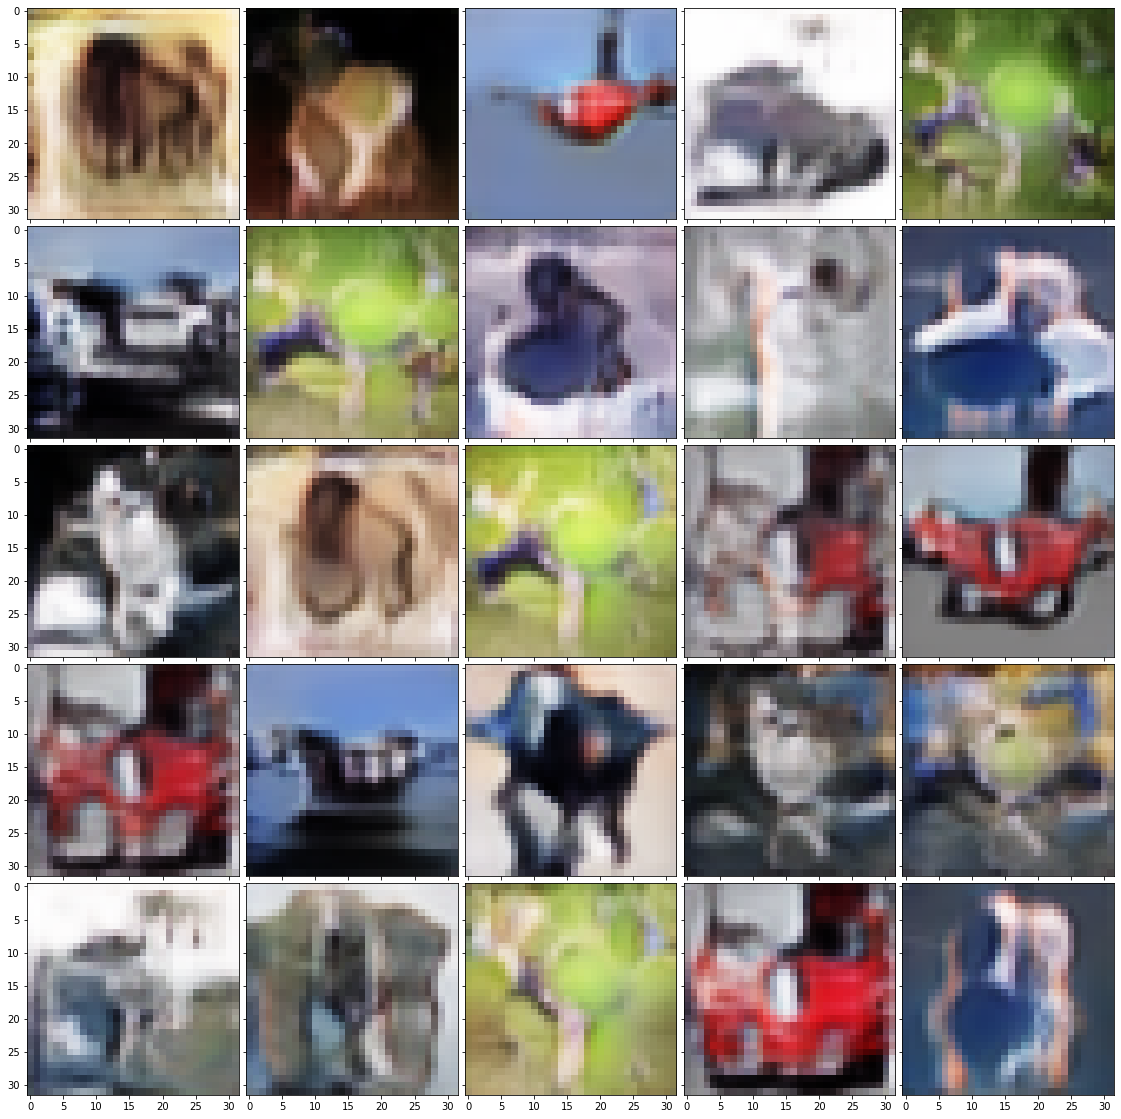

In [17]:
import matplotlib .pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# eval mode
gen_net = gen_net.eval()

# generate images
sample_imgs = gen_net(fixed_z).mul_(127.5).add_(127.5).clamp_(0.0, 255.0).permute(0, 2, 3, 1).to('cpu', torch.uint8).numpy()


fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, sample_imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()